In [1]:
# Set up environment first.
# we will need current numpy for pygrib
import numpy as np, os
if not [int(i) for i in np.__version__.split('.')] >= [1,20,1]: # check numpy version
  print('Upgrading numpy and stopping RUNTIME! When the notebook completes, please run again.')
  ! pip install --upgrade numpy    # suggested by Efosa, see also https://github.com/jswhit/pygrib/issues/192
  os.kill(os.getpid(), 9)          # kill the runtime, need to run again from the beginning! pip install pygrib
! pip install pygrib   
! wget --no-clobber https://raw.githubusercontent.com/openwfm/wrfxpy/master/src/ingest/grib_file.py
from grib_file import GribFile     # Martin's utility layer on top of  pygrib,from wrfxpy

File ‘grib_file.py’ already there; not retrieving.



## Kalman filter

The Kalman filter provides an estimate $u$ of the time evolution of some unknown process, called "nature" or "truth". We do not know with certainty what the nature is, but we can observe it at regular intervals (steps) with some error. In each step, model $F$ advances the model state $u$ in time, $ u \leftarrow F(u)$, and attempts to reconcile the state with an observation $d$ of the true state, so $u \approx d$. The filter modifies the model state $u$ to balance the uncertainty in the model and the data (this is called *analysis*) and the cycle continues. For that purpose, the filter evolves also an estimate of the uncertainly of the model.

More generally, instead of $u \approx d$, only a part of the state is observed, and $Hu \approx d$ where $H$ is a matrix, or observation function. Basically, $Hu$ is what the data would be if the model was completely accurate. 

In [2]:
import numpy as np
def ext_kf(u,P,F,Q=0,d=None,H=None,R=None):
  """
  One step of the extended Kalman filter. 
  If there is no data, only advance in time.
  :param u:   the state vector, shape n
  :param P:   the state covariance, shape (n,n)
  :param Q:   the process model noise covariance, shape (n,n)
  :param F:   the model function, maps vector u to vector F(u) and Jacobian J(u)
  :param d:   data vector, shape (m)
  :param H:   observation matrix, shape (m,n)
  :param R:   data error covariance, shape (n,n)
  :return ua: the analysis state vector, shape (n)
  :return Pa: the analysis covariance matrix, shape (n,n)
  """
  def d2(a):
    return np.atleast_2d(a) # convert to at least 2d array

  def d1(a):
    return np.atleast_1d(a) # convert to at least 1d array

  # forecast
  uf, J  = F(u)          # advance the model state in time and get the Jacobian
  uf = d1(uf)            # if scalar, make state a 1D array
  P = d2(P)              # if scalar, make Jacobian as 2D array
  Pf  = d2(J.T @ P) @ J + Q  # advance the state covariance Pf = J' * P * J + Q
  # analysis
  if d is None or not d.size :  # no data, no analysis
    return uf, Pf
  # K = P H' * inverse(H * P * H' + R) = (inverse(H * P * H' + R)*(H P))'
  H = d2(H)
  HP  = d2(H @ P)            # precompute a part used twice  
  K   = d2(np.linalg.solve( d2(HP @ H.T) + R, HP)).T  # Kalman gain
  # print('H',H)
  # print('K',K)
  res = d1(H @ d1(uf) - d)          # res = H*uf - d
  ua = uf - K @ res # analysis mean uf - K*res
  Pa = Pf - K @ d2(H @ P)        # analysis covariance
  return ua, d2(Pa)


##  A basic exponential decay model of fuel moisture




The evolution of fuel moisture content $m(t)$ is modeled by the differential equation on interval $\left[
t_{0},t_{1}\right]  $,
$$
\frac{dm}{dt}=\frac{E-m(t)}{T},\quad m(t_{0})=m_{0}.
$$
where the initial fuel moisture content $m_{0}=m\left(  t_{0}\right)  $ is the
input, and $m_{1}=m(t_{1})$ is the output. Tnus, $m_1=F(m_0)$. The parameters of the model are the
fuel moisture equilibrium $E$, assumed to be constant over the interval $\left[
t_{0},t_{1}\right]  $, NS the characteristic decay time $T$. 

We can build the general model later by calling this simple model with different
equilibria and time constants (drying, wetting, rain).

Since $E$ is constant in time, the solution can be found
analytically,
$$
m\left(  t\right)  =E+\left(  m_{0}-E\right)  e^{-t/T}%
$$
For convenience, we use $T_{1}=1/T$ instead of $T$, and the model becomes
$$
m_{1}=E+\left(  m_{0}-E\right)  e^{-\left(  t_{1}-t_{0}\right)  T_{1}}%
$$
In the extended Kalman filter, we will need the partial derivatives of $m_{1}$
with respect to the input and the parameters. Compute
$$
\frac{dm_{1}}{d_{m0}}=e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dE}=1-e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dT_{1}}=-\left(  m_{0}-E\right)  \left(  t_{1}-t_{0}\right)
e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
At the moment, we need only ${dm_{1}}/{dm_{0}}$ but we put in the code all partials for possible use in future.


In [3]:
import numpy as np
def model_decay(m0,E,partials=0,T1=0.1,tlen=1):
  exp_t = np.exp(-tlen*T1)                  # compute this subexpression only once
  m1 = E + (m0 - E)*exp_t                   # the solution at end
  if partials==0:
    return m1
  dm1_dm0 = exp_t
  if partials==1:
    return m1, np.array([dm1_dm0])          # return value and Jacobian
  dm1_dE = 1 - exp_t                        # partial derivative dm1 / dE
  dm1_dT1 = -(m0 - E)*tlen*exp_t            # partial derivative dm1 / dT1
  return m1, dm1_dm0, dm1_dE, dm1_dT1       # return value and all partial derivatives wrt m1 and parameters
  

## Kalman filter demonstration

We demonstrate the Kalman filter for this model on a simple artificial example. The model is solving the differential equation for one hour. The equilibrium $E$ is constant during the hour, but it changes over the day so that it is higher at night and lower during the day, with a 24-hour period.  First, we create the "truth" by choosing the equilibrium $E$ and solving the differential aquation every hour, with a small additive noise. The synthetic data is obtained as values of the "truth", with random noise to simulate observation error.

### Create synthetic data

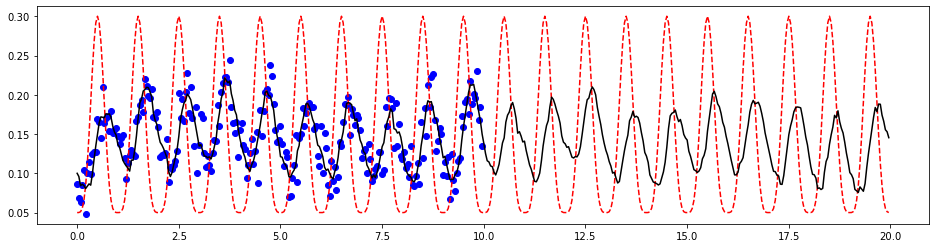

In [4]:
import numpy as np, random
days = 10       
hours = days*24
day = np.array(range(2*hours))/24.

# artificial equilibrium data
E = np.power(np.sin(np.pi*day),4) # diurnal curve
E = 0.05+0.25*E
E # scale 
# FMC free run
m_f = np.zeros(2*hours)
m_f[0] = 0.1         # initial FMC
for t in range(2*hours-1):
  m_f[t+1] = max(0.,model_decay(m_f[t],E[t])  + random.gauss(0,0.005) )
data = m_f + np.random.normal(loc=0,scale=0.02,size=2*hours)    

%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day[0:2*hours],E[0:2*hours],linestyle='--',c='r',label='Equilibrium')
plt.plot(day[0:2*hours],m_f[0:2*hours],linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
 

### Run Kalman filter

We have used the same code for model and for the truth, and run the Kalman filter for 10 days. The graph below shows that the model state was remarkably close to the truth, even if the model is fed only noisy observations. This is because the dynamics of the model and of the truth are the same. After 10 days, we let the model continue without any new data to simulate forecasting the future, and the agreement with the truth was still very good.

In [5]:
import numpy as np
import matplotlib.pyplot as plt 

def kf_example(DeltaE):
  m = np.zeros(2*hours)
  m[0]=0.1             # background state  
  P = np.zeros(2*hours)
  P[0] = 0.03 # background state variance
  Q = np.array([0.02]) # process noise variance
  H = np.array([1.])   # all observed
  R = np.array([0.02]) # data variance

  for t in range(hours):
    # use lambda construction to pass additional arguments to the model 
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
  for t in range(hours,2*hours - 1):
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
  %matplotlib inline
  plt.figure() # new figure
  plt.plot(day,P,linestyle='-',c='b',label='Estimated state variance P')
    
  %matplotlib inline
  plt.figure(figsize=(16,4))
  plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
  plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
  plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
  plt.plot(day,m,linestyle='-',c='r',label='filtered')

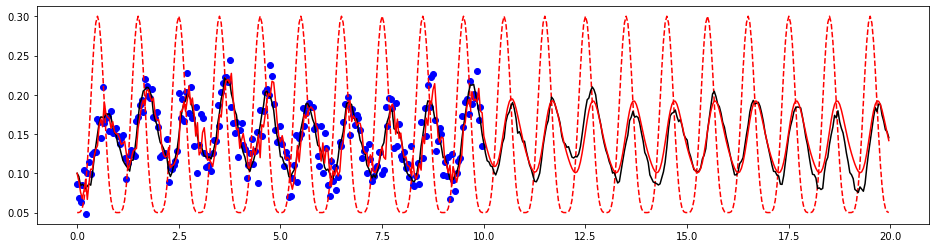

In [6]:
DeltaE = 0.0          # bias
kf_example(DeltaE)

We have recovered the fuel moisture from data with random noise - we **filtered** the noise out. 

Now what if the model is wrong - different from nature? That is always so in reality. Now suppose that the model and the truth are not the same. That is always the case in reality.  Consider a simple case when the model thinks that the equilibrium $E$ is too high.

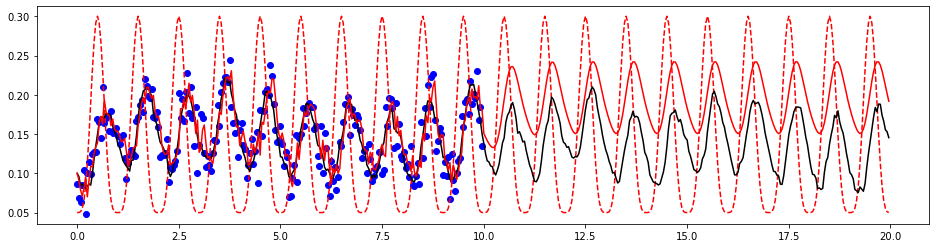

In [7]:
DeltaE = 0.05
kf_example(DeltaE)  

We have found a good estimate of the state $m$, while data is available. Also, the estimated state variance $P$ converges with time - we have *learned* the variance that balances the noise. But for forecasting fuel moisture, we need to continue the fuel moisture model into the future, and we can't have any measurements from future. We only have the equilibrium from weather forecast. And the forecast and the truth disagree.

## Real data

In [8]:
# set up bounds
# Take the first station in the boulding box that has data between time_start and time_s2.
# Then retrieve data for that station between time_start and time_end
time_start = "201806010800"  # June 1 2018 08:00 in format yyyymmddHHMM
time_s2    = "201806010900"  # June 1 2018 09:00 in format yyyymmddHHMM 
time_end   = "201906200900"  # Nov 1 2018 09:00 in format yyyymmddHHMM 
#time_start=  "201810230100"
#time_s2=  "201810230300"
#time_end  =  "201806022300"

We retrieve the fuel moisture data from sensors on weather stations in the Mesowest network. 

 Get all stations with fuel moisture data in a spatial box within one hour: 

In [9]:
!pip install MesoPy
from MesoPy import Meso
bounding_box = "-115, 38, -110, 40"  # min longtitude, latitude
meso_token="b40cb52cbdef43ef81329b84e8fd874f"       # you should get your own if you do more of this
m = Meso(meso_token)                                     # create a Meso object
meso_obss = m.timeseries(time_start, time_s2, bbox=bounding_box, showemptystations = '0', vars='fuel_moisture')   # ask the object for data

In [10]:
meso_obss

{'UNITS': {'position': 'ft', 'fuel_moisture': 'gm', 'elevation': 'ft'},
 'QC_SUMMARY': {'QC_CHECKS_APPLIED': ['sl_range_check'],
  'TOTAL_OBSERVATIONS_FLAGGED': 0.0,
  'PERCENT_OF_TOTAL_OBSERVATIONS_FLAGGED': 0.0},
 'STATION': [{'STATUS': 'ACTIVE',
   'MNET_ID': '2',
   'PERIOD_OF_RECORD': {'start': '1997-01-01T00:00:00Z',
    'end': '2021-11-08T00:27:00Z'},
   'ELEVATION': '6493',
   'NAME': 'BLACK CEDAR',
   'STID': 'BKCU1',
   'SENSOR_VARIABLES': {'date_time': {'date_time': {}},
    'fuel_moisture': {'fuel_moisture_set_1': {'position': '0.98'}}},
   'ELEV_DEM': '6499.3',
   'LONGITUDE': '-112.238864',
   'STATE': 'UT',
   'OBSERVATIONS': {'date_time': ['2018-06-01T08:27:00Z'],
    'fuel_moisture_set_1': [4.9]},
   'RESTRICTED': False,
   'QC_FLAGGED': False,
   'LATITUDE': '38.979242',
   'TIMEZONE': 'America/Denver',
   'ID': '2328'},
  {'STATUS': 'ACTIVE',
   'MNET_ID': '2',
   'PERIOD_OF_RECORD': {'start': '1998-07-30T00:00:00Z',
    'end': '2021-11-08T00:12:00Z'},
   'ELEVATION'

Print the result:

In [11]:
import json
print(json.dumps(meso_obss, indent=4))


{
    "UNITS": {
        "position": "ft",
        "fuel_moisture": "gm",
        "elevation": "ft"
    },
    "QC_SUMMARY": {
        "QC_CHECKS_APPLIED": [
            "sl_range_check"
        ],
        "TOTAL_OBSERVATIONS_FLAGGED": 0.0,
        "PERCENT_OF_TOTAL_OBSERVATIONS_FLAGGED": 0.0
    },
    "STATION": [
        {
            "STATUS": "ACTIVE",
            "MNET_ID": "2",
            "PERIOD_OF_RECORD": {
                "start": "1997-01-01T00:00:00Z",
                "end": "2021-11-08T00:27:00Z"
            },
            "ELEVATION": "6493",
            "NAME": "BLACK CEDAR",
            "STID": "BKCU1",
            "SENSOR_VARIABLES": {
                "date_time": {
                    "date_time": {}
                },
                "fuel_moisture": {
                    "fuel_moisture_set_1": {
                        "position": "0.98"
                    }
                }
            },
            "ELEV_DEM": "6499.3",
            "LONGITUDE": "-112.238864",

Pick one station and get a time series for the station.

In [12]:
station=meso_obss['STATION'][0]
#print(json.dumps(station, indent=4))
lon,lat = (float(station['LONGITUDE']),float(station['LATITUDE']))
print(station['NAME'],'station',station['STID'],'at',lon,lat)
e = 0.01
bb = '%s, %s, %s, %s' % (lon - e, lat - e, lon + e, lat + e)
print('bounding box',bb)
meso_ts = m.timeseries(time_start, time_end, bbox=bb, showemptystations = '0', vars='fuel_moisture')   # ask the object for data
obs_lon, obs_lat = (lon, lat)   # remember station coordinates for later

BLACK CEDAR station BKCU1 at -112.238864 38.979242
bounding box -112.24886400000001, 38.969242, -112.228864, 38.989242


Text(0.5, 1.0, 'BKCU1 10 h fuel moisture data')

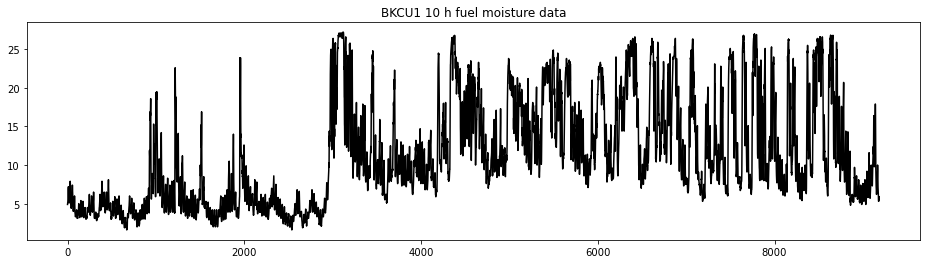

In [13]:
# process the data retrieved for this station
# print(json.dumps(meso_ts['STATION'][0], indent=4))
from datetime import datetime, timedelta, time
import numpy as np
import matplotlib.pyplot as plt
import pytz
station = meso_ts['STATION'][0]
time_str  = station['OBSERVATIONS']['date_time']
obs_time = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=pytz.UTC) for t in time_str]
start_time = obs_time[0].replace(minute=0)     # remember obs_time and start_time for later
end_time = obs_time[-1]
obs_data = np.array(station['OBSERVATIONS']["fuel_moisture_set_1"])
# display the data retrieved
#for o_time,o_data in zip (obs_time,obs_data):
#    print(o_time,o_data)
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(obs_data,linestyle='-',c='k',label='10-h fuel data')
plt.title(station['STID'] + ' 10 h fuel moisture data')


Next, we retrieve weather data for the duration of the station data, from our RTMA stash.

Create a function to transfer RTMA files in GRIB2 format from the stash. The function returns zero if the file transfer succeeded. If the file is not available, it returns a nonzero value. Note: if needed, maybe in future add more sophisticated checks, check the return code of wget and if the file size is correct.

In [14]:
import subprocess,os
def load_rtma(path,file,reload=0):
  url='http://math.ucdenver.edu/~jmandel/rtma/' + path 
  if os.path.exists(file):
    if reload:
      print(file + ' already exists, removing')
      os.remove(file)
    else:
      print(file + ' already exists, exiting')
      # add checking size here
      return 0
  try:
    ret = subprocess.check_output(['wget','--no-clobber','--output-document='+ file, url,],stderr=subprocess.STDOUT).decode() # execute command from python strings
    if os.path.exists(file):
      print('loaded ' + url + ' as ' + file)
      return 0
    else: 
      print('file transfer completed, but the file is missing? ' + url)  
      return 1
  except:
    print('file transfer failed: ' + url)
    return 2


Next, functions to get the files, open as grib, and interpolate to the station coordinates

In [15]:
def rtma_grib(t,var):
    tpath = '%4i%02i%02i/%02i' % (t.year, t.month, t.day, t.hour)  # remote path on server
    tstr  = '%4i%02i%02i%02i_' % (t.year, t.month, t.day, t.hour)  # time string for local path
    gribfile = os.path.join('data',tstr + var + '.grib')
    remote = tpath + '/' + var + '.grib'
    if load_rtma(remote,gribfile):
        print('cannot load remote file',remote,'as',gribfile)
        return []
    else:
        try:
            gf=GribFile(gribfile)
            v = np.array(gf[1].values())
        except:
            print('cannot read grib file',gribfile)
            return []
        print('loaded ',gribfile,' containing array shape ',v.shape)
        return gf[1]   # grib message


In [16]:
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
def interp_to_lat_lon_slow(lats,lons,v,lat,lon): 
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    interp=LinearNDInterpolator(list(zip(lats.flatten(),lons.flatten())),v.flatten())
    return interp(lat,lon)
def interp_to_lat_lon(lats,lons,v,lat,lon):
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    points=(np.array(range(lats.shape[0]),float),np.array(range(lats.shape[1]),float))  # uniform mesh
    def res(ij):  # interpolation of lons lats on the uniform mesh, to noninteger coordinates   
       return np.hstack((interpn(points,lats,ij)-lat, interpn(points,lons,ij)-lon))
    # solve for xi,xj such that lats(xi,xj)=lat lons(xi,xj)=lon, then interpolate to (xi, xj) on uniform grid 
    result = root(res,(0,0)) # solve res(ij) = 0
    if not result.success:
        print(result.message)
        exit(1)
    return interpn(points,v,result.x) 


The interpolation function needs to  be tested.

In [17]:
def interp_to_lat_lon_test(lats,lons):
    print('testing interp_to_lat_lon')
    vx, vy = np.meshgrid(range(lats.shape[0]),range(lats.shape[1]),indexing='ij')
    i, j = (1,2)
    lat,lon = ((lats[i,j]+lats[i+1,j+1])/2,(lons[i,j]+lons[i+1,j+1])/2)
    vi = interp_to_lat_lon(lats,lons,vx,lat,lon)
    vj = interp_to_lat_lon(lats,lons,vy,lat,lon)
    print(vi,vj,'should be about',i+0.5,j+0.5)
    test_slow = 0
    if test_slow:
        print('Testing against the standard slow method scipy.interpolate.LinearNDInterpolator. Please wait...')
        vi_slow = interp_to_lat_lon_slow(lats,lons,vx,lat,lon)
        print(vi_slow)
        vj_slow = interp_to_lat_lon_slow(lats,lons,vy,lat,lon)
        print(vj_slow)
        
gf = rtma_grib(start_time,'temp')      #  read the first grib file and use it to test interpolation
lats, lons = gf.latlons()
interp_to_lat_lon_test(lats,lons)


data/2018060108_temp.grib already exists, exiting
loaded  data/2018060108_temp.grib  containing array shape  (1377, 2145)
testing interp_to_lat_lon
[1.50000185] [2.50004253] should be about 1.5 2.5


In [18]:
#%debug


Now we are ready to reading the RTMA files and interpolate to the station coordinates

In [19]:
import pandas as pd, json
def read_interp_rtma(varnames,times,lat,lon):
    # read RTMA from start_time to end_time and interpolate to obs_lat obs_lon
    ntimes = len(times)
    time_str = 'time_str'
    j={time_str:times.strftime('%Y-%m-%d %H:%M').tolist()}
    for varname in varnames:
        j[varname]=np.full(ntimes,np.nan)  # initialize array of nans as list
    n=0
    for t in times:
        tim=t.strftime('%Y-%m-%d %H:%M')
        should_be = j[time_str][n]
        if tim != should_be:
            print('n=',n,'time',tim,'expected',should_be)
            raise 'Invalid time' 
        for varname in varnames:
            gf = rtma_grib(t,varname)   # read and create grib object, download if needed
            if gf:
                lats,lons = gf.latlons()    # coordinates
                v = gf.values()
                vi=interp_to_lat_lon(lats,lons,v,lat,lon) # append to array
                print(varname,'at',t,'interpolated to',lat,lon,' value ',vi)
                j[varname][n] = vi
            else:
                print(varname,'at',t,' could not be loaded')
        n = n+1
    return j

In [20]:
times = pd.date_range(start=time_start,end=time_end,freq='1H')
varnames=['temp','td','precipa']
j =    read_interp_rtma(varnames,times,obs_lat,obs_lon)      # temperature

data/2018060108_temp.grib already exists, exiting
loaded  data/2018060108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 08:00:00 interpolated to 38.979242 -112.238864  value  [286.78143292]
data/2018060108_td.grib already exists, exiting
loaded  data/2018060108_td.grib  containing array shape  (1377, 2145)
td at 2018-06-01 08:00:00 interpolated to 38.979242 -112.238864  value  [268.82318169]
data/2018060108_precipa.grib already exists, exiting
loaded  data/2018060108_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-01 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060109_temp.grib already exists, exiting
loaded  data/2018060109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 09:00:00 interpolated to 38.979242 -112.238864  value  [285.50690577]
data/2018060109_td.grib already exists, exiting
loaded  data/2018060109_td.grib  containing array shape  (1377, 2145)
td at 2018-06-01 09:00:00 interpolated to 38.

temp at 2018-06-01 21:00:00 interpolated to 38.979242 -112.238864  value  [292.63916511]
data/2018060121_td.grib already exists, exiting
loaded  data/2018060121_td.grib  containing array shape  (1377, 2145)
td at 2018-06-01 21:00:00 interpolated to 38.979242 -112.238864  value  [273.27960616]
data/2018060121_precipa.grib already exists, exiting
loaded  data/2018060121_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-01 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060122_temp.grib already exists, exiting
loaded  data/2018060122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-01 22:00:00 interpolated to 38.979242 -112.238864  value  [292.97421061]
data/2018060122_td.grib already exists, exiting
loaded  data/2018060122_td.grib  containing array shape  (1377, 2145)
td at 2018-06-01 22:00:00 interpolated to 38.979242 -112.238864  value  [272.25937871]
data/2018060122_precipa.grib already exists, exiting
loaded  data/2018060122_pre

td at 2018-06-02 10:00:00 interpolated to 38.979242 -112.238864  value  [268.07599507]
data/2018060210_precipa.grib already exists, exiting
loaded  data/2018060210_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-02 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060211_temp.grib already exists, exiting
loaded  data/2018060211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-02 11:00:00 interpolated to 38.979242 -112.238864  value  [283.11278853]
data/2018060211_td.grib already exists, exiting
loaded  data/2018060211_td.grib  containing array shape  (1377, 2145)
td at 2018-06-02 11:00:00 interpolated to 38.979242 -112.238864  value  [265.42800752]
data/2018060211_precipa.grib already exists, exiting
loaded  data/2018060211_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-02 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060212_temp.grib already exists, exiting
loaded  data/2018060212_tem

precipa at 2018-06-02 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060300_temp.grib already exists, exiting
loaded  data/2018060300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 00:00:00 interpolated to 38.979242 -112.238864  value  [297.86772952]
data/2018060300_td.grib already exists, exiting
loaded  data/2018060300_td.grib  containing array shape  (1377, 2145)
td at 2018-06-03 00:00:00 interpolated to 38.979242 -112.238864  value  [267.30528929]
data/2018060300_precipa.grib already exists, exiting
loaded  data/2018060300_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-03 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060301_temp.grib already exists, exiting
loaded  data/2018060301_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 01:00:00 interpolated to 38.979242 -112.238864  value  [296.96003141]
data/2018060301_td.grib already exists, exiting
loaded  data/2018060301_td.grib  

temp at 2018-06-03 13:00:00 interpolated to 38.979242 -112.238864  value  [286.42107986]
data/2018060313_td.grib already exists, exiting
loaded  data/2018060313_td.grib  containing array shape  (1377, 2145)
td at 2018-06-03 13:00:00 interpolated to 38.979242 -112.238864  value  [267.68612255]
data/2018060313_precipa.grib already exists, exiting
loaded  data/2018060313_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-03 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060314_temp.grib already exists, exiting
loaded  data/2018060314_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-03 14:00:00 interpolated to 38.979242 -112.238864  value  [289.84568488]
data/2018060314_td.grib already exists, exiting
loaded  data/2018060314_td.grib  containing array shape  (1377, 2145)
td at 2018-06-03 14:00:00 interpolated to 38.979242 -112.238864  value  [268.75662273]
data/2018060314_precipa.grib already exists, exiting
loaded  data/2018060314_pre

td at 2018-06-04 02:00:00 interpolated to 38.979242 -112.238864  value  [269.26546751]
data/2018060402_precipa.grib already exists, exiting
loaded  data/2018060402_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-04 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060403_temp.grib already exists, exiting
loaded  data/2018060403_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-04 03:00:00 interpolated to 38.979242 -112.238864  value  [295.00216751]
data/2018060403_td.grib already exists, exiting
loaded  data/2018060403_td.grib  containing array shape  (1377, 2145)
td at 2018-06-04 03:00:00 interpolated to 38.979242 -112.238864  value  [268.3684651]
data/2018060403_precipa.grib already exists, exiting
loaded  data/2018060403_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-04 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060404_temp.grib already exists, exiting
loaded  data/2018060404_temp

precipa at 2018-06-04 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060416_temp.grib already exists, exiting
loaded  data/2018060416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-04 16:00:00 interpolated to 38.979242 -112.238864  value  [299.22854892]
data/2018060416_td.grib already exists, exiting
loaded  data/2018060416_td.grib  containing array shape  (1377, 2145)
td at 2018-06-04 16:00:00 interpolated to 38.979242 -112.238864  value  [268.90278057]
data/2018060416_precipa.grib already exists, exiting
loaded  data/2018060416_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-04 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060417_temp.grib already exists, exiting
loaded  data/2018060417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-04 17:00:00 interpolated to 38.979242 -112.238864  value  [300.15563608]
data/2018060417_td.grib already exists, exiting
loaded  data/2018060417_td.grib  

temp at 2018-06-05 05:00:00 interpolated to 38.979242 -112.238864  value  [294.80843052]
data/2018060505_td.grib already exists, exiting
loaded  data/2018060505_td.grib  containing array shape  (1377, 2145)
td at 2018-06-05 05:00:00 interpolated to 38.979242 -112.238864  value  [261.09460971]
data/2018060505_precipa.grib already exists, exiting
loaded  data/2018060505_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-05 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060506_temp.grib already exists, exiting
loaded  data/2018060506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-05 06:00:00 interpolated to 38.979242 -112.238864  value  [294.86335542]
data/2018060506_td.grib already exists, exiting
loaded  data/2018060506_td.grib  containing array shape  (1377, 2145)
td at 2018-06-05 06:00:00 interpolated to 38.979242 -112.238864  value  [261.97019308]
data/2018060506_precipa.grib already exists, exiting
loaded  data/2018060506_pre

td at 2018-06-05 18:00:00 interpolated to 38.979242 -112.238864  value  [268.29071919]
data/2018060518_precipa.grib already exists, exiting
loaded  data/2018060518_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-05 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060519_temp.grib already exists, exiting
loaded  data/2018060519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-05 19:00:00 interpolated to 38.979242 -112.238864  value  [300.82918694]
data/2018060519_td.grib already exists, exiting
loaded  data/2018060519_td.grib  containing array shape  (1377, 2145)
td at 2018-06-05 19:00:00 interpolated to 38.979242 -112.238864  value  [268.10717975]
data/2018060519_precipa.grib already exists, exiting
loaded  data/2018060519_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-05 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060520_temp.grib already exists, exiting
loaded  data/2018060520_tem

precipa at 2018-06-06 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060608_temp.grib already exists, exiting
loaded  data/2018060608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-06 08:00:00 interpolated to 38.979242 -112.238864  value  [291.39032816]
data/2018060608_td.grib already exists, exiting
loaded  data/2018060608_td.grib  containing array shape  (1377, 2145)
td at 2018-06-06 08:00:00 interpolated to 38.979242 -112.238864  value  [269.1176042]
data/2018060608_precipa.grib already exists, exiting
loaded  data/2018060608_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-06 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060609_temp.grib already exists, exiting
loaded  data/2018060609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-06 09:00:00 interpolated to 38.979242 -112.238864  value  [291.23443691]
data/2018060609_td.grib already exists, exiting
loaded  data/2018060609_td.grib  c

temp at 2018-06-06 21:00:00 interpolated to 38.979242 -112.238864  value  [301.0883405]
data/2018060621_td.grib already exists, exiting
loaded  data/2018060621_td.grib  containing array shape  (1377, 2145)
td at 2018-06-06 21:00:00 interpolated to 38.979242 -112.238864  value  [270.35824272]
data/2018060621_precipa.grib already exists, exiting
loaded  data/2018060621_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-06 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060622_temp.grib already exists, exiting
loaded  data/2018060622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-06 22:00:00 interpolated to 38.979242 -112.238864  value  [301.30013124]
data/2018060622_td.grib already exists, exiting
loaded  data/2018060622_td.grib  containing array shape  (1377, 2145)
td at 2018-06-06 22:00:00 interpolated to 38.979242 -112.238864  value  [269.32741114]
data/2018060622_precipa.grib already exists, exiting
loaded  data/2018060622_prec

td at 2018-06-07 10:00:00 interpolated to 38.979242 -112.238864  value  [269.65476796]
data/2018060710_precipa.grib already exists, exiting
loaded  data/2018060710_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-07 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060711_temp.grib already exists, exiting
loaded  data/2018060711_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-07 11:00:00 interpolated to 38.979242 -112.238864  value  [287.74550213]
data/2018060711_td.grib already exists, exiting
loaded  data/2018060711_td.grib  containing array shape  (1377, 2145)
td at 2018-06-07 11:00:00 interpolated to 38.979242 -112.238864  value  [270.34476824]
data/2018060711_precipa.grib already exists, exiting
loaded  data/2018060711_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-07 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060712_temp.grib already exists, exiting
loaded  data/2018060712_tem

precipa at 2018-06-07 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060800_temp.grib already exists, exiting
loaded  data/2018060800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-08 00:00:00 interpolated to 38.979242 -112.238864  value  [300.76478286]
data/2018060800_td.grib already exists, exiting
loaded  data/2018060800_td.grib  containing array shape  (1377, 2145)
td at 2018-06-08 00:00:00 interpolated to 38.979242 -112.238864  value  [265.68580511]
data/2018060800_precipa.grib already exists, exiting
loaded  data/2018060800_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-08 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060801_temp.grib already exists, exiting
loaded  data/2018060801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-08 01:00:00 interpolated to 38.979242 -112.238864  value  [299.86838609]
data/2018060801_td.grib already exists, exiting
loaded  data/2018060801_td.grib  

temp at 2018-06-08 13:00:00 interpolated to 38.979242 -112.238864  value  [288.72417505]
data/2018060813_td.grib already exists, exiting
loaded  data/2018060813_td.grib  containing array shape  (1377, 2145)
td at 2018-06-08 13:00:00 interpolated to 38.979242 -112.238864  value  [266.71368844]
data/2018060813_precipa.grib already exists, exiting
loaded  data/2018060813_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-08 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060814_temp.grib already exists, exiting
loaded  data/2018060814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-08 14:00:00 interpolated to 38.979242 -112.238864  value  [292.7689562]
data/2018060814_td.grib already exists, exiting
loaded  data/2018060814_td.grib  containing array shape  (1377, 2145)
td at 2018-06-08 14:00:00 interpolated to 38.979242 -112.238864  value  [268.05431004]
data/2018060814_precipa.grib already exists, exiting
loaded  data/2018060814_prec

td at 2018-06-09 02:00:00 interpolated to 38.979242 -112.238864  value  [265.58183119]
data/2018060902_precipa.grib already exists, exiting
loaded  data/2018060902_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-09 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060903_temp.grib already exists, exiting
loaded  data/2018060903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-09 03:00:00 interpolated to 38.979242 -112.238864  value  [295.49575805]
data/2018060903_td.grib already exists, exiting
loaded  data/2018060903_td.grib  containing array shape  (1377, 2145)
td at 2018-06-09 03:00:00 interpolated to 38.979242 -112.238864  value  [265.00050929]
data/2018060903_precipa.grib already exists, exiting
loaded  data/2018060903_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-09 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060904_temp.grib already exists, exiting
loaded  data/2018060904_tem

precipa at 2018-06-09 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060916_temp.grib already exists, exiting
loaded  data/2018060916_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-09 16:00:00 interpolated to 38.979242 -112.238864  value  [297.41444438]
data/2018060916_td.grib already exists, exiting
loaded  data/2018060916_td.grib  containing array shape  (1377, 2145)
td at 2018-06-09 16:00:00 interpolated to 38.979242 -112.238864  value  [267.37383424]
data/2018060916_precipa.grib already exists, exiting
loaded  data/2018060916_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-09 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018060917_temp.grib already exists, exiting
loaded  data/2018060917_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-09 17:00:00 interpolated to 38.979242 -112.238864  value  [298.44949068]
data/2018060917_td.grib already exists, exiting
loaded  data/2018060917_td.grib  

temp at 2018-06-10 05:00:00 interpolated to 38.979242 -112.238864  value  [294.08232834]
data/2018061005_td.grib already exists, exiting
loaded  data/2018061005_td.grib  containing array shape  (1377, 2145)
td at 2018-06-10 05:00:00 interpolated to 38.979242 -112.238864  value  [263.94192123]
data/2018061005_precipa.grib already exists, exiting
loaded  data/2018061005_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-10 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061006_temp.grib already exists, exiting
loaded  data/2018061006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-10 06:00:00 interpolated to 38.979242 -112.238864  value  [292.76480563]
data/2018061006_td.grib already exists, exiting
loaded  data/2018061006_td.grib  containing array shape  (1377, 2145)
td at 2018-06-10 06:00:00 interpolated to 38.979242 -112.238864  value  [263.95777921]
data/2018061006_precipa.grib already exists, exiting
loaded  data/2018061006_pre

td at 2018-06-10 18:00:00 interpolated to 38.979242 -112.238864  value  [273.7091516]
data/2018061018_precipa.grib already exists, exiting
loaded  data/2018061018_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-10 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061019_temp.grib already exists, exiting
loaded  data/2018061019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-10 19:00:00 interpolated to 38.979242 -112.238864  value  [290.95172991]
data/2018061019_td.grib already exists, exiting
loaded  data/2018061019_td.grib  containing array shape  (1377, 2145)
td at 2018-06-10 19:00:00 interpolated to 38.979242 -112.238864  value  [272.68625965]
data/2018061019_precipa.grib already exists, exiting
loaded  data/2018061019_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-10 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061020_temp.grib already exists, exiting
loaded  data/2018061020_temp

precipa at 2018-06-11 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061108_temp.grib already exists, exiting
loaded  data/2018061108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-11 08:00:00 interpolated to 38.979242 -112.238864  value  [285.06350431]
data/2018061108_td.grib already exists, exiting
loaded  data/2018061108_td.grib  containing array shape  (1377, 2145)
td at 2018-06-11 08:00:00 interpolated to 38.979242 -112.238864  value  [266.12258577]
data/2018061108_precipa.grib already exists, exiting
loaded  data/2018061108_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-11 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061109_temp.grib already exists, exiting
loaded  data/2018061109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-11 09:00:00 interpolated to 38.979242 -112.238864  value  [284.42593522]
data/2018061109_td.grib already exists, exiting
loaded  data/2018061109_td.grib  

temp at 2018-06-11 21:00:00 interpolated to 38.979242 -112.238864  value  [298.44516116]
data/2018061121_td.grib already exists, exiting
loaded  data/2018061121_td.grib  containing array shape  (1377, 2145)
td at 2018-06-11 21:00:00 interpolated to 38.979242 -112.238864  value  [265.81465691]
data/2018061121_precipa.grib already exists, exiting
loaded  data/2018061121_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-11 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061122_temp.grib already exists, exiting
loaded  data/2018061122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-11 22:00:00 interpolated to 38.979242 -112.238864  value  [298.86529184]
data/2018061122_td.grib already exists, exiting
loaded  data/2018061122_td.grib  containing array shape  (1377, 2145)
td at 2018-06-11 22:00:00 interpolated to 38.979242 -112.238864  value  [267.04694954]
data/2018061122_precipa.grib already exists, exiting
loaded  data/2018061122_pre

td at 2018-06-12 10:00:00 interpolated to 38.979242 -112.238864  value  [266.79391192]
data/2018061210_precipa.grib already exists, exiting
loaded  data/2018061210_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-12 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061211_temp.grib already exists, exiting
loaded  data/2018061211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-12 11:00:00 interpolated to 38.979242 -112.238864  value  [287.43093686]
data/2018061211_td.grib already exists, exiting
loaded  data/2018061211_td.grib  containing array shape  (1377, 2145)
td at 2018-06-12 11:00:00 interpolated to 38.979242 -112.238864  value  [268.33236106]
data/2018061211_precipa.grib already exists, exiting
loaded  data/2018061211_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-12 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061212_temp.grib already exists, exiting
loaded  data/2018061212_tem

precipa at 2018-06-12 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061300_temp.grib already exists, exiting
loaded  data/2018061300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-13 00:00:00 interpolated to 38.979242 -112.238864  value  [300.39023496]
data/2018061300_td.grib already exists, exiting
loaded  data/2018061300_td.grib  containing array shape  (1377, 2145)
td at 2018-06-13 00:00:00 interpolated to 38.979242 -112.238864  value  [270.83286267]
data/2018061300_precipa.grib already exists, exiting
loaded  data/2018061300_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-13 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061301_temp.grib already exists, exiting
loaded  data/2018061301_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-13 01:00:00 interpolated to 38.979242 -112.238864  value  [300.12992145]
data/2018061301_td.grib already exists, exiting
loaded  data/2018061301_td.grib  

temp at 2018-06-13 13:00:00 interpolated to 38.979242 -112.238864  value  [291.81336432]
data/2018061313_td.grib already exists, exiting
loaded  data/2018061313_td.grib  containing array shape  (1377, 2145)
td at 2018-06-13 13:00:00 interpolated to 38.979242 -112.238864  value  [269.85792157]
data/2018061313_precipa.grib already exists, exiting
loaded  data/2018061313_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-13 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061314_temp.grib already exists, exiting
loaded  data/2018061314_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-13 14:00:00 interpolated to 38.979242 -112.238864  value  [295.54921222]
data/2018061314_td.grib already exists, exiting
loaded  data/2018061314_td.grib  containing array shape  (1377, 2145)
td at 2018-06-13 14:00:00 interpolated to 38.979242 -112.238864  value  [271.51465304]
data/2018061314_precipa.grib already exists, exiting
loaded  data/2018061314_pre

td at 2018-06-14 02:00:00 interpolated to 38.979242 -112.238864  value  [267.54942517]
data/2018061402_precipa.grib already exists, exiting
loaded  data/2018061402_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-14 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061403_temp.grib already exists, exiting
loaded  data/2018061403_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 03:00:00 interpolated to 38.979242 -112.238864  value  [298.74750595]
data/2018061403_td.grib already exists, exiting
loaded  data/2018061403_td.grib  containing array shape  (1377, 2145)
td at 2018-06-14 03:00:00 interpolated to 38.979242 -112.238864  value  [266.06192643]
data/2018061403_precipa.grib already exists, exiting
loaded  data/2018061403_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-14 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061404_temp.grib already exists, exiting
loaded  data/2018061404_tem

precipa at 2018-06-14 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061416_temp.grib already exists, exiting
loaded  data/2018061416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 16:00:00 interpolated to 38.979242 -112.238864  value  [299.26426806]
data/2018061416_td.grib already exists, exiting
loaded  data/2018061416_td.grib  containing array shape  (1377, 2145)
td at 2018-06-14 16:00:00 interpolated to 38.979242 -112.238864  value  [270.06786979]
data/2018061416_precipa.grib already exists, exiting
loaded  data/2018061416_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-14 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061417_temp.grib already exists, exiting
loaded  data/2018061417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-14 17:00:00 interpolated to 38.979242 -112.238864  value  [300.36558706]
data/2018061417_td.grib already exists, exiting
loaded  data/2018061417_td.grib  

temp at 2018-06-15 05:00:00 interpolated to 38.979242 -112.238864  value  [295.44786093]
data/2018061505_td.grib already exists, exiting
loaded  data/2018061505_td.grib  containing array shape  (1377, 2145)
td at 2018-06-15 05:00:00 interpolated to 38.979242 -112.238864  value  [266.23795782]
data/2018061505_precipa.grib already exists, exiting
loaded  data/2018061505_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-15 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061506_temp.grib already exists, exiting
loaded  data/2018061506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-15 06:00:00 interpolated to 38.979242 -112.238864  value  [294.78403299]
data/2018061506_td.grib already exists, exiting
loaded  data/2018061506_td.grib  containing array shape  (1377, 2145)
td at 2018-06-15 06:00:00 interpolated to 38.979242 -112.238864  value  [266.30211252]
data/2018061506_precipa.grib already exists, exiting
loaded  data/2018061506_pre

td at 2018-06-15 18:00:00 interpolated to 38.979242 -112.238864  value  [271.06154787]
data/2018061518_precipa.grib already exists, exiting
loaded  data/2018061518_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-15 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061519_temp.grib already exists, exiting
loaded  data/2018061519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-15 19:00:00 interpolated to 38.979242 -112.238864  value  [301.71521696]
data/2018061519_td.grib already exists, exiting
loaded  data/2018061519_td.grib  containing array shape  (1377, 2145)
td at 2018-06-15 19:00:00 interpolated to 38.979242 -112.238864  value  [271.70350307]
data/2018061519_precipa.grib already exists, exiting
loaded  data/2018061519_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-15 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061520_temp.grib already exists, exiting
loaded  data/2018061520_tem

precipa at 2018-06-16 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061608_temp.grib already exists, exiting
loaded  data/2018061608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 08:00:00 interpolated to 38.979242 -112.238864  value  [291.80065931]
data/2018061608_td.grib already exists, exiting
loaded  data/2018061608_td.grib  containing array shape  (1377, 2145)
td at 2018-06-16 08:00:00 interpolated to 38.979242 -112.238864  value  [278.41046548]
data/2018061608_precipa.grib already exists, exiting
loaded  data/2018061608_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-16 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061609_temp.grib already exists, exiting
loaded  data/2018061609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 09:00:00 interpolated to 38.979242 -112.238864  value  [291.76464315]
data/2018061609_td.grib already exists, exiting
loaded  data/2018061609_td.grib  

temp at 2018-06-16 21:00:00 interpolated to 38.979242 -112.238864  value  [299.2797506]
data/2018061621_td.grib already exists, exiting
loaded  data/2018061621_td.grib  containing array shape  (1377, 2145)
td at 2018-06-16 21:00:00 interpolated to 38.979242 -112.238864  value  [276.85715731]
data/2018061621_precipa.grib already exists, exiting
loaded  data/2018061621_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-16 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061622_temp.grib already exists, exiting
loaded  data/2018061622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-16 22:00:00 interpolated to 38.979242 -112.238864  value  [299.5928965]
data/2018061622_td.grib already exists, exiting
loaded  data/2018061622_td.grib  containing array shape  (1377, 2145)
td at 2018-06-16 22:00:00 interpolated to 38.979242 -112.238864  value  [276.23008119]
data/2018061622_precipa.grib already exists, exiting
loaded  data/2018061622_preci

td at 2018-06-17 10:00:00 interpolated to 38.979242 -112.238864  value  [279.38826563]
data/2018061710_precipa.grib already exists, exiting
loaded  data/2018061710_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-17 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061711_temp.grib already exists, exiting
loaded  data/2018061711_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-17 11:00:00 interpolated to 38.979242 -112.238864  value  [288.84767124]
data/2018061711_td.grib already exists, exiting
loaded  data/2018061711_td.grib  containing array shape  (1377, 2145)
td at 2018-06-17 11:00:00 interpolated to 38.979242 -112.238864  value  [280.34558975]
data/2018061711_precipa.grib already exists, exiting
loaded  data/2018061711_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-17 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061712_temp.grib already exists, exiting
loaded  data/2018061712_tem

precipa at 2018-06-17 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061800_temp.grib already exists, exiting
loaded  data/2018061800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-18 00:00:00 interpolated to 38.979242 -112.238864  value  [299.39093142]
data/2018061800_td.grib already exists, exiting
loaded  data/2018061800_td.grib  containing array shape  (1377, 2145)
td at 2018-06-18 00:00:00 interpolated to 38.979242 -112.238864  value  [274.49208823]
data/2018061800_precipa.grib already exists, exiting
loaded  data/2018061800_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-18 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061801_temp.grib already exists, exiting
loaded  data/2018061801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-18 01:00:00 interpolated to 38.979242 -112.238864  value  [298.03871223]
data/2018061801_td.grib already exists, exiting
loaded  data/2018061801_td.grib  

temp at 2018-06-18 13:00:00 interpolated to 38.979242 -112.238864  value  [284.45583631]
data/2018061813_td.grib already exists, exiting
loaded  data/2018061813_td.grib  containing array shape  (1377, 2145)
td at 2018-06-18 13:00:00 interpolated to 38.979242 -112.238864  value  [274.34755904]
data/2018061813_precipa.grib already exists, exiting
loaded  data/2018061813_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-18 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061814_temp.grib already exists, exiting
loaded  data/2018061814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-18 14:00:00 interpolated to 38.979242 -112.238864  value  [287.12251498]
data/2018061814_td.grib already exists, exiting
loaded  data/2018061814_td.grib  containing array shape  (1377, 2145)
td at 2018-06-18 14:00:00 interpolated to 38.979242 -112.238864  value  [274.15502099]
data/2018061814_precipa.grib already exists, exiting
loaded  data/2018061814_pre

td at 2018-06-19 02:00:00 interpolated to 38.979242 -112.238864  value  [266.76248237]
data/2018061902_precipa.grib already exists, exiting
loaded  data/2018061902_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-19 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061903_temp.grib already exists, exiting
loaded  data/2018061903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-19 03:00:00 interpolated to 38.979242 -112.238864  value  [293.11137013]
data/2018061903_td.grib already exists, exiting
loaded  data/2018061903_td.grib  containing array shape  (1377, 2145)
td at 2018-06-19 03:00:00 interpolated to 38.979242 -112.238864  value  [267.05199514]
data/2018061903_precipa.grib already exists, exiting
loaded  data/2018061903_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-19 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061904_temp.grib already exists, exiting
loaded  data/2018061904_tem

precipa at 2018-06-19 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061916_temp.grib already exists, exiting
loaded  data/2018061916_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-19 16:00:00 interpolated to 38.979242 -112.238864  value  [290.5780907]
data/2018061916_td.grib already exists, exiting
loaded  data/2018061916_td.grib  containing array shape  (1377, 2145)
td at 2018-06-19 16:00:00 interpolated to 38.979242 -112.238864  value  [275.38316557]
data/2018061916_precipa.grib already exists, exiting
loaded  data/2018061916_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-19 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018061917_temp.grib already exists, exiting
loaded  data/2018061917_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-19 17:00:00 interpolated to 38.979242 -112.238864  value  [291.68382673]
data/2018061917_td.grib already exists, exiting
loaded  data/2018061917_td.grib  c

temp at 2018-06-20 05:00:00 interpolated to 38.979242 -112.238864  value  [290.72534793]
data/2018062005_td.grib already exists, exiting
loaded  data/2018062005_td.grib  containing array shape  (1377, 2145)
td at 2018-06-20 05:00:00 interpolated to 38.979242 -112.238864  value  [273.42143339]
data/2018062005_precipa.grib already exists, exiting
loaded  data/2018062005_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-20 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062006_temp.grib already exists, exiting
loaded  data/2018062006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 06:00:00 interpolated to 38.979242 -112.238864  value  [289.67559164]
data/2018062006_td.grib already exists, exiting
loaded  data/2018062006_td.grib  containing array shape  (1377, 2145)
td at 2018-06-20 06:00:00 interpolated to 38.979242 -112.238864  value  [273.48508666]
data/2018062006_precipa.grib already exists, exiting
loaded  data/2018062006_pre

td at 2018-06-20 18:00:00 interpolated to 38.979242 -112.238864  value  [275.90054932]
data/2018062018_precipa.grib already exists, exiting
loaded  data/2018062018_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-20 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062019_temp.grib already exists, exiting
loaded  data/2018062019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-20 19:00:00 interpolated to 38.979242 -112.238864  value  [297.35605722]
data/2018062019_td.grib already exists, exiting
loaded  data/2018062019_td.grib  containing array shape  (1377, 2145)
td at 2018-06-20 19:00:00 interpolated to 38.979242 -112.238864  value  [275.50957135]
data/2018062019_precipa.grib already exists, exiting
loaded  data/2018062019_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-20 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062020_temp.grib already exists, exiting
loaded  data/2018062020_tem

precipa at 2018-06-21 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062108_temp.grib already exists, exiting
loaded  data/2018062108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-21 08:00:00 interpolated to 38.979242 -112.238864  value  [294.66755037]
data/2018062108_td.grib already exists, exiting
loaded  data/2018062108_td.grib  containing array shape  (1377, 2145)
td at 2018-06-21 08:00:00 interpolated to 38.979242 -112.238864  value  [266.80470448]
data/2018062108_precipa.grib already exists, exiting
loaded  data/2018062108_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-21 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062109_temp.grib already exists, exiting
loaded  data/2018062109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-21 09:00:00 interpolated to 38.979242 -112.238864  value  [294.61878695]
data/2018062109_td.grib already exists, exiting
loaded  data/2018062109_td.grib  

temp at 2018-06-21 21:00:00 interpolated to 38.979242 -112.238864  value  [305.58437389]
data/2018062121_td.grib already exists, exiting
loaded  data/2018062121_td.grib  containing array shape  (1377, 2145)
td at 2018-06-21 21:00:00 interpolated to 38.979242 -112.238864  value  [266.08046796]
data/2018062121_precipa.grib already exists, exiting
loaded  data/2018062121_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-21 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062122_temp.grib already exists, exiting
loaded  data/2018062122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-21 22:00:00 interpolated to 38.979242 -112.238864  value  [305.58935846]
data/2018062122_td.grib already exists, exiting
loaded  data/2018062122_td.grib  containing array shape  (1377, 2145)
td at 2018-06-21 22:00:00 interpolated to 38.979242 -112.238864  value  [263.73001955]
data/2018062122_precipa.grib already exists, exiting
loaded  data/2018062122_pre

td at 2018-06-22 10:00:00 interpolated to 38.979242 -112.238864  value  [272.65464172]
data/2018062210_precipa.grib already exists, exiting
loaded  data/2018062210_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-22 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062211_temp.grib already exists, exiting
loaded  data/2018062211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-22 11:00:00 interpolated to 38.979242 -112.238864  value  [290.41676551]
data/2018062211_td.grib already exists, exiting
loaded  data/2018062211_td.grib  containing array shape  (1377, 2145)
td at 2018-06-22 11:00:00 interpolated to 38.979242 -112.238864  value  [275.32702282]
data/2018062211_precipa.grib already exists, exiting
loaded  data/2018062211_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-22 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062212_temp.grib already exists, exiting
loaded  data/2018062212_tem

precipa at 2018-06-22 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062300_temp.grib already exists, exiting
loaded  data/2018062300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-23 00:00:00 interpolated to 38.979242 -112.238864  value  [299.34058823]
data/2018062300_td.grib already exists, exiting
loaded  data/2018062300_td.grib  containing array shape  (1377, 2145)
td at 2018-06-23 00:00:00 interpolated to 38.979242 -112.238864  value  [267.03085109]
data/2018062300_precipa.grib already exists, exiting
loaded  data/2018062300_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-23 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062301_temp.grib already exists, exiting
loaded  data/2018062301_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-23 01:00:00 interpolated to 38.979242 -112.238864  value  [298.6688003]
data/2018062301_td.grib already exists, exiting
loaded  data/2018062301_td.grib  c

temp at 2018-06-23 13:00:00 interpolated to 38.979242 -112.238864  value  [291.76231307]
data/2018062313_td.grib already exists, exiting
loaded  data/2018062313_td.grib  containing array shape  (1377, 2145)
td at 2018-06-23 13:00:00 interpolated to 38.979242 -112.238864  value  [269.70024095]
data/2018062313_precipa.grib already exists, exiting
loaded  data/2018062313_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-23 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062314_temp.grib already exists, exiting
loaded  data/2018062314_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-23 14:00:00 interpolated to 38.979242 -112.238864  value  [294.5648504]
data/2018062314_td.grib already exists, exiting
loaded  data/2018062314_td.grib  containing array shape  (1377, 2145)
td at 2018-06-23 14:00:00 interpolated to 38.979242 -112.238864  value  [270.57225666]
data/2018062314_precipa.grib already exists, exiting
loaded  data/2018062314_prec

td at 2018-06-24 02:00:00 interpolated to 38.979242 -112.238864  value  [271.99461699]
data/2018062402_precipa.grib already exists, exiting
loaded  data/2018062402_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-24 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062403_temp.grib already exists, exiting
loaded  data/2018062403_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-24 03:00:00 interpolated to 38.979242 -112.238864  value  [296.66789434]
data/2018062403_td.grib already exists, exiting
loaded  data/2018062403_td.grib  containing array shape  (1377, 2145)
td at 2018-06-24 03:00:00 interpolated to 38.979242 -112.238864  value  [273.4419643]
data/2018062403_precipa.grib already exists, exiting
loaded  data/2018062403_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-24 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062404_temp.grib already exists, exiting
loaded  data/2018062404_temp

precipa at 2018-06-24 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062416_temp.grib already exists, exiting
loaded  data/2018062416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-24 16:00:00 interpolated to 38.979242 -112.238864  value  [291.45903234]
data/2018062416_td.grib already exists, exiting
loaded  data/2018062416_td.grib  containing array shape  (1377, 2145)
td at 2018-06-24 16:00:00 interpolated to 38.979242 -112.238864  value  [271.97657758]
data/2018062416_precipa.grib already exists, exiting
loaded  data/2018062416_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-24 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062417_temp.grib already exists, exiting
loaded  data/2018062417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-24 17:00:00 interpolated to 38.979242 -112.238864  value  [292.9272023]
data/2018062417_td.grib already exists, exiting
loaded  data/2018062417_td.grib  c

temp at 2018-06-25 05:00:00 interpolated to 38.979242 -112.238864  value  [291.26610721]
data/2018062505_td.grib already exists, exiting
loaded  data/2018062505_td.grib  containing array shape  (1377, 2145)
td at 2018-06-25 05:00:00 interpolated to 38.979242 -112.238864  value  [268.83073417]
data/2018062505_precipa.grib already exists, exiting
loaded  data/2018062505_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-25 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062506_temp.grib already exists, exiting
loaded  data/2018062506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 06:00:00 interpolated to 38.979242 -112.238864  value  [290.37036667]
data/2018062506_td.grib already exists, exiting
loaded  data/2018062506_td.grib  containing array shape  (1377, 2145)
td at 2018-06-25 06:00:00 interpolated to 38.979242 -112.238864  value  [267.97592577]
data/2018062506_precipa.grib already exists, exiting
loaded  data/2018062506_pre

td at 2018-06-25 18:00:00 interpolated to 38.979242 -112.238864  value  [270.26133289]
data/2018062518_precipa.grib already exists, exiting
loaded  data/2018062518_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-25 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062519_temp.grib already exists, exiting
loaded  data/2018062519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-25 19:00:00 interpolated to 38.979242 -112.238864  value  [301.00320136]
data/2018062519_td.grib already exists, exiting
loaded  data/2018062519_td.grib  containing array shape  (1377, 2145)
td at 2018-06-25 19:00:00 interpolated to 38.979242 -112.238864  value  [269.66759675]
data/2018062519_precipa.grib already exists, exiting
loaded  data/2018062519_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-25 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062520_temp.grib already exists, exiting
loaded  data/2018062520_tem

precipa at 2018-06-26 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062608_temp.grib already exists, exiting
loaded  data/2018062608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-26 08:00:00 interpolated to 38.979242 -112.238864  value  [295.63809514]
data/2018062608_td.grib already exists, exiting
loaded  data/2018062608_td.grib  containing array shape  (1377, 2145)
td at 2018-06-26 08:00:00 interpolated to 38.979242 -112.238864  value  [269.56771393]
data/2018062608_precipa.grib already exists, exiting
loaded  data/2018062608_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-26 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062609_temp.grib already exists, exiting
loaded  data/2018062609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-26 09:00:00 interpolated to 38.979242 -112.238864  value  [294.87937677]
data/2018062609_td.grib already exists, exiting
loaded  data/2018062609_td.grib  

temp at 2018-06-26 21:00:00 interpolated to 38.979242 -112.238864  value  [306.04633061]
data/2018062621_td.grib already exists, exiting
loaded  data/2018062621_td.grib  containing array shape  (1377, 2145)
td at 2018-06-26 21:00:00 interpolated to 38.979242 -112.238864  value  [269.22607551]
data/2018062621_precipa.grib already exists, exiting
loaded  data/2018062621_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-26 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062622_temp.grib already exists, exiting
loaded  data/2018062622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-26 22:00:00 interpolated to 38.979242 -112.238864  value  [306.40778774]
data/2018062622_td.grib already exists, exiting
loaded  data/2018062622_td.grib  containing array shape  (1377, 2145)
td at 2018-06-26 22:00:00 interpolated to 38.979242 -112.238864  value  [267.97078601]
data/2018062622_precipa.grib already exists, exiting
loaded  data/2018062622_pre

td at 2018-06-27 10:00:00 interpolated to 38.979242 -112.238864  value  [265.61044468]
data/2018062710_precipa.grib already exists, exiting
loaded  data/2018062710_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-27 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062711_temp.grib already exists, exiting
loaded  data/2018062711_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-27 11:00:00 interpolated to 38.979242 -112.238864  value  [293.23899327]
data/2018062711_td.grib already exists, exiting
loaded  data/2018062711_td.grib  containing array shape  (1377, 2145)
td at 2018-06-27 11:00:00 interpolated to 38.979242 -112.238864  value  [266.59656856]
data/2018062711_precipa.grib already exists, exiting
loaded  data/2018062711_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-27 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062712_temp.grib already exists, exiting
loaded  data/2018062712_tem

precipa at 2018-06-27 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062800_temp.grib already exists, exiting
loaded  data/2018062800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-28 00:00:00 interpolated to 38.979242 -112.238864  value  [306.16059]
data/2018062800_td.grib already exists, exiting
loaded  data/2018062800_td.grib  containing array shape  (1377, 2145)
td at 2018-06-28 00:00:00 interpolated to 38.979242 -112.238864  value  [261.17801462]
data/2018062800_precipa.grib already exists, exiting
loaded  data/2018062800_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-28 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062801_temp.grib already exists, exiting
loaded  data/2018062801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-28 01:00:00 interpolated to 38.979242 -112.238864  value  [305.21217558]
data/2018062801_td.grib already exists, exiting
loaded  data/2018062801_td.grib  con

temp at 2018-06-28 13:00:00 interpolated to 38.979242 -112.238864  value  [291.57351846]
data/2018062813_td.grib already exists, exiting
loaded  data/2018062813_td.grib  containing array shape  (1377, 2145)
td at 2018-06-28 13:00:00 interpolated to 38.979242 -112.238864  value  [266.13735026]
data/2018062813_precipa.grib already exists, exiting
loaded  data/2018062813_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-28 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062814_temp.grib already exists, exiting
loaded  data/2018062814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-28 14:00:00 interpolated to 38.979242 -112.238864  value  [296.40675449]
data/2018062814_td.grib already exists, exiting
loaded  data/2018062814_td.grib  containing array shape  (1377, 2145)
td at 2018-06-28 14:00:00 interpolated to 38.979242 -112.238864  value  [267.62689697]
data/2018062814_precipa.grib already exists, exiting
loaded  data/2018062814_pre

td at 2018-06-29 02:00:00 interpolated to 38.979242 -112.238864  value  [261.45732489]
data/2018062902_precipa.grib already exists, exiting
cannot read grib file data/2018062902_precipa.grib
precipa at 2018-06-29 02:00:00  could not be loaded
data/2018062903_temp.grib already exists, exiting
loaded  data/2018062903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 03:00:00 interpolated to 38.979242 -112.238864  value  [296.96862202]
data/2018062903_td.grib already exists, exiting
loaded  data/2018062903_td.grib  containing array shape  (1377, 2145)
td at 2018-06-29 03:00:00 interpolated to 38.979242 -112.238864  value  [261.56717006]
data/2018062903_precipa.grib already exists, exiting
loaded  data/2018062903_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-29 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062904_temp.grib already exists, exiting
loaded  data/2018062904_temp.grib  containing array shape  (1377, 2145)
temp at 2

precipa at 2018-06-29 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062916_temp.grib already exists, exiting
loaded  data/2018062916_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 16:00:00 interpolated to 38.979242 -112.238864  value  [292.953724]
data/2018062916_td.grib already exists, exiting
loaded  data/2018062916_td.grib  containing array shape  (1377, 2145)
td at 2018-06-29 16:00:00 interpolated to 38.979242 -112.238864  value  [274.10958792]
data/2018062916_precipa.grib already exists, exiting
loaded  data/2018062916_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-29 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018062917_temp.grib already exists, exiting
loaded  data/2018062917_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-29 17:00:00 interpolated to 38.979242 -112.238864  value  [294.23919245]
data/2018062917_td.grib already exists, exiting
loaded  data/2018062917_td.grib  co

temp at 2018-06-30 05:00:00 interpolated to 38.979242 -112.238864  value  [291.36520119]
data/2018063005_td.grib already exists, exiting
loaded  data/2018063005_td.grib  containing array shape  (1377, 2145)
td at 2018-06-30 05:00:00 interpolated to 38.979242 -112.238864  value  [272.08700888]
data/2018063005_precipa.grib already exists, exiting
loaded  data/2018063005_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-30 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018063006_temp.grib already exists, exiting
loaded  data/2018063006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-30 06:00:00 interpolated to 38.979242 -112.238864  value  [291.38638843]
data/2018063006_td.grib already exists, exiting
loaded  data/2018063006_td.grib  containing array shape  (1377, 2145)
td at 2018-06-30 06:00:00 interpolated to 38.979242 -112.238864  value  [272.3244465]
data/2018063006_precipa.grib already exists, exiting
loaded  data/2018063006_prec

td at 2018-06-30 18:00:00 interpolated to 38.979242 -112.238864  value  [272.75108605]
data/2018063018_precipa.grib already exists, exiting
loaded  data/2018063018_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-30 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018063019_temp.grib already exists, exiting
loaded  data/2018063019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-06-30 19:00:00 interpolated to 38.979242 -112.238864  value  [296.01625946]
data/2018063019_td.grib already exists, exiting
loaded  data/2018063019_td.grib  containing array shape  (1377, 2145)
td at 2018-06-30 19:00:00 interpolated to 38.979242 -112.238864  value  [272.44222279]
data/2018063019_precipa.grib already exists, exiting
loaded  data/2018063019_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-06-30 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018063020_temp.grib already exists, exiting
loaded  data/2018063020_tem

precipa at 2018-07-01 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070108_temp.grib already exists, exiting
loaded  data/2018070108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-01 08:00:00 interpolated to 38.979242 -112.238864  value  [289.32361941]
data/2018070108_td.grib already exists, exiting
loaded  data/2018070108_td.grib  containing array shape  (1377, 2145)
td at 2018-07-01 08:00:00 interpolated to 38.979242 -112.238864  value  [268.43764467]
data/2018070108_precipa.grib already exists, exiting
loaded  data/2018070108_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-01 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070109_temp.grib already exists, exiting
loaded  data/2018070109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-01 09:00:00 interpolated to 38.979242 -112.238864  value  [288.14067921]
data/2018070109_td.grib already exists, exiting
loaded  data/2018070109_td.grib  

temp at 2018-07-01 21:00:00 interpolated to 38.979242 -112.238864  value  [300.28160681]
data/2018070121_td.grib already exists, exiting
loaded  data/2018070121_td.grib  containing array shape  (1377, 2145)
td at 2018-07-01 21:00:00 interpolated to 38.979242 -112.238864  value  [268.91864229]
data/2018070121_precipa.grib already exists, exiting
loaded  data/2018070121_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-01 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070122_temp.grib already exists, exiting
loaded  data/2018070122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-01 22:00:00 interpolated to 38.979242 -112.238864  value  [300.73318073]
data/2018070122_td.grib already exists, exiting
loaded  data/2018070122_td.grib  containing array shape  (1377, 2145)
td at 2018-07-01 22:00:00 interpolated to 38.979242 -112.238864  value  [268.14028977]
data/2018070122_precipa.grib already exists, exiting
loaded  data/2018070122_pre

td at 2018-07-02 10:00:00 interpolated to 38.979242 -112.238864  value  [267.36715979]
data/2018070210_precipa.grib already exists, exiting
loaded  data/2018070210_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-02 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070211_temp.grib already exists, exiting
loaded  data/2018070211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-02 11:00:00 interpolated to 38.979242 -112.238864  value  [292.26325082]
data/2018070211_td.grib already exists, exiting
loaded  data/2018070211_td.grib  containing array shape  (1377, 2145)
td at 2018-07-02 11:00:00 interpolated to 38.979242 -112.238864  value  [266.81954837]
data/2018070211_precipa.grib already exists, exiting
loaded  data/2018070211_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-02 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070212_temp.grib already exists, exiting
loaded  data/2018070212_tem

precipa at 2018-07-02 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070300_temp.grib already exists, exiting
loaded  data/2018070300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 00:00:00 interpolated to 38.979242 -112.238864  value  [304.14835142]
data/2018070300_td.grib already exists, exiting
loaded  data/2018070300_td.grib  containing array shape  (1377, 2145)
td at 2018-07-03 00:00:00 interpolated to 38.979242 -112.238864  value  [266.91245336]
data/2018070300_precipa.grib already exists, exiting
loaded  data/2018070300_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-03 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070301_temp.grib already exists, exiting
loaded  data/2018070301_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 01:00:00 interpolated to 38.979242 -112.238864  value  [303.26919403]
data/2018070301_td.grib already exists, exiting
loaded  data/2018070301_td.grib  

temp at 2018-07-03 13:00:00 interpolated to 38.979242 -112.238864  value  [292.35783259]
data/2018070313_td.grib already exists, exiting
loaded  data/2018070313_td.grib  containing array shape  (1377, 2145)
td at 2018-07-03 13:00:00 interpolated to 38.979242 -112.238864  value  [268.89163889]
data/2018070313_precipa.grib already exists, exiting
loaded  data/2018070313_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-03 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070314_temp.grib already exists, exiting
loaded  data/2018070314_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-03 14:00:00 interpolated to 38.979242 -112.238864  value  [296.64648511]
data/2018070314_td.grib already exists, exiting
loaded  data/2018070314_td.grib  containing array shape  (1377, 2145)
td at 2018-07-03 14:00:00 interpolated to 38.979242 -112.238864  value  [269.68338734]
data/2018070314_precipa.grib already exists, exiting
loaded  data/2018070314_pre

td at 2018-07-04 02:00:00 interpolated to 38.979242 -112.238864  value  [261.90105988]
data/2018070402_precipa.grib already exists, exiting
loaded  data/2018070402_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-04 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070403_temp.grib already exists, exiting
loaded  data/2018070403_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-04 03:00:00 interpolated to 38.979242 -112.238864  value  [297.09164139]
data/2018070403_td.grib already exists, exiting
loaded  data/2018070403_td.grib  containing array shape  (1377, 2145)
td at 2018-07-04 03:00:00 interpolated to 38.979242 -112.238864  value  [265.24678372]
data/2018070403_precipa.grib already exists, exiting
loaded  data/2018070403_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-04 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070404_temp.grib already exists, exiting
loaded  data/2018070404_tem

precipa at 2018-07-04 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070416_temp.grib already exists, exiting
loaded  data/2018070416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-04 16:00:00 interpolated to 38.979242 -112.238864  value  [297.31915021]
data/2018070416_td.grib already exists, exiting
loaded  data/2018070416_td.grib  containing array shape  (1377, 2145)
td at 2018-07-04 16:00:00 interpolated to 38.979242 -112.238864  value  [269.13358195]
data/2018070416_precipa.grib already exists, exiting
loaded  data/2018070416_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-04 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070417_temp.grib already exists, exiting
loaded  data/2018070417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-04 17:00:00 interpolated to 38.979242 -112.238864  value  [298.65862954]
data/2018070417_td.grib already exists, exiting
loaded  data/2018070417_td.grib  

temp at 2018-07-05 05:00:00 interpolated to 38.979242 -112.238864  value  [295.7032394]
data/2018070505_td.grib already exists, exiting
loaded  data/2018070505_td.grib  containing array shape  (1377, 2145)
td at 2018-07-05 05:00:00 interpolated to 38.979242 -112.238864  value  [265.64398978]
data/2018070505_precipa.grib already exists, exiting
loaded  data/2018070505_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-05 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070506_temp.grib already exists, exiting
loaded  data/2018070506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 06:00:00 interpolated to 38.979242 -112.238864  value  [294.48751275]
data/2018070506_td.grib already exists, exiting
loaded  data/2018070506_td.grib  containing array shape  (1377, 2145)
td at 2018-07-05 06:00:00 interpolated to 38.979242 -112.238864  value  [264.73299257]
data/2018070506_precipa.grib already exists, exiting
loaded  data/2018070506_prec

td at 2018-07-05 18:00:00 interpolated to 38.979242 -112.238864  value  [271.72642779]
data/2018070518_precipa.grib already exists, exiting
loaded  data/2018070518_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-05 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070519_temp.grib already exists, exiting
loaded  data/2018070519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-05 19:00:00 interpolated to 38.979242 -112.238864  value  [303.60493025]
data/2018070519_td.grib already exists, exiting
loaded  data/2018070519_td.grib  containing array shape  (1377, 2145)
td at 2018-07-05 19:00:00 interpolated to 38.979242 -112.238864  value  [272.89172335]
data/2018070519_precipa.grib already exists, exiting
loaded  data/2018070519_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-05 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070520_temp.grib already exists, exiting
loaded  data/2018070520_tem

precipa at 2018-07-06 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070608_temp.grib already exists, exiting
loaded  data/2018070608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-06 08:00:00 interpolated to 38.979242 -112.238864  value  [296.27939508]
data/2018070608_td.grib already exists, exiting
loaded  data/2018070608_td.grib  containing array shape  (1377, 2145)
td at 2018-07-06 08:00:00 interpolated to 38.979242 -112.238864  value  [269.79069251]
data/2018070608_precipa.grib already exists, exiting
loaded  data/2018070608_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-06 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070609_temp.grib already exists, exiting
loaded  data/2018070609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-06 09:00:00 interpolated to 38.979242 -112.238864  value  [296.11403795]
data/2018070609_td.grib already exists, exiting
loaded  data/2018070609_td.grib  

temp at 2018-07-06 21:00:00 interpolated to 38.979242 -112.238864  value  [305.82990012]
data/2018070621_td.grib already exists, exiting
loaded  data/2018070621_td.grib  containing array shape  (1377, 2145)
td at 2018-07-06 21:00:00 interpolated to 38.979242 -112.238864  value  [276.58385314]
data/2018070621_precipa.grib already exists, exiting
loaded  data/2018070621_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-06 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070622_temp.grib already exists, exiting
loaded  data/2018070622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-06 22:00:00 interpolated to 38.979242 -112.238864  value  [305.88179707]
data/2018070622_td.grib already exists, exiting
loaded  data/2018070622_td.grib  containing array shape  (1377, 2145)
td at 2018-07-06 22:00:00 interpolated to 38.979242 -112.238864  value  [276.89211027]
data/2018070622_precipa.grib already exists, exiting
loaded  data/2018070622_pre

td at 2018-07-07 10:00:00 interpolated to 38.979242 -112.238864  value  [278.29193071]
data/2018070710_precipa.grib already exists, exiting
loaded  data/2018070710_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-07 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070711_temp.grib already exists, exiting
loaded  data/2018070711_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-07 11:00:00 interpolated to 38.979242 -112.238864  value  [296.80631669]
data/2018070711_td.grib already exists, exiting
loaded  data/2018070711_td.grib  containing array shape  (1377, 2145)
td at 2018-07-07 11:00:00 interpolated to 38.979242 -112.238864  value  [278.37336178]
data/2018070711_precipa.grib already exists, exiting
loaded  data/2018070711_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-07 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070712_temp.grib already exists, exiting
loaded  data/2018070712_tem

precipa at 2018-07-07 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070800_temp.grib already exists, exiting
loaded  data/2018070800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 00:00:00 interpolated to 38.979242 -112.238864  value  [303.60230734]
data/2018070800_td.grib already exists, exiting
loaded  data/2018070800_td.grib  containing array shape  (1377, 2145)
td at 2018-07-08 00:00:00 interpolated to 38.979242 -112.238864  value  [278.53100648]
data/2018070800_precipa.grib already exists, exiting
loaded  data/2018070800_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-08 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070801_temp.grib already exists, exiting
loaded  data/2018070801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 01:00:00 interpolated to 38.979242 -112.238864  value  [303.89793887]
data/2018070801_td.grib already exists, exiting
loaded  data/2018070801_td.grib  

temp at 2018-07-08 13:00:00 interpolated to 38.979242 -112.238864  value  [295.35237901]
data/2018070813_td.grib already exists, exiting
loaded  data/2018070813_td.grib  containing array shape  (1377, 2145)
td at 2018-07-08 13:00:00 interpolated to 38.979242 -112.238864  value  [280.19203669]
data/2018070813_precipa.grib already exists, exiting
loaded  data/2018070813_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-08 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070814_temp.grib already exists, exiting
loaded  data/2018070814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-08 14:00:00 interpolated to 38.979242 -112.238864  value  [298.9033571]
data/2018070814_td.grib already exists, exiting
loaded  data/2018070814_td.grib  containing array shape  (1377, 2145)
td at 2018-07-08 14:00:00 interpolated to 38.979242 -112.238864  value  [281.55912484]
data/2018070814_precipa.grib already exists, exiting
loaded  data/2018070814_prec

td at 2018-07-09 02:00:00 interpolated to 38.979242 -112.238864  value  [283.19533585]
data/2018070902_precipa.grib already exists, exiting
loaded  data/2018070902_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-09 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070903_temp.grib already exists, exiting
loaded  data/2018070903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-09 03:00:00 interpolated to 38.979242 -112.238864  value  [298.20156999]
data/2018070903_td.grib already exists, exiting
loaded  data/2018070903_td.grib  containing array shape  (1377, 2145)
td at 2018-07-09 03:00:00 interpolated to 38.979242 -112.238864  value  [282.45888128]
data/2018070903_precipa.grib already exists, exiting
loaded  data/2018070903_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-09 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070904_temp.grib already exists, exiting
loaded  data/2018070904_tem

precipa at 2018-07-09 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070916_temp.grib already exists, exiting
loaded  data/2018070916_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-09 16:00:00 interpolated to 38.979242 -112.238864  value  [300.65753067]
data/2018070916_td.grib already exists, exiting
loaded  data/2018070916_td.grib  containing array shape  (1377, 2145)
td at 2018-07-09 16:00:00 interpolated to 38.979242 -112.238864  value  [281.89195818]
data/2018070916_precipa.grib already exists, exiting
loaded  data/2018070916_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-09 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018070917_temp.grib already exists, exiting
loaded  data/2018070917_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-09 17:00:00 interpolated to 38.979242 -112.238864  value  [302.50350613]
data/2018070917_td.grib already exists, exiting
loaded  data/2018070917_td.grib  

temp at 2018-07-10 05:00:00 interpolated to 38.979242 -112.238864  value  [295.32827758]
data/2018071005_td.grib already exists, exiting
loaded  data/2018071005_td.grib  containing array shape  (1377, 2145)
td at 2018-07-10 05:00:00 interpolated to 38.979242 -112.238864  value  [282.65583089]
data/2018071005_precipa.grib already exists, exiting
loaded  data/2018071005_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-10 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071006_temp.grib already exists, exiting
loaded  data/2018071006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 06:00:00 interpolated to 38.979242 -112.238864  value  [294.21416556]
data/2018071006_td.grib already exists, exiting
loaded  data/2018071006_td.grib  containing array shape  (1377, 2145)
td at 2018-07-10 06:00:00 interpolated to 38.979242 -112.238864  value  [283.5723051]
data/2018071006_precipa.grib already exists, exiting
loaded  data/2018071006_prec

td at 2018-07-10 18:00:00 interpolated to 38.979242 -112.238864  value  [284.46450395]
data/2018071018_precipa.grib already exists, exiting
loaded  data/2018071018_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-10 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071019_temp.grib already exists, exiting
loaded  data/2018071019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-10 19:00:00 interpolated to 38.979242 -112.238864  value  [302.71441122]
data/2018071019_td.grib already exists, exiting
loaded  data/2018071019_td.grib  containing array shape  (1377, 2145)
td at 2018-07-10 19:00:00 interpolated to 38.979242 -112.238864  value  [282.76150079]
data/2018071019_precipa.grib already exists, exiting
loaded  data/2018071019_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-10 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071020_temp.grib already exists, exiting
loaded  data/2018071020_tem

precipa at 2018-07-11 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071108_temp.grib already exists, exiting
loaded  data/2018071108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-11 08:00:00 interpolated to 38.979242 -112.238864  value  [294.83459986]
data/2018071108_td.grib already exists, exiting
loaded  data/2018071108_td.grib  containing array shape  (1377, 2145)
td at 2018-07-11 08:00:00 interpolated to 38.979242 -112.238864  value  [282.00539623]
data/2018071108_precipa.grib already exists, exiting
loaded  data/2018071108_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-11 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071109_temp.grib already exists, exiting
loaded  data/2018071109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-11 09:00:00 interpolated to 38.979242 -112.238864  value  [294.84466961]
data/2018071109_td.grib already exists, exiting
loaded  data/2018071109_td.grib  

temp at 2018-07-11 21:00:00 interpolated to 38.979242 -112.238864  value  [301.49389475]
data/2018071121_td.grib already exists, exiting
loaded  data/2018071121_td.grib  containing array shape  (1377, 2145)
td at 2018-07-11 21:00:00 interpolated to 38.979242 -112.238864  value  [283.04948681]
data/2018071121_precipa.grib already exists, exiting
loaded  data/2018071121_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-11 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071122_temp.grib already exists, exiting
loaded  data/2018071122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-11 22:00:00 interpolated to 38.979242 -112.238864  value  [300.3162536]
data/2018071122_td.grib already exists, exiting
loaded  data/2018071122_td.grib  containing array shape  (1377, 2145)
td at 2018-07-11 22:00:00 interpolated to 38.979242 -112.238864  value  [282.4594277]
data/2018071122_precipa.grib already exists, exiting
loaded  data/2018071122_preci

td at 2018-07-12 10:00:00 interpolated to 38.979242 -112.238864  value  [281.96084805]
data/2018071210_precipa.grib already exists, exiting
loaded  data/2018071210_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-12 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071211_temp.grib already exists, exiting
loaded  data/2018071211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-12 11:00:00 interpolated to 38.979242 -112.238864  value  [292.14234646]
data/2018071211_td.grib already exists, exiting
loaded  data/2018071211_td.grib  containing array shape  (1377, 2145)
td at 2018-07-12 11:00:00 interpolated to 38.979242 -112.238864  value  [283.32414165]
data/2018071211_precipa.grib already exists, exiting
loaded  data/2018071211_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-12 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071212_temp.grib already exists, exiting
loaded  data/2018071212_tem

precipa at 2018-07-12 23:00:00 interpolated to 38.979242 -112.238864  value  [1.52969078]
data/2018071300_temp.grib already exists, exiting
loaded  data/2018071300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-13 00:00:00 interpolated to 38.979242 -112.238864  value  [296.20487443]
data/2018071300_td.grib already exists, exiting
loaded  data/2018071300_td.grib  containing array shape  (1377, 2145)
td at 2018-07-13 00:00:00 interpolated to 38.979242 -112.238864  value  [285.78996505]
data/2018071300_precipa.grib already exists, exiting
loaded  data/2018071300_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-13 00:00:00 interpolated to 38.979242 -112.238864  value  [0.21464825]
data/2018071301_temp.grib already exists, exiting
loaded  data/2018071301_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-13 01:00:00 interpolated to 38.979242 -112.238864  value  [297.30277645]
data/2018071301_td.grib already exists, exiting
loaded  data/2018

temp at 2018-07-13 13:00:00 interpolated to 38.979242 -112.238864  value  [291.05312149]
data/2018071313_td.grib already exists, exiting
loaded  data/2018071313_td.grib  containing array shape  (1377, 2145)
td at 2018-07-13 13:00:00 interpolated to 38.979242 -112.238864  value  [283.73073544]
data/2018071313_precipa.grib already exists, exiting
loaded  data/2018071313_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-13 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071314_temp.grib already exists, exiting
loaded  data/2018071314_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-13 14:00:00 interpolated to 38.979242 -112.238864  value  [293.18731186]
data/2018071314_td.grib already exists, exiting
loaded  data/2018071314_td.grib  containing array shape  (1377, 2145)
td at 2018-07-13 14:00:00 interpolated to 38.979242 -112.238864  value  [284.80140462]
data/2018071314_precipa.grib already exists, exiting
loaded  data/2018071314_pre

td at 2018-07-14 02:00:00 interpolated to 38.979242 -112.238864  value  [284.35279541]
data/2018071402_precipa.grib already exists, exiting
loaded  data/2018071402_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-14 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071403_temp.grib already exists, exiting
loaded  data/2018071403_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-14 03:00:00 interpolated to 38.979242 -112.238864  value  [296.65136788]
data/2018071403_td.grib already exists, exiting
loaded  data/2018071403_td.grib  containing array shape  (1377, 2145)
td at 2018-07-14 03:00:00 interpolated to 38.979242 -112.238864  value  [284.57827186]
data/2018071403_precipa.grib already exists, exiting
loaded  data/2018071403_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-14 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071404_temp.grib already exists, exiting
loaded  data/2018071404_tem

precipa at 2018-07-14 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071416_temp.grib already exists, exiting
loaded  data/2018071416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-14 16:00:00 interpolated to 38.979242 -112.238864  value  [297.74889249]
data/2018071416_td.grib already exists, exiting
loaded  data/2018071416_td.grib  containing array shape  (1377, 2145)
td at 2018-07-14 16:00:00 interpolated to 38.979242 -112.238864  value  [285.29470231]
data/2018071416_precipa.grib already exists, exiting
loaded  data/2018071416_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-14 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071417_temp.grib already exists, exiting
loaded  data/2018071417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-14 17:00:00 interpolated to 38.979242 -112.238864  value  [299.16601835]
data/2018071417_td.grib already exists, exiting
loaded  data/2018071417_td.grib  

temp at 2018-07-15 05:00:00 interpolated to 38.979242 -112.238864  value  [293.21736481]
data/2018071505_td.grib already exists, exiting
loaded  data/2018071505_td.grib  containing array shape  (1377, 2145)
td at 2018-07-15 05:00:00 interpolated to 38.979242 -112.238864  value  [283.50536426]
data/2018071505_precipa.grib already exists, exiting
loaded  data/2018071505_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-15 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071506_temp.grib already exists, exiting
loaded  data/2018071506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-15 06:00:00 interpolated to 38.979242 -112.238864  value  [292.59699958]
data/2018071506_td.grib already exists, exiting
loaded  data/2018071506_td.grib  containing array shape  (1377, 2145)
td at 2018-07-15 06:00:00 interpolated to 38.979242 -112.238864  value  [283.98475959]
data/2018071506_precipa.grib already exists, exiting
loaded  data/2018071506_pre

td at 2018-07-15 18:00:00 interpolated to 38.979242 -112.238864  value  [284.8150378]
data/2018071518_precipa.grib already exists, exiting
loaded  data/2018071518_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-15 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071519_temp.grib already exists, exiting
loaded  data/2018071519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-15 19:00:00 interpolated to 38.979242 -112.238864  value  [301.79673481]
data/2018071519_td.grib already exists, exiting
loaded  data/2018071519_td.grib  containing array shape  (1377, 2145)
td at 2018-07-15 19:00:00 interpolated to 38.979242 -112.238864  value  [284.10212037]
data/2018071519_precipa.grib already exists, exiting
loaded  data/2018071519_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-15 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071520_temp.grib already exists, exiting
loaded  data/2018071520_temp

precipa at 2018-07-16 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071608_temp.grib already exists, exiting
loaded  data/2018071608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 08:00:00 interpolated to 38.979242 -112.238864  value  [296.08047385]
data/2018071608_td.grib already exists, exiting
loaded  data/2018071608_td.grib  containing array shape  (1377, 2145)
td at 2018-07-16 08:00:00 interpolated to 38.979242 -112.238864  value  [279.65807934]
data/2018071608_precipa.grib already exists, exiting
loaded  data/2018071608_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-16 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071609_temp.grib already exists, exiting
loaded  data/2018071609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 09:00:00 interpolated to 38.979242 -112.238864  value  [295.81883683]
data/2018071609_td.grib already exists, exiting
loaded  data/2018071609_td.grib  

temp at 2018-07-16 21:00:00 interpolated to 38.979242 -112.238864  value  [305.48804615]
data/2018071621_td.grib already exists, exiting
loaded  data/2018071621_td.grib  containing array shape  (1377, 2145)
td at 2018-07-16 21:00:00 interpolated to 38.979242 -112.238864  value  [278.01200522]
data/2018071621_precipa.grib already exists, exiting
loaded  data/2018071621_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-16 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071622_temp.grib already exists, exiting
loaded  data/2018071622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-16 22:00:00 interpolated to 38.979242 -112.238864  value  [305.47317917]
data/2018071622_td.grib already exists, exiting
loaded  data/2018071622_td.grib  containing array shape  (1377, 2145)
td at 2018-07-16 22:00:00 interpolated to 38.979242 -112.238864  value  [277.12425558]
data/2018071622_precipa.grib already exists, exiting
loaded  data/2018071622_pre

td at 2018-07-17 10:00:00 interpolated to 38.979242 -112.238864  value  [281.43494115]
data/2018071710_precipa.grib already exists, exiting
loaded  data/2018071710_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-17 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071711_temp.grib already exists, exiting
loaded  data/2018071711_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-17 11:00:00 interpolated to 38.979242 -112.238864  value  [294.85648763]
data/2018071711_td.grib already exists, exiting
loaded  data/2018071711_td.grib  containing array shape  (1377, 2145)
td at 2018-07-17 11:00:00 interpolated to 38.979242 -112.238864  value  [282.13253563]
data/2018071711_precipa.grib already exists, exiting
loaded  data/2018071711_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-17 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071712_temp.grib already exists, exiting
loaded  data/2018071712_tem

precipa at 2018-07-17 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071800_temp.grib already exists, exiting
loaded  data/2018071800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 00:00:00 interpolated to 38.979242 -112.238864  value  [303.79704212]
data/2018071800_td.grib already exists, exiting
loaded  data/2018071800_td.grib  containing array shape  (1377, 2145)
td at 2018-07-18 00:00:00 interpolated to 38.979242 -112.238864  value  [277.75428136]
data/2018071800_precipa.grib already exists, exiting
loaded  data/2018071800_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-18 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071801_temp.grib already exists, exiting
loaded  data/2018071801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 01:00:00 interpolated to 38.979242 -112.238864  value  [303.67397013]
data/2018071801_td.grib already exists, exiting
loaded  data/2018071801_td.grib  

temp at 2018-07-18 13:00:00 interpolated to 38.979242 -112.238864  value  [293.94337457]
data/2018071813_td.grib already exists, exiting
loaded  data/2018071813_td.grib  containing array shape  (1377, 2145)
td at 2018-07-18 13:00:00 interpolated to 38.979242 -112.238864  value  [281.14341073]
data/2018071813_precipa.grib already exists, exiting
loaded  data/2018071813_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-18 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071814_temp.grib already exists, exiting
loaded  data/2018071814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-18 14:00:00 interpolated to 38.979242 -112.238864  value  [297.63435269]
data/2018071814_td.grib already exists, exiting
loaded  data/2018071814_td.grib  containing array shape  (1377, 2145)
td at 2018-07-18 14:00:00 interpolated to 38.979242 -112.238864  value  [281.81435613]
data/2018071814_precipa.grib already exists, exiting
loaded  data/2018071814_pre

td at 2018-07-19 02:00:00 interpolated to 38.979242 -112.238864  value  [275.8215158]
data/2018071902_precipa.grib already exists, exiting
loaded  data/2018071902_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-19 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071903_temp.grib already exists, exiting
loaded  data/2018071903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-19 03:00:00 interpolated to 38.979242 -112.238864  value  [300.59667652]
data/2018071903_td.grib already exists, exiting
loaded  data/2018071903_td.grib  containing array shape  (1377, 2145)
td at 2018-07-19 03:00:00 interpolated to 38.979242 -112.238864  value  [272.92165265]
data/2018071903_precipa.grib already exists, exiting
loaded  data/2018071903_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-19 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071904_temp.grib already exists, exiting
loaded  data/2018071904_temp

precipa at 2018-07-19 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071916_temp.grib already exists, exiting
loaded  data/2018071916_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-19 16:00:00 interpolated to 38.979242 -112.238864  value  [300.56542278]
data/2018071916_td.grib already exists, exiting
loaded  data/2018071916_td.grib  containing array shape  (1377, 2145)
td at 2018-07-19 16:00:00 interpolated to 38.979242 -112.238864  value  [285.12467647]
data/2018071916_precipa.grib already exists, exiting
loaded  data/2018071916_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-19 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018071917_temp.grib already exists, exiting
loaded  data/2018071917_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-19 17:00:00 interpolated to 38.979242 -112.238864  value  [301.97660522]
data/2018071917_td.grib already exists, exiting
loaded  data/2018071917_td.grib  

temp at 2018-07-20 05:00:00 interpolated to 38.979242 -112.238864  value  [294.90332385]
data/2018072005_td.grib already exists, exiting
loaded  data/2018072005_td.grib  containing array shape  (1377, 2145)
td at 2018-07-20 05:00:00 interpolated to 38.979242 -112.238864  value  [280.50308731]
data/2018072005_precipa.grib already exists, exiting
loaded  data/2018072005_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-20 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072006_temp.grib already exists, exiting
loaded  data/2018072006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 06:00:00 interpolated to 38.979242 -112.238864  value  [294.63869543]
data/2018072006_td.grib already exists, exiting
loaded  data/2018072006_td.grib  containing array shape  (1377, 2145)
td at 2018-07-20 06:00:00 interpolated to 38.979242 -112.238864  value  [280.09757671]
data/2018072006_precipa.grib already exists, exiting
loaded  data/2018072006_pre

td at 2018-07-20 18:00:00 interpolated to 38.979242 -112.238864  value  [280.53259423]
data/2018072018_precipa.grib already exists, exiting
loaded  data/2018072018_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-20 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072019_temp.grib already exists, exiting
loaded  data/2018072019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-20 19:00:00 interpolated to 38.979242 -112.238864  value  [302.34631392]
data/2018072019_td.grib already exists, exiting
loaded  data/2018072019_td.grib  containing array shape  (1377, 2145)
td at 2018-07-20 19:00:00 interpolated to 38.979242 -112.238864  value  [279.57991532]
data/2018072019_precipa.grib already exists, exiting
loaded  data/2018072019_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-20 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072020_temp.grib already exists, exiting
loaded  data/2018072020_tem

precipa at 2018-07-21 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072108_temp.grib already exists, exiting
loaded  data/2018072108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-21 08:00:00 interpolated to 38.979242 -112.238864  value  [296.84292476]
data/2018072108_td.grib already exists, exiting
loaded  data/2018072108_td.grib  containing array shape  (1377, 2145)
td at 2018-07-21 08:00:00 interpolated to 38.979242 -112.238864  value  [280.61382948]
data/2018072108_precipa.grib already exists, exiting
loaded  data/2018072108_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-21 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072109_temp.grib already exists, exiting
loaded  data/2018072109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-21 09:00:00 interpolated to 38.979242 -112.238864  value  [296.53353063]
data/2018072109_td.grib already exists, exiting
loaded  data/2018072109_td.grib  

temp at 2018-07-21 21:00:00 interpolated to 38.979242 -112.238864  value  [304.86047599]
data/2018072121_td.grib already exists, exiting
loaded  data/2018072121_td.grib  containing array shape  (1377, 2145)
td at 2018-07-21 21:00:00 interpolated to 38.979242 -112.238864  value  [279.06584142]
data/2018072121_precipa.grib already exists, exiting
loaded  data/2018072121_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-21 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072122_temp.grib already exists, exiting
loaded  data/2018072122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-21 22:00:00 interpolated to 38.979242 -112.238864  value  [305.00390713]
data/2018072122_td.grib already exists, exiting
loaded  data/2018072122_td.grib  containing array shape  (1377, 2145)
td at 2018-07-21 22:00:00 interpolated to 38.979242 -112.238864  value  [278.97021602]
data/2018072122_precipa.grib already exists, exiting
loaded  data/2018072122_pre

td at 2018-07-22 10:00:00 interpolated to 38.979242 -112.238864  value  [282.37855356]
data/2018072210_precipa.grib already exists, exiting
loaded  data/2018072210_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-22 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072211_temp.grib already exists, exiting
loaded  data/2018072211_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-22 11:00:00 interpolated to 38.979242 -112.238864  value  [292.1386577]
data/2018072211_td.grib already exists, exiting
loaded  data/2018072211_td.grib  containing array shape  (1377, 2145)
td at 2018-07-22 11:00:00 interpolated to 38.979242 -112.238864  value  [283.65884047]
data/2018072211_precipa.grib already exists, exiting
loaded  data/2018072211_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-22 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072212_temp.grib already exists, exiting
loaded  data/2018072212_temp

precipa at 2018-07-22 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072300_temp.grib already exists, exiting
loaded  data/2018072300_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 00:00:00 interpolated to 38.979242 -112.238864  value  [300.7774482]
data/2018072300_td.grib already exists, exiting
loaded  data/2018072300_td.grib  containing array shape  (1377, 2145)
td at 2018-07-23 00:00:00 interpolated to 38.979242 -112.238864  value  [281.95243377]
data/2018072300_precipa.grib already exists, exiting
loaded  data/2018072300_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-23 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072301_temp.grib already exists, exiting
loaded  data/2018072301_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 01:00:00 interpolated to 38.979242 -112.238864  value  [300.16075953]
data/2018072301_td.grib already exists, exiting
loaded  data/2018072301_td.grib  c

temp at 2018-07-23 13:00:00 interpolated to 38.979242 -112.238864  value  [291.67235996]
data/2018072313_td.grib already exists, exiting
loaded  data/2018072313_td.grib  containing array shape  (1377, 2145)
td at 2018-07-23 13:00:00 interpolated to 38.979242 -112.238864  value  [281.35733302]
data/2018072313_precipa.grib already exists, exiting
loaded  data/2018072313_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-23 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072314_temp.grib already exists, exiting
loaded  data/2018072314_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-23 14:00:00 interpolated to 38.979242 -112.238864  value  [294.31326785]
data/2018072314_td.grib already exists, exiting
loaded  data/2018072314_td.grib  containing array shape  (1377, 2145)
td at 2018-07-23 14:00:00 interpolated to 38.979242 -112.238864  value  [281.52571746]
data/2018072314_precipa.grib already exists, exiting
loaded  data/2018072314_pre

td at 2018-07-24 02:00:00 interpolated to 38.979242 -112.238864  value  [276.97832568]
data/2018072402_precipa.grib already exists, exiting
loaded  data/2018072402_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-24 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072403_temp.grib already exists, exiting
loaded  data/2018072403_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-24 03:00:00 interpolated to 38.979242 -112.238864  value  [300.52772478]
data/2018072403_td.grib already exists, exiting
loaded  data/2018072403_td.grib  containing array shape  (1377, 2145)
td at 2018-07-24 03:00:00 interpolated to 38.979242 -112.238864  value  [275.98542521]
data/2018072403_precipa.grib already exists, exiting
loaded  data/2018072403_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-24 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072404_temp.grib already exists, exiting
loaded  data/2018072404_tem

precipa at 2018-07-24 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072416_temp.grib already exists, exiting
loaded  data/2018072416_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-24 16:00:00 interpolated to 38.979242 -112.238864  value  [300.62425816]
data/2018072416_td.grib already exists, exiting
loaded  data/2018072416_td.grib  containing array shape  (1377, 2145)
td at 2018-07-24 16:00:00 interpolated to 38.979242 -112.238864  value  [278.04478977]
data/2018072416_precipa.grib already exists, exiting
loaded  data/2018072416_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-24 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072417_temp.grib already exists, exiting
loaded  data/2018072417_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-24 17:00:00 interpolated to 38.979242 -112.238864  value  [301.91586855]
data/2018072417_td.grib already exists, exiting
loaded  data/2018072417_td.grib  

temp at 2018-07-25 05:00:00 interpolated to 38.979242 -112.238864  value  [296.4333339]
data/2018072505_td.grib already exists, exiting
loaded  data/2018072505_td.grib  containing array shape  (1377, 2145)
td at 2018-07-25 05:00:00 interpolated to 38.979242 -112.238864  value  [279.70141089]
data/2018072505_precipa.grib already exists, exiting
loaded  data/2018072505_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-25 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072506_temp.grib already exists, exiting
loaded  data/2018072506_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 06:00:00 interpolated to 38.979242 -112.238864  value  [295.60521453]
data/2018072506_td.grib already exists, exiting
loaded  data/2018072506_td.grib  containing array shape  (1377, 2145)
td at 2018-07-25 06:00:00 interpolated to 38.979242 -112.238864  value  [280.47463033]
data/2018072506_precipa.grib already exists, exiting
loaded  data/2018072506_prec

td at 2018-07-25 18:00:00 interpolated to 38.979242 -112.238864  value  [281.27539554]
data/2018072518_precipa.grib already exists, exiting
loaded  data/2018072518_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-25 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072519_temp.grib already exists, exiting
loaded  data/2018072519_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-25 19:00:00 interpolated to 38.979242 -112.238864  value  [303.89259605]
data/2018072519_td.grib already exists, exiting
loaded  data/2018072519_td.grib  containing array shape  (1377, 2145)
td at 2018-07-25 19:00:00 interpolated to 38.979242 -112.238864  value  [279.25568678]
data/2018072519_precipa.grib already exists, exiting
loaded  data/2018072519_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-25 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072520_temp.grib already exists, exiting
loaded  data/2018072520_tem

precipa at 2018-07-26 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072608_temp.grib already exists, exiting
loaded  data/2018072608_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-26 08:00:00 interpolated to 38.979242 -112.238864  value  [298.95211533]
data/2018072608_td.grib already exists, exiting
loaded  data/2018072608_td.grib  containing array shape  (1377, 2145)
td at 2018-07-26 08:00:00 interpolated to 38.979242 -112.238864  value  [277.63418721]
data/2018072608_precipa.grib already exists, exiting
loaded  data/2018072608_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-26 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072609_temp.grib already exists, exiting
loaded  data/2018072609_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-26 09:00:00 interpolated to 38.979242 -112.238864  value  [297.69760462]
data/2018072609_td.grib already exists, exiting
loaded  data/2018072609_td.grib  

temp at 2018-07-26 21:00:00 interpolated to 38.979242 -112.238864  value  [305.53608172]
data/2018072621_td.grib already exists, exiting
loaded  data/2018072621_td.grib  containing array shape  (1377, 2145)
td at 2018-07-26 21:00:00 interpolated to 38.979242 -112.238864  value  [275.16264265]
data/2018072621_precipa.grib already exists, exiting
loaded  data/2018072621_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-26 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072622_temp.grib already exists, exiting
loaded  data/2018072622_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-26 22:00:00 interpolated to 38.979242 -112.238864  value  [305.57508332]
data/2018072622_td.grib already exists, exiting
loaded  data/2018072622_td.grib  containing array shape  (1377, 2145)
td at 2018-07-26 22:00:00 interpolated to 38.979242 -112.238864  value  [274.17999041]
data/2018072622_precipa.grib already exists, exiting
loaded  data/2018072622_pre

td at 2018-07-27 10:00:00 interpolated to 38.979242 -112.238864  value  [274.10583296]
data/2018072710_precipa.grib already exists, exiting
loaded  data/2018072710_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-27 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072711_temp.grib already exists, exiting
loaded  data/2018072711_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-27 11:00:00 interpolated to 38.979242 -112.238864  value  [294.00429146]
data/2018072711_td.grib already exists, exiting
loaded  data/2018072711_td.grib  containing array shape  (1377, 2145)
td at 2018-07-27 11:00:00 interpolated to 38.979242 -112.238864  value  [275.07738573]
data/2018072711_precipa.grib already exists, exiting
loaded  data/2018072711_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-27 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072712_temp.grib already exists, exiting
loaded  data/2018072712_tem

precipa at 2018-07-27 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072800_temp.grib already exists, exiting
loaded  data/2018072800_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-28 00:00:00 interpolated to 38.979242 -112.238864  value  [304.65945616]
data/2018072800_td.grib already exists, exiting
loaded  data/2018072800_td.grib  containing array shape  (1377, 2145)
td at 2018-07-28 00:00:00 interpolated to 38.979242 -112.238864  value  [274.60155961]
data/2018072800_precipa.grib already exists, exiting
loaded  data/2018072800_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-28 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072801_temp.grib already exists, exiting
loaded  data/2018072801_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-28 01:00:00 interpolated to 38.979242 -112.238864  value  [304.18463525]
data/2018072801_td.grib already exists, exiting
loaded  data/2018072801_td.grib  

temp at 2018-07-28 13:00:00 interpolated to 38.979242 -112.238864  value  [295.15257638]
data/2018072813_td.grib already exists, exiting
loaded  data/2018072813_td.grib  containing array shape  (1377, 2145)
td at 2018-07-28 13:00:00 interpolated to 38.979242 -112.238864  value  [275.24285634]
data/2018072813_precipa.grib already exists, exiting
loaded  data/2018072813_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-28 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072814_temp.grib already exists, exiting
loaded  data/2018072814_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-28 14:00:00 interpolated to 38.979242 -112.238864  value  [298.33557494]
data/2018072814_td.grib already exists, exiting
loaded  data/2018072814_td.grib  containing array shape  (1377, 2145)
td at 2018-07-28 14:00:00 interpolated to 38.979242 -112.238864  value  [276.76820718]
data/2018072814_precipa.grib already exists, exiting
loaded  data/2018072814_pre

td at 2018-07-29 02:00:00 interpolated to 38.979242 -112.238864  value  [277.33969462]
data/2018072902_precipa.grib already exists, exiting
loaded  data/2018072902_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-29 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072903_temp.grib already exists, exiting
loaded  data/2018072903_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 03:00:00 interpolated to 38.979242 -112.238864  value  [298.38225684]
data/2018072903_td.grib already exists, exiting
loaded  data/2018072903_td.grib  containing array shape  (1377, 2145)
td at 2018-07-29 03:00:00 interpolated to 38.979242 -112.238864  value  [275.23354353]
data/2018072903_precipa.grib already exists, exiting
loaded  data/2018072903_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-29 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072904_temp.grib already exists, exiting
loaded  data/2018072904_tem

precipa at 2018-07-29 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072916_temp.grib already exists, exiting
loaded  data/2018072916_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 16:00:00 interpolated to 38.979242 -112.238864  value  [299.30310308]
data/2018072916_td.grib already exists, exiting
loaded  data/2018072916_td.grib  containing array shape  (1377, 2145)
td at 2018-07-29 16:00:00 interpolated to 38.979242 -112.238864  value  [282.11343904]
data/2018072916_precipa.grib already exists, exiting
loaded  data/2018072916_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-29 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018072917_temp.grib already exists, exiting
loaded  data/2018072917_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-29 17:00:00 interpolated to 38.979242 -112.238864  value  [300.69863567]
data/2018072917_td.grib already exists, exiting
loaded  data/2018072917_td.grib  

temp at 2018-07-30 05:00:00 interpolated to 38.979242 -112.238864  value  [298.1247217]
data/2018073005_td.grib already exists, exiting
loaded  data/2018073005_td.grib  containing array shape  (1377, 2145)
td at 2018-07-30 05:00:00 interpolated to 38.979242 -112.238864  value  [266.65252407]
data/2018073005_precipa.grib already exists, exiting
loaded  data/2018073005_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-30 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018073006_temp.grib already exists, exiting
loaded  data/2018073006_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-30 06:00:00 interpolated to 38.979242 -112.238864  value  [296.54202887]
data/2018073006_td.grib already exists, exiting
loaded  data/2018073006_td.grib  containing array shape  (1377, 2145)
td at 2018-07-30 06:00:00 interpolated to 38.979242 -112.238864  value  [266.02222301]
data/2018073006_precipa.grib already exists, exiting
loaded  data/2018073006_prec

td at 2018-07-30 18:00:00 interpolated to 38.979242 -112.238864  value  [282.06881166]
data/2018073018_precipa.grib already exists, exiting
loaded  data/2018073018_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-30 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018073019_temp.grib already exists, exiting
loaded  data/2018073019_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-30 19:00:00 interpolated to 38.979242 -112.238864  value  [303.56822632]
data/2018073019_td.grib already exists, exiting
loaded  data/2018073019_td.grib  containing array shape  (1377, 2145)
td at 2018-07-30 19:00:00 interpolated to 38.979242 -112.238864  value  [278.31378435]
data/2018073019_precipa.grib already exists, exiting
loaded  data/2018073019_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-30 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018073020_temp.grib already exists, exiting
loaded  data/2018073020_tem

precipa at 2018-07-31 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018073108_temp.grib already exists, exiting
loaded  data/2018073108_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 08:00:00 interpolated to 38.979242 -112.238864  value  [294.99283204]
data/2018073108_td.grib already exists, exiting
loaded  data/2018073108_td.grib  containing array shape  (1377, 2145)
td at 2018-07-31 08:00:00 interpolated to 38.979242 -112.238864  value  [274.41735816]
data/2018073108_precipa.grib already exists, exiting
loaded  data/2018073108_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-31 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018073109_temp.grib already exists, exiting
loaded  data/2018073109_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 09:00:00 interpolated to 38.979242 -112.238864  value  [293.90427349]
data/2018073109_td.grib already exists, exiting
loaded  data/2018073109_td.grib  

temp at 2018-07-31 21:00:00 interpolated to 38.979242 -112.238864  value  [306.45619688]
data/2018073121_td.grib already exists, exiting
loaded  data/2018073121_td.grib  containing array shape  (1377, 2145)
td at 2018-07-31 21:00:00 interpolated to 38.979242 -112.238864  value  [269.53812428]
data/2018073121_precipa.grib already exists, exiting
loaded  data/2018073121_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-07-31 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018073122_temp.grib already exists, exiting
loaded  data/2018073122_temp.grib  containing array shape  (1377, 2145)
temp at 2018-07-31 22:00:00 interpolated to 38.979242 -112.238864  value  [306.35741062]
data/2018073122_td.grib already exists, exiting
loaded  data/2018073122_td.grib  containing array shape  (1377, 2145)
td at 2018-07-31 22:00:00 interpolated to 38.979242 -112.238864  value  [269.28831225]
data/2018073122_precipa.grib already exists, exiting
loaded  data/2018073122_pre

td at 2018-08-01 10:00:00 interpolated to 38.979242 -112.238864  value  [276.41267556]
data/2018080110_precipa.grib already exists, exiting
loaded  data/2018080110_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-01 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080111_temp.grib already exists, exiting
loaded  data/2018080111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-01 11:00:00 interpolated to 38.979242 -112.238864  value  [294.80568452]
data/2018080111_td.grib already exists, exiting
loaded  data/2018080111_td.grib  containing array shape  (1377, 2145)
td at 2018-08-01 11:00:00 interpolated to 38.979242 -112.238864  value  [274.56780236]
data/2018080111_precipa.grib already exists, exiting
loaded  data/2018080111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-01 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080112_temp.grib already exists, exiting
loaded  data/2018080112_tem

precipa at 2018-08-01 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080200_temp.grib already exists, exiting
loaded  data/2018080200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 00:00:00 interpolated to 38.979242 -112.238864  value  [303.7669109]
data/2018080200_td.grib already exists, exiting
loaded  data/2018080200_td.grib  containing array shape  (1377, 2145)
td at 2018-08-02 00:00:00 interpolated to 38.979242 -112.238864  value  [277.06593276]
data/2018080200_precipa.grib already exists, exiting
loaded  data/2018080200_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-02 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080201_temp.grib already exists, exiting
loaded  data/2018080201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 01:00:00 interpolated to 38.979242 -112.238864  value  [303.34185363]
data/2018080201_td.grib already exists, exiting
loaded  data/2018080201_td.grib  c

temp at 2018-08-02 13:00:00 interpolated to 38.979242 -112.238864  value  [293.34435582]
data/2018080213_td.grib already exists, exiting
loaded  data/2018080213_td.grib  containing array shape  (1377, 2145)
td at 2018-08-02 13:00:00 interpolated to 38.979242 -112.238864  value  [279.77248473]
data/2018080213_precipa.grib already exists, exiting
loaded  data/2018080213_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-02 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080214_temp.grib already exists, exiting
loaded  data/2018080214_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-02 14:00:00 interpolated to 38.979242 -112.238864  value  [296.52233636]
data/2018080214_td.grib already exists, exiting
loaded  data/2018080214_td.grib  containing array shape  (1377, 2145)
td at 2018-08-02 14:00:00 interpolated to 38.979242 -112.238864  value  [281.74543093]
data/2018080214_precipa.grib already exists, exiting
loaded  data/2018080214_pre

td at 2018-08-03 02:00:00 interpolated to 38.979242 -112.238864  value  [281.13421519]
data/2018080302_precipa.grib already exists, exiting
loaded  data/2018080302_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-03 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080303_temp.grib already exists, exiting
loaded  data/2018080303_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-03 03:00:00 interpolated to 38.979242 -112.238864  value  [296.75696477]
data/2018080303_td.grib already exists, exiting
loaded  data/2018080303_td.grib  containing array shape  (1377, 2145)
td at 2018-08-03 03:00:00 interpolated to 38.979242 -112.238864  value  [280.95988451]
data/2018080303_precipa.grib already exists, exiting
loaded  data/2018080303_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-03 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080304_temp.grib already exists, exiting
loaded  data/2018080304_tem

precipa at 2018-08-03 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080316_temp.grib already exists, exiting
loaded  data/2018080316_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-03 16:00:00 interpolated to 38.979242 -112.238864  value  [296.43062705]
data/2018080316_td.grib already exists, exiting
loaded  data/2018080316_td.grib  containing array shape  (1377, 2145)
td at 2018-08-03 16:00:00 interpolated to 38.979242 -112.238864  value  [284.337432]
data/2018080316_precipa.grib already exists, exiting
loaded  data/2018080316_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-03 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080317_temp.grib already exists, exiting
loaded  data/2018080317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-03 17:00:00 interpolated to 38.979242 -112.238864  value  [297.93569842]
data/2018080317_td.grib already exists, exiting
loaded  data/2018080317_td.grib  co

temp at 2018-08-04 05:00:00 interpolated to 38.979242 -112.238864  value  [296.27464505]
data/2018080405_td.grib already exists, exiting
loaded  data/2018080405_td.grib  containing array shape  (1377, 2145)
td at 2018-08-04 05:00:00 interpolated to 38.979242 -112.238864  value  [279.75604874]
data/2018080405_precipa.grib already exists, exiting
loaded  data/2018080405_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-04 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080406_temp.grib already exists, exiting
loaded  data/2018080406_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-04 06:00:00 interpolated to 38.979242 -112.238864  value  [295.31131382]
data/2018080406_td.grib already exists, exiting
loaded  data/2018080406_td.grib  containing array shape  (1377, 2145)
td at 2018-08-04 06:00:00 interpolated to 38.979242 -112.238864  value  [280.42441626]
data/2018080406_precipa.grib already exists, exiting
loaded  data/2018080406_pre

td at 2018-08-04 18:00:00 interpolated to 38.979242 -112.238864  value  [283.48810117]
data/2018080418_precipa.grib already exists, exiting
loaded  data/2018080418_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-04 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080419_temp.grib already exists, exiting
loaded  data/2018080419_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-04 19:00:00 interpolated to 38.979242 -112.238864  value  [301.580218]
data/2018080419_td.grib already exists, exiting
loaded  data/2018080419_td.grib  containing array shape  (1377, 2145)
td at 2018-08-04 19:00:00 interpolated to 38.979242 -112.238864  value  [283.05325971]
data/2018080419_precipa.grib already exists, exiting
loaded  data/2018080419_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-04 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080420_temp.grib already exists, exiting
loaded  data/2018080420_temp.

precipa at 2018-08-05 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080508_temp.grib already exists, exiting
loaded  data/2018080508_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-05 08:00:00 interpolated to 38.979242 -112.238864  value  [297.48248778]
data/2018080508_td.grib already exists, exiting
loaded  data/2018080508_td.grib  containing array shape  (1377, 2145)
td at 2018-08-05 08:00:00 interpolated to 38.979242 -112.238864  value  [278.29735277]
data/2018080508_precipa.grib already exists, exiting
loaded  data/2018080508_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-05 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080509_temp.grib already exists, exiting
loaded  data/2018080509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-05 09:00:00 interpolated to 38.979242 -112.238864  value  [298.07141789]
data/2018080509_td.grib already exists, exiting
loaded  data/2018080509_td.grib  

temp at 2018-08-05 21:00:00 interpolated to 38.979242 -112.238864  value  [301.87570453]
data/2018080521_td.grib already exists, exiting
loaded  data/2018080521_td.grib  containing array shape  (1377, 2145)
td at 2018-08-05 21:00:00 interpolated to 38.979242 -112.238864  value  [269.0490544]
data/2018080521_precipa.grib already exists, exiting
loaded  data/2018080521_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-05 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080522_temp.grib already exists, exiting
loaded  data/2018080522_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-05 22:00:00 interpolated to 38.979242 -112.238864  value  [302.6084875]
data/2018080522_td.grib already exists, exiting
loaded  data/2018080522_td.grib  containing array shape  (1377, 2145)
td at 2018-08-05 22:00:00 interpolated to 38.979242 -112.238864  value  [269.13874726]
data/2018080522_precipa.grib already exists, exiting
loaded  data/2018080522_preci

td at 2018-08-06 10:00:00 interpolated to 38.979242 -112.238864  value  [265.00422397]
data/2018080610_precipa.grib already exists, exiting
loaded  data/2018080610_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-06 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080611_temp.grib already exists, exiting
loaded  data/2018080611_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-06 11:00:00 interpolated to 38.979242 -112.238864  value  [290.8520147]
data/2018080611_td.grib already exists, exiting
loaded  data/2018080611_td.grib  containing array shape  (1377, 2145)
td at 2018-08-06 11:00:00 interpolated to 38.979242 -112.238864  value  [266.60428133]
data/2018080611_precipa.grib already exists, exiting
loaded  data/2018080611_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-06 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080612_temp.grib already exists, exiting
loaded  data/2018080612_temp

precipa at 2018-08-06 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080700_temp.grib already exists, exiting
loaded  data/2018080700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 00:00:00 interpolated to 38.979242 -112.238864  value  [302.9084575]
data/2018080700_td.grib already exists, exiting
loaded  data/2018080700_td.grib  containing array shape  (1377, 2145)
td at 2018-08-07 00:00:00 interpolated to 38.979242 -112.238864  value  [265.00818723]
data/2018080700_precipa.grib already exists, exiting
loaded  data/2018080700_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-07 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080701_temp.grib already exists, exiting
loaded  data/2018080701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 01:00:00 interpolated to 38.979242 -112.238864  value  [302.01374414]
data/2018080701_td.grib already exists, exiting
loaded  data/2018080701_td.grib  c

temp at 2018-08-07 13:00:00 interpolated to 38.979242 -112.238864  value  [290.77010298]
data/2018080713_td.grib already exists, exiting
loaded  data/2018080713_td.grib  containing array shape  (1377, 2145)
td at 2018-08-07 13:00:00 interpolated to 38.979242 -112.238864  value  [266.8845694]
data/2018080713_precipa.grib already exists, exiting
loaded  data/2018080713_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-07 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080714_temp.grib already exists, exiting
loaded  data/2018080714_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-07 14:00:00 interpolated to 38.979242 -112.238864  value  [293.35495329]
data/2018080714_td.grib already exists, exiting
loaded  data/2018080714_td.grib  containing array shape  (1377, 2145)
td at 2018-08-07 14:00:00 interpolated to 38.979242 -112.238864  value  [268.97522187]
data/2018080714_precipa.grib already exists, exiting
loaded  data/2018080714_prec

td at 2018-08-08 02:00:00 interpolated to 38.979242 -112.238864  value  [266.98045454]
data/2018080802_precipa.grib already exists, exiting
loaded  data/2018080802_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-08 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080803_temp.grib already exists, exiting
loaded  data/2018080803_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-08 03:00:00 interpolated to 38.979242 -112.238864  value  [298.20284278]
data/2018080803_td.grib already exists, exiting
loaded  data/2018080803_td.grib  containing array shape  (1377, 2145)
td at 2018-08-08 03:00:00 interpolated to 38.979242 -112.238864  value  [266.4193307]
data/2018080803_precipa.grib already exists, exiting
loaded  data/2018080803_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-08 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080804_temp.grib already exists, exiting
loaded  data/2018080804_temp

precipa at 2018-08-08 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080816_temp.grib already exists, exiting
loaded  data/2018080816_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-08 16:00:00 interpolated to 38.979242 -112.238864  value  [298.28433607]
data/2018080816_td.grib already exists, exiting
loaded  data/2018080816_td.grib  containing array shape  (1377, 2145)
td at 2018-08-08 16:00:00 interpolated to 38.979242 -112.238864  value  [270.91282883]
data/2018080816_precipa.grib already exists, exiting
loaded  data/2018080816_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-08 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080817_temp.grib already exists, exiting
loaded  data/2018080817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-08 17:00:00 interpolated to 38.979242 -112.238864  value  [299.78602786]
data/2018080817_td.grib already exists, exiting
loaded  data/2018080817_td.grib  

temp at 2018-08-09 05:00:00 interpolated to 38.979242 -112.238864  value  [297.38660292]
data/2018080905_td.grib already exists, exiting
loaded  data/2018080905_td.grib  containing array shape  (1377, 2145)
td at 2018-08-09 05:00:00 interpolated to 38.979242 -112.238864  value  [265.64968612]
data/2018080905_precipa.grib already exists, exiting
loaded  data/2018080905_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-09 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080906_temp.grib already exists, exiting
loaded  data/2018080906_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-09 06:00:00 interpolated to 38.979242 -112.238864  value  [296.26131679]
data/2018080906_td.grib already exists, exiting
loaded  data/2018080906_td.grib  containing array shape  (1377, 2145)
td at 2018-08-09 06:00:00 interpolated to 38.979242 -112.238864  value  [265.8619704]
data/2018080906_precipa.grib already exists, exiting
loaded  data/2018080906_prec

td at 2018-08-09 18:00:00 interpolated to 38.979242 -112.238864  value  [268.66646997]
data/2018080918_precipa.grib already exists, exiting
loaded  data/2018080918_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-09 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080919_temp.grib already exists, exiting
loaded  data/2018080919_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-09 19:00:00 interpolated to 38.979242 -112.238864  value  [303.58315693]
data/2018080919_td.grib already exists, exiting
loaded  data/2018080919_td.grib  containing array shape  (1377, 2145)
td at 2018-08-09 19:00:00 interpolated to 38.979242 -112.238864  value  [267.08160385]
data/2018080919_precipa.grib already exists, exiting
loaded  data/2018080919_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-09 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018080920_temp.grib already exists, exiting
loaded  data/2018080920_tem

precipa at 2018-08-10 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081008_temp.grib already exists, exiting
loaded  data/2018081008_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-10 08:00:00 interpolated to 38.979242 -112.238864  value  [295.82011502]
data/2018081008_td.grib already exists, exiting
loaded  data/2018081008_td.grib  containing array shape  (1377, 2145)
td at 2018-08-10 08:00:00 interpolated to 38.979242 -112.238864  value  [263.5974798]
data/2018081008_precipa.grib already exists, exiting
loaded  data/2018081008_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-10 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081009_temp.grib already exists, exiting
loaded  data/2018081009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-10 09:00:00 interpolated to 38.979242 -112.238864  value  [295.13151779]
data/2018081009_td.grib already exists, exiting
loaded  data/2018081009_td.grib  c

temp at 2018-08-10 21:00:00 interpolated to 38.979242 -112.238864  value  [306.00402637]
data/2018081021_td.grib already exists, exiting
loaded  data/2018081021_td.grib  containing array shape  (1377, 2145)
td at 2018-08-10 21:00:00 interpolated to 38.979242 -112.238864  value  [269.37180372]
data/2018081021_precipa.grib already exists, exiting
loaded  data/2018081021_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-10 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081022_temp.grib already exists, exiting
loaded  data/2018081022_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-10 22:00:00 interpolated to 38.979242 -112.238864  value  [306.81819112]
data/2018081022_td.grib already exists, exiting
loaded  data/2018081022_td.grib  containing array shape  (1377, 2145)
td at 2018-08-10 22:00:00 interpolated to 38.979242 -112.238864  value  [269.1540243]
data/2018081022_precipa.grib already exists, exiting
loaded  data/2018081022_prec

td at 2018-08-11 10:00:00 interpolated to 38.979242 -112.238864  value  [272.73930265]
data/2018081110_precipa.grib already exists, exiting
loaded  data/2018081110_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-11 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081111_temp.grib already exists, exiting
loaded  data/2018081111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-11 11:00:00 interpolated to 38.979242 -112.238864  value  [295.75618177]
data/2018081111_td.grib already exists, exiting
loaded  data/2018081111_td.grib  containing array shape  (1377, 2145)
td at 2018-08-11 11:00:00 interpolated to 38.979242 -112.238864  value  [274.68006951]
data/2018081111_precipa.grib already exists, exiting
loaded  data/2018081111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-11 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081112_temp.grib already exists, exiting
loaded  data/2018081112_tem

precipa at 2018-08-11 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081200_temp.grib already exists, exiting
loaded  data/2018081200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-12 00:00:00 interpolated to 38.979242 -112.238864  value  [304.52088379]
data/2018081200_td.grib already exists, exiting
loaded  data/2018081200_td.grib  containing array shape  (1377, 2145)
td at 2018-08-12 00:00:00 interpolated to 38.979242 -112.238864  value  [272.94839345]
data/2018081200_precipa.grib already exists, exiting
loaded  data/2018081200_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-12 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081201_temp.grib already exists, exiting
loaded  data/2018081201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-12 01:00:00 interpolated to 38.979242 -112.238864  value  [301.79588888]
data/2018081201_td.grib already exists, exiting
loaded  data/2018081201_td.grib  

temp at 2018-08-12 13:00:00 interpolated to 38.979242 -112.238864  value  [291.27749992]
data/2018081213_td.grib already exists, exiting
loaded  data/2018081213_td.grib  containing array shape  (1377, 2145)
td at 2018-08-12 13:00:00 interpolated to 38.979242 -112.238864  value  [276.75036167]
data/2018081213_precipa.grib already exists, exiting
loaded  data/2018081213_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-12 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081214_temp.grib already exists, exiting
loaded  data/2018081214_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-12 14:00:00 interpolated to 38.979242 -112.238864  value  [294.23917442]
data/2018081214_td.grib already exists, exiting
loaded  data/2018081214_td.grib  containing array shape  (1377, 2145)
td at 2018-08-12 14:00:00 interpolated to 38.979242 -112.238864  value  [275.96665693]
data/2018081214_precipa.grib already exists, exiting
loaded  data/2018081214_pre

td at 2018-08-13 02:00:00 interpolated to 38.979242 -112.238864  value  [271.34049596]
data/2018081302_precipa.grib already exists, exiting
loaded  data/2018081302_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-13 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081303_temp.grib already exists, exiting
loaded  data/2018081303_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 03:00:00 interpolated to 38.979242 -112.238864  value  [299.12265555]
data/2018081303_td.grib already exists, exiting
loaded  data/2018081303_td.grib  containing array shape  (1377, 2145)
td at 2018-08-13 03:00:00 interpolated to 38.979242 -112.238864  value  [271.99817199]
data/2018081303_precipa.grib already exists, exiting
loaded  data/2018081303_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-13 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081304_temp.grib already exists, exiting
loaded  data/2018081304_tem

precipa at 2018-08-13 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081316_temp.grib already exists, exiting
loaded  data/2018081316_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 16:00:00 interpolated to 38.979242 -112.238864  value  [298.42264849]
data/2018081316_td.grib already exists, exiting
loaded  data/2018081316_td.grib  containing array shape  (1377, 2145)
td at 2018-08-13 16:00:00 interpolated to 38.979242 -112.238864  value  [278.14840797]
data/2018081316_precipa.grib already exists, exiting
loaded  data/2018081316_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-13 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081317_temp.grib already exists, exiting
loaded  data/2018081317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-13 17:00:00 interpolated to 38.979242 -112.238864  value  [299.39017769]
data/2018081317_td.grib already exists, exiting
loaded  data/2018081317_td.grib  

temp at 2018-08-14 05:00:00 interpolated to 38.979242 -112.238864  value  [296.56676041]
data/2018081405_td.grib already exists, exiting
loaded  data/2018081405_td.grib  containing array shape  (1377, 2145)
td at 2018-08-14 05:00:00 interpolated to 38.979242 -112.238864  value  [274.80241173]
data/2018081405_precipa.grib already exists, exiting
loaded  data/2018081405_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-14 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081406_temp.grib already exists, exiting
loaded  data/2018081406_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-14 06:00:00 interpolated to 38.979242 -112.238864  value  [295.84949994]
data/2018081406_td.grib already exists, exiting
loaded  data/2018081406_td.grib  containing array shape  (1377, 2145)
td at 2018-08-14 06:00:00 interpolated to 38.979242 -112.238864  value  [274.53756927]
data/2018081406_precipa.grib already exists, exiting
loaded  data/2018081406_pre

td at 2018-08-14 18:00:00 interpolated to 38.979242 -112.238864  value  [276.85675293]
data/2018081418_precipa.grib already exists, exiting
loaded  data/2018081418_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-14 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081419_temp.grib already exists, exiting
loaded  data/2018081419_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-14 19:00:00 interpolated to 38.979242 -112.238864  value  [302.8155257]
data/2018081419_td.grib already exists, exiting
loaded  data/2018081419_td.grib  containing array shape  (1377, 2145)
td at 2018-08-14 19:00:00 interpolated to 38.979242 -112.238864  value  [275.85799665]
data/2018081419_precipa.grib already exists, exiting
loaded  data/2018081419_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-14 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081420_temp.grib already exists, exiting
loaded  data/2018081420_temp

precipa at 2018-08-15 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081508_temp.grib already exists, exiting
loaded  data/2018081508_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 08:00:00 interpolated to 38.979242 -112.238864  value  [292.95660058]
data/2018081508_td.grib already exists, exiting
loaded  data/2018081508_td.grib  containing array shape  (1377, 2145)
td at 2018-08-15 08:00:00 interpolated to 38.979242 -112.238864  value  [277.87441428]
data/2018081508_precipa.grib already exists, exiting
loaded  data/2018081508_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-15 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081509_temp.grib already exists, exiting
loaded  data/2018081509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 09:00:00 interpolated to 38.979242 -112.238864  value  [292.85673723]
data/2018081509_td.grib already exists, exiting
loaded  data/2018081509_td.grib  

temp at 2018-08-15 21:00:00 interpolated to 38.979242 -112.238864  value  [302.04587754]
data/2018081521_td.grib already exists, exiting
loaded  data/2018081521_td.grib  containing array shape  (1377, 2145)
td at 2018-08-15 21:00:00 interpolated to 38.979242 -112.238864  value  [278.34332085]
data/2018081521_precipa.grib already exists, exiting
loaded  data/2018081521_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-15 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081522_temp.grib already exists, exiting
loaded  data/2018081522_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-15 22:00:00 interpolated to 38.979242 -112.238864  value  [301.73131726]
data/2018081522_td.grib already exists, exiting
loaded  data/2018081522_td.grib  containing array shape  (1377, 2145)
td at 2018-08-15 22:00:00 interpolated to 38.979242 -112.238864  value  [277.90969759]
data/2018081522_precipa.grib already exists, exiting
loaded  data/2018081522_pre

td at 2018-08-16 10:00:00 interpolated to 38.979242 -112.238864  value  [279.71264488]
data/2018081610_precipa.grib already exists, exiting
loaded  data/2018081610_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-16 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081611_temp.grib already exists, exiting
loaded  data/2018081611_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-16 11:00:00 interpolated to 38.979242 -112.238864  value  [289.79644449]
data/2018081611_td.grib already exists, exiting
loaded  data/2018081611_td.grib  containing array shape  (1377, 2145)
td at 2018-08-16 11:00:00 interpolated to 38.979242 -112.238864  value  [279.37876294]
data/2018081611_precipa.grib already exists, exiting
loaded  data/2018081611_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-16 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081612_temp.grib already exists, exiting
loaded  data/2018081612_tem

precipa at 2018-08-16 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081700_temp.grib already exists, exiting
loaded  data/2018081700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-17 00:00:00 interpolated to 38.979242 -112.238864  value  [302.20856951]
data/2018081700_td.grib already exists, exiting
loaded  data/2018081700_td.grib  containing array shape  (1377, 2145)
td at 2018-08-17 00:00:00 interpolated to 38.979242 -112.238864  value  [277.00344515]
data/2018081700_precipa.grib already exists, exiting
loaded  data/2018081700_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-17 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081701_temp.grib already exists, exiting
loaded  data/2018081701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-17 01:00:00 interpolated to 38.979242 -112.238864  value  [299.94958194]
data/2018081701_td.grib already exists, exiting
loaded  data/2018081701_td.grib  

temp at 2018-08-17 13:00:00 interpolated to 38.979242 -112.238864  value  [291.97976723]
data/2018081713_td.grib already exists, exiting
loaded  data/2018081713_td.grib  containing array shape  (1377, 2145)
td at 2018-08-17 13:00:00 interpolated to 38.979242 -112.238864  value  [279.32850763]
data/2018081713_precipa.grib already exists, exiting
loaded  data/2018081713_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-17 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081714_temp.grib already exists, exiting
loaded  data/2018081714_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-17 14:00:00 interpolated to 38.979242 -112.238864  value  [294.46262669]
data/2018081714_td.grib already exists, exiting
loaded  data/2018081714_td.grib  containing array shape  (1377, 2145)
td at 2018-08-17 14:00:00 interpolated to 38.979242 -112.238864  value  [279.36033293]
data/2018081714_precipa.grib already exists, exiting
loaded  data/2018081714_pre

td at 2018-08-18 02:00:00 interpolated to 38.979242 -112.238864  value  [279.99322568]
data/2018081802_precipa.grib already exists, exiting
loaded  data/2018081802_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-18 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081803_temp.grib already exists, exiting
loaded  data/2018081803_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-18 03:00:00 interpolated to 38.979242 -112.238864  value  [298.15154631]
data/2018081803_td.grib already exists, exiting
loaded  data/2018081803_td.grib  containing array shape  (1377, 2145)
td at 2018-08-18 03:00:00 interpolated to 38.979242 -112.238864  value  [278.80422997]
data/2018081803_precipa.grib already exists, exiting
loaded  data/2018081803_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-18 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081804_temp.grib already exists, exiting
loaded  data/2018081804_tem

precipa at 2018-08-18 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081816_temp.grib already exists, exiting
loaded  data/2018081816_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-18 16:00:00 interpolated to 38.979242 -112.238864  value  [294.63959899]
data/2018081816_td.grib already exists, exiting
loaded  data/2018081816_td.grib  containing array shape  (1377, 2145)
td at 2018-08-18 16:00:00 interpolated to 38.979242 -112.238864  value  [284.03382884]
data/2018081816_precipa.grib already exists, exiting
loaded  data/2018081816_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-18 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081817_temp.grib already exists, exiting
loaded  data/2018081817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-18 17:00:00 interpolated to 38.979242 -112.238864  value  [296.01797444]
data/2018081817_td.grib already exists, exiting
loaded  data/2018081817_td.grib  

temp at 2018-08-19 05:00:00 interpolated to 38.979242 -112.238864  value  [294.51604297]
data/2018081905_td.grib already exists, exiting
loaded  data/2018081905_td.grib  containing array shape  (1377, 2145)
td at 2018-08-19 05:00:00 interpolated to 38.979242 -112.238864  value  [269.77731327]
data/2018081905_precipa.grib already exists, exiting
loaded  data/2018081905_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-19 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081906_temp.grib already exists, exiting
loaded  data/2018081906_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-19 06:00:00 interpolated to 38.979242 -112.238864  value  [294.58559847]
data/2018081906_td.grib already exists, exiting
loaded  data/2018081906_td.grib  containing array shape  (1377, 2145)
td at 2018-08-19 06:00:00 interpolated to 38.979242 -112.238864  value  [269.79807581]
data/2018081906_precipa.grib already exists, exiting
loaded  data/2018081906_pre

td at 2018-08-19 18:00:00 interpolated to 38.979242 -112.238864  value  [272.72871145]
data/2018081918_precipa.grib already exists, exiting
loaded  data/2018081918_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-19 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081919_temp.grib already exists, exiting
loaded  data/2018081919_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-19 19:00:00 interpolated to 38.979242 -112.238864  value  [299.81026146]
data/2018081919_td.grib already exists, exiting
loaded  data/2018081919_td.grib  containing array shape  (1377, 2145)
td at 2018-08-19 19:00:00 interpolated to 38.979242 -112.238864  value  [271.52943261]
data/2018081919_precipa.grib already exists, exiting
loaded  data/2018081919_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-19 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018081920_temp.grib already exists, exiting
loaded  data/2018081920_tem

precipa at 2018-08-20 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082008_temp.grib already exists, exiting
loaded  data/2018082008_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-20 08:00:00 interpolated to 38.979242 -112.238864  value  [293.74803056]
data/2018082008_td.grib already exists, exiting
loaded  data/2018082008_td.grib  containing array shape  (1377, 2145)
td at 2018-08-20 08:00:00 interpolated to 38.979242 -112.238864  value  [264.66425936]
data/2018082008_precipa.grib already exists, exiting
loaded  data/2018082008_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-20 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082009_temp.grib already exists, exiting
loaded  data/2018082009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-20 09:00:00 interpolated to 38.979242 -112.238864  value  [295.24069409]
data/2018082009_td.grib already exists, exiting
loaded  data/2018082009_td.grib  

temp at 2018-08-20 21:00:00 interpolated to 38.979242 -112.238864  value  [303.22721658]
data/2018082021_td.grib already exists, exiting
loaded  data/2018082021_td.grib  containing array shape  (1377, 2145)
td at 2018-08-20 21:00:00 interpolated to 38.979242 -112.238864  value  [274.84074631]
data/2018082021_precipa.grib already exists, exiting
loaded  data/2018082021_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-20 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082022_temp.grib already exists, exiting
loaded  data/2018082022_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-20 22:00:00 interpolated to 38.979242 -112.238864  value  [304.44466557]
data/2018082022_td.grib already exists, exiting
loaded  data/2018082022_td.grib  containing array shape  (1377, 2145)
td at 2018-08-20 22:00:00 interpolated to 38.979242 -112.238864  value  [272.09171109]
data/2018082022_precipa.grib already exists, exiting
loaded  data/2018082022_pre

td at 2018-08-21 10:00:00 interpolated to 38.979242 -112.238864  value  [283.21018298]
data/2018082110_precipa.grib already exists, exiting
loaded  data/2018082110_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-21 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082111_temp.grib already exists, exiting
loaded  data/2018082111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-21 11:00:00 interpolated to 38.979242 -112.238864  value  [293.5835915]
data/2018082111_td.grib already exists, exiting
loaded  data/2018082111_td.grib  containing array shape  (1377, 2145)
td at 2018-08-21 11:00:00 interpolated to 38.979242 -112.238864  value  [283.21943172]
data/2018082111_precipa.grib already exists, exiting
loaded  data/2018082111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-21 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082112_temp.grib already exists, exiting
loaded  data/2018082112_temp

td at 2018-08-21 23:00:00 interpolated to 38.979242 -112.238864  value  [281.03316212]
data/2018082123_precipa.grib already exists, exiting
loaded  data/2018082123_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-21 23:00:00 interpolated to 38.979242 -112.238864  value  [0.00535815]
data/2018082200_temp.grib already exists, exiting
loaded  data/2018082200_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-22 00:00:00 interpolated to 38.979242 -112.238864  value  [298.00261917]
data/2018082200_td.grib already exists, exiting
loaded  data/2018082200_td.grib  containing array shape  (1377, 2145)
td at 2018-08-22 00:00:00 interpolated to 38.979242 -112.238864  value  [282.25341881]
data/2018082200_precipa.grib already exists, exiting
loaded  data/2018082200_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-22 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082201_temp.grib already exists, exiting
loaded  data/201808

precipa at 2018-08-22 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082213_temp.grib already exists, exiting
loaded  data/2018082213_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-22 13:00:00 interpolated to 38.979242 -112.238864  value  [291.72612499]
data/2018082213_td.grib already exists, exiting
loaded  data/2018082213_td.grib  containing array shape  (1377, 2145)
td at 2018-08-22 13:00:00 interpolated to 38.979242 -112.238864  value  [283.89079602]
data/2018082213_precipa.grib already exists, exiting
loaded  data/2018082213_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-22 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082214_temp.grib already exists, exiting
loaded  data/2018082214_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-22 14:00:00 interpolated to 38.979242 -112.238864  value  [292.73139323]
data/2018082214_td.grib already exists, exiting
loaded  data/2018082214_td.grib  

temp at 2018-08-23 02:00:00 interpolated to 38.979242 -112.238864  value  [295.93104211]
data/2018082302_td.grib already exists, exiting
loaded  data/2018082302_td.grib  containing array shape  (1377, 2145)
td at 2018-08-23 02:00:00 interpolated to 38.979242 -112.238864  value  [281.19677771]
data/2018082302_precipa.grib already exists, exiting
loaded  data/2018082302_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-23 02:00:00 interpolated to 38.979242 -112.238864  value  [0.07321781]
data/2018082303_temp.grib already exists, exiting
loaded  data/2018082303_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-23 03:00:00 interpolated to 38.979242 -112.238864  value  [294.62584592]
data/2018082303_td.grib already exists, exiting
loaded  data/2018082303_td.grib  containing array shape  (1377, 2145)
td at 2018-08-23 03:00:00 interpolated to 38.979242 -112.238864  value  [281.22342428]
data/2018082303_precipa.grib already exists, exiting
loaded  data/201808

td at 2018-08-23 15:00:00 interpolated to 38.979242 -112.238864  value  [284.61247621]
data/2018082315_precipa.grib already exists, exiting
loaded  data/2018082315_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-23 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082316_temp.grib already exists, exiting
loaded  data/2018082316_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-23 16:00:00 interpolated to 38.979242 -112.238864  value  [294.8979482]
data/2018082316_td.grib already exists, exiting
loaded  data/2018082316_td.grib  containing array shape  (1377, 2145)
td at 2018-08-23 16:00:00 interpolated to 38.979242 -112.238864  value  [284.32083352]
data/2018082316_precipa.grib already exists, exiting
loaded  data/2018082316_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-23 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082317_temp.grib already exists, exiting
loaded  data/2018082317_temp

precipa at 2018-08-24 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082405_temp.grib already exists, exiting
loaded  data/2018082405_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 05:00:00 interpolated to 38.979242 -112.238864  value  [293.25478764]
data/2018082405_td.grib already exists, exiting
loaded  data/2018082405_td.grib  containing array shape  (1377, 2145)
td at 2018-08-24 05:00:00 interpolated to 38.979242 -112.238864  value  [279.63764839]
data/2018082405_precipa.grib already exists, exiting
loaded  data/2018082405_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-24 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082406_temp.grib already exists, exiting
loaded  data/2018082406_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 06:00:00 interpolated to 38.979242 -112.238864  value  [293.92053534]
data/2018082406_td.grib already exists, exiting
loaded  data/2018082406_td.grib  

temp at 2018-08-24 18:00:00 interpolated to 38.979242 -112.238864  value  [299.12334891]
data/2018082418_td.grib already exists, exiting
loaded  data/2018082418_td.grib  containing array shape  (1377, 2145)
td at 2018-08-24 18:00:00 interpolated to 38.979242 -112.238864  value  [278.85956949]
data/2018082418_precipa.grib already exists, exiting
loaded  data/2018082418_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-24 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082419_temp.grib already exists, exiting
loaded  data/2018082419_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-24 19:00:00 interpolated to 38.979242 -112.238864  value  [300.0703056]
data/2018082419_td.grib already exists, exiting
loaded  data/2018082419_td.grib  containing array shape  (1377, 2145)
td at 2018-08-24 19:00:00 interpolated to 38.979242 -112.238864  value  [278.41763133]
data/2018082419_precipa.grib already exists, exiting
loaded  data/2018082419_prec

td at 2018-08-25 07:00:00 interpolated to 38.979242 -112.238864  value  [276.40854124]
data/2018082507_precipa.grib already exists, exiting
loaded  data/2018082507_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-25 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082508_temp.grib already exists, exiting
loaded  data/2018082508_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-25 08:00:00 interpolated to 38.979242 -112.238864  value  [293.36203726]
data/2018082508_td.grib already exists, exiting
loaded  data/2018082508_td.grib  containing array shape  (1377, 2145)
td at 2018-08-25 08:00:00 interpolated to 38.979242 -112.238864  value  [276.12802137]
data/2018082508_precipa.grib already exists, exiting
loaded  data/2018082508_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-25 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082509_temp.grib already exists, exiting
loaded  data/2018082509_tem

precipa at 2018-08-25 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082521_temp.grib already exists, exiting
loaded  data/2018082521_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-25 21:00:00 interpolated to 38.979242 -112.238864  value  [301.57054977]
data/2018082521_td.grib already exists, exiting
loaded  data/2018082521_td.grib  containing array shape  (1377, 2145)
td at 2018-08-25 21:00:00 interpolated to 38.979242 -112.238864  value  [273.21875031]
data/2018082521_precipa.grib already exists, exiting
loaded  data/2018082521_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-25 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082522_temp.grib already exists, exiting
loaded  data/2018082522_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-25 22:00:00 interpolated to 38.979242 -112.238864  value  [301.93346358]
data/2018082522_td.grib already exists, exiting
loaded  data/2018082522_td.grib  

temp at 2018-08-26 10:00:00 interpolated to 38.979242 -112.238864  value  [293.39279094]
data/2018082610_td.grib already exists, exiting
loaded  data/2018082610_td.grib  containing array shape  (1377, 2145)
td at 2018-08-26 10:00:00 interpolated to 38.979242 -112.238864  value  [277.86655461]
data/2018082610_precipa.grib already exists, exiting
loaded  data/2018082610_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-26 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082611_temp.grib already exists, exiting
loaded  data/2018082611_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-26 11:00:00 interpolated to 38.979242 -112.238864  value  [293.28178865]
data/2018082611_td.grib already exists, exiting
loaded  data/2018082611_td.grib  containing array shape  (1377, 2145)
td at 2018-08-26 11:00:00 interpolated to 38.979242 -112.238864  value  [279.27369252]
data/2018082611_precipa.grib already exists, exiting
loaded  data/2018082611_pre

td at 2018-08-26 23:00:00 interpolated to 38.979242 -112.238864  value  [277.13261521]
data/2018082623_precipa.grib already exists, exiting
loaded  data/2018082623_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-26 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082700_temp.grib already exists, exiting
loaded  data/2018082700_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-27 00:00:00 interpolated to 38.979242 -112.238864  value  [299.85579176]
data/2018082700_td.grib already exists, exiting
loaded  data/2018082700_td.grib  containing array shape  (1377, 2145)
td at 2018-08-27 00:00:00 interpolated to 38.979242 -112.238864  value  [276.6679579]
data/2018082700_precipa.grib already exists, exiting
loaded  data/2018082700_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-27 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082701_temp.grib already exists, exiting
loaded  data/2018082701_temp

precipa at 2018-08-27 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082713_temp.grib already exists, exiting
loaded  data/2018082713_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-27 13:00:00 interpolated to 38.979242 -112.238864  value  [290.55043689]
data/2018082713_td.grib already exists, exiting
loaded  data/2018082713_td.grib  containing array shape  (1377, 2145)
td at 2018-08-27 13:00:00 interpolated to 38.979242 -112.238864  value  [274.36798282]
data/2018082713_precipa.grib already exists, exiting
loaded  data/2018082713_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-27 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082714_temp.grib already exists, exiting
loaded  data/2018082714_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-27 14:00:00 interpolated to 38.979242 -112.238864  value  [291.40690172]
data/2018082714_td.grib already exists, exiting
loaded  data/2018082714_td.grib  

temp at 2018-08-28 02:00:00 interpolated to 38.979242 -112.238864  value  [297.41289638]
data/2018082802_td.grib already exists, exiting
loaded  data/2018082802_td.grib  containing array shape  (1377, 2145)
td at 2018-08-28 02:00:00 interpolated to 38.979242 -112.238864  value  [269.2160903]
data/2018082802_precipa.grib already exists, exiting
loaded  data/2018082802_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-28 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082803_temp.grib already exists, exiting
loaded  data/2018082803_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 03:00:00 interpolated to 38.979242 -112.238864  value  [294.14553316]
data/2018082803_td.grib already exists, exiting
loaded  data/2018082803_td.grib  containing array shape  (1377, 2145)
td at 2018-08-28 03:00:00 interpolated to 38.979242 -112.238864  value  [268.38547485]
data/2018082803_precipa.grib already exists, exiting
loaded  data/2018082803_prec

td at 2018-08-28 15:00:00 interpolated to 38.979242 -112.238864  value  [276.7564356]
data/2018082815_precipa.grib already exists, exiting
loaded  data/2018082815_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-28 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082816_temp.grib already exists, exiting
loaded  data/2018082816_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-28 16:00:00 interpolated to 38.979242 -112.238864  value  [287.54593479]
data/2018082816_td.grib already exists, exiting
loaded  data/2018082816_td.grib  containing array shape  (1377, 2145)
td at 2018-08-28 16:00:00 interpolated to 38.979242 -112.238864  value  [277.43680227]
data/2018082816_precipa.grib already exists, exiting
loaded  data/2018082816_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-28 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082817_temp.grib already exists, exiting
loaded  data/2018082817_temp

precipa at 2018-08-29 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082905_temp.grib already exists, exiting
loaded  data/2018082905_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-29 05:00:00 interpolated to 38.979242 -112.238864  value  [289.8378691]
data/2018082905_td.grib already exists, exiting
loaded  data/2018082905_td.grib  containing array shape  (1377, 2145)
td at 2018-08-29 05:00:00 interpolated to 38.979242 -112.238864  value  [269.14087932]
data/2018082905_precipa.grib already exists, exiting
loaded  data/2018082905_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-29 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082906_temp.grib already exists, exiting
loaded  data/2018082906_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-29 06:00:00 interpolated to 38.979242 -112.238864  value  [289.64638711]
data/2018082906_td.grib already exists, exiting
loaded  data/2018082906_td.grib  c

temp at 2018-08-29 18:00:00 interpolated to 38.979242 -112.238864  value  [296.97204225]
data/2018082918_td.grib already exists, exiting
loaded  data/2018082918_td.grib  containing array shape  (1377, 2145)
td at 2018-08-29 18:00:00 interpolated to 38.979242 -112.238864  value  [271.06350267]
data/2018082918_precipa.grib already exists, exiting
loaded  data/2018082918_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-29 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018082919_temp.grib already exists, exiting
loaded  data/2018082919_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-29 19:00:00 interpolated to 38.979242 -112.238864  value  [298.07588742]
data/2018082919_td.grib already exists, exiting
loaded  data/2018082919_td.grib  containing array shape  (1377, 2145)
td at 2018-08-29 19:00:00 interpolated to 38.979242 -112.238864  value  [270.25716177]
data/2018082919_precipa.grib already exists, exiting
loaded  data/2018082919_pre

td at 2018-08-30 07:00:00 interpolated to 38.979242 -112.238864  value  [269.1249427]
data/2018083007_precipa.grib already exists, exiting
loaded  data/2018083007_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-30 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018083008_temp.grib already exists, exiting
loaded  data/2018083008_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-30 08:00:00 interpolated to 38.979242 -112.238864  value  [291.84893933]
data/2018083008_td.grib already exists, exiting
loaded  data/2018083008_td.grib  containing array shape  (1377, 2145)
td at 2018-08-30 08:00:00 interpolated to 38.979242 -112.238864  value  [270.78573669]
data/2018083008_precipa.grib already exists, exiting
loaded  data/2018083008_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-30 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018083009_temp.grib already exists, exiting
loaded  data/2018083009_temp

precipa at 2018-08-30 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018083021_temp.grib already exists, exiting
loaded  data/2018083021_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-30 21:00:00 interpolated to 38.979242 -112.238864  value  [300.36919975]
data/2018083021_td.grib already exists, exiting
loaded  data/2018083021_td.grib  containing array shape  (1377, 2145)
td at 2018-08-30 21:00:00 interpolated to 38.979242 -112.238864  value  [270.90632744]
data/2018083021_precipa.grib already exists, exiting
loaded  data/2018083021_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-30 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018083022_temp.grib already exists, exiting
loaded  data/2018083022_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-30 22:00:00 interpolated to 38.979242 -112.238864  value  [300.70733099]
data/2018083022_td.grib already exists, exiting
loaded  data/2018083022_td.grib  

temp at 2018-08-31 10:00:00 interpolated to 38.979242 -112.238864  value  [292.04448148]
data/2018083110_td.grib already exists, exiting
loaded  data/2018083110_td.grib  containing array shape  (1377, 2145)
td at 2018-08-31 10:00:00 interpolated to 38.979242 -112.238864  value  [275.02073612]
data/2018083110_precipa.grib already exists, exiting
loaded  data/2018083110_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-31 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018083111_temp.grib already exists, exiting
loaded  data/2018083111_temp.grib  containing array shape  (1377, 2145)
temp at 2018-08-31 11:00:00 interpolated to 38.979242 -112.238864  value  [292.38367334]
data/2018083111_td.grib already exists, exiting
loaded  data/2018083111_td.grib  containing array shape  (1377, 2145)
td at 2018-08-31 11:00:00 interpolated to 38.979242 -112.238864  value  [274.8968171]
data/2018083111_precipa.grib already exists, exiting
loaded  data/2018083111_prec

td at 2018-08-31 23:00:00 interpolated to 38.979242 -112.238864  value  [272.46661532]
data/2018083123_precipa.grib already exists, exiting
loaded  data/2018083123_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-08-31 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090100_temp.grib already exists, exiting
loaded  data/2018090100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-01 00:00:00 interpolated to 38.979242 -112.238864  value  [299.86983535]
data/2018090100_td.grib already exists, exiting
loaded  data/2018090100_td.grib  containing array shape  (1377, 2145)
td at 2018-09-01 00:00:00 interpolated to 38.979242 -112.238864  value  [270.45315491]
data/2018090100_precipa.grib already exists, exiting
loaded  data/2018090100_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-01 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090101_temp.grib already exists, exiting
loaded  data/2018090101_tem

precipa at 2018-09-01 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090113_temp.grib already exists, exiting
loaded  data/2018090113_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-01 13:00:00 interpolated to 38.979242 -112.238864  value  [288.22295506]
data/2018090113_td.grib already exists, exiting
loaded  data/2018090113_td.grib  containing array shape  (1377, 2145)
td at 2018-09-01 13:00:00 interpolated to 38.979242 -112.238864  value  [270.96448272]
data/2018090113_precipa.grib already exists, exiting
loaded  data/2018090113_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-01 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090114_temp.grib already exists, exiting
loaded  data/2018090114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-01 14:00:00 interpolated to 38.979242 -112.238864  value  [289.09502217]
data/2018090114_td.grib already exists, exiting
loaded  data/2018090114_td.grib  

temp at 2018-09-02 02:00:00 interpolated to 38.979242 -112.238864  value  [295.40273901]
data/2018090202_td.grib already exists, exiting
loaded  data/2018090202_td.grib  containing array shape  (1377, 2145)
td at 2018-09-02 02:00:00 interpolated to 38.979242 -112.238864  value  [269.63124639]
data/2018090202_precipa.grib already exists, exiting
loaded  data/2018090202_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-02 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090203_temp.grib already exists, exiting
loaded  data/2018090203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-02 03:00:00 interpolated to 38.979242 -112.238864  value  [292.65330128]
data/2018090203_td.grib already exists, exiting
loaded  data/2018090203_td.grib  containing array shape  (1377, 2145)
td at 2018-09-02 03:00:00 interpolated to 38.979242 -112.238864  value  [269.56576744]
data/2018090203_precipa.grib already exists, exiting
loaded  data/2018090203_pre

td at 2018-09-02 15:00:00 interpolated to 38.979242 -112.238864  value  [273.28115507]
data/2018090215_precipa.grib already exists, exiting
loaded  data/2018090215_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-02 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090216_temp.grib already exists, exiting
loaded  data/2018090216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-02 16:00:00 interpolated to 38.979242 -112.238864  value  [293.97506939]
data/2018090216_td.grib already exists, exiting
loaded  data/2018090216_td.grib  containing array shape  (1377, 2145)
td at 2018-09-02 16:00:00 interpolated to 38.979242 -112.238864  value  [274.04969465]
data/2018090216_precipa.grib already exists, exiting
loaded  data/2018090216_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-02 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090217_temp.grib already exists, exiting
loaded  data/2018090217_tem

precipa at 2018-09-03 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090305_temp.grib already exists, exiting
loaded  data/2018090305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 05:00:00 interpolated to 38.979242 -112.238864  value  [293.12028168]
data/2018090305_td.grib already exists, exiting
loaded  data/2018090305_td.grib  containing array shape  (1377, 2145)
td at 2018-09-03 05:00:00 interpolated to 38.979242 -112.238864  value  [265.82395983]
data/2018090305_precipa.grib already exists, exiting
loaded  data/2018090305_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-03 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090306_temp.grib already exists, exiting
loaded  data/2018090306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 06:00:00 interpolated to 38.979242 -112.238864  value  [292.49652482]
data/2018090306_td.grib already exists, exiting
loaded  data/2018090306_td.grib  

temp at 2018-09-03 18:00:00 interpolated to 38.979242 -112.238864  value  [298.34952378]
data/2018090318_td.grib already exists, exiting
loaded  data/2018090318_td.grib  containing array shape  (1377, 2145)
td at 2018-09-03 18:00:00 interpolated to 38.979242 -112.238864  value  [274.49548469]
data/2018090318_precipa.grib already exists, exiting
loaded  data/2018090318_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-03 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090319_temp.grib already exists, exiting
loaded  data/2018090319_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-03 19:00:00 interpolated to 38.979242 -112.238864  value  [299.32620328]
data/2018090319_td.grib already exists, exiting
loaded  data/2018090319_td.grib  containing array shape  (1377, 2145)
td at 2018-09-03 19:00:00 interpolated to 38.979242 -112.238864  value  [273.60052065]
data/2018090319_precipa.grib already exists, exiting
loaded  data/2018090319_pre

td at 2018-09-04 07:00:00 interpolated to 38.979242 -112.238864  value  [272.56085964]
data/2018090407_precipa.grib already exists, exiting
loaded  data/2018090407_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-04 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090408_temp.grib already exists, exiting
loaded  data/2018090408_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-04 08:00:00 interpolated to 38.979242 -112.238864  value  [290.31016293]
data/2018090408_td.grib already exists, exiting
loaded  data/2018090408_td.grib  containing array shape  (1377, 2145)
td at 2018-09-04 08:00:00 interpolated to 38.979242 -112.238864  value  [272.41643158]
data/2018090408_precipa.grib already exists, exiting
loaded  data/2018090408_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-04 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090409_temp.grib already exists, exiting
loaded  data/2018090409_tem

precipa at 2018-09-04 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090421_temp.grib already exists, exiting
loaded  data/2018090421_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-04 21:00:00 interpolated to 38.979242 -112.238864  value  [296.14924565]
data/2018090421_td.grib already exists, exiting
loaded  data/2018090421_td.grib  containing array shape  (1377, 2145)
td at 2018-09-04 21:00:00 interpolated to 38.979242 -112.238864  value  [275.00038398]
data/2018090421_precipa.grib already exists, exiting
loaded  data/2018090421_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-04 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090422_temp.grib already exists, exiting
loaded  data/2018090422_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-04 22:00:00 interpolated to 38.979242 -112.238864  value  [297.47567718]
data/2018090422_td.grib already exists, exiting
loaded  data/2018090422_td.grib  

temp at 2018-09-05 10:00:00 interpolated to 38.979242 -112.238864  value  [291.9276839]
data/2018090510_td.grib already exists, exiting
loaded  data/2018090510_td.grib  containing array shape  (1377, 2145)
td at 2018-09-05 10:00:00 interpolated to 38.979242 -112.238864  value  [273.69388844]
data/2018090510_precipa.grib already exists, exiting
loaded  data/2018090510_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-05 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090511_temp.grib already exists, exiting
loaded  data/2018090511_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-05 11:00:00 interpolated to 38.979242 -112.238864  value  [290.08444643]
data/2018090511_td.grib already exists, exiting
loaded  data/2018090511_td.grib  containing array shape  (1377, 2145)
td at 2018-09-05 11:00:00 interpolated to 38.979242 -112.238864  value  [273.53373885]
data/2018090511_precipa.grib already exists, exiting
loaded  data/2018090511_prec

td at 2018-09-05 23:00:00 interpolated to 38.979242 -112.238864  value  [276.88569314]
data/2018090523_precipa.grib already exists, exiting
loaded  data/2018090523_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-05 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090600_temp.grib already exists, exiting
loaded  data/2018090600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 00:00:00 interpolated to 38.979242 -112.238864  value  [297.06257824]
data/2018090600_td.grib already exists, exiting
loaded  data/2018090600_td.grib  containing array shape  (1377, 2145)
td at 2018-09-06 00:00:00 interpolated to 38.979242 -112.238864  value  [276.79185168]
data/2018090600_precipa.grib already exists, exiting
loaded  data/2018090600_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-06 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090601_temp.grib already exists, exiting
loaded  data/2018090601_tem

precipa at 2018-09-06 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090613_temp.grib already exists, exiting
loaded  data/2018090613_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 13:00:00 interpolated to 38.979242 -112.238864  value  [288.61716275]
data/2018090613_td.grib already exists, exiting
loaded  data/2018090613_td.grib  containing array shape  (1377, 2145)
td at 2018-09-06 13:00:00 interpolated to 38.979242 -112.238864  value  [276.73758979]
data/2018090613_precipa.grib already exists, exiting
loaded  data/2018090613_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-06 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090614_temp.grib already exists, exiting
loaded  data/2018090614_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-06 14:00:00 interpolated to 38.979242 -112.238864  value  [290.31553247]
data/2018090614_td.grib already exists, exiting
loaded  data/2018090614_td.grib  

temp at 2018-09-07 02:00:00 interpolated to 38.979242 -112.238864  value  [295.6987149]
data/2018090702_td.grib already exists, exiting
loaded  data/2018090702_td.grib  containing array shape  (1377, 2145)
td at 2018-09-07 02:00:00 interpolated to 38.979242 -112.238864  value  [275.88808423]
data/2018090702_precipa.grib already exists, exiting
loaded  data/2018090702_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-07 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090703_temp.grib already exists, exiting
loaded  data/2018090703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-07 03:00:00 interpolated to 38.979242 -112.238864  value  [295.74602035]
data/2018090703_td.grib already exists, exiting
loaded  data/2018090703_td.grib  containing array shape  (1377, 2145)
td at 2018-09-07 03:00:00 interpolated to 38.979242 -112.238864  value  [275.18912936]
data/2018090703_precipa.grib already exists, exiting
loaded  data/2018090703_prec

td at 2018-09-07 15:00:00 interpolated to 38.979242 -112.238864  value  [276.85553179]
data/2018090715_precipa.grib already exists, exiting
loaded  data/2018090715_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-07 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090716_temp.grib already exists, exiting
loaded  data/2018090716_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-07 16:00:00 interpolated to 38.979242 -112.238864  value  [295.4819858]
data/2018090716_td.grib already exists, exiting
loaded  data/2018090716_td.grib  containing array shape  (1377, 2145)
td at 2018-09-07 16:00:00 interpolated to 38.979242 -112.238864  value  [277.71729156]
data/2018090716_precipa.grib already exists, exiting
loaded  data/2018090716_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-07 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090717_temp.grib already exists, exiting
loaded  data/2018090717_temp

precipa at 2018-09-08 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090805_temp.grib already exists, exiting
loaded  data/2018090805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 05:00:00 interpolated to 38.979242 -112.238864  value  [294.39260554]
data/2018090805_td.grib already exists, exiting
loaded  data/2018090805_td.grib  containing array shape  (1377, 2145)
td at 2018-09-08 05:00:00 interpolated to 38.979242 -112.238864  value  [271.42829343]
data/2018090805_precipa.grib already exists, exiting
loaded  data/2018090805_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-08 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090806_temp.grib already exists, exiting
loaded  data/2018090806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 06:00:00 interpolated to 38.979242 -112.238864  value  [295.35407765]
data/2018090806_td.grib already exists, exiting
loaded  data/2018090806_td.grib  

temp at 2018-09-08 18:00:00 interpolated to 38.979242 -112.238864  value  [300.99462964]
data/2018090818_td.grib already exists, exiting
loaded  data/2018090818_td.grib  containing array shape  (1377, 2145)
td at 2018-09-08 18:00:00 interpolated to 38.979242 -112.238864  value  [274.34834117]
data/2018090818_precipa.grib already exists, exiting
loaded  data/2018090818_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-08 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090819_temp.grib already exists, exiting
loaded  data/2018090819_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-08 19:00:00 interpolated to 38.979242 -112.238864  value  [302.06490832]
data/2018090819_td.grib already exists, exiting
loaded  data/2018090819_td.grib  containing array shape  (1377, 2145)
td at 2018-09-08 19:00:00 interpolated to 38.979242 -112.238864  value  [273.09905548]
data/2018090819_precipa.grib already exists, exiting
loaded  data/2018090819_pre

td at 2018-09-09 07:00:00 interpolated to 38.979242 -112.238864  value  [272.6421699]
data/2018090907_precipa.grib already exists, exiting
loaded  data/2018090907_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-09 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090908_temp.grib already exists, exiting
loaded  data/2018090908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-09 08:00:00 interpolated to 38.979242 -112.238864  value  [294.83933158]
data/2018090908_td.grib already exists, exiting
loaded  data/2018090908_td.grib  containing array shape  (1377, 2145)
td at 2018-09-09 08:00:00 interpolated to 38.979242 -112.238864  value  [272.15924494]
data/2018090908_precipa.grib already exists, exiting
loaded  data/2018090908_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-09 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090909_temp.grib already exists, exiting
loaded  data/2018090909_temp

precipa at 2018-09-09 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090921_temp.grib already exists, exiting
loaded  data/2018090921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-09 21:00:00 interpolated to 38.979242 -112.238864  value  [301.52209085]
data/2018090921_td.grib already exists, exiting
loaded  data/2018090921_td.grib  containing array shape  (1377, 2145)
td at 2018-09-09 21:00:00 interpolated to 38.979242 -112.238864  value  [270.78978069]
data/2018090921_precipa.grib already exists, exiting
loaded  data/2018090921_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-09 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018090922_temp.grib already exists, exiting
loaded  data/2018090922_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-09 22:00:00 interpolated to 38.979242 -112.238864  value  [301.97247918]
data/2018090922_td.grib already exists, exiting
loaded  data/2018090922_td.grib  

temp at 2018-09-10 10:00:00 interpolated to 38.979242 -112.238864  value  [292.9146639]
data/2018091010_td.grib already exists, exiting
loaded  data/2018091010_td.grib  containing array shape  (1377, 2145)
td at 2018-09-10 10:00:00 interpolated to 38.979242 -112.238864  value  [269.69074518]
data/2018091010_precipa.grib already exists, exiting
loaded  data/2018091010_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-10 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091011_temp.grib already exists, exiting
loaded  data/2018091011_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-10 11:00:00 interpolated to 38.979242 -112.238864  value  [292.21382452]
data/2018091011_td.grib already exists, exiting
loaded  data/2018091011_td.grib  containing array shape  (1377, 2145)
td at 2018-09-10 11:00:00 interpolated to 38.979242 -112.238864  value  [269.44092544]
data/2018091011_precipa.grib already exists, exiting
loaded  data/2018091011_prec

td at 2018-09-10 23:00:00 interpolated to 38.979242 -112.238864  value  [269.40849934]
data/2018091023_precipa.grib already exists, exiting
loaded  data/2018091023_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-10 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091100_temp.grib already exists, exiting
loaded  data/2018091100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-11 00:00:00 interpolated to 38.979242 -112.238864  value  [302.09050652]
data/2018091100_td.grib already exists, exiting
loaded  data/2018091100_td.grib  containing array shape  (1377, 2145)
td at 2018-09-11 00:00:00 interpolated to 38.979242 -112.238864  value  [268.40353278]
data/2018091100_precipa.grib already exists, exiting
loaded  data/2018091100_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-11 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091101_temp.grib already exists, exiting
loaded  data/2018091101_tem

precipa at 2018-09-11 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091113_temp.grib already exists, exiting
loaded  data/2018091113_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-11 13:00:00 interpolated to 38.979242 -112.238864  value  [290.28890372]
data/2018091113_td.grib already exists, exiting
loaded  data/2018091113_td.grib  containing array shape  (1377, 2145)
td at 2018-09-11 13:00:00 interpolated to 38.979242 -112.238864  value  [270.77937187]
data/2018091113_precipa.grib already exists, exiting
loaded  data/2018091113_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-11 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091114_temp.grib already exists, exiting
loaded  data/2018091114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-11 14:00:00 interpolated to 38.979242 -112.238864  value  [291.2457574]
data/2018091114_td.grib already exists, exiting
loaded  data/2018091114_td.grib  c

temp at 2018-09-12 02:00:00 interpolated to 38.979242 -112.238864  value  [297.20104324]
data/2018091202_td.grib already exists, exiting
loaded  data/2018091202_td.grib  containing array shape  (1377, 2145)
td at 2018-09-12 02:00:00 interpolated to 38.979242 -112.238864  value  [265.42765525]
data/2018091202_precipa.grib already exists, exiting
loaded  data/2018091202_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-12 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091203_temp.grib already exists, exiting
loaded  data/2018091203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-12 03:00:00 interpolated to 38.979242 -112.238864  value  [296.16824715]
data/2018091203_td.grib already exists, exiting
loaded  data/2018091203_td.grib  containing array shape  (1377, 2145)
td at 2018-09-12 03:00:00 interpolated to 38.979242 -112.238864  value  [265.49212386]
data/2018091203_precipa.grib already exists, exiting
loaded  data/2018091203_pre

td at 2018-09-12 15:00:00 interpolated to 38.979242 -112.238864  value  [264.31341443]
data/2018091215_precipa.grib already exists, exiting
loaded  data/2018091215_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-12 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091216_temp.grib already exists, exiting
loaded  data/2018091216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-12 16:00:00 interpolated to 38.979242 -112.238864  value  [296.15022648]
data/2018091216_td.grib already exists, exiting
loaded  data/2018091216_td.grib  containing array shape  (1377, 2145)
td at 2018-09-12 16:00:00 interpolated to 38.979242 -112.238864  value  [264.2580014]
data/2018091216_precipa.grib already exists, exiting
loaded  data/2018091216_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-12 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091217_temp.grib already exists, exiting
loaded  data/2018091217_temp

precipa at 2018-09-13 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091305_temp.grib already exists, exiting
loaded  data/2018091305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-13 05:00:00 interpolated to 38.979242 -112.238864  value  [292.25434224]
data/2018091305_td.grib already exists, exiting
loaded  data/2018091305_td.grib  containing array shape  (1377, 2145)
td at 2018-09-13 05:00:00 interpolated to 38.979242 -112.238864  value  [266.14593496]
data/2018091305_precipa.grib already exists, exiting
loaded  data/2018091305_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-13 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091306_temp.grib already exists, exiting
loaded  data/2018091306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-13 06:00:00 interpolated to 38.979242 -112.238864  value  [292.42128067]
data/2018091306_td.grib already exists, exiting
loaded  data/2018091306_td.grib  

temp at 2018-09-13 18:00:00 interpolated to 38.979242 -112.238864  value  [296.05408257]
data/2018091318_td.grib already exists, exiting
loaded  data/2018091318_td.grib  containing array shape  (1377, 2145)
td at 2018-09-13 18:00:00 interpolated to 38.979242 -112.238864  value  [264.33631432]
data/2018091318_precipa.grib already exists, exiting
loaded  data/2018091318_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-13 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091319_temp.grib already exists, exiting
loaded  data/2018091319_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-13 19:00:00 interpolated to 38.979242 -112.238864  value  [297.16376466]
data/2018091319_td.grib already exists, exiting
loaded  data/2018091319_td.grib  containing array shape  (1377, 2145)
td at 2018-09-13 19:00:00 interpolated to 38.979242 -112.238864  value  [263.56063449]
data/2018091319_precipa.grib already exists, exiting
loaded  data/2018091319_pre

td at 2018-09-14 07:00:00 interpolated to 38.979242 -112.238864  value  [262.92258568]
data/2018091407_precipa.grib already exists, exiting
loaded  data/2018091407_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-14 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091408_temp.grib already exists, exiting
loaded  data/2018091408_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-14 08:00:00 interpolated to 38.979242 -112.238864  value  [291.6049865]
data/2018091408_td.grib already exists, exiting
loaded  data/2018091408_td.grib  containing array shape  (1377, 2145)
td at 2018-09-14 08:00:00 interpolated to 38.979242 -112.238864  value  [262.47919395]
data/2018091408_precipa.grib already exists, exiting
loaded  data/2018091408_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-14 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091409_temp.grib already exists, exiting
loaded  data/2018091409_temp

precipa at 2018-09-14 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091421_temp.grib already exists, exiting
loaded  data/2018091421_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-14 21:00:00 interpolated to 38.979242 -112.238864  value  [300.47630752]
data/2018091421_td.grib already exists, exiting
loaded  data/2018091421_td.grib  containing array shape  (1377, 2145)
td at 2018-09-14 21:00:00 interpolated to 38.979242 -112.238864  value  [262.45891498]
data/2018091421_precipa.grib already exists, exiting
loaded  data/2018091421_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-14 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091422_temp.grib already exists, exiting
loaded  data/2018091422_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-14 22:00:00 interpolated to 38.979242 -112.238864  value  [301.21150236]
data/2018091422_td.grib already exists, exiting
loaded  data/2018091422_td.grib  

temp at 2018-09-15 10:00:00 interpolated to 38.979242 -112.238864  value  [289.9172265]
data/2018091510_td.grib already exists, exiting
loaded  data/2018091510_td.grib  containing array shape  (1377, 2145)
td at 2018-09-15 10:00:00 interpolated to 38.979242 -112.238864  value  [264.39342643]
data/2018091510_precipa.grib already exists, exiting
loaded  data/2018091510_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-15 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091511_temp.grib already exists, exiting
loaded  data/2018091511_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-15 11:00:00 interpolated to 38.979242 -112.238864  value  [290.17517798]
data/2018091511_td.grib already exists, exiting
loaded  data/2018091511_td.grib  containing array shape  (1377, 2145)
td at 2018-09-15 11:00:00 interpolated to 38.979242 -112.238864  value  [266.80398922]
data/2018091511_precipa.grib already exists, exiting
loaded  data/2018091511_prec

td at 2018-09-15 23:00:00 interpolated to 38.979242 -112.238864  value  [272.78010799]
data/2018091523_precipa.grib already exists, exiting
loaded  data/2018091523_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-15 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091600_temp.grib already exists, exiting
loaded  data/2018091600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 00:00:00 interpolated to 38.979242 -112.238864  value  [300.37717208]
data/2018091600_td.grib already exists, exiting
loaded  data/2018091600_td.grib  containing array shape  (1377, 2145)
td at 2018-09-16 00:00:00 interpolated to 38.979242 -112.238864  value  [273.12776492]
data/2018091600_precipa.grib already exists, exiting
loaded  data/2018091600_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-16 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091601_temp.grib already exists, exiting
loaded  data/2018091601_tem

precipa at 2018-09-16 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091613_temp.grib already exists, exiting
loaded  data/2018091613_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 13:00:00 interpolated to 38.979242 -112.238864  value  [292.09762724]
data/2018091613_td.grib already exists, exiting
loaded  data/2018091613_td.grib  containing array shape  (1377, 2145)
td at 2018-09-16 13:00:00 interpolated to 38.979242 -112.238864  value  [274.33377547]
data/2018091613_precipa.grib already exists, exiting
loaded  data/2018091613_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-16 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091614_temp.grib already exists, exiting
loaded  data/2018091614_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-16 14:00:00 interpolated to 38.979242 -112.238864  value  [292.46517475]
data/2018091614_td.grib already exists, exiting
loaded  data/2018091614_td.grib  

temp at 2018-09-17 02:00:00 interpolated to 38.979242 -112.238864  value  [296.14350905]
data/2018091702_td.grib already exists, exiting
loaded  data/2018091702_td.grib  containing array shape  (1377, 2145)
td at 2018-09-17 02:00:00 interpolated to 38.979242 -112.238864  value  [275.97432706]
data/2018091702_precipa.grib already exists, exiting
loaded  data/2018091702_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-17 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091703_temp.grib already exists, exiting
loaded  data/2018091703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-17 03:00:00 interpolated to 38.979242 -112.238864  value  [295.02820128]
data/2018091703_td.grib already exists, exiting
loaded  data/2018091703_td.grib  containing array shape  (1377, 2145)
td at 2018-09-17 03:00:00 interpolated to 38.979242 -112.238864  value  [275.84835906]
data/2018091703_precipa.grib already exists, exiting
loaded  data/2018091703_pre

td at 2018-09-17 15:00:00 interpolated to 38.979242 -112.238864  value  [280.51298599]
data/2018091715_precipa.grib already exists, exiting
loaded  data/2018091715_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-17 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091716_temp.grib already exists, exiting
loaded  data/2018091716_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-17 16:00:00 interpolated to 38.979242 -112.238864  value  [295.49083118]
data/2018091716_td.grib already exists, exiting
loaded  data/2018091716_td.grib  containing array shape  (1377, 2145)
td at 2018-09-17 16:00:00 interpolated to 38.979242 -112.238864  value  [280.45115044]
data/2018091716_precipa.grib already exists, exiting
loaded  data/2018091716_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-17 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091717_temp.grib already exists, exiting
loaded  data/2018091717_tem

precipa at 2018-09-18 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091805_temp.grib already exists, exiting
loaded  data/2018091805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 05:00:00 interpolated to 38.979242 -112.238864  value  [293.93327298]
data/2018091805_td.grib already exists, exiting
loaded  data/2018091805_td.grib  containing array shape  (1377, 2145)
td at 2018-09-18 05:00:00 interpolated to 38.979242 -112.238864  value  [272.65780256]
data/2018091805_precipa.grib already exists, exiting
loaded  data/2018091805_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-18 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091806_temp.grib already exists, exiting
loaded  data/2018091806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 06:00:00 interpolated to 38.979242 -112.238864  value  [293.43523544]
data/2018091806_td.grib already exists, exiting
loaded  data/2018091806_td.grib  

temp at 2018-09-18 18:00:00 interpolated to 38.979242 -112.238864  value  [297.82803252]
data/2018091818_td.grib already exists, exiting
loaded  data/2018091818_td.grib  containing array shape  (1377, 2145)
td at 2018-09-18 18:00:00 interpolated to 38.979242 -112.238864  value  [274.28994696]
data/2018091818_precipa.grib already exists, exiting
loaded  data/2018091818_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-18 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091819_temp.grib already exists, exiting
loaded  data/2018091819_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-18 19:00:00 interpolated to 38.979242 -112.238864  value  [299.01831456]
data/2018091819_td.grib already exists, exiting
loaded  data/2018091819_td.grib  containing array shape  (1377, 2145)
td at 2018-09-18 19:00:00 interpolated to 38.979242 -112.238864  value  [272.34731136]
data/2018091819_precipa.grib already exists, exiting
loaded  data/2018091819_pre

td at 2018-09-19 07:00:00 interpolated to 38.979242 -112.238864  value  [261.10922874]
data/2018091907_precipa.grib already exists, exiting
loaded  data/2018091907_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-19 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091908_temp.grib already exists, exiting
loaded  data/2018091908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-19 08:00:00 interpolated to 38.979242 -112.238864  value  [291.72717385]
data/2018091908_td.grib already exists, exiting
loaded  data/2018091908_td.grib  containing array shape  (1377, 2145)
td at 2018-09-19 08:00:00 interpolated to 38.979242 -112.238864  value  [261.07761426]
data/2018091908_precipa.grib already exists, exiting
loaded  data/2018091908_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-19 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091909_temp.grib already exists, exiting
loaded  data/2018091909_tem

precipa at 2018-09-19 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091921_temp.grib already exists, exiting
loaded  data/2018091921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-19 21:00:00 interpolated to 38.979242 -112.238864  value  [299.0062681]
data/2018091921_td.grib already exists, exiting
loaded  data/2018091921_td.grib  containing array shape  (1377, 2145)
td at 2018-09-19 21:00:00 interpolated to 38.979242 -112.238864  value  [259.10809775]
data/2018091921_precipa.grib already exists, exiting
loaded  data/2018091921_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-19 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018091922_temp.grib already exists, exiting
loaded  data/2018091922_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-19 22:00:00 interpolated to 38.979242 -112.238864  value  [299.19437393]
data/2018091922_td.grib already exists, exiting
loaded  data/2018091922_td.grib  c

temp at 2018-09-20 10:00:00 interpolated to 38.979242 -112.238864  value  [284.64481827]
data/2018092010_td.grib already exists, exiting
loaded  data/2018092010_td.grib  containing array shape  (1377, 2145)
td at 2018-09-20 10:00:00 interpolated to 38.979242 -112.238864  value  [260.07953437]
data/2018092010_precipa.grib already exists, exiting
loaded  data/2018092010_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-20 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092011_temp.grib already exists, exiting
loaded  data/2018092011_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-20 11:00:00 interpolated to 38.979242 -112.238864  value  [283.72574322]
data/2018092011_td.grib already exists, exiting
loaded  data/2018092011_td.grib  containing array shape  (1377, 2145)
td at 2018-09-20 11:00:00 interpolated to 38.979242 -112.238864  value  [264.68579628]
data/2018092011_precipa.grib already exists, exiting
loaded  data/2018092011_pre

td at 2018-09-20 23:00:00 interpolated to 38.979242 -112.238864  value  [265.76671215]
data/2018092023_precipa.grib already exists, exiting
loaded  data/2018092023_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-20 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092100_temp.grib already exists, exiting
loaded  data/2018092100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 00:00:00 interpolated to 38.979242 -112.238864  value  [293.07804352]
data/2018092100_td.grib already exists, exiting
loaded  data/2018092100_td.grib  containing array shape  (1377, 2145)
td at 2018-09-21 00:00:00 interpolated to 38.979242 -112.238864  value  [265.99343784]
data/2018092100_precipa.grib already exists, exiting
loaded  data/2018092100_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-21 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092101_temp.grib already exists, exiting
loaded  data/2018092101_tem

precipa at 2018-09-21 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092113_temp.grib already exists, exiting
loaded  data/2018092113_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 13:00:00 interpolated to 38.979242 -112.238864  value  [283.08128272]
data/2018092113_td.grib already exists, exiting
loaded  data/2018092113_td.grib  containing array shape  (1377, 2145)
td at 2018-09-21 13:00:00 interpolated to 38.979242 -112.238864  value  [260.05332191]
data/2018092113_precipa.grib already exists, exiting
loaded  data/2018092113_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-21 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092114_temp.grib already exists, exiting
loaded  data/2018092114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-21 14:00:00 interpolated to 38.979242 -112.238864  value  [284.86104075]
data/2018092114_td.grib already exists, exiting
loaded  data/2018092114_td.grib  

temp at 2018-09-22 02:00:00 interpolated to 38.979242 -112.238864  value  [292.71435269]
data/2018092202_td.grib already exists, exiting
loaded  data/2018092202_td.grib  containing array shape  (1377, 2145)
td at 2018-09-22 02:00:00 interpolated to 38.979242 -112.238864  value  [261.15025272]
data/2018092202_precipa.grib already exists, exiting
loaded  data/2018092202_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-22 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092203_temp.grib already exists, exiting
loaded  data/2018092203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-22 03:00:00 interpolated to 38.979242 -112.238864  value  [290.42351735]
data/2018092203_td.grib already exists, exiting
loaded  data/2018092203_td.grib  containing array shape  (1377, 2145)
td at 2018-09-22 03:00:00 interpolated to 38.979242 -112.238864  value  [260.50590446]
data/2018092203_precipa.grib already exists, exiting
loaded  data/2018092203_pre

td at 2018-09-22 15:00:00 interpolated to 38.979242 -112.238864  value  [273.3268456]
data/2018092215_precipa.grib already exists, exiting
loaded  data/2018092215_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-22 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092216_temp.grib already exists, exiting
loaded  data/2018092216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-22 16:00:00 interpolated to 38.979242 -112.238864  value  [294.82568133]
data/2018092216_td.grib already exists, exiting
loaded  data/2018092216_td.grib  containing array shape  (1377, 2145)
td at 2018-09-22 16:00:00 interpolated to 38.979242 -112.238864  value  [274.86550527]
data/2018092216_precipa.grib already exists, exiting
loaded  data/2018092216_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-22 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092217_temp.grib already exists, exiting
loaded  data/2018092217_temp

precipa at 2018-09-23 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092305_temp.grib already exists, exiting
loaded  data/2018092305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 05:00:00 interpolated to 38.979242 -112.238864  value  [292.84199672]
data/2018092305_td.grib already exists, exiting
loaded  data/2018092305_td.grib  containing array shape  (1377, 2145)
td at 2018-09-23 05:00:00 interpolated to 38.979242 -112.238864  value  [268.83669248]
data/2018092305_precipa.grib already exists, exiting
loaded  data/2018092305_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-23 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092306_temp.grib already exists, exiting
loaded  data/2018092306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 06:00:00 interpolated to 38.979242 -112.238864  value  [292.53324467]
data/2018092306_td.grib already exists, exiting
loaded  data/2018092306_td.grib  

temp at 2018-09-23 18:00:00 interpolated to 38.979242 -112.238864  value  [296.36821655]
data/2018092318_td.grib already exists, exiting
loaded  data/2018092318_td.grib  containing array shape  (1377, 2145)
td at 2018-09-23 18:00:00 interpolated to 38.979242 -112.238864  value  [274.76459104]
data/2018092318_precipa.grib already exists, exiting
loaded  data/2018092318_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-23 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092319_temp.grib already exists, exiting
loaded  data/2018092319_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-23 19:00:00 interpolated to 38.979242 -112.238864  value  [295.8074967]
data/2018092319_td.grib already exists, exiting
loaded  data/2018092319_td.grib  containing array shape  (1377, 2145)
td at 2018-09-23 19:00:00 interpolated to 38.979242 -112.238864  value  [275.34646534]
data/2018092319_precipa.grib already exists, exiting
loaded  data/2018092319_prec

td at 2018-09-24 07:00:00 interpolated to 38.979242 -112.238864  value  [275.88061227]
data/2018092407_precipa.grib already exists, exiting
loaded  data/2018092407_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-24 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092408_temp.grib already exists, exiting
loaded  data/2018092408_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-24 08:00:00 interpolated to 38.979242 -112.238864  value  [290.35711227]
data/2018092408_td.grib already exists, exiting
loaded  data/2018092408_td.grib  containing array shape  (1377, 2145)
td at 2018-09-24 08:00:00 interpolated to 38.979242 -112.238864  value  [275.21864083]
data/2018092408_precipa.grib already exists, exiting
loaded  data/2018092408_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-24 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092409_temp.grib already exists, exiting
loaded  data/2018092409_tem

precipa at 2018-09-24 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092421_temp.grib already exists, exiting
loaded  data/2018092421_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-24 21:00:00 interpolated to 38.979242 -112.238864  value  [294.09200599]
data/2018092421_td.grib already exists, exiting
loaded  data/2018092421_td.grib  containing array shape  (1377, 2145)
td at 2018-09-24 21:00:00 interpolated to 38.979242 -112.238864  value  [270.69391277]
data/2018092421_precipa.grib already exists, exiting
loaded  data/2018092421_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-24 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092422_temp.grib already exists, exiting
loaded  data/2018092422_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-24 22:00:00 interpolated to 38.979242 -112.238864  value  [294.61849391]
data/2018092422_td.grib already exists, exiting
loaded  data/2018092422_td.grib  

temp at 2018-09-25 10:00:00 interpolated to 38.979242 -112.238864  value  [282.80152591]
data/2018092510_td.grib already exists, exiting
loaded  data/2018092510_td.grib  containing array shape  (1377, 2145)
td at 2018-09-25 10:00:00 interpolated to 38.979242 -112.238864  value  [264.41330722]
data/2018092510_precipa.grib already exists, exiting
loaded  data/2018092510_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-25 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092511_temp.grib already exists, exiting
loaded  data/2018092511_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-25 11:00:00 interpolated to 38.979242 -112.238864  value  [282.35781678]
data/2018092511_td.grib already exists, exiting
loaded  data/2018092511_td.grib  containing array shape  (1377, 2145)
td at 2018-09-25 11:00:00 interpolated to 38.979242 -112.238864  value  [263.99940747]
data/2018092511_precipa.grib already exists, exiting
loaded  data/2018092511_pre

td at 2018-09-25 23:00:00 interpolated to 38.979242 -112.238864  value  [263.28268194]
data/2018092523_precipa.grib already exists, exiting
loaded  data/2018092523_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-25 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092600_temp.grib already exists, exiting
loaded  data/2018092600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-26 00:00:00 interpolated to 38.979242 -112.238864  value  [291.84392886]
data/2018092600_td.grib already exists, exiting
loaded  data/2018092600_td.grib  containing array shape  (1377, 2145)
td at 2018-09-26 00:00:00 interpolated to 38.979242 -112.238864  value  [262.8348914]
data/2018092600_precipa.grib already exists, exiting
loaded  data/2018092600_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-26 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092601_temp.grib already exists, exiting
loaded  data/2018092601_temp

precipa at 2018-09-26 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092613_temp.grib already exists, exiting
loaded  data/2018092613_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-26 13:00:00 interpolated to 38.979242 -112.238864  value  [279.47266257]
data/2018092613_td.grib already exists, exiting
loaded  data/2018092613_td.grib  containing array shape  (1377, 2145)
td at 2018-09-26 13:00:00 interpolated to 38.979242 -112.238864  value  [262.70341042]
data/2018092613_precipa.grib already exists, exiting
loaded  data/2018092613_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-26 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092614_temp.grib already exists, exiting
loaded  data/2018092614_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-26 14:00:00 interpolated to 38.979242 -112.238864  value  [281.05400399]
data/2018092614_td.grib already exists, exiting
loaded  data/2018092614_td.grib  

temp at 2018-09-27 02:00:00 interpolated to 38.979242 -112.238864  value  [287.81565682]
data/2018092702_td.grib already exists, exiting
loaded  data/2018092702_td.grib  containing array shape  (1377, 2145)
td at 2018-09-27 02:00:00 interpolated to 38.979242 -112.238864  value  [262.31868962]
data/2018092702_precipa.grib already exists, exiting
loaded  data/2018092702_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-27 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092703_temp.grib already exists, exiting
loaded  data/2018092703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-27 03:00:00 interpolated to 38.979242 -112.238864  value  [286.65554844]
data/2018092703_td.grib already exists, exiting
loaded  data/2018092703_td.grib  containing array shape  (1377, 2145)
td at 2018-09-27 03:00:00 interpolated to 38.979242 -112.238864  value  [259.50720838]
data/2018092703_precipa.grib already exists, exiting
loaded  data/2018092703_pre

td at 2018-09-27 15:00:00 interpolated to 38.979242 -112.238864  value  [261.66307803]
data/2018092715_precipa.grib already exists, exiting
loaded  data/2018092715_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-27 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092716_temp.grib already exists, exiting
loaded  data/2018092716_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-27 16:00:00 interpolated to 38.979242 -112.238864  value  [289.70276795]
data/2018092716_td.grib already exists, exiting
loaded  data/2018092716_td.grib  containing array shape  (1377, 2145)
td at 2018-09-27 16:00:00 interpolated to 38.979242 -112.238864  value  [262.30680226]
data/2018092716_precipa.grib already exists, exiting
loaded  data/2018092716_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-27 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092717_temp.grib already exists, exiting
loaded  data/2018092717_tem

precipa at 2018-09-28 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092805_temp.grib already exists, exiting
loaded  data/2018092805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-28 05:00:00 interpolated to 38.979242 -112.238864  value  [289.19528037]
data/2018092805_td.grib already exists, exiting
loaded  data/2018092805_td.grib  containing array shape  (1377, 2145)
td at 2018-09-28 05:00:00 interpolated to 38.979242 -112.238864  value  [260.59533773]
data/2018092805_precipa.grib already exists, exiting
loaded  data/2018092805_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-28 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092806_temp.grib already exists, exiting
loaded  data/2018092806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-28 06:00:00 interpolated to 38.979242 -112.238864  value  [288.5165378]
data/2018092806_td.grib already exists, exiting
loaded  data/2018092806_td.grib  c

temp at 2018-09-28 18:00:00 interpolated to 38.979242 -112.238864  value  [296.26048853]
data/2018092818_td.grib already exists, exiting
loaded  data/2018092818_td.grib  containing array shape  (1377, 2145)
td at 2018-09-28 18:00:00 interpolated to 38.979242 -112.238864  value  [264.46038591]
data/2018092818_precipa.grib already exists, exiting
loaded  data/2018092818_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-28 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092819_temp.grib already exists, exiting
loaded  data/2018092819_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-28 19:00:00 interpolated to 38.979242 -112.238864  value  [297.5136268]
data/2018092819_td.grib already exists, exiting
loaded  data/2018092819_td.grib  containing array shape  (1377, 2145)
td at 2018-09-28 19:00:00 interpolated to 38.979242 -112.238864  value  [263.57330511]
data/2018092819_precipa.grib already exists, exiting
loaded  data/2018092819_prec

td at 2018-09-29 07:00:00 interpolated to 38.979242 -112.238864  value  [265.51376735]
data/2018092907_precipa.grib already exists, exiting
loaded  data/2018092907_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-29 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092908_temp.grib already exists, exiting
loaded  data/2018092908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 08:00:00 interpolated to 38.979242 -112.238864  value  [291.75710004]
data/2018092908_td.grib already exists, exiting
loaded  data/2018092908_td.grib  containing array shape  (1377, 2145)
td at 2018-09-29 08:00:00 interpolated to 38.979242 -112.238864  value  [267.58654257]
data/2018092908_precipa.grib already exists, exiting
loaded  data/2018092908_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-29 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092909_temp.grib already exists, exiting
loaded  data/2018092909_tem

precipa at 2018-09-29 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092921_temp.grib already exists, exiting
loaded  data/2018092921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 21:00:00 interpolated to 38.979242 -112.238864  value  [298.63517613]
data/2018092921_td.grib already exists, exiting
loaded  data/2018092921_td.grib  containing array shape  (1377, 2145)
td at 2018-09-29 21:00:00 interpolated to 38.979242 -112.238864  value  [274.37006126]
data/2018092921_precipa.grib already exists, exiting
loaded  data/2018092921_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-29 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018092922_temp.grib already exists, exiting
loaded  data/2018092922_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-29 22:00:00 interpolated to 38.979242 -112.238864  value  [298.75660474]
data/2018092922_td.grib already exists, exiting
loaded  data/2018092922_td.grib  

temp at 2018-09-30 10:00:00 interpolated to 38.979242 -112.238864  value  [289.80575549]
data/2018093010_td.grib already exists, exiting
loaded  data/2018093010_td.grib  containing array shape  (1377, 2145)
td at 2018-09-30 10:00:00 interpolated to 38.979242 -112.238864  value  [276.86053505]
data/2018093010_precipa.grib already exists, exiting
loaded  data/2018093010_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-30 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018093011_temp.grib already exists, exiting
loaded  data/2018093011_temp.grib  containing array shape  (1377, 2145)
temp at 2018-09-30 11:00:00 interpolated to 38.979242 -112.238864  value  [289.49748667]
data/2018093011_td.grib already exists, exiting
loaded  data/2018093011_td.grib  containing array shape  (1377, 2145)
td at 2018-09-30 11:00:00 interpolated to 38.979242 -112.238864  value  [277.35081606]
data/2018093011_precipa.grib already exists, exiting
loaded  data/2018093011_pre

td at 2018-09-30 23:00:00 interpolated to 38.979242 -112.238864  value  [270.28938368]
data/2018093023_precipa.grib already exists, exiting
loaded  data/2018093023_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-09-30 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100100_temp.grib already exists, exiting
loaded  data/2018100100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 00:00:00 interpolated to 38.979242 -112.238864  value  [295.97746087]
data/2018100100_td.grib already exists, exiting
loaded  data/2018100100_td.grib  containing array shape  (1377, 2145)
td at 2018-10-01 00:00:00 interpolated to 38.979242 -112.238864  value  [270.25606318]
data/2018100100_precipa.grib already exists, exiting
loaded  data/2018100100_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-01 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100101_temp.grib already exists, exiting
loaded  data/2018100101_tem

precipa at 2018-10-01 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100113_temp.grib already exists, exiting
loaded  data/2018100113_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 13:00:00 interpolated to 38.979242 -112.238864  value  [287.9464753]
data/2018100113_td.grib already exists, exiting
loaded  data/2018100113_td.grib  containing array shape  (1377, 2145)
td at 2018-10-01 13:00:00 interpolated to 38.979242 -112.238864  value  [280.62684905]
data/2018100113_precipa.grib already exists, exiting
loaded  data/2018100113_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-01 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100114_temp.grib already exists, exiting
loaded  data/2018100114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-01 14:00:00 interpolated to 38.979242 -112.238864  value  [286.63824572]
data/2018100114_td.grib already exists, exiting
loaded  data/2018100114_td.grib  c

temp at 2018-10-02 02:00:00 interpolated to 38.979242 -112.238864  value  [292.19090243]
data/2018100202_td.grib already exists, exiting
loaded  data/2018100202_td.grib  containing array shape  (1377, 2145)
td at 2018-10-02 02:00:00 interpolated to 38.979242 -112.238864  value  [278.44396539]
data/2018100202_precipa.grib already exists, exiting
loaded  data/2018100202_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-02 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100203_temp.grib already exists, exiting
loaded  data/2018100203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-02 03:00:00 interpolated to 38.979242 -112.238864  value  [292.41882233]
data/2018100203_td.grib already exists, exiting
loaded  data/2018100203_td.grib  containing array shape  (1377, 2145)
td at 2018-10-02 03:00:00 interpolated to 38.979242 -112.238864  value  [278.5966529]
data/2018100203_precipa.grib already exists, exiting
loaded  data/2018100203_prec

td at 2018-10-02 15:00:00 interpolated to 38.979242 -112.238864  value  [281.5697707]
data/2018100215_precipa.grib already exists, exiting
loaded  data/2018100215_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-02 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100216_temp.grib already exists, exiting
loaded  data/2018100216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-02 16:00:00 interpolated to 38.979242 -112.238864  value  [291.67271715]
data/2018100216_td.grib already exists, exiting
loaded  data/2018100216_td.grib  containing array shape  (1377, 2145)
td at 2018-10-02 16:00:00 interpolated to 38.979242 -112.238864  value  [282.46524172]
data/2018100216_precipa.grib already exists, exiting
loaded  data/2018100216_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-02 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100217_temp.grib already exists, exiting
loaded  data/2018100217_temp

precipa at 2018-10-03 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100305_temp.grib already exists, exiting
loaded  data/2018100305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 05:00:00 interpolated to 38.979242 -112.238864  value  [288.57772966]
data/2018100305_td.grib already exists, exiting
loaded  data/2018100305_td.grib  containing array shape  (1377, 2145)
td at 2018-10-03 05:00:00 interpolated to 38.979242 -112.238864  value  [284.94961768]
data/2018100305_precipa.grib already exists, exiting
loaded  data/2018100305_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-03 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100306_temp.grib already exists, exiting
loaded  data/2018100306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 06:00:00 interpolated to 38.979242 -112.238864  value  [287.41275378]
data/2018100306_td.grib already exists, exiting
loaded  data/2018100306_td.grib  

temp at 2018-10-03 18:00:00 interpolated to 38.979242 -112.238864  value  [289.08587582]
data/2018100318_td.grib already exists, exiting
loaded  data/2018100318_td.grib  containing array shape  (1377, 2145)
td at 2018-10-03 18:00:00 interpolated to 38.979242 -112.238864  value  [284.88653795]
data/2018100318_precipa.grib already exists, exiting
loaded  data/2018100318_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-03 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100319_temp.grib already exists, exiting
loaded  data/2018100319_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-03 19:00:00 interpolated to 38.979242 -112.238864  value  [288.70172508]
data/2018100319_td.grib already exists, exiting
loaded  data/2018100319_td.grib  containing array shape  (1377, 2145)
td at 2018-10-03 19:00:00 interpolated to 38.979242 -112.238864  value  [286.15657462]
data/2018100319_precipa.grib already exists, exiting
loaded  data/2018100319_pre

td at 2018-10-04 07:00:00 interpolated to 38.979242 -112.238864  value  [281.98522337]
data/2018100407_precipa.grib already exists, exiting
loaded  data/2018100407_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-04 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100408_temp.grib already exists, exiting
loaded  data/2018100408_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-04 08:00:00 interpolated to 38.979242 -112.238864  value  [285.73607585]
data/2018100408_td.grib already exists, exiting
loaded  data/2018100408_td.grib  containing array shape  (1377, 2145)
td at 2018-10-04 08:00:00 interpolated to 38.979242 -112.238864  value  [282.46515429]
data/2018100408_precipa.grib already exists, exiting
loaded  data/2018100408_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-04 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100409_temp.grib already exists, exiting
loaded  data/2018100409_tem

precipa at 2018-10-04 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100421_temp.grib already exists, exiting
loaded  data/2018100421_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-04 21:00:00 interpolated to 38.979242 -112.238864  value  [288.05334323]
data/2018100421_td.grib already exists, exiting
loaded  data/2018100421_td.grib  containing array shape  (1377, 2145)
td at 2018-10-04 21:00:00 interpolated to 38.979242 -112.238864  value  [279.84064469]
data/2018100421_precipa.grib already exists, exiting
loaded  data/2018100421_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-04 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100422_temp.grib already exists, exiting
loaded  data/2018100422_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-04 22:00:00 interpolated to 38.979242 -112.238864  value  [288.41104655]
data/2018100422_td.grib already exists, exiting
loaded  data/2018100422_td.grib  

temp at 2018-10-05 10:00:00 interpolated to 38.979242 -112.238864  value  [280.26983239]
data/2018100510_td.grib already exists, exiting
loaded  data/2018100510_td.grib  containing array shape  (1377, 2145)
td at 2018-10-05 10:00:00 interpolated to 38.979242 -112.238864  value  [279.70713436]
data/2018100510_precipa.grib already exists, exiting
loaded  data/2018100510_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-05 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100511_temp.grib already exists, exiting
loaded  data/2018100511_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-05 11:00:00 interpolated to 38.979242 -112.238864  value  [280.40963738]
data/2018100511_td.grib already exists, exiting
loaded  data/2018100511_td.grib  containing array shape  (1377, 2145)
td at 2018-10-05 11:00:00 interpolated to 38.979242 -112.238864  value  [279.24513675]
data/2018100511_precipa.grib already exists, exiting
loaded  data/2018100511_pre

td at 2018-10-05 23:00:00 interpolated to 38.979242 -112.238864  value  [276.65750264]
data/2018100523_precipa.grib already exists, exiting
loaded  data/2018100523_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-05 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100600_temp.grib already exists, exiting
loaded  data/2018100600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 00:00:00 interpolated to 38.979242 -112.238864  value  [282.66474222]
data/2018100600_td.grib already exists, exiting
loaded  data/2018100600_td.grib  containing array shape  (1377, 2145)
td at 2018-10-06 00:00:00 interpolated to 38.979242 -112.238864  value  [276.32713933]
data/2018100600_precipa.grib already exists, exiting
loaded  data/2018100600_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-06 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100601_temp.grib already exists, exiting
loaded  data/2018100601_tem

precipa at 2018-10-06 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100613_temp.grib already exists, exiting
loaded  data/2018100613_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 13:00:00 interpolated to 38.979242 -112.238864  value  [278.50716309]
data/2018100613_td.grib already exists, exiting
loaded  data/2018100613_td.grib  containing array shape  (1377, 2145)
td at 2018-10-06 13:00:00 interpolated to 38.979242 -112.238864  value  [274.82530929]
data/2018100613_precipa.grib already exists, exiting
loaded  data/2018100613_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-06 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100614_temp.grib already exists, exiting
loaded  data/2018100614_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-06 14:00:00 interpolated to 38.979242 -112.238864  value  [279.65666394]
data/2018100614_td.grib already exists, exiting
loaded  data/2018100614_td.grib  

temp at 2018-10-07 02:00:00 interpolated to 38.979242 -112.238864  value  [279.05313305]
data/2018100702_td.grib already exists, exiting
loaded  data/2018100702_td.grib  containing array shape  (1377, 2145)
td at 2018-10-07 02:00:00 interpolated to 38.979242 -112.238864  value  [278.39009737]
data/2018100702_precipa.grib already exists, exiting
loaded  data/2018100702_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-07 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100703_temp.grib already exists, exiting
loaded  data/2018100703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-07 03:00:00 interpolated to 38.979242 -112.238864  value  [278.87609503]
data/2018100703_td.grib already exists, exiting
loaded  data/2018100703_td.grib  containing array shape  (1377, 2145)
td at 2018-10-07 03:00:00 interpolated to 38.979242 -112.238864  value  [277.8588622]
data/2018100703_precipa.grib already exists, exiting
loaded  data/2018100703_prec

td at 2018-10-07 15:00:00 interpolated to 38.979242 -112.238864  value  [276.67574519]
data/2018100715_precipa.grib already exists, exiting
loaded  data/2018100715_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-07 15:00:00 interpolated to 38.979242 -112.238864  value  [0.25]
data/2018100716_temp.grib already exists, exiting
loaded  data/2018100716_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-07 16:00:00 interpolated to 38.979242 -112.238864  value  [276.99619755]
data/2018100716_td.grib already exists, exiting
loaded  data/2018100716_td.grib  containing array shape  (1377, 2145)
td at 2018-10-07 16:00:00 interpolated to 38.979242 -112.238864  value  [276.44603449]
data/2018100716_precipa.grib already exists, exiting
loaded  data/2018100716_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-07 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100717_temp.grib already exists, exiting
loaded  data/2018100717_t

precipa at 2018-10-08 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100805_temp.grib already exists, exiting
loaded  data/2018100805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-08 05:00:00 interpolated to 38.979242 -112.238864  value  [277.362073]
data/2018100805_td.grib already exists, exiting
loaded  data/2018100805_td.grib  containing array shape  (1377, 2145)
td at 2018-10-08 05:00:00 interpolated to 38.979242 -112.238864  value  [276.55847809]
data/2018100805_precipa.grib already exists, exiting
loaded  data/2018100805_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-08 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100806_temp.grib already exists, exiting
loaded  data/2018100806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-08 06:00:00 interpolated to 38.979242 -112.238864  value  [277.39954449]
data/2018100806_td.grib already exists, exiting
loaded  data/2018100806_td.grib  co

temp at 2018-10-08 18:00:00 interpolated to 38.979242 -112.238864  value  [276.68762731]
data/2018100818_td.grib already exists, exiting
loaded  data/2018100818_td.grib  containing array shape  (1377, 2145)
td at 2018-10-08 18:00:00 interpolated to 38.979242 -112.238864  value  [276.4837838]
data/2018100818_precipa.grib already exists, exiting
loaded  data/2018100818_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-08 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100819_temp.grib already exists, exiting
loaded  data/2018100819_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-08 19:00:00 interpolated to 38.979242 -112.238864  value  [277.05492348]
data/2018100819_td.grib already exists, exiting
loaded  data/2018100819_td.grib  containing array shape  (1377, 2145)
td at 2018-10-08 19:00:00 interpolated to 38.979242 -112.238864  value  [276.63323986]
data/2018100819_precipa.grib already exists, exiting
loaded  data/2018100819_prec

td at 2018-10-09 07:00:00 interpolated to 38.979242 -112.238864  value  [273.31946711]
data/2018100907_precipa.grib already exists, exiting
loaded  data/2018100907_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-09 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100908_temp.grib already exists, exiting
loaded  data/2018100908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-09 08:00:00 interpolated to 38.979242 -112.238864  value  [276.83775603]
data/2018100908_td.grib already exists, exiting
loaded  data/2018100908_td.grib  containing array shape  (1377, 2145)
td at 2018-10-09 08:00:00 interpolated to 38.979242 -112.238864  value  [273.42930877]
data/2018100908_precipa.grib already exists, exiting
loaded  data/2018100908_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-09 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100909_temp.grib already exists, exiting
loaded  data/2018100909_tem

precipa at 2018-10-09 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100921_temp.grib already exists, exiting
loaded  data/2018100921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-09 21:00:00 interpolated to 38.979242 -112.238864  value  [284.51972989]
data/2018100921_td.grib already exists, exiting
loaded  data/2018100921_td.grib  containing array shape  (1377, 2145)
td at 2018-10-09 21:00:00 interpolated to 38.979242 -112.238864  value  [275.75107104]
data/2018100921_precipa.grib already exists, exiting
loaded  data/2018100921_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-09 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018100922_temp.grib already exists, exiting
loaded  data/2018100922_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-09 22:00:00 interpolated to 38.979242 -112.238864  value  [284.90121072]
data/2018100922_td.grib already exists, exiting
loaded  data/2018100922_td.grib  

temp at 2018-10-10 10:00:00 interpolated to 38.979242 -112.238864  value  [276.07009926]
data/2018101010_td.grib already exists, exiting
loaded  data/2018101010_td.grib  containing array shape  (1377, 2145)
td at 2018-10-10 10:00:00 interpolated to 38.979242 -112.238864  value  [275.46359456]
data/2018101010_precipa.grib already exists, exiting
loaded  data/2018101010_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-10 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101011_temp.grib already exists, exiting
loaded  data/2018101011_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-10 11:00:00 interpolated to 38.979242 -112.238864  value  [276.34924585]
data/2018101011_td.grib already exists, exiting
loaded  data/2018101011_td.grib  containing array shape  (1377, 2145)
td at 2018-10-10 11:00:00 interpolated to 38.979242 -112.238864  value  [275.03142989]
data/2018101011_precipa.grib already exists, exiting
loaded  data/2018101011_pre

td at 2018-10-10 23:00:00 interpolated to 38.979242 -112.238864  value  [275.21387033]
data/2018101023_precipa.grib already exists, exiting
loaded  data/2018101023_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-10 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101100_temp.grib already exists, exiting
loaded  data/2018101100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-11 00:00:00 interpolated to 38.979242 -112.238864  value  [281.01428604]
data/2018101100_td.grib already exists, exiting
loaded  data/2018101100_td.grib  containing array shape  (1377, 2145)
td at 2018-10-11 00:00:00 interpolated to 38.979242 -112.238864  value  [275.62305479]
data/2018101100_precipa.grib already exists, exiting
loaded  data/2018101100_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-11 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101101_temp.grib already exists, exiting
loaded  data/2018101101_tem

precipa at 2018-10-11 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101113_temp.grib already exists, exiting
loaded  data/2018101113_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-11 13:00:00 interpolated to 38.979242 -112.238864  value  [279.66117932]
data/2018101113_td.grib already exists, exiting
loaded  data/2018101113_td.grib  containing array shape  (1377, 2145)
td at 2018-10-11 13:00:00 interpolated to 38.979242 -112.238864  value  [276.68697788]
data/2018101113_precipa.grib already exists, exiting
loaded  data/2018101113_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-11 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101114_temp.grib already exists, exiting
loaded  data/2018101114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-11 14:00:00 interpolated to 38.979242 -112.238864  value  [279.48496127]
data/2018101114_td.grib already exists, exiting
loaded  data/2018101114_td.grib  

temp at 2018-10-12 02:00:00 interpolated to 38.979242 -112.238864  value  [279.34295854]
data/2018101202_td.grib already exists, exiting
loaded  data/2018101202_td.grib  containing array shape  (1377, 2145)
td at 2018-10-12 02:00:00 interpolated to 38.979242 -112.238864  value  [277.83856939]
data/2018101202_precipa.grib already exists, exiting
loaded  data/2018101202_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-12 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101203_temp.grib already exists, exiting
loaded  data/2018101203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 03:00:00 interpolated to 38.979242 -112.238864  value  [278.80788969]
data/2018101203_td.grib already exists, exiting
loaded  data/2018101203_td.grib  containing array shape  (1377, 2145)
td at 2018-10-12 03:00:00 interpolated to 38.979242 -112.238864  value  [276.93455148]
data/2018101203_precipa.grib already exists, exiting
loaded  data/2018101203_pre

td at 2018-10-12 15:00:00 interpolated to 38.979242 -112.238864  value  [274.85943931]
data/2018101215_precipa.grib already exists, exiting
loaded  data/2018101215_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-12 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101216_temp.grib already exists, exiting
loaded  data/2018101216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-12 16:00:00 interpolated to 38.979242 -112.238864  value  [279.55920526]
data/2018101216_td.grib already exists, exiting
loaded  data/2018101216_td.grib  containing array shape  (1377, 2145)
td at 2018-10-12 16:00:00 interpolated to 38.979242 -112.238864  value  [276.018149]
data/2018101216_precipa.grib already exists, exiting
loaded  data/2018101216_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-12 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101217_temp.grib already exists, exiting
loaded  data/2018101217_temp.

precipa at 2018-10-13 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101305_temp.grib already exists, exiting
loaded  data/2018101305_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-13 05:00:00 interpolated to 38.979242 -112.238864  value  [278.26020585]
data/2018101305_td.grib already exists, exiting
loaded  data/2018101305_td.grib  containing array shape  (1377, 2145)
td at 2018-10-13 05:00:00 interpolated to 38.979242 -112.238864  value  [273.31859291]
data/2018101305_precipa.grib already exists, exiting
loaded  data/2018101305_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-13 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101306_temp.grib already exists, exiting
loaded  data/2018101306_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-13 06:00:00 interpolated to 38.979242 -112.238864  value  [277.59348748]
data/2018101306_td.grib already exists, exiting
loaded  data/2018101306_td.grib  

temp at 2018-10-13 18:00:00 interpolated to 38.979242 -112.238864  value  [283.81992283]
data/2018101318_td.grib already exists, exiting
loaded  data/2018101318_td.grib  containing array shape  (1377, 2145)
td at 2018-10-13 18:00:00 interpolated to 38.979242 -112.238864  value  [276.12975073]
data/2018101318_precipa.grib already exists, exiting
loaded  data/2018101318_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-13 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101319_temp.grib already exists, exiting
loaded  data/2018101319_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-13 19:00:00 interpolated to 38.979242 -112.238864  value  [284.3172222]
data/2018101319_td.grib already exists, exiting
loaded  data/2018101319_td.grib  containing array shape  (1377, 2145)
td at 2018-10-13 19:00:00 interpolated to 38.979242 -112.238864  value  [277.44162107]
data/2018101319_precipa.grib already exists, exiting
loaded  data/2018101319_prec

td at 2018-10-14 07:00:00 interpolated to 38.979242 -112.238864  value  [269.48316357]
data/2018101407_precipa.grib already exists, exiting
loaded  data/2018101407_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-14 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101408_temp.grib already exists, exiting
loaded  data/2018101408_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 08:00:00 interpolated to 38.979242 -112.238864  value  [275.86929267]
data/2018101408_td.grib already exists, exiting
loaded  data/2018101408_td.grib  containing array shape  (1377, 2145)
td at 2018-10-14 08:00:00 interpolated to 38.979242 -112.238864  value  [269.60634987]
data/2018101408_precipa.grib already exists, exiting
loaded  data/2018101408_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-14 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101409_temp.grib already exists, exiting
loaded  data/2018101409_tem

precipa at 2018-10-14 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101421_temp.grib already exists, exiting
loaded  data/2018101421_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 21:00:00 interpolated to 38.979242 -112.238864  value  [275.54471339]
data/2018101421_td.grib already exists, exiting
loaded  data/2018101421_td.grib  containing array shape  (1377, 2145)
td at 2018-10-14 21:00:00 interpolated to 38.979242 -112.238864  value  [267.15961559]
data/2018101421_precipa.grib already exists, exiting
loaded  data/2018101421_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-14 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101422_temp.grib already exists, exiting
loaded  data/2018101422_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-14 22:00:00 interpolated to 38.979242 -112.238864  value  [275.94328269]
data/2018101422_td.grib already exists, exiting
loaded  data/2018101422_td.grib  

temp at 2018-10-15 10:00:00 interpolated to 38.979242 -112.238864  value  [271.08508584]
data/2018101510_td.grib already exists, exiting
loaded  data/2018101510_td.grib  containing array shape  (1377, 2145)
td at 2018-10-15 10:00:00 interpolated to 38.979242 -112.238864  value  [265.83299042]
data/2018101510_precipa.grib already exists, exiting
loaded  data/2018101510_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-15 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101511_temp.grib already exists, exiting
loaded  data/2018101511_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-15 11:00:00 interpolated to 38.979242 -112.238864  value  [270.68723147]
data/2018101511_td.grib already exists, exiting
loaded  data/2018101511_td.grib  containing array shape  (1377, 2145)
td at 2018-10-15 11:00:00 interpolated to 38.979242 -112.238864  value  [266.36860186]
data/2018101511_precipa.grib already exists, exiting
loaded  data/2018101511_pre

td at 2018-10-15 23:00:00 interpolated to 38.979242 -112.238864  value  [266.74590101]
data/2018101523_precipa.grib already exists, exiting
loaded  data/2018101523_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-15 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101600_temp.grib already exists, exiting
loaded  data/2018101600_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 00:00:00 interpolated to 38.979242 -112.238864  value  [278.37269206]
data/2018101600_td.grib already exists, exiting
loaded  data/2018101600_td.grib  containing array shape  (1377, 2145)
td at 2018-10-16 00:00:00 interpolated to 38.979242 -112.238864  value  [266.64300615]
data/2018101600_precipa.grib already exists, exiting
loaded  data/2018101600_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-16 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101601_temp.grib already exists, exiting
loaded  data/2018101601_tem

precipa at 2018-10-16 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101613_temp.grib already exists, exiting
loaded  data/2018101613_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 13:00:00 interpolated to 38.979242 -112.238864  value  [272.6945013]
data/2018101613_td.grib already exists, exiting
loaded  data/2018101613_td.grib  containing array shape  (1377, 2145)
td at 2018-10-16 13:00:00 interpolated to 38.979242 -112.238864  value  [262.33894803]
data/2018101613_precipa.grib already exists, exiting
loaded  data/2018101613_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-16 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101614_temp.grib already exists, exiting
loaded  data/2018101614_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-16 14:00:00 interpolated to 38.979242 -112.238864  value  [272.87442107]
data/2018101614_td.grib already exists, exiting
loaded  data/2018101614_td.grib  c

temp at 2018-10-17 02:00:00 interpolated to 38.979242 -112.238864  value  [279.14754508]
data/2018101702_td.grib already exists, exiting
loaded  data/2018101702_td.grib  containing array shape  (1377, 2145)
td at 2018-10-17 02:00:00 interpolated to 38.979242 -112.238864  value  [271.1581069]
data/2018101702_precipa.grib already exists, exiting
loaded  data/2018101702_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-17 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101703_temp.grib already exists, exiting
loaded  data/2018101703_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-17 03:00:00 interpolated to 38.979242 -112.238864  value  [278.28394639]
data/2018101703_td.grib already exists, exiting
loaded  data/2018101703_td.grib  containing array shape  (1377, 2145)
td at 2018-10-17 03:00:00 interpolated to 38.979242 -112.238864  value  [270.24709372]
data/2018101703_precipa.grib already exists, exiting
loaded  data/2018101703_prec

td at 2018-10-17 15:00:00 interpolated to 38.979242 -112.238864  value  [272.70482799]
data/2018101715_precipa.grib already exists, exiting
loaded  data/2018101715_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-17 15:00:00 interpolated to 38.979242 -112.238864  value  [0.25]
data/2018101716_temp.grib already exists, exiting
loaded  data/2018101716_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-17 16:00:00 interpolated to 38.979242 -112.238864  value  [280.70847118]
data/2018101716_td.grib already exists, exiting
loaded  data/2018101716_td.grib  containing array shape  (1377, 2145)
td at 2018-10-17 16:00:00 interpolated to 38.979242 -112.238864  value  [273.03277879]
data/2018101716_precipa.grib already exists, exiting
loaded  data/2018101716_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-17 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101717_temp.grib already exists, exiting
loaded  data/2018101717_t

precipa at 2018-10-18 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101805_temp.grib already exists, exiting
loaded  data/2018101805_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-18 05:00:00 interpolated to 38.979242 -112.238864  value  [279.27975691]
data/2018101805_td.grib already exists, exiting
loaded  data/2018101805_td.grib  containing array shape  (1377, 2145)
td at 2018-10-18 05:00:00 interpolated to 38.979242 -112.238864  value  [272.64073776]
data/2018101805_precipa.grib already exists, exiting
loaded  data/2018101805_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-18 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101806_temp.grib already exists, exiting
loaded  data/2018101806_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-18 06:00:00 interpolated to 38.979242 -112.238864  value  [278.96482496]
data/2018101806_td.grib already exists, exiting
loaded  data/2018101806_td.grib  

temp at 2018-10-18 18:00:00 interpolated to 38.979242 -112.238864  value  [281.56262485]
data/2018101818_td.grib already exists, exiting
loaded  data/2018101818_td.grib  containing array shape  (1377, 2145)
td at 2018-10-18 18:00:00 interpolated to 38.979242 -112.238864  value  [275.31091093]
data/2018101818_precipa.grib already exists, exiting
loaded  data/2018101818_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-18 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101819_temp.grib already exists, exiting
loaded  data/2018101819_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-18 19:00:00 interpolated to 38.979242 -112.238864  value  [282.7069089]
data/2018101819_td.grib already exists, exiting
loaded  data/2018101819_td.grib  containing array shape  (1377, 2145)
td at 2018-10-18 19:00:00 interpolated to 38.979242 -112.238864  value  [275.5518225]
data/2018101819_precipa.grib already exists, exiting
loaded  data/2018101819_preci

td at 2018-10-19 07:00:00 interpolated to 38.979242 -112.238864  value  [272.10036865]
data/2018101907_precipa.grib already exists, exiting
loaded  data/2018101907_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-19 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101908_temp.grib already exists, exiting
loaded  data/2018101908_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-19 08:00:00 interpolated to 38.979242 -112.238864  value  [278.41703226]
data/2018101908_td.grib already exists, exiting
loaded  data/2018101908_td.grib  containing array shape  (1377, 2145)
td at 2018-10-19 08:00:00 interpolated to 38.979242 -112.238864  value  [271.48915779]
data/2018101908_precipa.grib already exists, exiting
loaded  data/2018101908_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-19 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101909_temp.grib already exists, exiting
loaded  data/2018101909_tem

precipa at 2018-10-19 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101921_temp.grib already exists, exiting
loaded  data/2018101921_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-19 21:00:00 interpolated to 38.979242 -112.238864  value  [286.67635729]
data/2018101921_td.grib already exists, exiting
loaded  data/2018101921_td.grib  containing array shape  (1377, 2145)
td at 2018-10-19 21:00:00 interpolated to 38.979242 -112.238864  value  [276.11154258]
data/2018101921_precipa.grib already exists, exiting
loaded  data/2018101921_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-19 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018101922_temp.grib already exists, exiting
loaded  data/2018101922_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-19 22:00:00 interpolated to 38.979242 -112.238864  value  [287.3911807]
data/2018101922_td.grib already exists, exiting
loaded  data/2018101922_td.grib  c

temp at 2018-10-20 10:00:00 interpolated to 38.979242 -112.238864  value  [281.59421048]
data/2018102010_td.grib already exists, exiting
loaded  data/2018102010_td.grib  containing array shape  (1377, 2145)
td at 2018-10-20 10:00:00 interpolated to 38.979242 -112.238864  value  [269.13769824]
data/2018102010_precipa.grib already exists, exiting
loaded  data/2018102010_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-20 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018102011_temp.grib already exists, exiting
loaded  data/2018102011_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-20 11:00:00 interpolated to 38.979242 -112.238864  value  [280.46824276]
data/2018102011_td.grib already exists, exiting
loaded  data/2018102011_td.grib  containing array shape  (1377, 2145)
td at 2018-10-20 11:00:00 interpolated to 38.979242 -112.238864  value  [269.6855535]
data/2018102011_precipa.grib already exists, exiting
loaded  data/2018102011_prec

td at 2018-10-20 23:00:00 interpolated to 38.979242 -112.238864  value  [275.55618551]
data/2018102023_precipa.grib already exists, exiting
loaded  data/2018102023_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-20 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018102100_temp.grib already exists, exiting
loaded  data/2018102100_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-21 00:00:00 interpolated to 38.979242 -112.238864  value  [288.93971427]
data/2018102100_td.grib already exists, exiting
loaded  data/2018102100_td.grib  containing array shape  (1377, 2145)
td at 2018-10-21 00:00:00 interpolated to 38.979242 -112.238864  value  [275.82762067]
data/2018102100_precipa.grib already exists, exiting
loaded  data/2018102100_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-21 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018102101_temp.grib already exists, exiting
loaded  data/2018102101_tem

precipa at 2018-10-21 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018102113_temp.grib already exists, exiting
loaded  data/2018102113_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-21 13:00:00 interpolated to 38.979242 -112.238864  value  [285.36038766]
data/2018102113_td.grib already exists, exiting
loaded  data/2018102113_td.grib  containing array shape  (1377, 2145)
td at 2018-10-21 13:00:00 interpolated to 38.979242 -112.238864  value  [277.20539643]
data/2018102113_precipa.grib already exists, exiting
loaded  data/2018102113_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-21 13:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018102114_temp.grib already exists, exiting
loaded  data/2018102114_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-21 14:00:00 interpolated to 38.979242 -112.238864  value  [285.14611069]
data/2018102114_td.grib already exists, exiting
loaded  data/2018102114_td.grib  

temp at 2018-10-22 02:00:00 interpolated to 38.979242 -112.238864  value  [284.4353512]
data/2018102202_td.grib already exists, exiting
loaded  data/2018102202_td.grib  containing array shape  (1377, 2145)
td at 2018-10-22 02:00:00 interpolated to 38.979242 -112.238864  value  [278.87222461]
data/2018102202_precipa.grib already exists, exiting
loaded  data/2018102202_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-22 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018102203_temp.grib already exists, exiting
loaded  data/2018102203_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-22 03:00:00 interpolated to 38.979242 -112.238864  value  [283.88513426]
data/2018102203_td.grib already exists, exiting
loaded  data/2018102203_td.grib  containing array shape  (1377, 2145)
td at 2018-10-22 03:00:00 interpolated to 38.979242 -112.238864  value  [278.4466565]
data/2018102203_precipa.grib already exists, exiting
loaded  data/2018102203_preci

td at 2018-10-22 15:00:00 interpolated to 38.979242 -112.238864  value  [278.83675911]
data/2018102215_precipa.grib already exists, exiting
loaded  data/2018102215_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-22 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018102216_temp.grib already exists, exiting
loaded  data/2018102216_temp.grib  containing array shape  (1377, 2145)
temp at 2018-10-22 16:00:00 interpolated to 38.979242 -112.238864  value  [284.12035862]
data/2018102216_td.grib already exists, exiting
loaded  data/2018102216_td.grib  containing array shape  (1377, 2145)
td at 2018-10-22 16:00:00 interpolated to 38.979242 -112.238864  value  [278.88196232]
data/2018102216_precipa.grib already exists, exiting
loaded  data/2018102216_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-10-22 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018102217_temp.grib already exists, exiting
loaded  data/2018102217_tem

td at 2018-10-26 01:00:00  could not be loaded
data/2018102601_precipa.grib already exists, exiting
cannot read grib file data/2018102601_precipa.grib
precipa at 2018-10-26 01:00:00  could not be loaded
data/2018102602_temp.grib already exists, exiting
cannot read grib file data/2018102602_temp.grib
temp at 2018-10-26 02:00:00  could not be loaded
data/2018102602_td.grib already exists, exiting
cannot read grib file data/2018102602_td.grib
td at 2018-10-26 02:00:00  could not be loaded
data/2018102602_precipa.grib already exists, exiting
cannot read grib file data/2018102602_precipa.grib
precipa at 2018-10-26 02:00:00  could not be loaded
data/2018102603_temp.grib already exists, exiting
cannot read grib file data/2018102603_temp.grib
temp at 2018-10-26 03:00:00  could not be loaded
data/2018102603_td.grib already exists, exiting
cannot read grib file data/2018102603_td.grib
td at 2018-10-26 03:00:00  could not be loaded
data/2018102603_precipa.grib already exists, exiting
cannot read 

temp at 2018-10-28 01:00:00  could not be loaded
data/2018102801_td.grib already exists, exiting
cannot read grib file data/2018102801_td.grib
td at 2018-10-28 01:00:00  could not be loaded
data/2018102801_precipa.grib already exists, exiting
cannot read grib file data/2018102801_precipa.grib
precipa at 2018-10-28 01:00:00  could not be loaded
data/2018102802_temp.grib already exists, exiting
cannot read grib file data/2018102802_temp.grib
temp at 2018-10-28 02:00:00  could not be loaded
data/2018102802_td.grib already exists, exiting
cannot read grib file data/2018102802_td.grib
td at 2018-10-28 02:00:00  could not be loaded
data/2018102802_precipa.grib already exists, exiting
cannot read grib file data/2018102802_precipa.grib
precipa at 2018-10-28 02:00:00  could not be loaded
data/2018102803_temp.grib already exists, exiting
cannot read grib file data/2018102803_temp.grib
temp at 2018-10-28 03:00:00  could not be loaded
data/2018102803_td.grib already exists, exiting
cannot read gri

precipa at 2018-10-30 00:00:00  could not be loaded
data/2018103001_temp.grib already exists, exiting
cannot read grib file data/2018103001_temp.grib
temp at 2018-10-30 01:00:00  could not be loaded
data/2018103001_td.grib already exists, exiting
cannot read grib file data/2018103001_td.grib
td at 2018-10-30 01:00:00  could not be loaded
data/2018103001_precipa.grib already exists, exiting
cannot read grib file data/2018103001_precipa.grib
precipa at 2018-10-30 01:00:00  could not be loaded
data/2018103002_temp.grib already exists, exiting
cannot read grib file data/2018103002_temp.grib
temp at 2018-10-30 02:00:00  could not be loaded
data/2018103002_td.grib already exists, exiting
cannot read grib file data/2018103002_td.grib
td at 2018-10-30 02:00:00  could not be loaded
data/2018103002_precipa.grib already exists, exiting
cannot read grib file data/2018103002_precipa.grib
precipa at 2018-10-30 02:00:00  could not be loaded
data/2018103003_temp.grib already exists, exiting
cannot rea

cannot read grib file data/2018110100_td.grib
td at 2018-11-01 00:00:00  could not be loaded
data/2018110100_precipa.grib already exists, exiting
cannot read grib file data/2018110100_precipa.grib
precipa at 2018-11-01 00:00:00  could not be loaded
data/2018110101_temp.grib already exists, exiting
cannot read grib file data/2018110101_temp.grib
temp at 2018-11-01 01:00:00  could not be loaded
data/2018110101_td.grib already exists, exiting
cannot read grib file data/2018110101_td.grib
td at 2018-11-01 01:00:00  could not be loaded
data/2018110101_precipa.grib already exists, exiting
cannot read grib file data/2018110101_precipa.grib
precipa at 2018-11-01 01:00:00  could not be loaded
data/2018110102_temp.grib already exists, exiting
cannot read grib file data/2018110102_temp.grib
temp at 2018-11-01 02:00:00  could not be loaded
data/2018110102_td.grib already exists, exiting
cannot read grib file data/2018110102_td.grib
td at 2018-11-01 02:00:00  could not be loaded
data/2018110102_pre

data/2018110300_temp.grib already exists, exiting
cannot read grib file data/2018110300_temp.grib
temp at 2018-11-03 00:00:00  could not be loaded
data/2018110300_td.grib already exists, exiting
cannot read grib file data/2018110300_td.grib
td at 2018-11-03 00:00:00  could not be loaded
data/2018110300_precipa.grib already exists, exiting
cannot read grib file data/2018110300_precipa.grib
precipa at 2018-11-03 00:00:00  could not be loaded
data/2018110301_temp.grib already exists, exiting
cannot read grib file data/2018110301_temp.grib
temp at 2018-11-03 01:00:00  could not be loaded
data/2018110301_td.grib already exists, exiting
cannot read grib file data/2018110301_td.grib
td at 2018-11-03 01:00:00  could not be loaded
data/2018110301_precipa.grib already exists, exiting
cannot read grib file data/2018110301_precipa.grib
precipa at 2018-11-03 01:00:00  could not be loaded
data/2018110302_temp.grib already exists, exiting
cannot read grib file data/2018110302_temp.grib
temp at 2018-1

precipa at 2018-11-04 22:00:00  could not be loaded
data/2018110423_temp.grib already exists, exiting
cannot read grib file data/2018110423_temp.grib
temp at 2018-11-04 23:00:00  could not be loaded
data/2018110423_td.grib already exists, exiting
cannot read grib file data/2018110423_td.grib
td at 2018-11-04 23:00:00  could not be loaded
data/2018110423_precipa.grib already exists, exiting
cannot read grib file data/2018110423_precipa.grib
precipa at 2018-11-04 23:00:00  could not be loaded
data/2018110500_temp.grib already exists, exiting
cannot read grib file data/2018110500_temp.grib
temp at 2018-11-05 00:00:00  could not be loaded
data/2018110500_td.grib already exists, exiting
cannot read grib file data/2018110500_td.grib
td at 2018-11-05 00:00:00  could not be loaded
data/2018110500_precipa.grib already exists, exiting
cannot read grib file data/2018110500_precipa.grib
precipa at 2018-11-05 00:00:00  could not be loaded
data/2018110501_temp.grib already exists, exiting
cannot rea

temp at 2018-11-05 22:00:00 interpolated to 38.979242 -112.238864  value  [282.13894907]
data/2018110522_td.grib already exists, exiting
loaded  data/2018110522_td.grib  containing array shape  (1377, 2145)
td at 2018-11-05 22:00:00 interpolated to 38.979242 -112.238864  value  [267.27720689]
data/2018110522_precipa.grib already exists, exiting
loaded  data/2018110522_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-05 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110523_temp.grib already exists, exiting
loaded  data/2018110523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-05 23:00:00 interpolated to 38.979242 -112.238864  value  [281.93172587]
data/2018110523_td.grib already exists, exiting
loaded  data/2018110523_td.grib  containing array shape  (1377, 2145)
td at 2018-11-05 23:00:00 interpolated to 38.979242 -112.238864  value  [267.7687983]
data/2018110523_precipa.grib already exists, exiting
loaded  data/2018110523_prec

td at 2018-11-06 11:00:00 interpolated to 38.979242 -112.238864  value  [267.54429735]
data/2018110611_precipa.grib already exists, exiting
loaded  data/2018110611_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-06 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110612_temp.grib already exists, exiting
loaded  data/2018110612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-06 12:00:00 interpolated to 38.979242 -112.238864  value  [272.98487565]
data/2018110612_td.grib already exists, exiting
loaded  data/2018110612_td.grib  containing array shape  (1377, 2145)
td at 2018-11-06 12:00:00 interpolated to 38.979242 -112.238864  value  [267.1682304]
data/2018110612_precipa.grib already exists, exiting
loaded  data/2018110612_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-06 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110613_temp.grib already exists, exiting
loaded  data/2018110613_temp

precipa at 2018-11-07 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110701_temp.grib already exists, exiting
loaded  data/2018110701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-07 01:00:00 interpolated to 38.979242 -112.238864  value  [275.78290386]
data/2018110701_td.grib already exists, exiting
loaded  data/2018110701_td.grib  containing array shape  (1377, 2145)
td at 2018-11-07 01:00:00 interpolated to 38.979242 -112.238864  value  [263.77552386]
data/2018110701_precipa.grib already exists, exiting
loaded  data/2018110701_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-07 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110702_temp.grib already exists, exiting
loaded  data/2018110702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-07 02:00:00 interpolated to 38.979242 -112.238864  value  [275.72487865]
data/2018110702_td.grib already exists, exiting
loaded  data/2018110702_td.grib  

temp at 2018-11-07 14:00:00 interpolated to 38.979242 -112.238864  value  [271.550303]
data/2018110714_td.grib already exists, exiting
loaded  data/2018110714_td.grib  containing array shape  (1377, 2145)
td at 2018-11-07 14:00:00 interpolated to 38.979242 -112.238864  value  [264.67655791]
data/2018110714_precipa.grib already exists, exiting
loaded  data/2018110714_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-07 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110715_temp.grib already exists, exiting
loaded  data/2018110715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-07 15:00:00 interpolated to 38.979242 -112.238864  value  [271.86134842]
data/2018110715_td.grib already exists, exiting
loaded  data/2018110715_td.grib  containing array shape  (1377, 2145)
td at 2018-11-07 15:00:00 interpolated to 38.979242 -112.238864  value  [264.90117566]
data/2018110715_precipa.grib already exists, exiting
loaded  data/2018110715_preci

td at 2018-11-08 03:00:00 interpolated to 38.979242 -112.238864  value  [263.68016775]
data/2018110803_precipa.grib already exists, exiting
loaded  data/2018110803_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-08 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110804_temp.grib already exists, exiting
loaded  data/2018110804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-08 04:00:00 interpolated to 38.979242 -112.238864  value  [273.48734631]
data/2018110804_td.grib already exists, exiting
loaded  data/2018110804_td.grib  containing array shape  (1377, 2145)
td at 2018-11-08 04:00:00 interpolated to 38.979242 -112.238864  value  [264.25603529]
data/2018110804_precipa.grib already exists, exiting
loaded  data/2018110804_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-08 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110805_temp.grib already exists, exiting
loaded  data/2018110805_tem

precipa at 2018-11-08 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110817_temp.grib already exists, exiting
loaded  data/2018110817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-08 17:00:00 interpolated to 38.979242 -112.238864  value  [272.53272254]
data/2018110817_td.grib already exists, exiting
loaded  data/2018110817_td.grib  containing array shape  (1377, 2145)
td at 2018-11-08 17:00:00 interpolated to 38.979242 -112.238864  value  [265.86807209]
data/2018110817_precipa.grib already exists, exiting
loaded  data/2018110817_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-08 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110818_temp.grib already exists, exiting
loaded  data/2018110818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-08 18:00:00 interpolated to 38.979242 -112.238864  value  [273.61079856]
data/2018110818_td.grib already exists, exiting
loaded  data/2018110818_td.grib  

temp at 2018-11-09 06:00:00 interpolated to 38.979242 -112.238864  value  [270.45438923]
data/2018110906_td.grib already exists, exiting
loaded  data/2018110906_td.grib  containing array shape  (1377, 2145)
td at 2018-11-09 06:00:00 interpolated to 38.979242 -112.238864  value  [262.32679539]
data/2018110906_precipa.grib already exists, exiting
loaded  data/2018110906_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-09 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110907_temp.grib already exists, exiting
loaded  data/2018110907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-09 07:00:00 interpolated to 38.979242 -112.238864  value  [270.21845676]
data/2018110907_td.grib already exists, exiting
loaded  data/2018110907_td.grib  containing array shape  (1377, 2145)
td at 2018-11-09 07:00:00 interpolated to 38.979242 -112.238864  value  [262.00942575]
data/2018110907_precipa.grib already exists, exiting
loaded  data/2018110907_pre

td at 2018-11-09 19:00:00 interpolated to 38.979242 -112.238864  value  [265.33649753]
data/2018110919_precipa.grib already exists, exiting
loaded  data/2018110919_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-09 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110920_temp.grib already exists, exiting
loaded  data/2018110920_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-09 20:00:00 interpolated to 38.979242 -112.238864  value  [276.29476764]
data/2018110920_td.grib already exists, exiting
loaded  data/2018110920_td.grib  containing array shape  (1377, 2145)
td at 2018-11-09 20:00:00 interpolated to 38.979242 -112.238864  value  [265.2802659]
data/2018110920_precipa.grib already exists, exiting
loaded  data/2018110920_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-09 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018110921_temp.grib already exists, exiting
loaded  data/2018110921_temp

precipa at 2018-11-10 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111009_temp.grib already exists, exiting
loaded  data/2018111009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-10 09:00:00 interpolated to 38.979242 -112.238864  value  [273.31673348]
data/2018111009_td.grib already exists, exiting
loaded  data/2018111009_td.grib  containing array shape  (1377, 2145)
td at 2018-11-10 09:00:00 interpolated to 38.979242 -112.238864  value  [258.20274785]
data/2018111009_precipa.grib already exists, exiting
loaded  data/2018111009_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-10 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111010_temp.grib already exists, exiting
loaded  data/2018111010_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-10 10:00:00 interpolated to 38.979242 -112.238864  value  [272.93042683]
data/2018111010_td.grib already exists, exiting
loaded  data/2018111010_td.grib  

temp at 2018-11-10 22:00:00 interpolated to 38.979242 -112.238864  value  [280.25566918]
data/2018111022_td.grib already exists, exiting
loaded  data/2018111022_td.grib  containing array shape  (1377, 2145)
td at 2018-11-10 22:00:00 interpolated to 38.979242 -112.238864  value  [258.51011722]
data/2018111022_precipa.grib already exists, exiting
loaded  data/2018111022_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-10 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111023_temp.grib already exists, exiting
loaded  data/2018111023_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-10 23:00:00 interpolated to 38.979242 -112.238864  value  [279.35916885]
data/2018111023_td.grib already exists, exiting
loaded  data/2018111023_td.grib  containing array shape  (1377, 2145)
td at 2018-11-10 23:00:00 interpolated to 38.979242 -112.238864  value  [258.26878747]
data/2018111023_precipa.grib already exists, exiting
loaded  data/2018111023_pre

td at 2018-11-11 11:00:00 interpolated to 38.979242 -112.238864  value  [266.1725724]
data/2018111111_precipa.grib already exists, exiting
loaded  data/2018111111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-11 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111112_temp.grib already exists, exiting
loaded  data/2018111112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-11 12:00:00 interpolated to 38.979242 -112.238864  value  [268.99630337]
data/2018111112_td.grib already exists, exiting
loaded  data/2018111112_td.grib  containing array shape  (1377, 2145)
td at 2018-11-11 12:00:00 interpolated to 38.979242 -112.238864  value  [266.61526549]
data/2018111112_precipa.grib already exists, exiting
loaded  data/2018111112_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-11 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111113_temp.grib already exists, exiting
loaded  data/2018111113_temp

precipa at 2018-11-12 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111201_temp.grib already exists, exiting
loaded  data/2018111201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-12 01:00:00 interpolated to 38.979242 -112.238864  value  [271.33208199]
data/2018111201_td.grib already exists, exiting
loaded  data/2018111201_td.grib  containing array shape  (1377, 2145)
td at 2018-11-12 01:00:00 interpolated to 38.979242 -112.238864  value  [261.50766629]
data/2018111201_precipa.grib already exists, exiting
loaded  data/2018111201_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-12 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111202_temp.grib already exists, exiting
loaded  data/2018111202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-12 02:00:00 interpolated to 38.979242 -112.238864  value  [270.10157539]
data/2018111202_td.grib already exists, exiting
loaded  data/2018111202_td.grib  

temp at 2018-11-12 14:00:00 interpolated to 38.979242 -112.238864  value  [266.38851949]
data/2018111214_td.grib already exists, exiting
loaded  data/2018111214_td.grib  containing array shape  (1377, 2145)
td at 2018-11-12 14:00:00 interpolated to 38.979242 -112.238864  value  [261.47805077]
data/2018111214_precipa.grib already exists, exiting
loaded  data/2018111214_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-12 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111215_temp.grib already exists, exiting
loaded  data/2018111215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-12 15:00:00 interpolated to 38.979242 -112.238864  value  [266.6922561]
data/2018111215_td.grib already exists, exiting
loaded  data/2018111215_td.grib  containing array shape  (1377, 2145)
td at 2018-11-12 15:00:00 interpolated to 38.979242 -112.238864  value  [261.64200364]
data/2018111215_precipa.grib already exists, exiting
loaded  data/2018111215_prec

td at 2018-11-13 03:00:00 interpolated to 38.979242 -112.238864  value  [263.99880987]
data/2018111303_precipa.grib already exists, exiting
loaded  data/2018111303_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-13 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111304_temp.grib already exists, exiting
loaded  data/2018111304_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-13 04:00:00 interpolated to 38.979242 -112.238864  value  [269.2891762]
data/2018111304_td.grib already exists, exiting
loaded  data/2018111304_td.grib  containing array shape  (1377, 2145)
td at 2018-11-13 04:00:00 interpolated to 38.979242 -112.238864  value  [263.19478638]
data/2018111304_precipa.grib already exists, exiting
loaded  data/2018111304_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-13 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111305_temp.grib already exists, exiting
loaded  data/2018111305_temp

precipa at 2018-11-13 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111317_temp.grib already exists, exiting
loaded  data/2018111317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-13 17:00:00 interpolated to 38.979242 -112.238864  value  [271.80694613]
data/2018111317_td.grib already exists, exiting
loaded  data/2018111317_td.grib  containing array shape  (1377, 2145)
td at 2018-11-13 17:00:00 interpolated to 38.979242 -112.238864  value  [261.15400757]
data/2018111317_precipa.grib already exists, exiting
loaded  data/2018111317_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-13 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111318_temp.grib already exists, exiting
loaded  data/2018111318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-13 18:00:00 interpolated to 38.979242 -112.238864  value  [273.12389976]
data/2018111318_td.grib already exists, exiting
loaded  data/2018111318_td.grib  

temp at 2018-11-14 06:00:00 interpolated to 38.979242 -112.238864  value  [272.03812539]
data/2018111406_td.grib already exists, exiting
loaded  data/2018111406_td.grib  containing array shape  (1377, 2145)
td at 2018-11-14 06:00:00 interpolated to 38.979242 -112.238864  value  [262.76121301]
data/2018111406_precipa.grib already exists, exiting
loaded  data/2018111406_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-14 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111407_temp.grib already exists, exiting
loaded  data/2018111407_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-14 07:00:00 interpolated to 38.979242 -112.238864  value  [272.50848983]
data/2018111407_td.grib already exists, exiting
loaded  data/2018111407_td.grib  containing array shape  (1377, 2145)
td at 2018-11-14 07:00:00 interpolated to 38.979242 -112.238864  value  [262.71433475]
data/2018111407_precipa.grib already exists, exiting
loaded  data/2018111407_pre

td at 2018-11-14 19:00:00 interpolated to 38.979242 -112.238864  value  [267.56527524]
data/2018111419_precipa.grib already exists, exiting
loaded  data/2018111419_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-14 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111420_temp.grib already exists, exiting
loaded  data/2018111420_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-14 20:00:00 interpolated to 38.979242 -112.238864  value  [278.9613652]
data/2018111420_td.grib already exists, exiting
loaded  data/2018111420_td.grib  containing array shape  (1377, 2145)
td at 2018-11-14 20:00:00 interpolated to 38.979242 -112.238864  value  [267.06043403]
data/2018111420_precipa.grib already exists, exiting
loaded  data/2018111420_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-14 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111421_temp.grib already exists, exiting
loaded  data/2018111421_temp

precipa at 2018-11-15 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111509_temp.grib already exists, exiting
loaded  data/2018111509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-15 09:00:00 interpolated to 38.979242 -112.238864  value  [274.21721657]
data/2018111509_td.grib already exists, exiting
loaded  data/2018111509_td.grib  containing array shape  (1377, 2145)
td at 2018-11-15 09:00:00 interpolated to 38.979242 -112.238864  value  [263.39724007]
data/2018111509_precipa.grib already exists, exiting
loaded  data/2018111509_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-15 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111510_temp.grib already exists, exiting
loaded  data/2018111510_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-15 10:00:00 interpolated to 38.979242 -112.238864  value  [274.55441451]
data/2018111510_td.grib already exists, exiting
loaded  data/2018111510_td.grib  

temp at 2018-11-15 22:00:00 interpolated to 38.979242 -112.238864  value  [282.10404966]
data/2018111522_td.grib already exists, exiting
loaded  data/2018111522_td.grib  containing array shape  (1377, 2145)
td at 2018-11-15 22:00:00 interpolated to 38.979242 -112.238864  value  [268.01859248]
data/2018111522_precipa.grib already exists, exiting
loaded  data/2018111522_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-15 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111523_temp.grib already exists, exiting
loaded  data/2018111523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-15 23:00:00 interpolated to 38.979242 -112.238864  value  [280.94555447]
data/2018111523_td.grib already exists, exiting
loaded  data/2018111523_td.grib  containing array shape  (1377, 2145)
td at 2018-11-15 23:00:00 interpolated to 38.979242 -112.238864  value  [267.74374358]
data/2018111523_precipa.grib already exists, exiting
loaded  data/2018111523_pre

td at 2018-11-16 11:00:00 interpolated to 38.979242 -112.238864  value  [261.54765017]
data/2018111611_precipa.grib already exists, exiting
loaded  data/2018111611_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-16 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111612_temp.grib already exists, exiting
loaded  data/2018111612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-16 12:00:00 interpolated to 38.979242 -112.238864  value  [274.87668696]
data/2018111612_td.grib already exists, exiting
loaded  data/2018111612_td.grib  containing array shape  (1377, 2145)
td at 2018-11-16 12:00:00 interpolated to 38.979242 -112.238864  value  [261.50073347]
data/2018111612_precipa.grib already exists, exiting
loaded  data/2018111612_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-16 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111613_temp.grib already exists, exiting
loaded  data/2018111613_tem

precipa at 2018-11-17 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111701_temp.grib already exists, exiting
loaded  data/2018111701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-17 01:00:00 interpolated to 38.979242 -112.238864  value  [278.21001156]
data/2018111701_td.grib already exists, exiting
loaded  data/2018111701_td.grib  containing array shape  (1377, 2145)
td at 2018-11-17 01:00:00 interpolated to 38.979242 -112.238864  value  [264.38761236]
data/2018111701_precipa.grib already exists, exiting
loaded  data/2018111701_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-17 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111702_temp.grib already exists, exiting
loaded  data/2018111702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-17 02:00:00 interpolated to 38.979242 -112.238864  value  [277.61742311]
data/2018111702_td.grib already exists, exiting
loaded  data/2018111702_td.grib  

temp at 2018-11-17 14:00:00 interpolated to 38.979242 -112.238864  value  [275.29358062]
data/2018111714_td.grib already exists, exiting
loaded  data/2018111714_td.grib  containing array shape  (1377, 2145)
td at 2018-11-17 14:00:00 interpolated to 38.979242 -112.238864  value  [264.73006309]
data/2018111714_precipa.grib already exists, exiting
loaded  data/2018111714_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-17 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111715_temp.grib already exists, exiting
loaded  data/2018111715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-17 15:00:00 interpolated to 38.979242 -112.238864  value  [275.13795637]
data/2018111715_td.grib already exists, exiting
loaded  data/2018111715_td.grib  containing array shape  (1377, 2145)
td at 2018-11-17 15:00:00 interpolated to 38.979242 -112.238864  value  [265.51460839]
data/2018111715_precipa.grib already exists, exiting
loaded  data/2018111715_pre

td at 2018-11-18 03:00:00 interpolated to 38.979242 -112.238864  value  [271.41582513]
data/2018111803_precipa.grib already exists, exiting
loaded  data/2018111803_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-18 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111804_temp.grib already exists, exiting
loaded  data/2018111804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-18 04:00:00 interpolated to 38.979242 -112.238864  value  [274.57392682]
data/2018111804_td.grib already exists, exiting
loaded  data/2018111804_td.grib  containing array shape  (1377, 2145)
td at 2018-11-18 04:00:00 interpolated to 38.979242 -112.238864  value  [271.56823848]
data/2018111804_precipa.grib already exists, exiting
loaded  data/2018111804_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-18 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111805_temp.grib already exists, exiting
loaded  data/2018111805_tem

precipa at 2018-11-18 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111817_temp.grib already exists, exiting
loaded  data/2018111817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-18 17:00:00 interpolated to 38.979242 -112.238864  value  [273.15156697]
data/2018111817_td.grib already exists, exiting
loaded  data/2018111817_td.grib  containing array shape  (1377, 2145)
td at 2018-11-18 17:00:00 interpolated to 38.979242 -112.238864  value  [270.15957922]
data/2018111817_precipa.grib already exists, exiting
loaded  data/2018111817_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-18 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111818_temp.grib already exists, exiting
loaded  data/2018111818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-18 18:00:00 interpolated to 38.979242 -112.238864  value  [273.6776299]
data/2018111818_td.grib already exists, exiting
loaded  data/2018111818_td.grib  c

temp at 2018-11-19 06:00:00 interpolated to 38.979242 -112.238864  value  [270.96704217]
data/2018111906_td.grib already exists, exiting
loaded  data/2018111906_td.grib  containing array shape  (1377, 2145)
td at 2018-11-19 06:00:00 interpolated to 38.979242 -112.238864  value  [261.74817711]
data/2018111906_precipa.grib already exists, exiting
loaded  data/2018111906_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-19 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111907_temp.grib already exists, exiting
loaded  data/2018111907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-19 07:00:00 interpolated to 38.979242 -112.238864  value  [270.87729015]
data/2018111907_td.grib already exists, exiting
loaded  data/2018111907_td.grib  containing array shape  (1377, 2145)
td at 2018-11-19 07:00:00 interpolated to 38.979242 -112.238864  value  [261.70402065]
data/2018111907_precipa.grib already exists, exiting
loaded  data/2018111907_pre

td at 2018-11-19 19:00:00 interpolated to 38.979242 -112.238864  value  [265.91062]
data/2018111919_precipa.grib already exists, exiting
loaded  data/2018111919_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-19 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111920_temp.grib already exists, exiting
loaded  data/2018111920_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-19 20:00:00 interpolated to 38.979242 -112.238864  value  [277.45023012]
data/2018111920_td.grib already exists, exiting
loaded  data/2018111920_td.grib  containing array shape  (1377, 2145)
td at 2018-11-19 20:00:00 interpolated to 38.979242 -112.238864  value  [267.77974296]
data/2018111920_precipa.grib already exists, exiting
loaded  data/2018111920_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-19 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018111921_temp.grib already exists, exiting
loaded  data/2018111921_temp.g

precipa at 2018-11-20 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112009_temp.grib already exists, exiting
loaded  data/2018112009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-20 09:00:00 interpolated to 38.979242 -112.238864  value  [271.37150112]
data/2018112009_td.grib already exists, exiting
loaded  data/2018112009_td.grib  containing array shape  (1377, 2145)
td at 2018-11-20 09:00:00 interpolated to 38.979242 -112.238864  value  [253.97621521]
data/2018112009_precipa.grib already exists, exiting
loaded  data/2018112009_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-20 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112010_temp.grib already exists, exiting
loaded  data/2018112010_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-20 10:00:00 interpolated to 38.979242 -112.238864  value  [271.44748961]
data/2018112010_td.grib already exists, exiting
loaded  data/2018112010_td.grib  

temp at 2018-11-20 22:00:00 interpolated to 38.979242 -112.238864  value  [278.95888075]
data/2018112022_td.grib already exists, exiting
loaded  data/2018112022_td.grib  containing array shape  (1377, 2145)
td at 2018-11-20 22:00:00 interpolated to 38.979242 -112.238864  value  [266.55556669]
data/2018112022_precipa.grib already exists, exiting
loaded  data/2018112022_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-20 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112023_temp.grib already exists, exiting
loaded  data/2018112023_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-20 23:00:00 interpolated to 38.979242 -112.238864  value  [278.78605474]
data/2018112023_td.grib already exists, exiting
loaded  data/2018112023_td.grib  containing array shape  (1377, 2145)
td at 2018-11-20 23:00:00 interpolated to 38.979242 -112.238864  value  [265.33690603]
data/2018112023_precipa.grib already exists, exiting
loaded  data/2018112023_pre

td at 2018-11-21 11:00:00 interpolated to 38.979242 -112.238864  value  [255.14399961]
data/2018112111_precipa.grib already exists, exiting
loaded  data/2018112111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-21 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112112_temp.grib already exists, exiting
loaded  data/2018112112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-21 12:00:00 interpolated to 38.979242 -112.238864  value  [272.95040034]
data/2018112112_td.grib already exists, exiting
loaded  data/2018112112_td.grib  containing array shape  (1377, 2145)
td at 2018-11-21 12:00:00 interpolated to 38.979242 -112.238864  value  [255.57505212]
data/2018112112_precipa.grib already exists, exiting
loaded  data/2018112112_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-21 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112113_temp.grib already exists, exiting
loaded  data/2018112113_tem

precipa at 2018-11-22 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112201_temp.grib already exists, exiting
loaded  data/2018112201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-22 01:00:00 interpolated to 38.979242 -112.238864  value  [279.54281903]
data/2018112201_td.grib already exists, exiting
loaded  data/2018112201_td.grib  containing array shape  (1377, 2145)
td at 2018-11-22 01:00:00 interpolated to 38.979242 -112.238864  value  [262.64161345]
data/2018112201_precipa.grib already exists, exiting
loaded  data/2018112201_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-22 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112202_temp.grib already exists, exiting
loaded  data/2018112202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-22 02:00:00 interpolated to 38.979242 -112.238864  value  [279.7292687]
data/2018112202_td.grib already exists, exiting
loaded  data/2018112202_td.grib  c

temp at 2018-11-22 14:00:00 interpolated to 38.979242 -112.238864  value  [279.39098027]
data/2018112214_td.grib already exists, exiting
loaded  data/2018112214_td.grib  containing array shape  (1377, 2145)
td at 2018-11-22 14:00:00 interpolated to 38.979242 -112.238864  value  [268.65630409]
data/2018112214_precipa.grib already exists, exiting
loaded  data/2018112214_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-22 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112215_temp.grib already exists, exiting
loaded  data/2018112215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-22 15:00:00 interpolated to 38.979242 -112.238864  value  [278.54167966]
data/2018112215_td.grib already exists, exiting
loaded  data/2018112215_td.grib  containing array shape  (1377, 2145)
td at 2018-11-22 15:00:00 interpolated to 38.979242 -112.238864  value  [271.41061871]
data/2018112215_precipa.grib already exists, exiting
loaded  data/2018112215_pre

td at 2018-11-23 03:00:00 interpolated to 38.979242 -112.238864  value  [272.92129869]
data/2018112303_precipa.grib already exists, exiting
loaded  data/2018112303_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-23 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112304_temp.grib already exists, exiting
loaded  data/2018112304_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-23 04:00:00 interpolated to 38.979242 -112.238864  value  [275.41349901]
data/2018112304_td.grib already exists, exiting
loaded  data/2018112304_td.grib  containing array shape  (1377, 2145)
td at 2018-11-23 04:00:00 interpolated to 38.979242 -112.238864  value  [272.79025556]
data/2018112304_precipa.grib already exists, exiting
loaded  data/2018112304_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-23 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112305_temp.grib already exists, exiting
loaded  data/2018112305_tem

precipa at 2018-11-23 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112317_temp.grib already exists, exiting
loaded  data/2018112317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-23 17:00:00 interpolated to 38.979242 -112.238864  value  [278.0912194]
data/2018112317_td.grib already exists, exiting
loaded  data/2018112317_td.grib  containing array shape  (1377, 2145)
td at 2018-11-23 17:00:00 interpolated to 38.979242 -112.238864  value  [271.55916083]
data/2018112317_precipa.grib already exists, exiting
loaded  data/2018112317_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-23 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112318_temp.grib already exists, exiting
loaded  data/2018112318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-23 18:00:00 interpolated to 38.979242 -112.238864  value  [278.83511339]
data/2018112318_td.grib already exists, exiting
loaded  data/2018112318_td.grib  c

temp at 2018-11-24 06:00:00 interpolated to 38.979242 -112.238864  value  [279.87656521]
data/2018112406_td.grib already exists, exiting
loaded  data/2018112406_td.grib  containing array shape  (1377, 2145)
td at 2018-11-24 06:00:00 interpolated to 38.979242 -112.238864  value  [270.70818703]
data/2018112406_precipa.grib already exists, exiting
loaded  data/2018112406_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-24 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112407_temp.grib already exists, exiting
loaded  data/2018112407_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-24 07:00:00 interpolated to 38.979242 -112.238864  value  [279.63887533]
data/2018112407_td.grib already exists, exiting
loaded  data/2018112407_td.grib  containing array shape  (1377, 2145)
td at 2018-11-24 07:00:00 interpolated to 38.979242 -112.238864  value  [271.29379644]
data/2018112407_precipa.grib already exists, exiting
loaded  data/2018112407_pre

td at 2018-11-24 19:00:00 interpolated to 38.979242 -112.238864  value  [271.09972013]
data/2018112419_precipa.grib already exists, exiting
loaded  data/2018112419_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-24 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112420_temp.grib already exists, exiting
loaded  data/2018112420_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-24 20:00:00 interpolated to 38.979242 -112.238864  value  [271.89773375]
data/2018112420_td.grib already exists, exiting
loaded  data/2018112420_td.grib  containing array shape  (1377, 2145)
td at 2018-11-24 20:00:00 interpolated to 38.979242 -112.238864  value  [271.29845383]
data/2018112420_precipa.grib already exists, exiting
loaded  data/2018112420_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-24 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112421_temp.grib already exists, exiting
loaded  data/2018112421_tem

precipa at 2018-11-25 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112509_temp.grib already exists, exiting
loaded  data/2018112509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-25 09:00:00 interpolated to 38.979242 -112.238864  value  [266.9166892]
data/2018112509_td.grib already exists, exiting
loaded  data/2018112509_td.grib  containing array shape  (1377, 2145)
td at 2018-11-25 09:00:00 interpolated to 38.979242 -112.238864  value  [263.7618859]
data/2018112509_precipa.grib already exists, exiting
loaded  data/2018112509_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-25 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112510_temp.grib already exists, exiting
loaded  data/2018112510_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-25 10:00:00 interpolated to 38.979242 -112.238864  value  [267.01549613]
data/2018112510_td.grib already exists, exiting
loaded  data/2018112510_td.grib  co

temp at 2018-11-25 22:00:00 interpolated to 38.979242 -112.238864  value  [274.14692387]
data/2018112522_td.grib already exists, exiting
loaded  data/2018112522_td.grib  containing array shape  (1377, 2145)
td at 2018-11-25 22:00:00 interpolated to 38.979242 -112.238864  value  [268.47673565]
data/2018112522_precipa.grib already exists, exiting
loaded  data/2018112522_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-25 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112523_temp.grib already exists, exiting
loaded  data/2018112523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-25 23:00:00 interpolated to 38.979242 -112.238864  value  [273.09757189]
data/2018112523_td.grib already exists, exiting
loaded  data/2018112523_td.grib  containing array shape  (1377, 2145)
td at 2018-11-25 23:00:00 interpolated to 38.979242 -112.238864  value  [268.63863666]
data/2018112523_precipa.grib already exists, exiting
loaded  data/2018112523_pre

td at 2018-11-26 11:00:00 interpolated to 38.979242 -112.238864  value  [259.31134656]
data/2018112611_precipa.grib already exists, exiting
loaded  data/2018112611_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-26 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112612_temp.grib already exists, exiting
loaded  data/2018112612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-26 12:00:00 interpolated to 38.979242 -112.238864  value  [266.67390171]
data/2018112612_td.grib already exists, exiting
loaded  data/2018112612_td.grib  containing array shape  (1377, 2145)
td at 2018-11-26 12:00:00 interpolated to 38.979242 -112.238864  value  [259.5096944]
data/2018112612_precipa.grib already exists, exiting
loaded  data/2018112612_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-26 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112613_temp.grib already exists, exiting
loaded  data/2018112613_temp

precipa at 2018-11-27 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112701_temp.grib already exists, exiting
loaded  data/2018112701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-27 01:00:00 interpolated to 38.979242 -112.238864  value  [272.49099743]
data/2018112701_td.grib already exists, exiting
loaded  data/2018112701_td.grib  containing array shape  (1377, 2145)
td at 2018-11-27 01:00:00 interpolated to 38.979242 -112.238864  value  [264.15014211]
data/2018112701_precipa.grib already exists, exiting
loaded  data/2018112701_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-27 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112702_temp.grib already exists, exiting
loaded  data/2018112702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-27 02:00:00 interpolated to 38.979242 -112.238864  value  [272.58674166]
data/2018112702_td.grib already exists, exiting
loaded  data/2018112702_td.grib  

temp at 2018-11-27 14:00:00 interpolated to 38.979242 -112.238864  value  [273.65634965]
data/2018112714_td.grib already exists, exiting
loaded  data/2018112714_td.grib  containing array shape  (1377, 2145)
td at 2018-11-27 14:00:00 interpolated to 38.979242 -112.238864  value  [260.47316229]
data/2018112714_precipa.grib already exists, exiting
loaded  data/2018112714_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-27 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112715_temp.grib already exists, exiting
loaded  data/2018112715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-27 15:00:00 interpolated to 38.979242 -112.238864  value  [274.00755721]
data/2018112715_td.grib already exists, exiting
loaded  data/2018112715_td.grib  containing array shape  (1377, 2145)
td at 2018-11-27 15:00:00 interpolated to 38.979242 -112.238864  value  [260.39429894]
data/2018112715_precipa.grib already exists, exiting
loaded  data/2018112715_pre

td at 2018-11-28 03:00:00 interpolated to 38.979242 -112.238864  value  [263.01610343]
data/2018112803_precipa.grib already exists, exiting
loaded  data/2018112803_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-28 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112804_temp.grib already exists, exiting
loaded  data/2018112804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-28 04:00:00 interpolated to 38.979242 -112.238864  value  [279.38650721]
data/2018112804_td.grib already exists, exiting
loaded  data/2018112804_td.grib  containing array shape  (1377, 2145)
td at 2018-11-28 04:00:00 interpolated to 38.979242 -112.238864  value  [263.45750849]
data/2018112804_precipa.grib already exists, exiting
loaded  data/2018112804_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-28 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112805_temp.grib already exists, exiting
loaded  data/2018112805_tem

precipa at 2018-11-28 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112817_temp.grib already exists, exiting
loaded  data/2018112817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-28 17:00:00 interpolated to 38.979242 -112.238864  value  [279.38099665]
data/2018112817_td.grib already exists, exiting
loaded  data/2018112817_td.grib  containing array shape  (1377, 2145)
td at 2018-11-28 17:00:00 interpolated to 38.979242 -112.238864  value  [270.90693329]
data/2018112817_precipa.grib already exists, exiting
loaded  data/2018112817_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-28 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112818_temp.grib already exists, exiting
loaded  data/2018112818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-28 18:00:00 interpolated to 38.979242 -112.238864  value  [278.4435562]
data/2018112818_td.grib already exists, exiting
loaded  data/2018112818_td.grib  c

temp at 2018-11-29 06:00:00 interpolated to 38.979242 -112.238864  value  [275.74096347]
data/2018112906_td.grib already exists, exiting
loaded  data/2018112906_td.grib  containing array shape  (1377, 2145)
td at 2018-11-29 06:00:00 interpolated to 38.979242 -112.238864  value  [273.66935899]
data/2018112906_precipa.grib already exists, exiting
loaded  data/2018112906_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-29 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112907_temp.grib already exists, exiting
loaded  data/2018112907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-29 07:00:00 interpolated to 38.979242 -112.238864  value  [276.10905578]
data/2018112907_td.grib already exists, exiting
loaded  data/2018112907_td.grib  containing array shape  (1377, 2145)
td at 2018-11-29 07:00:00 interpolated to 38.979242 -112.238864  value  [274.00629609]
data/2018112907_precipa.grib already exists, exiting
loaded  data/2018112907_pre

td at 2018-11-29 19:00:00 interpolated to 38.979242 -112.238864  value  [274.36958513]
data/2018112919_precipa.grib already exists, exiting
loaded  data/2018112919_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-29 19:00:00 interpolated to 38.979242 -112.238864  value  [0.25]
data/2018112920_temp.grib already exists, exiting
loaded  data/2018112920_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-29 20:00:00 interpolated to 38.979242 -112.238864  value  [279.72989048]
data/2018112920_td.grib already exists, exiting
loaded  data/2018112920_td.grib  containing array shape  (1377, 2145)
td at 2018-11-29 20:00:00 interpolated to 38.979242 -112.238864  value  [275.00241083]
data/2018112920_precipa.grib already exists, exiting
loaded  data/2018112920_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-29 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018112921_temp.grib already exists, exiting
loaded  data/2018112921_t

precipa at 2018-11-30 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018113009_temp.grib already exists, exiting
loaded  data/2018113009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-30 09:00:00 interpolated to 38.979242 -112.238864  value  [273.42502868]
data/2018113009_td.grib already exists, exiting
loaded  data/2018113009_td.grib  containing array shape  (1377, 2145)
td at 2018-11-30 09:00:00 interpolated to 38.979242 -112.238864  value  [273.14911985]
data/2018113009_precipa.grib already exists, exiting
loaded  data/2018113009_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-30 09:00:00 interpolated to 38.979242 -112.238864  value  [0.01664654]
data/2018113010_temp.grib already exists, exiting
loaded  data/2018113010_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-30 10:00:00 interpolated to 38.979242 -112.238864  value  [273.30492279]
data/2018113010_td.grib already exists, exiting
loaded  data/2018113010_t

temp at 2018-11-30 22:00:00 interpolated to 38.979242 -112.238864  value  [275.2697624]
data/2018113022_td.grib already exists, exiting
loaded  data/2018113022_td.grib  containing array shape  (1377, 2145)
td at 2018-11-30 22:00:00 interpolated to 38.979242 -112.238864  value  [273.31043818]
data/2018113022_precipa.grib already exists, exiting
loaded  data/2018113022_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-11-30 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018113023_temp.grib already exists, exiting
loaded  data/2018113023_temp.grib  containing array shape  (1377, 2145)
temp at 2018-11-30 23:00:00 interpolated to 38.979242 -112.238864  value  [274.86104456]
data/2018113023_td.grib already exists, exiting
loaded  data/2018113023_td.grib  containing array shape  (1377, 2145)
td at 2018-11-30 23:00:00 interpolated to 38.979242 -112.238864  value  [273.97121165]
data/2018113023_precipa.grib already exists, exiting
loaded  data/2018113023_prec

td at 2018-12-01 11:00:00 interpolated to 38.979242 -112.238864  value  [267.98571661]
data/2018120111_precipa.grib already exists, exiting
loaded  data/2018120111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-01 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120112_temp.grib already exists, exiting
loaded  data/2018120112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-01 12:00:00 interpolated to 38.979242 -112.238864  value  [270.1453659]
data/2018120112_td.grib already exists, exiting
loaded  data/2018120112_td.grib  containing array shape  (1377, 2145)
td at 2018-12-01 12:00:00 interpolated to 38.979242 -112.238864  value  [267.48244135]
data/2018120112_precipa.grib already exists, exiting
loaded  data/2018120112_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-01 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120113_temp.grib already exists, exiting
loaded  data/2018120113_temp

precipa at 2018-12-02 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120201_temp.grib already exists, exiting
loaded  data/2018120201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-02 01:00:00 interpolated to 38.979242 -112.238864  value  [272.13107003]
data/2018120201_td.grib already exists, exiting
loaded  data/2018120201_td.grib  containing array shape  (1377, 2145)
td at 2018-12-02 01:00:00 interpolated to 38.979242 -112.238864  value  [266.25009591]
data/2018120201_precipa.grib already exists, exiting
loaded  data/2018120201_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-02 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120202_temp.grib already exists, exiting
loaded  data/2018120202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-02 02:00:00 interpolated to 38.979242 -112.238864  value  [272.04427675]
data/2018120202_td.grib already exists, exiting
loaded  data/2018120202_td.grib  

temp at 2018-12-02 14:00:00 interpolated to 38.979242 -112.238864  value  [268.98401282]
data/2018120214_td.grib already exists, exiting
loaded  data/2018120214_td.grib  containing array shape  (1377, 2145)
td at 2018-12-02 14:00:00 interpolated to 38.979242 -112.238864  value  [267.92541997]
data/2018120214_precipa.grib already exists, exiting
loaded  data/2018120214_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-02 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120215_temp.grib already exists, exiting
loaded  data/2018120215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-02 15:00:00 interpolated to 38.979242 -112.238864  value  [268.63747217]
data/2018120215_td.grib already exists, exiting
loaded  data/2018120215_td.grib  containing array shape  (1377, 2145)
td at 2018-12-02 15:00:00 interpolated to 38.979242 -112.238864  value  [267.56644778]
data/2018120215_precipa.grib already exists, exiting
loaded  data/2018120215_pre

td at 2018-12-03 03:00:00 interpolated to 38.979242 -112.238864  value  [264.82861792]
data/2018120303_precipa.grib already exists, exiting
loaded  data/2018120303_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-03 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120304_temp.grib already exists, exiting
loaded  data/2018120304_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-03 04:00:00 interpolated to 38.979242 -112.238864  value  [264.94420377]
data/2018120304_td.grib already exists, exiting
loaded  data/2018120304_td.grib  containing array shape  (1377, 2145)
td at 2018-12-03 04:00:00 interpolated to 38.979242 -112.238864  value  [263.73500358]
data/2018120304_precipa.grib already exists, exiting
loaded  data/2018120304_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-03 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120305_temp.grib already exists, exiting
loaded  data/2018120305_tem

precipa at 2018-12-03 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120317_temp.grib already exists, exiting
loaded  data/2018120317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-03 17:00:00 interpolated to 38.979242 -112.238864  value  [267.3513483]
data/2018120317_td.grib already exists, exiting
loaded  data/2018120317_td.grib  containing array shape  (1377, 2145)
td at 2018-12-03 17:00:00 interpolated to 38.979242 -112.238864  value  [264.49124305]
data/2018120317_precipa.grib already exists, exiting
loaded  data/2018120317_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-03 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120318_temp.grib already exists, exiting
loaded  data/2018120318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-03 18:00:00 interpolated to 38.979242 -112.238864  value  [267.70393171]
data/2018120318_td.grib already exists, exiting
loaded  data/2018120318_td.grib  c

temp at 2018-12-04 06:00:00 interpolated to 38.979242 -112.238864  value  [263.50403518]
data/2018120406_td.grib already exists, exiting
loaded  data/2018120406_td.grib  containing array shape  (1377, 2145)
td at 2018-12-04 06:00:00 interpolated to 38.979242 -112.238864  value  [255.66098339]
data/2018120406_precipa.grib already exists, exiting
loaded  data/2018120406_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-04 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120407_temp.grib already exists, exiting
loaded  data/2018120407_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-04 07:00:00 interpolated to 38.979242 -112.238864  value  [263.21493421]
data/2018120407_td.grib already exists, exiting
loaded  data/2018120407_td.grib  containing array shape  (1377, 2145)
td at 2018-12-04 07:00:00 interpolated to 38.979242 -112.238864  value  [255.3762294]
data/2018120407_precipa.grib already exists, exiting
loaded  data/2018120407_prec

td at 2018-12-04 19:00:00 interpolated to 38.979242 -112.238864  value  [263.42504642]
data/2018120419_precipa.grib already exists, exiting
loaded  data/2018120419_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-04 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120420_temp.grib already exists, exiting
loaded  data/2018120420_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-04 20:00:00 interpolated to 38.979242 -112.238864  value  [269.29662275]
data/2018120420_td.grib already exists, exiting
loaded  data/2018120420_td.grib  containing array shape  (1377, 2145)
td at 2018-12-04 20:00:00 interpolated to 38.979242 -112.238864  value  [264.4105744]
data/2018120420_precipa.grib already exists, exiting
loaded  data/2018120420_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-04 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120421_temp.grib already exists, exiting
loaded  data/2018120421_temp

precipa at 2018-12-05 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120509_temp.grib already exists, exiting
loaded  data/2018120509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-05 09:00:00 interpolated to 38.979242 -112.238864  value  [269.13246528]
data/2018120509_td.grib already exists, exiting
loaded  data/2018120509_td.grib  containing array shape  (1377, 2145)
td at 2018-12-05 09:00:00 interpolated to 38.979242 -112.238864  value  [265.45110333]
data/2018120509_precipa.grib already exists, exiting
loaded  data/2018120509_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-05 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120510_temp.grib already exists, exiting
loaded  data/2018120510_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-05 10:00:00 interpolated to 38.979242 -112.238864  value  [269.53513413]
data/2018120510_td.grib already exists, exiting
loaded  data/2018120510_td.grib  

temp at 2018-12-05 22:00:00 interpolated to 38.979242 -112.238864  value  [273.99665553]
data/2018120522_td.grib already exists, exiting
loaded  data/2018120522_td.grib  containing array shape  (1377, 2145)
td at 2018-12-05 22:00:00 interpolated to 38.979242 -112.238864  value  [265.64499841]
data/2018120522_precipa.grib already exists, exiting
loaded  data/2018120522_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-05 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120523_temp.grib already exists, exiting
loaded  data/2018120523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-05 23:00:00 interpolated to 38.979242 -112.238864  value  [274.1217704]
data/2018120523_td.grib already exists, exiting
loaded  data/2018120523_td.grib  containing array shape  (1377, 2145)
td at 2018-12-05 23:00:00 interpolated to 38.979242 -112.238864  value  [266.97095348]
data/2018120523_precipa.grib already exists, exiting
loaded  data/2018120523_prec

td at 2018-12-06 11:00:00 interpolated to 38.979242 -112.238864  value  [265.70377462]
data/2018120611_precipa.grib already exists, exiting
loaded  data/2018120611_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-06 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120612_temp.grib already exists, exiting
loaded  data/2018120612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-06 12:00:00 interpolated to 38.979242 -112.238864  value  [269.23900719]
data/2018120612_td.grib already exists, exiting
loaded  data/2018120612_td.grib  containing array shape  (1377, 2145)
td at 2018-12-06 12:00:00 interpolated to 38.979242 -112.238864  value  [266.0211934]
data/2018120612_precipa.grib already exists, exiting
loaded  data/2018120612_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-06 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120613_temp.grib already exists, exiting
loaded  data/2018120613_temp

precipa at 2018-12-07 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120701_temp.grib already exists, exiting
loaded  data/2018120701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-07 01:00:00 interpolated to 38.979242 -112.238864  value  [273.01000229]
data/2018120701_td.grib already exists, exiting
loaded  data/2018120701_td.grib  containing array shape  (1377, 2145)
td at 2018-12-07 01:00:00 interpolated to 38.979242 -112.238864  value  [269.96976682]
data/2018120701_precipa.grib already exists, exiting
loaded  data/2018120701_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-07 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120702_temp.grib already exists, exiting
loaded  data/2018120702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-07 02:00:00 interpolated to 38.979242 -112.238864  value  [272.78539742]
data/2018120702_td.grib already exists, exiting
loaded  data/2018120702_td.grib  

temp at 2018-12-07 14:00:00 interpolated to 38.979242 -112.238864  value  [271.70291843]
data/2018120714_td.grib already exists, exiting
loaded  data/2018120714_td.grib  containing array shape  (1377, 2145)
td at 2018-12-07 14:00:00 interpolated to 38.979242 -112.238864  value  [267.60936882]
data/2018120714_precipa.grib already exists, exiting
loaded  data/2018120714_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-07 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120715_temp.grib already exists, exiting
loaded  data/2018120715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-07 15:00:00 interpolated to 38.979242 -112.238864  value  [271.91740853]
data/2018120715_td.grib already exists, exiting
loaded  data/2018120715_td.grib  containing array shape  (1377, 2145)
td at 2018-12-07 15:00:00 interpolated to 38.979242 -112.238864  value  [267.90391375]
data/2018120715_precipa.grib already exists, exiting
loaded  data/2018120715_pre

td at 2018-12-08 03:00:00 interpolated to 38.979242 -112.238864  value  [269.11233286]
data/2018120803_precipa.grib already exists, exiting
loaded  data/2018120803_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-08 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120804_temp.grib already exists, exiting
loaded  data/2018120804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-08 04:00:00 interpolated to 38.979242 -112.238864  value  [271.6295037]
data/2018120804_td.grib already exists, exiting
loaded  data/2018120804_td.grib  containing array shape  (1377, 2145)
td at 2018-12-08 04:00:00 interpolated to 38.979242 -112.238864  value  [269.28062892]
data/2018120804_precipa.grib already exists, exiting
loaded  data/2018120804_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-08 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120805_temp.grib already exists, exiting
loaded  data/2018120805_temp

precipa at 2018-12-08 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120817_temp.grib already exists, exiting
loaded  data/2018120817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-08 17:00:00 interpolated to 38.979242 -112.238864  value  [273.41701555]
data/2018120817_td.grib already exists, exiting
loaded  data/2018120817_td.grib  containing array shape  (1377, 2145)
td at 2018-12-08 17:00:00 interpolated to 38.979242 -112.238864  value  [271.1732729]
data/2018120817_precipa.grib already exists, exiting
loaded  data/2018120817_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-08 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120818_temp.grib already exists, exiting
loaded  data/2018120818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-08 18:00:00 interpolated to 38.979242 -112.238864  value  [274.32743448]
data/2018120818_td.grib already exists, exiting
loaded  data/2018120818_td.grib  c

temp at 2018-12-09 06:00:00 interpolated to 38.979242 -112.238864  value  [270.15612876]
data/2018120906_td.grib already exists, exiting
loaded  data/2018120906_td.grib  containing array shape  (1377, 2145)
td at 2018-12-09 06:00:00 interpolated to 38.979242 -112.238864  value  [267.94064716]
data/2018120906_precipa.grib already exists, exiting
loaded  data/2018120906_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-09 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120907_temp.grib already exists, exiting
loaded  data/2018120907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-09 07:00:00 interpolated to 38.979242 -112.238864  value  [269.86621928]
data/2018120907_td.grib already exists, exiting
loaded  data/2018120907_td.grib  containing array shape  (1377, 2145)
td at 2018-12-09 07:00:00 interpolated to 38.979242 -112.238864  value  [267.65174721]
data/2018120907_precipa.grib already exists, exiting
loaded  data/2018120907_pre

td at 2018-12-09 19:00:00 interpolated to 38.979242 -112.238864  value  [271.12972698]
data/2018120919_precipa.grib already exists, exiting
loaded  data/2018120919_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-09 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120920_temp.grib already exists, exiting
loaded  data/2018120920_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-09 20:00:00 interpolated to 38.979242 -112.238864  value  [272.96978153]
data/2018120920_td.grib already exists, exiting
loaded  data/2018120920_td.grib  containing array shape  (1377, 2145)
td at 2018-12-09 20:00:00 interpolated to 38.979242 -112.238864  value  [271.61815414]
data/2018120920_precipa.grib already exists, exiting
loaded  data/2018120920_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-09 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018120921_temp.grib already exists, exiting
loaded  data/2018120921_tem

precipa at 2018-12-10 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121009_temp.grib already exists, exiting
loaded  data/2018121009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-10 09:00:00 interpolated to 38.979242 -112.238864  value  [270.21612266]
data/2018121009_td.grib already exists, exiting
loaded  data/2018121009_td.grib  containing array shape  (1377, 2145)
td at 2018-12-10 09:00:00 interpolated to 38.979242 -112.238864  value  [262.71670311]
data/2018121009_precipa.grib already exists, exiting
loaded  data/2018121009_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-10 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121010_temp.grib already exists, exiting
loaded  data/2018121010_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-10 10:00:00 interpolated to 38.979242 -112.238864  value  [271.06664058]
data/2018121010_td.grib already exists, exiting
loaded  data/2018121010_td.grib  

temp at 2018-12-10 22:00:00 interpolated to 38.979242 -112.238864  value  [275.48050487]
data/2018121022_td.grib already exists, exiting
loaded  data/2018121022_td.grib  containing array shape  (1377, 2145)
td at 2018-12-10 22:00:00 interpolated to 38.979242 -112.238864  value  [269.74273326]
data/2018121022_precipa.grib already exists, exiting
loaded  data/2018121022_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-10 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121023_temp.grib already exists, exiting
loaded  data/2018121023_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-10 23:00:00 interpolated to 38.979242 -112.238864  value  [275.39186283]
data/2018121023_td.grib already exists, exiting
loaded  data/2018121023_td.grib  containing array shape  (1377, 2145)
td at 2018-12-10 23:00:00 interpolated to 38.979242 -112.238864  value  [268.1851991]
data/2018121023_precipa.grib already exists, exiting
loaded  data/2018121023_prec

td at 2018-12-11 11:00:00 interpolated to 38.979242 -112.238864  value  [267.43550748]
data/2018121111_precipa.grib already exists, exiting
loaded  data/2018121111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-11 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121112_temp.grib already exists, exiting
loaded  data/2018121112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-11 12:00:00 interpolated to 38.979242 -112.238864  value  [269.25228605]
data/2018121112_td.grib already exists, exiting
loaded  data/2018121112_td.grib  containing array shape  (1377, 2145)
td at 2018-12-11 12:00:00 interpolated to 38.979242 -112.238864  value  [267.22591119]
data/2018121112_precipa.grib already exists, exiting
loaded  data/2018121112_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-11 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121113_temp.grib already exists, exiting
loaded  data/2018121113_tem

precipa at 2018-12-12 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121201_temp.grib already exists, exiting
loaded  data/2018121201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-12 01:00:00 interpolated to 38.979242 -112.238864  value  [269.8532545]
data/2018121201_td.grib already exists, exiting
loaded  data/2018121201_td.grib  containing array shape  (1377, 2145)
td at 2018-12-12 01:00:00 interpolated to 38.979242 -112.238864  value  [267.18623678]
data/2018121201_precipa.grib already exists, exiting
loaded  data/2018121201_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-12 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121202_temp.grib already exists, exiting
loaded  data/2018121202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-12 02:00:00 interpolated to 38.979242 -112.238864  value  [269.67270931]
data/2018121202_td.grib already exists, exiting
loaded  data/2018121202_td.grib  c

temp at 2018-12-12 14:00:00 interpolated to 38.979242 -112.238864  value  [271.35311034]
data/2018121214_td.grib already exists, exiting
loaded  data/2018121214_td.grib  containing array shape  (1377, 2145)
td at 2018-12-12 14:00:00 interpolated to 38.979242 -112.238864  value  [265.55930033]
data/2018121214_precipa.grib already exists, exiting
loaded  data/2018121214_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-12 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121215_temp.grib already exists, exiting
loaded  data/2018121215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-12 15:00:00 interpolated to 38.979242 -112.238864  value  [270.49856542]
data/2018121215_td.grib already exists, exiting
loaded  data/2018121215_td.grib  containing array shape  (1377, 2145)
td at 2018-12-12 15:00:00 interpolated to 38.979242 -112.238864  value  [265.55062102]
data/2018121215_precipa.grib already exists, exiting
loaded  data/2018121215_pre

td at 2018-12-13 03:00:00 interpolated to 38.979242 -112.238864  value  [266.41890693]
data/2018121303_precipa.grib already exists, exiting
loaded  data/2018121303_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-13 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121304_temp.grib already exists, exiting
loaded  data/2018121304_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-13 04:00:00 interpolated to 38.979242 -112.238864  value  [268.62157861]
data/2018121304_td.grib already exists, exiting
loaded  data/2018121304_td.grib  containing array shape  (1377, 2145)
td at 2018-12-13 04:00:00 interpolated to 38.979242 -112.238864  value  [266.45683392]
data/2018121304_precipa.grib already exists, exiting
loaded  data/2018121304_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-13 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121305_temp.grib already exists, exiting
loaded  data/2018121305_tem

precipa at 2018-12-13 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121317_temp.grib already exists, exiting
loaded  data/2018121317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-13 17:00:00 interpolated to 38.979242 -112.238864  value  [269.6977618]
data/2018121317_td.grib already exists, exiting
loaded  data/2018121317_td.grib  containing array shape  (1377, 2145)
td at 2018-12-13 17:00:00 interpolated to 38.979242 -112.238864  value  [262.97916898]
data/2018121317_precipa.grib already exists, exiting
loaded  data/2018121317_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-13 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121318_temp.grib already exists, exiting
loaded  data/2018121318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-13 18:00:00 interpolated to 38.979242 -112.238864  value  [270.48387419]
data/2018121318_td.grib already exists, exiting
loaded  data/2018121318_td.grib  c

temp at 2018-12-14 06:00:00 interpolated to 38.979242 -112.238864  value  [268.9752785]
data/2018121406_td.grib already exists, exiting
loaded  data/2018121406_td.grib  containing array shape  (1377, 2145)
td at 2018-12-14 06:00:00 interpolated to 38.979242 -112.238864  value  [259.66289007]
data/2018121406_precipa.grib already exists, exiting
loaded  data/2018121406_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-14 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121407_temp.grib already exists, exiting
loaded  data/2018121407_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-14 07:00:00 interpolated to 38.979242 -112.238864  value  [268.50974697]
data/2018121407_td.grib already exists, exiting
loaded  data/2018121407_td.grib  containing array shape  (1377, 2145)
td at 2018-12-14 07:00:00 interpolated to 38.979242 -112.238864  value  [259.27051758]
data/2018121407_precipa.grib already exists, exiting
loaded  data/2018121407_prec

td at 2018-12-14 19:00:00 interpolated to 38.979242 -112.238864  value  [268.49497644]
data/2018121419_precipa.grib already exists, exiting
loaded  data/2018121419_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-14 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121420_temp.grib already exists, exiting
loaded  data/2018121420_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-14 20:00:00 interpolated to 38.979242 -112.238864  value  [277.05382336]
data/2018121420_td.grib already exists, exiting
loaded  data/2018121420_td.grib  containing array shape  (1377, 2145)
td at 2018-12-14 20:00:00 interpolated to 38.979242 -112.238864  value  [270.44493403]
data/2018121420_precipa.grib already exists, exiting
loaded  data/2018121420_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-14 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121421_temp.grib already exists, exiting
loaded  data/2018121421_tem

precipa at 2018-12-15 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121509_temp.grib already exists, exiting
loaded  data/2018121509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-15 09:00:00 interpolated to 38.979242 -112.238864  value  [276.84279339]
data/2018121509_td.grib already exists, exiting
loaded  data/2018121509_td.grib  containing array shape  (1377, 2145)
td at 2018-12-15 09:00:00 interpolated to 38.979242 -112.238864  value  [270.51934862]
data/2018121509_precipa.grib already exists, exiting
loaded  data/2018121509_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-15 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121510_temp.grib already exists, exiting
loaded  data/2018121510_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-15 10:00:00 interpolated to 38.979242 -112.238864  value  [276.83967997]
data/2018121510_td.grib already exists, exiting
loaded  data/2018121510_td.grib  

temp at 2018-12-15 22:00:00 interpolated to 38.979242 -112.238864  value  [281.67069542]
data/2018121522_td.grib already exists, exiting
loaded  data/2018121522_td.grib  containing array shape  (1377, 2145)
td at 2018-12-15 22:00:00 interpolated to 38.979242 -112.238864  value  [269.46987758]
data/2018121522_precipa.grib already exists, exiting
loaded  data/2018121522_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-15 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121523_temp.grib already exists, exiting
loaded  data/2018121523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-15 23:00:00 interpolated to 38.979242 -112.238864  value  [281.34198979]
data/2018121523_td.grib already exists, exiting
loaded  data/2018121523_td.grib  containing array shape  (1377, 2145)
td at 2018-12-15 23:00:00 interpolated to 38.979242 -112.238864  value  [271.51279852]
data/2018121523_precipa.grib already exists, exiting
loaded  data/2018121523_pre

td at 2018-12-16 11:00:00 interpolated to 38.979242 -112.238864  value  [264.63852849]
data/2018121611_precipa.grib already exists, exiting
loaded  data/2018121611_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-16 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121612_temp.grib already exists, exiting
loaded  data/2018121612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-16 12:00:00 interpolated to 38.979242 -112.238864  value  [276.563917]
data/2018121612_td.grib already exists, exiting
loaded  data/2018121612_td.grib  containing array shape  (1377, 2145)
td at 2018-12-16 12:00:00 interpolated to 38.979242 -112.238864  value  [264.67252023]
data/2018121612_precipa.grib already exists, exiting
loaded  data/2018121612_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-16 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121613_temp.grib already exists, exiting
loaded  data/2018121613_temp.

precipa at 2018-12-17 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121701_temp.grib already exists, exiting
loaded  data/2018121701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-17 01:00:00 interpolated to 38.979242 -112.238864  value  [280.04073397]
data/2018121701_td.grib already exists, exiting
loaded  data/2018121701_td.grib  containing array shape  (1377, 2145)
td at 2018-12-17 01:00:00 interpolated to 38.979242 -112.238864  value  [267.98216894]
data/2018121701_precipa.grib already exists, exiting
loaded  data/2018121701_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-17 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121702_temp.grib already exists, exiting
loaded  data/2018121702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-17 02:00:00 interpolated to 38.979242 -112.238864  value  [279.457848]
data/2018121702_td.grib already exists, exiting
loaded  data/2018121702_td.grib  co

temp at 2018-12-17 14:00:00 interpolated to 38.979242 -112.238864  value  [276.93764296]
data/2018121714_td.grib already exists, exiting
loaded  data/2018121714_td.grib  containing array shape  (1377, 2145)
td at 2018-12-17 14:00:00 interpolated to 38.979242 -112.238864  value  [266.1604272]
data/2018121714_precipa.grib already exists, exiting
loaded  data/2018121714_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-17 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121715_temp.grib already exists, exiting
loaded  data/2018121715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-17 15:00:00 interpolated to 38.979242 -112.238864  value  [277.16330725]
data/2018121715_td.grib already exists, exiting
loaded  data/2018121715_td.grib  containing array shape  (1377, 2145)
td at 2018-12-17 15:00:00 interpolated to 38.979242 -112.238864  value  [265.49701275]
data/2018121715_precipa.grib already exists, exiting
loaded  data/2018121715_prec

td at 2018-12-18 03:00:00 interpolated to 38.979242 -112.238864  value  [268.36209153]
data/2018121803_precipa.grib already exists, exiting
loaded  data/2018121803_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-18 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121804_temp.grib already exists, exiting
loaded  data/2018121804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-18 04:00:00 interpolated to 38.979242 -112.238864  value  [276.26949465]
data/2018121804_td.grib already exists, exiting
loaded  data/2018121804_td.grib  containing array shape  (1377, 2145)
td at 2018-12-18 04:00:00 interpolated to 38.979242 -112.238864  value  [268.72717806]
data/2018121804_precipa.grib already exists, exiting
loaded  data/2018121804_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-18 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121805_temp.grib already exists, exiting
loaded  data/2018121805_tem

precipa at 2018-12-18 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121817_temp.grib already exists, exiting
loaded  data/2018121817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-18 17:00:00 interpolated to 38.979242 -112.238864  value  [277.32917451]
data/2018121817_td.grib already exists, exiting
loaded  data/2018121817_td.grib  containing array shape  (1377, 2145)
td at 2018-12-18 17:00:00 interpolated to 38.979242 -112.238864  value  [269.85624622]
data/2018121817_precipa.grib already exists, exiting
loaded  data/2018121817_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-18 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121818_temp.grib already exists, exiting
loaded  data/2018121818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-18 18:00:00 interpolated to 38.979242 -112.238864  value  [277.09130374]
data/2018121818_td.grib already exists, exiting
loaded  data/2018121818_td.grib  

temp at 2018-12-19 06:00:00 interpolated to 38.979242 -112.238864  value  [276.17326886]
data/2018121906_td.grib already exists, exiting
loaded  data/2018121906_td.grib  containing array shape  (1377, 2145)
td at 2018-12-19 06:00:00 interpolated to 38.979242 -112.238864  value  [270.04389675]
data/2018121906_precipa.grib already exists, exiting
loaded  data/2018121906_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-19 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121907_temp.grib already exists, exiting
loaded  data/2018121907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-19 07:00:00 interpolated to 38.979242 -112.238864  value  [276.16926061]
data/2018121907_td.grib already exists, exiting
loaded  data/2018121907_td.grib  containing array shape  (1377, 2145)
td at 2018-12-19 07:00:00 interpolated to 38.979242 -112.238864  value  [269.65822091]
data/2018121907_precipa.grib already exists, exiting
loaded  data/2018121907_pre

td at 2018-12-19 19:00:00 interpolated to 38.979242 -112.238864  value  [271.76093773]
data/2018121919_precipa.grib already exists, exiting
loaded  data/2018121919_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-19 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121920_temp.grib already exists, exiting
loaded  data/2018121920_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-19 20:00:00 interpolated to 38.979242 -112.238864  value  [277.8842651]
data/2018121920_td.grib already exists, exiting
loaded  data/2018121920_td.grib  containing array shape  (1377, 2145)
td at 2018-12-19 20:00:00 interpolated to 38.979242 -112.238864  value  [272.35055366]
data/2018121920_precipa.grib already exists, exiting
loaded  data/2018121920_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-19 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018121921_temp.grib already exists, exiting
loaded  data/2018121921_temp

precipa at 2018-12-20 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122009_temp.grib already exists, exiting
loaded  data/2018122009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-20 09:00:00 interpolated to 38.979242 -112.238864  value  [274.99838557]
data/2018122009_td.grib already exists, exiting
loaded  data/2018122009_td.grib  containing array shape  (1377, 2145)
td at 2018-12-20 09:00:00 interpolated to 38.979242 -112.238864  value  [269.06571963]
data/2018122009_precipa.grib already exists, exiting
loaded  data/2018122009_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-20 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122010_temp.grib already exists, exiting
loaded  data/2018122010_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-20 10:00:00 interpolated to 38.979242 -112.238864  value  [275.35797623]
data/2018122010_td.grib already exists, exiting
loaded  data/2018122010_td.grib  

temp at 2018-12-20 22:00:00 interpolated to 38.979242 -112.238864  value  [282.01264142]
data/2018122022_td.grib already exists, exiting
loaded  data/2018122022_td.grib  containing array shape  (1377, 2145)
td at 2018-12-20 22:00:00 interpolated to 38.979242 -112.238864  value  [272.24268445]
data/2018122022_precipa.grib already exists, exiting
loaded  data/2018122022_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-20 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122023_temp.grib already exists, exiting
loaded  data/2018122023_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-20 23:00:00 interpolated to 38.979242 -112.238864  value  [281.70205465]
data/2018122023_td.grib already exists, exiting
loaded  data/2018122023_td.grib  containing array shape  (1377, 2145)
td at 2018-12-20 23:00:00 interpolated to 38.979242 -112.238864  value  [271.09837734]
data/2018122023_precipa.grib already exists, exiting
loaded  data/2018122023_pre

td at 2018-12-21 11:00:00 interpolated to 38.979242 -112.238864  value  [264.30792711]
data/2018122111_precipa.grib already exists, exiting
loaded  data/2018122111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-21 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122112_temp.grib already exists, exiting
loaded  data/2018122112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-21 12:00:00 interpolated to 38.979242 -112.238864  value  [279.51287215]
data/2018122112_td.grib already exists, exiting
loaded  data/2018122112_td.grib  containing array shape  (1377, 2145)
td at 2018-12-21 12:00:00 interpolated to 38.979242 -112.238864  value  [264.93284723]
data/2018122112_precipa.grib already exists, exiting
loaded  data/2018122112_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-21 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122113_temp.grib already exists, exiting
loaded  data/2018122113_tem

precipa at 2018-12-22 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122201_temp.grib already exists, exiting
loaded  data/2018122201_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-22 01:00:00 interpolated to 38.979242 -112.238864  value  [278.23540383]
data/2018122201_td.grib already exists, exiting
loaded  data/2018122201_td.grib  containing array shape  (1377, 2145)
td at 2018-12-22 01:00:00 interpolated to 38.979242 -112.238864  value  [270.59037179]
data/2018122201_precipa.grib already exists, exiting
loaded  data/2018122201_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-22 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122202_temp.grib already exists, exiting
loaded  data/2018122202_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-22 02:00:00 interpolated to 38.979242 -112.238864  value  [278.54640121]
data/2018122202_td.grib already exists, exiting
loaded  data/2018122202_td.grib  

temp at 2018-12-22 14:00:00 interpolated to 38.979242 -112.238864  value  [272.69412829]
data/2018122214_td.grib already exists, exiting
loaded  data/2018122214_td.grib  containing array shape  (1377, 2145)
td at 2018-12-22 14:00:00 interpolated to 38.979242 -112.238864  value  [271.20003595]
data/2018122214_precipa.grib already exists, exiting
loaded  data/2018122214_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-22 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122215_temp.grib already exists, exiting
loaded  data/2018122215_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-22 15:00:00 interpolated to 38.979242 -112.238864  value  [271.46730934]
data/2018122215_td.grib already exists, exiting
loaded  data/2018122215_td.grib  containing array shape  (1377, 2145)
td at 2018-12-22 15:00:00 interpolated to 38.979242 -112.238864  value  [270.15286399]
data/2018122215_precipa.grib already exists, exiting
loaded  data/2018122215_pre

td at 2018-12-23 03:00:00 interpolated to 38.979242 -112.238864  value  [259.69940767]
data/2018122303_precipa.grib already exists, exiting
loaded  data/2018122303_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-23 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122304_temp.grib already exists, exiting
loaded  data/2018122304_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-23 04:00:00 interpolated to 38.979242 -112.238864  value  [271.6637047]
data/2018122304_td.grib already exists, exiting
loaded  data/2018122304_td.grib  containing array shape  (1377, 2145)
td at 2018-12-23 04:00:00 interpolated to 38.979242 -112.238864  value  [255.83465715]
data/2018122304_precipa.grib already exists, exiting
loaded  data/2018122304_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-23 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122305_temp.grib already exists, exiting
loaded  data/2018122305_temp

precipa at 2018-12-23 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122317_temp.grib already exists, exiting
loaded  data/2018122317_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-23 17:00:00 interpolated to 38.979242 -112.238864  value  [274.89693077]
data/2018122317_td.grib already exists, exiting
loaded  data/2018122317_td.grib  containing array shape  (1377, 2145)
td at 2018-12-23 17:00:00 interpolated to 38.979242 -112.238864  value  [263.55751386]
data/2018122317_precipa.grib already exists, exiting
loaded  data/2018122317_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-23 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122318_temp.grib already exists, exiting
loaded  data/2018122318_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-23 18:00:00 interpolated to 38.979242 -112.238864  value  [276.8642826]
data/2018122318_td.grib already exists, exiting
loaded  data/2018122318_td.grib  c

temp at 2018-12-24 06:00:00 interpolated to 38.979242 -112.238864  value  [275.10161745]
data/2018122406_td.grib already exists, exiting
loaded  data/2018122406_td.grib  containing array shape  (1377, 2145)
td at 2018-12-24 06:00:00 interpolated to 38.979242 -112.238864  value  [268.23657615]
data/2018122406_precipa.grib already exists, exiting
loaded  data/2018122406_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-24 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122407_temp.grib already exists, exiting
loaded  data/2018122407_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-24 07:00:00 interpolated to 38.979242 -112.238864  value  [274.61735351]
data/2018122407_td.grib already exists, exiting
loaded  data/2018122407_td.grib  containing array shape  (1377, 2145)
td at 2018-12-24 07:00:00 interpolated to 38.979242 -112.238864  value  [268.23190154]
data/2018122407_precipa.grib already exists, exiting
loaded  data/2018122407_pre

td at 2018-12-24 19:00:00 interpolated to 38.979242 -112.238864  value  [271.22209091]
data/2018122419_precipa.grib already exists, exiting
loaded  data/2018122419_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-24 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122420_temp.grib already exists, exiting
loaded  data/2018122420_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-24 20:00:00 interpolated to 38.979242 -112.238864  value  [278.11021555]
data/2018122420_td.grib already exists, exiting
loaded  data/2018122420_td.grib  containing array shape  (1377, 2145)
td at 2018-12-24 20:00:00 interpolated to 38.979242 -112.238864  value  [270.38468272]
data/2018122420_precipa.grib already exists, exiting
loaded  data/2018122420_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-24 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122421_temp.grib already exists, exiting
loaded  data/2018122421_tem

precipa at 2018-12-25 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122509_temp.grib already exists, exiting
loaded  data/2018122509_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-25 09:00:00 interpolated to 38.979242 -112.238864  value  [276.96579774]
data/2018122509_td.grib already exists, exiting
loaded  data/2018122509_td.grib  containing array shape  (1377, 2145)
td at 2018-12-25 09:00:00 interpolated to 38.979242 -112.238864  value  [269.63930803]
data/2018122509_precipa.grib already exists, exiting
loaded  data/2018122509_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-25 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122510_temp.grib already exists, exiting
loaded  data/2018122510_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-25 10:00:00 interpolated to 38.979242 -112.238864  value  [276.30639303]
data/2018122510_td.grib already exists, exiting
loaded  data/2018122510_td.grib  

temp at 2018-12-25 22:00:00 interpolated to 38.979242 -112.238864  value  [274.08045069]
data/2018122522_td.grib already exists, exiting
loaded  data/2018122522_td.grib  containing array shape  (1377, 2145)
td at 2018-12-25 22:00:00 interpolated to 38.979242 -112.238864  value  [272.82972566]
data/2018122522_precipa.grib already exists, exiting
loaded  data/2018122522_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-25 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122523_temp.grib already exists, exiting
loaded  data/2018122523_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-25 23:00:00 interpolated to 38.979242 -112.238864  value  [273.45508679]
data/2018122523_td.grib already exists, exiting
loaded  data/2018122523_td.grib  containing array shape  (1377, 2145)
td at 2018-12-25 23:00:00 interpolated to 38.979242 -112.238864  value  [272.73705628]
data/2018122523_precipa.grib already exists, exiting
loaded  data/2018122523_pre

td at 2018-12-26 11:00:00 interpolated to 38.979242 -112.238864  value  [269.33645281]
data/2018122611_precipa.grib already exists, exiting
loaded  data/2018122611_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-26 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122612_temp.grib already exists, exiting
loaded  data/2018122612_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-26 12:00:00 interpolated to 38.979242 -112.238864  value  [269.73398695]
data/2018122612_td.grib already exists, exiting
loaded  data/2018122612_td.grib  containing array shape  (1377, 2145)
td at 2018-12-26 12:00:00 interpolated to 38.979242 -112.238864  value  [268.78745648]
data/2018122612_precipa.grib already exists, exiting
loaded  data/2018122612_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-26 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122613_temp.grib already exists, exiting
loaded  data/2018122613_tem

precipa at 2018-12-27 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122701_temp.grib already exists, exiting
loaded  data/2018122701_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-27 01:00:00 interpolated to 38.979242 -112.238864  value  [266.90898019]
data/2018122701_td.grib already exists, exiting
loaded  data/2018122701_td.grib  containing array shape  (1377, 2145)
td at 2018-12-27 01:00:00 interpolated to 38.979242 -112.238864  value  [265.34593233]
data/2018122701_precipa.grib already exists, exiting
loaded  data/2018122701_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-27 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122702_temp.grib already exists, exiting
loaded  data/2018122702_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-27 02:00:00 interpolated to 38.979242 -112.238864  value  [266.77363966]
data/2018122702_td.grib already exists, exiting
loaded  data/2018122702_td.grib  

temp at 2018-12-27 14:00:00 interpolated to 38.979242 -112.238864  value  [266.42560288]
data/2018122714_td.grib already exists, exiting
loaded  data/2018122714_td.grib  containing array shape  (1377, 2145)
td at 2018-12-27 14:00:00 interpolated to 38.979242 -112.238864  value  [261.89399548]
data/2018122714_precipa.grib already exists, exiting
loaded  data/2018122714_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-27 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122715_temp.grib already exists, exiting
loaded  data/2018122715_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-27 15:00:00 interpolated to 38.979242 -112.238864  value  [265.94288124]
data/2018122715_td.grib already exists, exiting
loaded  data/2018122715_td.grib  containing array shape  (1377, 2145)
td at 2018-12-27 15:00:00 interpolated to 38.979242 -112.238864  value  [263.5099672]
data/2018122715_precipa.grib already exists, exiting
loaded  data/2018122715_prec

td at 2018-12-28 03:00:00 interpolated to 38.979242 -112.238864  value  [264.3026326]
data/2018122803_precipa.grib already exists, exiting
loaded  data/2018122803_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-28 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122804_temp.grib already exists, exiting
loaded  data/2018122804_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-28 04:00:00 interpolated to 38.979242 -112.238864  value  [265.9188728]
data/2018122804_td.grib already exists, exiting
loaded  data/2018122804_td.grib  containing array shape  (1377, 2145)
td at 2018-12-28 04:00:00 interpolated to 38.979242 -112.238864  value  [264.56293296]
data/2018122804_precipa.grib already exists, exiting
loaded  data/2018122804_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-28 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122805_temp.grib already exists, exiting
loaded  data/2018122805_temp.

precipa at 2018-12-28 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122817_temp.grib already exists, exiting
loaded  data/2018122817_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-28 17:00:00 interpolated to 38.979242 -112.238864  value  [264.86203096]
data/2018122817_td.grib already exists, exiting
loaded  data/2018122817_td.grib  containing array shape  (1377, 2145)
td at 2018-12-28 17:00:00 interpolated to 38.979242 -112.238864  value  [262.62967677]
data/2018122817_precipa.grib already exists, exiting
loaded  data/2018122817_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-28 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122818_temp.grib already exists, exiting
loaded  data/2018122818_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-28 18:00:00 interpolated to 38.979242 -112.238864  value  [265.28782981]
data/2018122818_td.grib already exists, exiting
loaded  data/2018122818_td.grib  

temp at 2018-12-29 06:00:00 interpolated to 38.979242 -112.238864  value  [261.68693497]
data/2018122906_td.grib already exists, exiting
loaded  data/2018122906_td.grib  containing array shape  (1377, 2145)
td at 2018-12-29 06:00:00 interpolated to 38.979242 -112.238864  value  [258.7056644]
data/2018122906_precipa.grib already exists, exiting
loaded  data/2018122906_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-29 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122907_temp.grib already exists, exiting
loaded  data/2018122907_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-29 07:00:00 interpolated to 38.979242 -112.238864  value  [261.93811505]
data/2018122907_td.grib already exists, exiting
loaded  data/2018122907_td.grib  containing array shape  (1377, 2145)
td at 2018-12-29 07:00:00 interpolated to 38.979242 -112.238864  value  [258.59396689]
data/2018122907_precipa.grib already exists, exiting
loaded  data/2018122907_prec

td at 2018-12-29 19:00:00 interpolated to 38.979242 -112.238864  value  [262.01838332]
data/2018122919_precipa.grib already exists, exiting
loaded  data/2018122919_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-29 19:00:00 interpolated to 38.979242 -112.238864  value  [1.12146625]
data/2018122920_temp.grib already exists, exiting
loaded  data/2018122920_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-29 20:00:00 interpolated to 38.979242 -112.238864  value  [266.27645655]
data/2018122920_td.grib already exists, exiting
loaded  data/2018122920_td.grib  containing array shape  (1377, 2145)
td at 2018-12-29 20:00:00 interpolated to 38.979242 -112.238864  value  [263.34050298]
data/2018122920_precipa.grib already exists, exiting
loaded  data/2018122920_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-29 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018122921_temp.grib already exists, exiting
loaded  data/201812

precipa at 2018-12-30 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018123009_temp.grib already exists, exiting
loaded  data/2018123009_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-30 09:00:00 interpolated to 38.979242 -112.238864  value  [266.34766202]
data/2018123009_td.grib already exists, exiting
loaded  data/2018123009_td.grib  containing array shape  (1377, 2145)
td at 2018-12-30 09:00:00 interpolated to 38.979242 -112.238864  value  [263.82169937]
data/2018123009_precipa.grib already exists, exiting
loaded  data/2018123009_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-30 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018123010_temp.grib already exists, exiting
loaded  data/2018123010_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-30 10:00:00 interpolated to 38.979242 -112.238864  value  [266.28449357]
data/2018123010_td.grib already exists, exiting
loaded  data/2018123010_td.grib  

temp at 2018-12-30 22:00:00 interpolated to 38.979242 -112.238864  value  [272.68243434]
data/2018123022_td.grib already exists, exiting
loaded  data/2018123022_td.grib  containing array shape  (1377, 2145)
td at 2018-12-30 22:00:00 interpolated to 38.979242 -112.238864  value  [267.31023672]
data/2018123022_precipa.grib already exists, exiting
loaded  data/2018123022_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-30 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018123023_temp.grib already exists, exiting
loaded  data/2018123023_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-30 23:00:00 interpolated to 38.979242 -112.238864  value  [271.30889461]
data/2018123023_td.grib already exists, exiting
loaded  data/2018123023_td.grib  containing array shape  (1377, 2145)
td at 2018-12-30 23:00:00 interpolated to 38.979242 -112.238864  value  [267.89058211]
data/2018123023_precipa.grib already exists, exiting
loaded  data/2018123023_pre

td at 2018-12-31 11:00:00 interpolated to 38.979242 -112.238864  value  [264.63333733]
data/2018123111_precipa.grib already exists, exiting
loaded  data/2018123111_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-31 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018123112_temp.grib already exists, exiting
loaded  data/2018123112_temp.grib  containing array shape  (1377, 2145)
temp at 2018-12-31 12:00:00 interpolated to 38.979242 -112.238864  value  [265.77934093]
data/2018123112_td.grib already exists, exiting
loaded  data/2018123112_td.grib  containing array shape  (1377, 2145)
td at 2018-12-31 12:00:00 interpolated to 38.979242 -112.238864  value  [264.51121745]
data/2018123112_precipa.grib already exists, exiting
loaded  data/2018123112_precipa.grib  containing array shape  (1377, 2145)
precipa at 2018-12-31 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2018123113_temp.grib already exists, exiting
loaded  data/2018123113_tem

precipa at 2019-01-01 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010101_temp.grib already exists, exiting
loaded  data/2019010101_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-01 01:00:00 interpolated to 38.979242 -112.238864  value  [263.37015808]
data/2019010101_td.grib already exists, exiting
loaded  data/2019010101_td.grib  containing array shape  (1377, 2145)
td at 2019-01-01 01:00:00 interpolated to 38.979242 -112.238864  value  [261.93400293]
data/2019010101_precipa.grib already exists, exiting
loaded  data/2019010101_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-01 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010102_temp.grib already exists, exiting
loaded  data/2019010102_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-01 02:00:00 interpolated to 38.979242 -112.238864  value  [262.8943071]
data/2019010102_td.grib already exists, exiting
loaded  data/2019010102_td.grib  c

temp at 2019-01-01 14:00:00 interpolated to 38.979242 -112.238864  value  [257.0531207]
data/2019010114_td.grib already exists, exiting
loaded  data/2019010114_td.grib  containing array shape  (1377, 2145)
td at 2019-01-01 14:00:00 interpolated to 38.979242 -112.238864  value  [252.88566179]
data/2019010114_precipa.grib already exists, exiting
loaded  data/2019010114_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-01 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010115_temp.grib already exists, exiting
loaded  data/2019010115_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-01 15:00:00 interpolated to 38.979242 -112.238864  value  [257.19517688]
data/2019010115_td.grib already exists, exiting
loaded  data/2019010115_td.grib  containing array shape  (1377, 2145)
td at 2019-01-01 15:00:00 interpolated to 38.979242 -112.238864  value  [253.68366318]
data/2019010115_precipa.grib already exists, exiting
loaded  data/2019010115_prec

td at 2019-01-02 03:00:00 interpolated to 38.979242 -112.238864  value  [252.91869219]
data/2019010203_precipa.grib already exists, exiting
loaded  data/2019010203_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-02 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010204_temp.grib already exists, exiting
loaded  data/2019010204_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-02 04:00:00 interpolated to 38.979242 -112.238864  value  [258.70227771]
data/2019010204_td.grib already exists, exiting
loaded  data/2019010204_td.grib  containing array shape  (1377, 2145)
td at 2019-01-02 04:00:00 interpolated to 38.979242 -112.238864  value  [253.45370128]
data/2019010204_precipa.grib already exists, exiting
loaded  data/2019010204_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-02 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010205_temp.grib already exists, exiting
loaded  data/2019010205_tem

precipa at 2019-01-02 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010217_temp.grib already exists, exiting
loaded  data/2019010217_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-02 17:00:00 interpolated to 38.979242 -112.238864  value  [261.79635703]
data/2019010217_td.grib already exists, exiting
loaded  data/2019010217_td.grib  containing array shape  (1377, 2145)
td at 2019-01-02 17:00:00 interpolated to 38.979242 -112.238864  value  [256.72887655]
data/2019010217_precipa.grib already exists, exiting
loaded  data/2019010217_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-02 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010218_temp.grib already exists, exiting
loaded  data/2019010218_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-02 18:00:00 interpolated to 38.979242 -112.238864  value  [261.6893234]
data/2019010218_td.grib already exists, exiting
loaded  data/2019010218_td.grib  c

temp at 2019-01-03 06:00:00 interpolated to 38.979242 -112.238864  value  [261.60347368]
data/2019010306_td.grib already exists, exiting
loaded  data/2019010306_td.grib  containing array shape  (1377, 2145)
td at 2019-01-03 06:00:00 interpolated to 38.979242 -112.238864  value  [256.64561145]
data/2019010306_precipa.grib already exists, exiting
loaded  data/2019010306_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-03 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010307_temp.grib already exists, exiting
loaded  data/2019010307_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-03 07:00:00 interpolated to 38.979242 -112.238864  value  [261.56670361]
data/2019010307_td.grib already exists, exiting
loaded  data/2019010307_td.grib  containing array shape  (1377, 2145)
td at 2019-01-03 07:00:00 interpolated to 38.979242 -112.238864  value  [257.17061936]
data/2019010307_precipa.grib already exists, exiting
loaded  data/2019010307_pre

td at 2019-01-03 19:00:00 interpolated to 38.979242 -112.238864  value  [263.88894249]
data/2019010319_precipa.grib already exists, exiting
loaded  data/2019010319_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-03 19:00:00 interpolated to 38.979242 -112.238864  value  [0.5]
data/2019010320_temp.grib already exists, exiting
loaded  data/2019010320_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-03 20:00:00 interpolated to 38.979242 -112.238864  value  [268.82159377]
data/2019010320_td.grib already exists, exiting
loaded  data/2019010320_td.grib  containing array shape  (1377, 2145)
td at 2019-01-03 20:00:00 interpolated to 38.979242 -112.238864  value  [264.33929541]
data/2019010320_precipa.grib already exists, exiting
loaded  data/2019010320_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-03 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010321_temp.grib already exists, exiting
loaded  data/2019010321_te

precipa at 2019-01-04 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010409_temp.grib already exists, exiting
loaded  data/2019010409_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-04 09:00:00 interpolated to 38.979242 -112.238864  value  [268.87478048]
data/2019010409_td.grib already exists, exiting
loaded  data/2019010409_td.grib  containing array shape  (1377, 2145)
td at 2019-01-04 09:00:00 interpolated to 38.979242 -112.238864  value  [261.23051635]
data/2019010409_precipa.grib already exists, exiting
loaded  data/2019010409_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-04 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010410_temp.grib already exists, exiting
loaded  data/2019010410_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-04 10:00:00 interpolated to 38.979242 -112.238864  value  [268.45503889]
data/2019010410_td.grib already exists, exiting
loaded  data/2019010410_td.grib  

temp at 2019-01-04 22:00:00 interpolated to 38.979242 -112.238864  value  [275.35182016]
data/2019010422_td.grib already exists, exiting
loaded  data/2019010422_td.grib  containing array shape  (1377, 2145)
td at 2019-01-04 22:00:00 interpolated to 38.979242 -112.238864  value  [268.78990511]
data/2019010422_precipa.grib already exists, exiting
loaded  data/2019010422_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-04 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010423_temp.grib already exists, exiting
loaded  data/2019010423_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-04 23:00:00 interpolated to 38.979242 -112.238864  value  [275.23795165]
data/2019010423_td.grib already exists, exiting
loaded  data/2019010423_td.grib  containing array shape  (1377, 2145)
td at 2019-01-04 23:00:00 interpolated to 38.979242 -112.238864  value  [267.39985951]
data/2019010423_precipa.grib already exists, exiting
loaded  data/2019010423_pre

td at 2019-01-05 11:00:00 interpolated to 38.979242 -112.238864  value  [259.02911473]
data/2019010511_precipa.grib already exists, exiting
loaded  data/2019010511_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-05 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010512_temp.grib already exists, exiting
loaded  data/2019010512_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-05 12:00:00 interpolated to 38.979242 -112.238864  value  [273.62775982]
data/2019010512_td.grib already exists, exiting
loaded  data/2019010512_td.grib  containing array shape  (1377, 2145)
td at 2019-01-05 12:00:00 interpolated to 38.979242 -112.238864  value  [259.13267869]
data/2019010512_precipa.grib already exists, exiting
loaded  data/2019010512_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-05 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010513_temp.grib already exists, exiting
loaded  data/2019010513_tem

precipa at 2019-01-06 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010601_temp.grib already exists, exiting
loaded  data/2019010601_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-06 01:00:00 interpolated to 38.979242 -112.238864  value  [276.16692645]
data/2019010601_td.grib already exists, exiting
loaded  data/2019010601_td.grib  containing array shape  (1377, 2145)
td at 2019-01-06 01:00:00 interpolated to 38.979242 -112.238864  value  [266.61264897]
data/2019010601_precipa.grib already exists, exiting
loaded  data/2019010601_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-06 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010602_temp.grib already exists, exiting
loaded  data/2019010602_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-06 02:00:00 interpolated to 38.979242 -112.238864  value  [276.20479725]
data/2019010602_td.grib already exists, exiting
loaded  data/2019010602_td.grib  

temp at 2019-01-06 14:00:00 interpolated to 38.979242 -112.238864  value  [273.94898787]
data/2019010614_td.grib already exists, exiting
loaded  data/2019010614_td.grib  containing array shape  (1377, 2145)
td at 2019-01-06 14:00:00 interpolated to 38.979242 -112.238864  value  [270.38357988]
data/2019010614_precipa.grib already exists, exiting
loaded  data/2019010614_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-06 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010615_temp.grib already exists, exiting
loaded  data/2019010615_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-06 15:00:00 interpolated to 38.979242 -112.238864  value  [273.25458871]
data/2019010615_td.grib already exists, exiting
loaded  data/2019010615_td.grib  containing array shape  (1377, 2145)
td at 2019-01-06 15:00:00 interpolated to 38.979242 -112.238864  value  [270.74192016]
data/2019010615_precipa.grib already exists, exiting
loaded  data/2019010615_pre

td at 2019-01-07 03:00:00 interpolated to 38.979242 -112.238864  value  [267.35931737]
data/2019010703_precipa.grib already exists, exiting
loaded  data/2019010703_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-07 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010704_temp.grib already exists, exiting
loaded  data/2019010704_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-07 04:00:00 interpolated to 38.979242 -112.238864  value  [271.69259701]
data/2019010704_td.grib already exists, exiting
loaded  data/2019010704_td.grib  containing array shape  (1377, 2145)
td at 2019-01-07 04:00:00 interpolated to 38.979242 -112.238864  value  [265.96983558]
data/2019010704_precipa.grib already exists, exiting
loaded  data/2019010704_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-07 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010705_temp.grib already exists, exiting
loaded  data/2019010705_tem

precipa at 2019-01-07 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010717_temp.grib already exists, exiting
loaded  data/2019010717_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-07 17:00:00 interpolated to 38.979242 -112.238864  value  [275.00236129]
data/2019010717_td.grib already exists, exiting
loaded  data/2019010717_td.grib  containing array shape  (1377, 2145)
td at 2019-01-07 17:00:00 interpolated to 38.979242 -112.238864  value  [270.91248219]
data/2019010717_precipa.grib already exists, exiting
loaded  data/2019010717_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-07 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010718_temp.grib already exists, exiting
loaded  data/2019010718_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-07 18:00:00 interpolated to 38.979242 -112.238864  value  [275.23546183]
data/2019010718_td.grib already exists, exiting
loaded  data/2019010718_td.grib  

temp at 2019-01-08 06:00:00 interpolated to 38.979242 -112.238864  value  [274.80129638]
data/2019010806_td.grib already exists, exiting
loaded  data/2019010806_td.grib  containing array shape  (1377, 2145)
td at 2019-01-08 06:00:00 interpolated to 38.979242 -112.238864  value  [272.07075841]
data/2019010806_precipa.grib already exists, exiting
loaded  data/2019010806_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-08 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010807_temp.grib already exists, exiting
loaded  data/2019010807_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-08 07:00:00 interpolated to 38.979242 -112.238864  value  [274.33956657]
data/2019010807_td.grib already exists, exiting
loaded  data/2019010807_td.grib  containing array shape  (1377, 2145)
td at 2019-01-08 07:00:00 interpolated to 38.979242 -112.238864  value  [272.42709156]
data/2019010807_precipa.grib already exists, exiting
loaded  data/2019010807_pre

td at 2019-01-08 19:00:00 interpolated to 38.979242 -112.238864  value  [270.56503455]
data/2019010819_precipa.grib already exists, exiting
loaded  data/2019010819_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-08 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010820_temp.grib already exists, exiting
loaded  data/2019010820_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-08 20:00:00 interpolated to 38.979242 -112.238864  value  [277.30514242]
data/2019010820_td.grib already exists, exiting
loaded  data/2019010820_td.grib  containing array shape  (1377, 2145)
td at 2019-01-08 20:00:00 interpolated to 38.979242 -112.238864  value  [271.78151792]
data/2019010820_precipa.grib already exists, exiting
loaded  data/2019010820_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-08 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010821_temp.grib already exists, exiting
loaded  data/2019010821_tem

precipa at 2019-01-09 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010909_temp.grib already exists, exiting
loaded  data/2019010909_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-09 09:00:00 interpolated to 38.979242 -112.238864  value  [278.25288928]
data/2019010909_td.grib already exists, exiting
loaded  data/2019010909_td.grib  containing array shape  (1377, 2145)
td at 2019-01-09 09:00:00 interpolated to 38.979242 -112.238864  value  [268.6984154]
data/2019010909_precipa.grib already exists, exiting
loaded  data/2019010909_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-09 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010910_temp.grib already exists, exiting
loaded  data/2019010910_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-09 10:00:00 interpolated to 38.979242 -112.238864  value  [278.6051172]
data/2019010910_td.grib already exists, exiting
loaded  data/2019010910_td.grib  co

temp at 2019-01-09 22:00:00 interpolated to 38.979242 -112.238864  value  [280.42430618]
data/2019010922_td.grib already exists, exiting
loaded  data/2019010922_td.grib  containing array shape  (1377, 2145)
td at 2019-01-09 22:00:00 interpolated to 38.979242 -112.238864  value  [272.53537279]
data/2019010922_precipa.grib already exists, exiting
loaded  data/2019010922_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-09 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019010923_temp.grib already exists, exiting
loaded  data/2019010923_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-09 23:00:00 interpolated to 38.979242 -112.238864  value  [280.20844025]
data/2019010923_td.grib already exists, exiting
loaded  data/2019010923_td.grib  containing array shape  (1377, 2145)
td at 2019-01-09 23:00:00 interpolated to 38.979242 -112.238864  value  [271.80508259]
data/2019010923_precipa.grib already exists, exiting
loaded  data/2019010923_pre

td at 2019-01-10 11:00:00 interpolated to 38.979242 -112.238864  value  [267.55054863]
data/2019011011_precipa.grib already exists, exiting
loaded  data/2019011011_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-10 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011012_temp.grib already exists, exiting
loaded  data/2019011012_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-10 12:00:00 interpolated to 38.979242 -112.238864  value  [274.32189402]
data/2019011012_td.grib already exists, exiting
loaded  data/2019011012_td.grib  containing array shape  (1377, 2145)
td at 2019-01-10 12:00:00 interpolated to 38.979242 -112.238864  value  [267.91761972]
data/2019011012_precipa.grib already exists, exiting
loaded  data/2019011012_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-10 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011013_temp.grib already exists, exiting
loaded  data/2019011013_tem

precipa at 2019-01-11 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011101_temp.grib already exists, exiting
loaded  data/2019011101_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-11 01:00:00 interpolated to 38.979242 -112.238864  value  [273.83269485]
data/2019011101_td.grib already exists, exiting
loaded  data/2019011101_td.grib  containing array shape  (1377, 2145)
td at 2019-01-11 01:00:00 interpolated to 38.979242 -112.238864  value  [271.13694852]
data/2019011101_precipa.grib already exists, exiting
loaded  data/2019011101_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-11 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011102_temp.grib already exists, exiting
loaded  data/2019011102_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-11 02:00:00 interpolated to 38.979242 -112.238864  value  [273.13468483]
data/2019011102_td.grib already exists, exiting
loaded  data/2019011102_td.grib  

temp at 2019-01-11 14:00:00 interpolated to 38.979242 -112.238864  value  [272.11119469]
data/2019011114_td.grib already exists, exiting
loaded  data/2019011114_td.grib  containing array shape  (1377, 2145)
td at 2019-01-11 14:00:00 interpolated to 38.979242 -112.238864  value  [270.9798503]
data/2019011114_precipa.grib already exists, exiting
loaded  data/2019011114_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-11 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011115_temp.grib already exists, exiting
loaded  data/2019011115_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-11 15:00:00 interpolated to 38.979242 -112.238864  value  [271.73610774]
data/2019011115_td.grib already exists, exiting
loaded  data/2019011115_td.grib  containing array shape  (1377, 2145)
td at 2019-01-11 15:00:00 interpolated to 38.979242 -112.238864  value  [270.57364585]
data/2019011115_precipa.grib already exists, exiting
loaded  data/2019011115_prec

td at 2019-01-12 03:00:00 interpolated to 38.979242 -112.238864  value  [268.60353051]
data/2019011203_precipa.grib already exists, exiting
loaded  data/2019011203_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-12 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011204_temp.grib already exists, exiting
loaded  data/2019011204_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-12 04:00:00 interpolated to 38.979242 -112.238864  value  [270.27836806]
data/2019011204_td.grib already exists, exiting
loaded  data/2019011204_td.grib  containing array shape  (1377, 2145)
td at 2019-01-12 04:00:00 interpolated to 38.979242 -112.238864  value  [267.61329107]
data/2019011204_precipa.grib already exists, exiting
loaded  data/2019011204_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-12 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011205_temp.grib already exists, exiting
loaded  data/2019011205_tem

precipa at 2019-01-12 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011217_temp.grib already exists, exiting
loaded  data/2019011217_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-12 17:00:00 interpolated to 38.979242 -112.238864  value  [269.07349158]
data/2019011217_td.grib already exists, exiting
loaded  data/2019011217_td.grib  containing array shape  (1377, 2145)
td at 2019-01-12 17:00:00 interpolated to 38.979242 -112.238864  value  [266.35953456]
data/2019011217_precipa.grib already exists, exiting
loaded  data/2019011217_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-12 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011218_temp.grib already exists, exiting
loaded  data/2019011218_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-12 18:00:00 interpolated to 38.979242 -112.238864  value  [269.58863917]
data/2019011218_td.grib already exists, exiting
loaded  data/2019011218_td.grib  

temp at 2019-01-13 06:00:00 interpolated to 38.979242 -112.238864  value  [268.04005759]
data/2019011306_td.grib already exists, exiting
loaded  data/2019011306_td.grib  containing array shape  (1377, 2145)
td at 2019-01-13 06:00:00 interpolated to 38.979242 -112.238864  value  [265.27078178]
data/2019011306_precipa.grib already exists, exiting
loaded  data/2019011306_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-13 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011307_temp.grib already exists, exiting
loaded  data/2019011307_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-13 07:00:00 interpolated to 38.979242 -112.238864  value  [267.28516259]
data/2019011307_td.grib already exists, exiting
loaded  data/2019011307_td.grib  containing array shape  (1377, 2145)
td at 2019-01-13 07:00:00 interpolated to 38.979242 -112.238864  value  [264.56714735]
data/2019011307_precipa.grib already exists, exiting
loaded  data/2019011307_pre

td at 2019-01-13 19:00:00 interpolated to 38.979242 -112.238864  value  [266.46248983]
data/2019011319_precipa.grib already exists, exiting
loaded  data/2019011319_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-13 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011320_temp.grib already exists, exiting
loaded  data/2019011320_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-13 20:00:00 interpolated to 38.979242 -112.238864  value  [268.99315987]
data/2019011320_td.grib already exists, exiting
loaded  data/2019011320_td.grib  containing array shape  (1377, 2145)
td at 2019-01-13 20:00:00 interpolated to 38.979242 -112.238864  value  [267.31043264]
data/2019011320_precipa.grib already exists, exiting
loaded  data/2019011320_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-13 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011321_temp.grib already exists, exiting
loaded  data/2019011321_tem

precipa at 2019-01-14 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011409_temp.grib already exists, exiting
loaded  data/2019011409_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-14 09:00:00 interpolated to 38.979242 -112.238864  value  [267.64402417]
data/2019011409_td.grib already exists, exiting
loaded  data/2019011409_td.grib  containing array shape  (1377, 2145)
td at 2019-01-14 09:00:00 interpolated to 38.979242 -112.238864  value  [264.35123169]
data/2019011409_precipa.grib already exists, exiting
loaded  data/2019011409_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-14 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011410_temp.grib already exists, exiting
loaded  data/2019011410_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-14 10:00:00 interpolated to 38.979242 -112.238864  value  [267.63846435]
data/2019011410_td.grib already exists, exiting
loaded  data/2019011410_td.grib  

temp at 2019-01-14 22:00:00 interpolated to 38.979242 -112.238864  value  [271.5584354]
data/2019011422_td.grib already exists, exiting
loaded  data/2019011422_td.grib  containing array shape  (1377, 2145)
td at 2019-01-14 22:00:00 interpolated to 38.979242 -112.238864  value  [268.94470125]
data/2019011422_precipa.grib already exists, exiting
loaded  data/2019011422_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-14 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011423_temp.grib already exists, exiting
loaded  data/2019011423_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-14 23:00:00 interpolated to 38.979242 -112.238864  value  [271.35099216]
data/2019011423_td.grib already exists, exiting
loaded  data/2019011423_td.grib  containing array shape  (1377, 2145)
td at 2019-01-14 23:00:00 interpolated to 38.979242 -112.238864  value  [268.44742743]
data/2019011423_precipa.grib already exists, exiting
loaded  data/2019011423_prec

td at 2019-01-15 11:00:00 interpolated to 38.979242 -112.238864  value  [270.08220539]
data/2019011511_precipa.grib already exists, exiting
loaded  data/2019011511_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-15 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011512_temp.grib already exists, exiting
loaded  data/2019011512_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-15 12:00:00 interpolated to 38.979242 -112.238864  value  [273.38004184]
data/2019011512_td.grib already exists, exiting
loaded  data/2019011512_td.grib  containing array shape  (1377, 2145)
td at 2019-01-15 12:00:00 interpolated to 38.979242 -112.238864  value  [270.49478184]
data/2019011512_precipa.grib already exists, exiting
loaded  data/2019011512_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-15 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011513_temp.grib already exists, exiting
loaded  data/2019011513_tem

precipa at 2019-01-16 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011601_temp.grib already exists, exiting
loaded  data/2019011601_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-16 01:00:00 interpolated to 38.979242 -112.238864  value  [273.27019117]
data/2019011601_td.grib already exists, exiting
loaded  data/2019011601_td.grib  containing array shape  (1377, 2145)
td at 2019-01-16 01:00:00 interpolated to 38.979242 -112.238864  value  [272.09113064]
data/2019011601_precipa.grib already exists, exiting
loaded  data/2019011601_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-16 01:00:00 interpolated to 38.979242 -112.238864  value  [0.0021424]
data/2019011602_temp.grib already exists, exiting
loaded  data/2019011602_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-16 02:00:00 interpolated to 38.979242 -112.238864  value  [273.51388477]
data/2019011602_td.grib already exists, exiting
loaded  data/2019011602_td

temp at 2019-01-16 14:00:00 interpolated to 38.979242 -112.238864  value  [274.40825016]
data/2019011614_td.grib already exists, exiting
loaded  data/2019011614_td.grib  containing array shape  (1377, 2145)
td at 2019-01-16 14:00:00 interpolated to 38.979242 -112.238864  value  [272.95050759]
data/2019011614_precipa.grib already exists, exiting
loaded  data/2019011614_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-16 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011615_temp.grib already exists, exiting
loaded  data/2019011615_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-16 15:00:00 interpolated to 38.979242 -112.238864  value  [274.48322984]
data/2019011615_td.grib already exists, exiting
loaded  data/2019011615_td.grib  containing array shape  (1377, 2145)
td at 2019-01-16 15:00:00 interpolated to 38.979242 -112.238864  value  [272.56779024]
data/2019011615_precipa.grib already exists, exiting
loaded  data/2019011615_pre

td at 2019-01-17 03:00:00 interpolated to 38.979242 -112.238864  value  [270.55492601]
data/2019011703_precipa.grib already exists, exiting
loaded  data/2019011703_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-17 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011704_temp.grib already exists, exiting
loaded  data/2019011704_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-17 04:00:00 interpolated to 38.979242 -112.238864  value  [274.84026411]
data/2019011704_td.grib already exists, exiting
loaded  data/2019011704_td.grib  containing array shape  (1377, 2145)
td at 2019-01-17 04:00:00 interpolated to 38.979242 -112.238864  value  [270.39232111]
data/2019011704_precipa.grib already exists, exiting
loaded  data/2019011704_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-17 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011705_temp.grib already exists, exiting
loaded  data/2019011705_tem

precipa at 2019-01-17 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011717_temp.grib already exists, exiting
loaded  data/2019011717_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-17 17:00:00 interpolated to 38.979242 -112.238864  value  [278.32289658]
data/2019011717_td.grib already exists, exiting
loaded  data/2019011717_td.grib  containing array shape  (1377, 2145)
td at 2019-01-17 17:00:00 interpolated to 38.979242 -112.238864  value  [272.52510531]
data/2019011717_precipa.grib already exists, exiting
loaded  data/2019011717_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-17 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011718_temp.grib already exists, exiting
loaded  data/2019011718_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-17 18:00:00 interpolated to 38.979242 -112.238864  value  [278.57966136]
data/2019011718_td.grib already exists, exiting
loaded  data/2019011718_td.grib  

temp at 2019-01-18 06:00:00 interpolated to 38.979242 -112.238864  value  [275.97067863]
data/2019011806_td.grib already exists, exiting
loaded  data/2019011806_td.grib  containing array shape  (1377, 2145)
td at 2019-01-18 06:00:00 interpolated to 38.979242 -112.238864  value  [275.16933612]
data/2019011806_precipa.grib already exists, exiting
loaded  data/2019011806_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-18 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011807_temp.grib already exists, exiting
loaded  data/2019011807_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-18 07:00:00 interpolated to 38.979242 -112.238864  value  [274.99683995]
data/2019011807_td.grib already exists, exiting
loaded  data/2019011807_td.grib  containing array shape  (1377, 2145)
td at 2019-01-18 07:00:00 interpolated to 38.979242 -112.238864  value  [274.18087038]
data/2019011807_precipa.grib already exists, exiting
loaded  data/2019011807_pre

td at 2019-01-18 19:00:00 interpolated to 38.979242 -112.238864  value  [269.79689653]
data/2019011819_precipa.grib already exists, exiting
loaded  data/2019011819_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-18 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011820_temp.grib already exists, exiting
loaded  data/2019011820_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-18 20:00:00 interpolated to 38.979242 -112.238864  value  [272.93724395]
data/2019011820_td.grib already exists, exiting
loaded  data/2019011820_td.grib  containing array shape  (1377, 2145)
td at 2019-01-18 20:00:00 interpolated to 38.979242 -112.238864  value  [270.13505884]
data/2019011820_precipa.grib already exists, exiting
loaded  data/2019011820_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-18 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011821_temp.grib already exists, exiting
loaded  data/2019011821_tem

precipa at 2019-01-19 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011909_temp.grib already exists, exiting
loaded  data/2019011909_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-19 09:00:00 interpolated to 38.979242 -112.238864  value  [269.22033065]
data/2019011909_td.grib already exists, exiting
loaded  data/2019011909_td.grib  containing array shape  (1377, 2145)
td at 2019-01-19 09:00:00 interpolated to 38.979242 -112.238864  value  [263.9184978]
data/2019011909_precipa.grib already exists, exiting
loaded  data/2019011909_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-19 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011910_temp.grib already exists, exiting
loaded  data/2019011910_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-19 10:00:00 interpolated to 38.979242 -112.238864  value  [269.06044401]
data/2019011910_td.grib already exists, exiting
loaded  data/2019011910_td.grib  c

temp at 2019-01-19 22:00:00 interpolated to 38.979242 -112.238864  value  [278.19203346]
data/2019011922_td.grib already exists, exiting
loaded  data/2019011922_td.grib  containing array shape  (1377, 2145)
td at 2019-01-19 22:00:00 interpolated to 38.979242 -112.238864  value  [271.87774474]
data/2019011922_precipa.grib already exists, exiting
loaded  data/2019011922_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-19 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019011923_temp.grib already exists, exiting
loaded  data/2019011923_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-19 23:00:00 interpolated to 38.979242 -112.238864  value  [277.99696992]
data/2019011923_td.grib already exists, exiting
loaded  data/2019011923_td.grib  containing array shape  (1377, 2145)
td at 2019-01-19 23:00:00 interpolated to 38.979242 -112.238864  value  [272.48374069]
data/2019011923_precipa.grib already exists, exiting
loaded  data/2019011923_pre

td at 2019-01-20 11:00:00 interpolated to 38.979242 -112.238864  value  [269.74067332]
data/2019012011_precipa.grib already exists, exiting
loaded  data/2019012011_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-20 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012012_temp.grib already exists, exiting
loaded  data/2019012012_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-20 12:00:00 interpolated to 38.979242 -112.238864  value  [275.57851758]
data/2019012012_td.grib already exists, exiting
loaded  data/2019012012_td.grib  containing array shape  (1377, 2145)
td at 2019-01-20 12:00:00 interpolated to 38.979242 -112.238864  value  [270.02085653]
data/2019012012_precipa.grib already exists, exiting
loaded  data/2019012012_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-20 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012013_temp.grib already exists, exiting
loaded  data/2019012013_tem

precipa at 2019-01-21 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012101_temp.grib already exists, exiting
loaded  data/2019012101_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-21 01:00:00 interpolated to 38.979242 -112.238864  value  [279.50248523]
data/2019012101_td.grib already exists, exiting
loaded  data/2019012101_td.grib  containing array shape  (1377, 2145)
td at 2019-01-21 01:00:00 interpolated to 38.979242 -112.238864  value  [268.61234964]
data/2019012101_precipa.grib already exists, exiting
loaded  data/2019012101_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-21 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012102_temp.grib already exists, exiting
loaded  data/2019012102_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-21 02:00:00 interpolated to 38.979242 -112.238864  value  [278.27853593]
data/2019012102_td.grib already exists, exiting
loaded  data/2019012102_td.grib  

temp at 2019-01-21 14:00:00 interpolated to 38.979242 -112.238864  value  [276.31904218]
data/2019012114_td.grib already exists, exiting
loaded  data/2019012114_td.grib  containing array shape  (1377, 2145)
td at 2019-01-21 14:00:00 interpolated to 38.979242 -112.238864  value  [270.7525485]
data/2019012114_precipa.grib already exists, exiting
loaded  data/2019012114_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-21 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012115_temp.grib already exists, exiting
loaded  data/2019012115_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-21 15:00:00 interpolated to 38.979242 -112.238864  value  [273.91013493]
data/2019012115_td.grib already exists, exiting
loaded  data/2019012115_td.grib  containing array shape  (1377, 2145)
td at 2019-01-21 15:00:00 interpolated to 38.979242 -112.238864  value  [271.47052576]
data/2019012115_precipa.grib already exists, exiting
loaded  data/2019012115_prec

td at 2019-01-22 03:00:00 interpolated to 38.979242 -112.238864  value  [267.98944163]
data/2019012203_precipa.grib already exists, exiting
loaded  data/2019012203_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-22 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012204_temp.grib already exists, exiting
loaded  data/2019012204_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-22 04:00:00 interpolated to 38.979242 -112.238864  value  [268.67976289]
data/2019012204_td.grib already exists, exiting
loaded  data/2019012204_td.grib  containing array shape  (1377, 2145)
td at 2019-01-22 04:00:00 interpolated to 38.979242 -112.238864  value  [267.58036418]
data/2019012204_precipa.grib already exists, exiting
loaded  data/2019012204_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-22 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012205_temp.grib already exists, exiting
loaded  data/2019012205_tem

precipa at 2019-01-22 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012217_temp.grib already exists, exiting
loaded  data/2019012217_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-22 17:00:00 interpolated to 38.979242 -112.238864  value  [265.71027438]
data/2019012217_td.grib already exists, exiting
loaded  data/2019012217_td.grib  containing array shape  (1377, 2145)
td at 2019-01-22 17:00:00 interpolated to 38.979242 -112.238864  value  [263.51936863]
data/2019012217_precipa.grib already exists, exiting
loaded  data/2019012217_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-22 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012218_temp.grib already exists, exiting
loaded  data/2019012218_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-22 18:00:00 interpolated to 38.979242 -112.238864  value  [266.23233067]
data/2019012218_td.grib already exists, exiting
loaded  data/2019012218_td.grib  

temp at 2019-01-23 06:00:00 interpolated to 38.979242 -112.238864  value  [263.90042639]
data/2019012306_td.grib already exists, exiting
loaded  data/2019012306_td.grib  containing array shape  (1377, 2145)
td at 2019-01-23 06:00:00 interpolated to 38.979242 -112.238864  value  [259.83815972]
data/2019012306_precipa.grib already exists, exiting
loaded  data/2019012306_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-23 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012307_temp.grib already exists, exiting
loaded  data/2019012307_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-23 07:00:00 interpolated to 38.979242 -112.238864  value  [262.16085097]
data/2019012307_td.grib already exists, exiting
loaded  data/2019012307_td.grib  containing array shape  (1377, 2145)
td at 2019-01-23 07:00:00 interpolated to 38.979242 -112.238864  value  [258.15791921]
data/2019012307_precipa.grib already exists, exiting
loaded  data/2019012307_pre

td at 2019-01-23 19:00:00 interpolated to 38.979242 -112.238864  value  [262.86745661]
data/2019012319_precipa.grib already exists, exiting
loaded  data/2019012319_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-23 19:00:00 interpolated to 38.979242 -112.238864  value  [0.16400448]
data/2019012320_temp.grib already exists, exiting
loaded  data/2019012320_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-23 20:00:00 interpolated to 38.979242 -112.238864  value  [273.02419899]
data/2019012320_td.grib already exists, exiting
loaded  data/2019012320_td.grib  containing array shape  (1377, 2145)
td at 2019-01-23 20:00:00 interpolated to 38.979242 -112.238864  value  [263.97868216]
data/2019012320_precipa.grib already exists, exiting
loaded  data/2019012320_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-23 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012321_temp.grib already exists, exiting
loaded  data/201901

precipa at 2019-01-24 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012409_temp.grib already exists, exiting
loaded  data/2019012409_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-24 09:00:00 interpolated to 38.979242 -112.238864  value  [270.15921334]
data/2019012409_td.grib already exists, exiting
loaded  data/2019012409_td.grib  containing array shape  (1377, 2145)
td at 2019-01-24 09:00:00 interpolated to 38.979242 -112.238864  value  [267.13459875]
data/2019012409_precipa.grib already exists, exiting
loaded  data/2019012409_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-24 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012410_temp.grib already exists, exiting
loaded  data/2019012410_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-24 10:00:00 interpolated to 38.979242 -112.238864  value  [271.32535326]
data/2019012410_td.grib already exists, exiting
loaded  data/2019012410_td.grib  

temp at 2019-01-24 22:00:00 interpolated to 38.979242 -112.238864  value  [274.11895131]
data/2019012422_td.grib already exists, exiting
loaded  data/2019012422_td.grib  containing array shape  (1377, 2145)
td at 2019-01-24 22:00:00 interpolated to 38.979242 -112.238864  value  [266.17703842]
data/2019012422_precipa.grib already exists, exiting
loaded  data/2019012422_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-24 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012423_temp.grib already exists, exiting
loaded  data/2019012423_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-24 23:00:00 interpolated to 38.979242 -112.238864  value  [273.37304952]
data/2019012423_td.grib already exists, exiting
loaded  data/2019012423_td.grib  containing array shape  (1377, 2145)
td at 2019-01-24 23:00:00 interpolated to 38.979242 -112.238864  value  [267.01874953]
data/2019012423_precipa.grib already exists, exiting
loaded  data/2019012423_pre

td at 2019-01-25 11:00:00 interpolated to 38.979242 -112.238864  value  [267.82628775]
data/2019012511_precipa.grib already exists, exiting
loaded  data/2019012511_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-25 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012512_temp.grib already exists, exiting
loaded  data/2019012512_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-25 12:00:00 interpolated to 38.979242 -112.238864  value  [269.90930972]
data/2019012512_td.grib already exists, exiting
loaded  data/2019012512_td.grib  containing array shape  (1377, 2145)
td at 2019-01-25 12:00:00 interpolated to 38.979242 -112.238864  value  [267.75288812]
data/2019012512_precipa.grib already exists, exiting
loaded  data/2019012512_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-25 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012513_temp.grib already exists, exiting
loaded  data/2019012513_tem

precipa at 2019-01-26 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012601_temp.grib already exists, exiting
loaded  data/2019012601_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-26 01:00:00 interpolated to 38.979242 -112.238864  value  [271.63758301]
data/2019012601_td.grib already exists, exiting
loaded  data/2019012601_td.grib  containing array shape  (1377, 2145)
td at 2019-01-26 01:00:00 interpolated to 38.979242 -112.238864  value  [266.26537028]
data/2019012601_precipa.grib already exists, exiting
loaded  data/2019012601_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-26 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012602_temp.grib already exists, exiting
loaded  data/2019012602_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-26 02:00:00 interpolated to 38.979242 -112.238864  value  [270.76935036]
data/2019012602_td.grib already exists, exiting
loaded  data/2019012602_td.grib  

temp at 2019-01-26 14:00:00 interpolated to 38.979242 -112.238864  value  [269.79179427]
data/2019012614_td.grib already exists, exiting
loaded  data/2019012614_td.grib  containing array shape  (1377, 2145)
td at 2019-01-26 14:00:00 interpolated to 38.979242 -112.238864  value  [266.06089096]
data/2019012614_precipa.grib already exists, exiting
loaded  data/2019012614_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-26 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012615_temp.grib already exists, exiting
loaded  data/2019012615_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-26 15:00:00 interpolated to 38.979242 -112.238864  value  [268.64958495]
data/2019012615_td.grib already exists, exiting
loaded  data/2019012615_td.grib  containing array shape  (1377, 2145)
td at 2019-01-26 15:00:00 interpolated to 38.979242 -112.238864  value  [265.70377703]
data/2019012615_precipa.grib already exists, exiting
loaded  data/2019012615_pre

td at 2019-01-27 03:00:00 interpolated to 38.979242 -112.238864  value  [266.75808779]
data/2019012703_precipa.grib already exists, exiting
loaded  data/2019012703_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-27 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012704_temp.grib already exists, exiting
loaded  data/2019012704_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-27 04:00:00 interpolated to 38.979242 -112.238864  value  [270.29663771]
data/2019012704_td.grib already exists, exiting
loaded  data/2019012704_td.grib  containing array shape  (1377, 2145)
td at 2019-01-27 04:00:00 interpolated to 38.979242 -112.238864  value  [267.00932796]
data/2019012704_precipa.grib already exists, exiting
loaded  data/2019012704_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-27 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012705_temp.grib already exists, exiting
loaded  data/2019012705_tem

precipa at 2019-01-27 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012717_temp.grib already exists, exiting
loaded  data/2019012717_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-27 17:00:00 interpolated to 38.979242 -112.238864  value  [274.00606604]
data/2019012717_td.grib already exists, exiting
loaded  data/2019012717_td.grib  containing array shape  (1377, 2145)
td at 2019-01-27 17:00:00 interpolated to 38.979242 -112.238864  value  [269.17735354]
data/2019012717_precipa.grib already exists, exiting
loaded  data/2019012717_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-27 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012718_temp.grib already exists, exiting
loaded  data/2019012718_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-27 18:00:00 interpolated to 38.979242 -112.238864  value  [274.77078388]
data/2019012718_td.grib already exists, exiting
loaded  data/2019012718_td.grib  

temp at 2019-01-28 06:00:00 interpolated to 38.979242 -112.238864  value  [272.76459478]
data/2019012806_td.grib already exists, exiting
loaded  data/2019012806_td.grib  containing array shape  (1377, 2145)
td at 2019-01-28 06:00:00 interpolated to 38.979242 -112.238864  value  [268.68283731]
data/2019012806_precipa.grib already exists, exiting
loaded  data/2019012806_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-28 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012807_temp.grib already exists, exiting
loaded  data/2019012807_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-28 07:00:00 interpolated to 38.979242 -112.238864  value  [272.36482926]
data/2019012807_td.grib already exists, exiting
loaded  data/2019012807_td.grib  containing array shape  (1377, 2145)
td at 2019-01-28 07:00:00 interpolated to 38.979242 -112.238864  value  [268.75779381]
data/2019012807_precipa.grib already exists, exiting
loaded  data/2019012807_pre

td at 2019-01-28 19:00:00 interpolated to 38.979242 -112.238864  value  [270.45656113]
data/2019012819_precipa.grib already exists, exiting
loaded  data/2019012819_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-28 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012820_temp.grib already exists, exiting
loaded  data/2019012820_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-28 20:00:00 interpolated to 38.979242 -112.238864  value  [275.88539102]
data/2019012820_td.grib already exists, exiting
loaded  data/2019012820_td.grib  containing array shape  (1377, 2145)
td at 2019-01-28 20:00:00 interpolated to 38.979242 -112.238864  value  [270.80495316]
data/2019012820_precipa.grib already exists, exiting
loaded  data/2019012820_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-28 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012821_temp.grib already exists, exiting
loaded  data/2019012821_tem

precipa at 2019-01-29 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012909_temp.grib already exists, exiting
loaded  data/2019012909_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-29 09:00:00 interpolated to 38.979242 -112.238864  value  [270.06498942]
data/2019012909_td.grib already exists, exiting
loaded  data/2019012909_td.grib  containing array shape  (1377, 2145)
td at 2019-01-29 09:00:00 interpolated to 38.979242 -112.238864  value  [264.53846524]
data/2019012909_precipa.grib already exists, exiting
loaded  data/2019012909_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-29 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012910_temp.grib already exists, exiting
loaded  data/2019012910_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-29 10:00:00 interpolated to 38.979242 -112.238864  value  [269.73067566]
data/2019012910_td.grib already exists, exiting
loaded  data/2019012910_td.grib  

temp at 2019-01-29 22:00:00 interpolated to 38.979242 -112.238864  value  [273.40273643]
data/2019012922_td.grib already exists, exiting
loaded  data/2019012922_td.grib  containing array shape  (1377, 2145)
td at 2019-01-29 22:00:00 interpolated to 38.979242 -112.238864  value  [269.29633845]
data/2019012922_precipa.grib already exists, exiting
loaded  data/2019012922_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-29 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019012923_temp.grib already exists, exiting
loaded  data/2019012923_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-29 23:00:00 interpolated to 38.979242 -112.238864  value  [273.98027152]
data/2019012923_td.grib already exists, exiting
loaded  data/2019012923_td.grib  containing array shape  (1377, 2145)
td at 2019-01-29 23:00:00 interpolated to 38.979242 -112.238864  value  [270.03322543]
data/2019012923_precipa.grib already exists, exiting
loaded  data/2019012923_pre

td at 2019-01-30 11:00:00 interpolated to 38.979242 -112.238864  value  [260.03174239]
data/2019013011_precipa.grib already exists, exiting
loaded  data/2019013011_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-30 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019013012_temp.grib already exists, exiting
loaded  data/2019013012_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-30 12:00:00 interpolated to 38.979242 -112.238864  value  [265.37556824]
data/2019013012_td.grib already exists, exiting
loaded  data/2019013012_td.grib  containing array shape  (1377, 2145)
td at 2019-01-30 12:00:00 interpolated to 38.979242 -112.238864  value  [259.19126738]
data/2019013012_precipa.grib already exists, exiting
loaded  data/2019013012_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-30 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019013013_temp.grib already exists, exiting
loaded  data/2019013013_tem

precipa at 2019-01-31 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019013101_temp.grib already exists, exiting
loaded  data/2019013101_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-31 01:00:00 interpolated to 38.979242 -112.238864  value  [272.32801549]
data/2019013101_td.grib already exists, exiting
loaded  data/2019013101_td.grib  containing array shape  (1377, 2145)
td at 2019-01-31 01:00:00 interpolated to 38.979242 -112.238864  value  [264.47241197]
data/2019013101_precipa.grib already exists, exiting
loaded  data/2019013101_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-31 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019013102_temp.grib already exists, exiting
loaded  data/2019013102_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-31 02:00:00 interpolated to 38.979242 -112.238864  value  [271.85925338]
data/2019013102_td.grib already exists, exiting
loaded  data/2019013102_td.grib  

temp at 2019-01-31 14:00:00 interpolated to 38.979242 -112.238864  value  [270.84996701]
data/2019013114_td.grib already exists, exiting
loaded  data/2019013114_td.grib  containing array shape  (1377, 2145)
td at 2019-01-31 14:00:00 interpolated to 38.979242 -112.238864  value  [262.27651912]
data/2019013114_precipa.grib already exists, exiting
loaded  data/2019013114_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-01-31 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019013115_temp.grib already exists, exiting
loaded  data/2019013115_temp.grib  containing array shape  (1377, 2145)
temp at 2019-01-31 15:00:00 interpolated to 38.979242 -112.238864  value  [270.50777984]
data/2019013115_td.grib already exists, exiting
loaded  data/2019013115_td.grib  containing array shape  (1377, 2145)
td at 2019-01-31 15:00:00 interpolated to 38.979242 -112.238864  value  [262.23090587]
data/2019013115_precipa.grib already exists, exiting
loaded  data/2019013115_pre

td at 2019-02-01 03:00:00 interpolated to 38.979242 -112.238864  value  [263.35495989]
data/2019020103_precipa.grib already exists, exiting
loaded  data/2019020103_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-01 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020104_temp.grib already exists, exiting
loaded  data/2019020104_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-01 04:00:00 interpolated to 38.979242 -112.238864  value  [274.98460425]
data/2019020104_td.grib already exists, exiting
loaded  data/2019020104_td.grib  containing array shape  (1377, 2145)
td at 2019-02-01 04:00:00 interpolated to 38.979242 -112.238864  value  [262.62391352]
data/2019020104_precipa.grib already exists, exiting
loaded  data/2019020104_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-01 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020105_temp.grib already exists, exiting
loaded  data/2019020105_tem

precipa at 2019-02-01 16:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020117_temp.grib already exists, exiting
loaded  data/2019020117_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-01 17:00:00 interpolated to 38.979242 -112.238864  value  [276.25461577]
data/2019020117_td.grib already exists, exiting
loaded  data/2019020117_td.grib  containing array shape  (1377, 2145)
td at 2019-02-01 17:00:00 interpolated to 38.979242 -112.238864  value  [267.86693424]
data/2019020117_precipa.grib already exists, exiting
loaded  data/2019020117_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-01 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020118_temp.grib already exists, exiting
loaded  data/2019020118_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-01 18:00:00 interpolated to 38.979242 -112.238864  value  [277.17899103]
data/2019020118_td.grib already exists, exiting
loaded  data/2019020118_td.grib  

temp at 2019-02-02 06:00:00 interpolated to 38.979242 -112.238864  value  [275.14548937]
data/2019020206_td.grib already exists, exiting
loaded  data/2019020206_td.grib  containing array shape  (1377, 2145)
td at 2019-02-02 06:00:00 interpolated to 38.979242 -112.238864  value  [268.75743526]
data/2019020206_precipa.grib already exists, exiting
loaded  data/2019020206_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-02 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020207_temp.grib already exists, exiting
loaded  data/2019020207_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-02 07:00:00 interpolated to 38.979242 -112.238864  value  [274.50794703]
data/2019020207_td.grib already exists, exiting
loaded  data/2019020207_td.grib  containing array shape  (1377, 2145)
td at 2019-02-02 07:00:00 interpolated to 38.979242 -112.238864  value  [268.62721976]
data/2019020207_precipa.grib already exists, exiting
loaded  data/2019020207_pre

td at 2019-02-02 19:00:00 interpolated to 38.979242 -112.238864  value  [272.50495983]
data/2019020219_precipa.grib already exists, exiting
loaded  data/2019020219_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-02 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020220_temp.grib already exists, exiting
loaded  data/2019020220_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-02 20:00:00 interpolated to 38.979242 -112.238864  value  [279.16634037]
data/2019020220_td.grib already exists, exiting
loaded  data/2019020220_td.grib  containing array shape  (1377, 2145)
td at 2019-02-02 20:00:00 interpolated to 38.979242 -112.238864  value  [273.5006441]
data/2019020220_precipa.grib already exists, exiting
loaded  data/2019020220_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-02 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020221_temp.grib already exists, exiting
loaded  data/2019020221_temp

precipa at 2019-02-03 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020309_temp.grib already exists, exiting
loaded  data/2019020309_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-03 09:00:00 interpolated to 38.979242 -112.238864  value  [278.39098628]
data/2019020309_td.grib already exists, exiting
loaded  data/2019020309_td.grib  containing array shape  (1377, 2145)
td at 2019-02-03 09:00:00 interpolated to 38.979242 -112.238864  value  [272.69379116]
data/2019020309_precipa.grib already exists, exiting
loaded  data/2019020309_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-03 09:00:00 interpolated to 38.979242 -112.238864  value  [0.01882276]
data/2019020310_temp.grib already exists, exiting
loaded  data/2019020310_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-03 10:00:00 interpolated to 38.979242 -112.238864  value  [277.41324226]
data/2019020310_td.grib already exists, exiting
loaded  data/2019020310_t

temp at 2019-02-03 22:00:00 interpolated to 38.979242 -112.238864  value  [277.21468913]
data/2019020322_td.grib already exists, exiting
loaded  data/2019020322_td.grib  containing array shape  (1377, 2145)
td at 2019-02-03 22:00:00 interpolated to 38.979242 -112.238864  value  [271.99515281]
data/2019020322_precipa.grib already exists, exiting
loaded  data/2019020322_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-03 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020323_temp.grib already exists, exiting
loaded  data/2019020323_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-03 23:00:00 interpolated to 38.979242 -112.238864  value  [277.15208328]
data/2019020323_td.grib already exists, exiting
loaded  data/2019020323_td.grib  containing array shape  (1377, 2145)
td at 2019-02-03 23:00:00 interpolated to 38.979242 -112.238864  value  [272.13766477]
data/2019020323_precipa.grib already exists, exiting
loaded  data/2019020323_pre

td at 2019-02-04 11:00:00 interpolated to 38.979242 -112.238864  value  [270.09813531]
data/2019020411_precipa.grib already exists, exiting
loaded  data/2019020411_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-04 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020412_temp.grib already exists, exiting
loaded  data/2019020412_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-04 12:00:00 interpolated to 38.979242 -112.238864  value  [275.03729534]
data/2019020412_td.grib already exists, exiting
loaded  data/2019020412_td.grib  containing array shape  (1377, 2145)
td at 2019-02-04 12:00:00 interpolated to 38.979242 -112.238864  value  [270.03545663]
data/2019020412_precipa.grib already exists, exiting
loaded  data/2019020412_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-04 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019020413_temp.grib already exists, exiting
loaded  data/2019020413_tem

data/2019020808_precipa.grib already exists, exiting
cannot read grib file data/2019020808_precipa.grib
precipa at 2019-02-08 08:00:00  could not be loaded
data/2019020809_temp.grib already exists, exiting
cannot read grib file data/2019020809_temp.grib
temp at 2019-02-08 09:00:00  could not be loaded
data/2019020809_td.grib already exists, exiting
cannot read grib file data/2019020809_td.grib
td at 2019-02-08 09:00:00  could not be loaded
data/2019020809_precipa.grib already exists, exiting
cannot read grib file data/2019020809_precipa.grib
precipa at 2019-02-08 09:00:00  could not be loaded
data/2019020810_temp.grib already exists, exiting
cannot read grib file data/2019020810_temp.grib
temp at 2019-02-08 10:00:00  could not be loaded
data/2019020810_td.grib already exists, exiting
cannot read grib file data/2019020810_td.grib
td at 2019-02-08 10:00:00  could not be loaded
data/2019020810_precipa.grib already exists, exiting
cannot read grib file data/2019020810_precipa.grib
precipa 

cannot read grib file data/2019021108_temp.grib
temp at 2019-02-11 08:00:00  could not be loaded
data/2019021108_td.grib already exists, exiting
cannot read grib file data/2019021108_td.grib
td at 2019-02-11 08:00:00  could not be loaded
data/2019021108_precipa.grib already exists, exiting
cannot read grib file data/2019021108_precipa.grib
precipa at 2019-02-11 08:00:00  could not be loaded
data/2019021109_temp.grib already exists, exiting
cannot read grib file data/2019021109_temp.grib
temp at 2019-02-11 09:00:00  could not be loaded
data/2019021109_td.grib already exists, exiting
cannot read grib file data/2019021109_td.grib
td at 2019-02-11 09:00:00  could not be loaded
data/2019021109_precipa.grib already exists, exiting
cannot read grib file data/2019021109_precipa.grib
precipa at 2019-02-11 09:00:00  could not be loaded
data/2019021110_temp.grib already exists, exiting
cannot read grib file data/2019021110_temp.grib
temp at 2019-02-11 10:00:00  could not be loaded
data/2019021110

td at 2019-02-14 07:00:00  could not be loaded
data/2019021407_precipa.grib already exists, exiting
cannot read grib file data/2019021407_precipa.grib
precipa at 2019-02-14 07:00:00  could not be loaded
data/2019021408_temp.grib already exists, exiting
cannot read grib file data/2019021408_temp.grib
temp at 2019-02-14 08:00:00  could not be loaded
data/2019021408_td.grib already exists, exiting
cannot read grib file data/2019021408_td.grib
td at 2019-02-14 08:00:00  could not be loaded
data/2019021408_precipa.grib already exists, exiting
cannot read grib file data/2019021408_precipa.grib
precipa at 2019-02-14 08:00:00  could not be loaded
data/2019021409_temp.grib already exists, exiting
cannot read grib file data/2019021409_temp.grib
temp at 2019-02-14 09:00:00  could not be loaded
data/2019021409_td.grib already exists, exiting
cannot read grib file data/2019021409_td.grib
td at 2019-02-14 09:00:00  could not be loaded
data/2019021409_precipa.grib already exists, exiting
cannot read 

precipa at 2019-02-17 06:00:00  could not be loaded
data/2019021707_temp.grib already exists, exiting
cannot read grib file data/2019021707_temp.grib
temp at 2019-02-17 07:00:00  could not be loaded
data/2019021707_td.grib already exists, exiting
cannot read grib file data/2019021707_td.grib
td at 2019-02-17 07:00:00  could not be loaded
data/2019021707_precipa.grib already exists, exiting
cannot read grib file data/2019021707_precipa.grib
precipa at 2019-02-17 07:00:00  could not be loaded
data/2019021708_temp.grib already exists, exiting
cannot read grib file data/2019021708_temp.grib
temp at 2019-02-17 08:00:00  could not be loaded
data/2019021708_td.grib already exists, exiting
cannot read grib file data/2019021708_td.grib
td at 2019-02-17 08:00:00  could not be loaded
data/2019021708_precipa.grib already exists, exiting
cannot read grib file data/2019021708_precipa.grib
precipa at 2019-02-17 08:00:00  could not be loaded
data/2019021709_temp.grib already exists, exiting
cannot rea

data/2019022015_td.grib already exists, exiting
cannot read grib file data/2019022015_td.grib
td at 2019-02-20 15:00:00  could not be loaded
data/2019022015_precipa.grib already exists, exiting
cannot read grib file data/2019022015_precipa.grib
precipa at 2019-02-20 15:00:00  could not be loaded
data/2019022016_temp.grib already exists, exiting
cannot read grib file data/2019022016_temp.grib
temp at 2019-02-20 16:00:00  could not be loaded
data/2019022016_td.grib already exists, exiting
cannot read grib file data/2019022016_td.grib
td at 2019-02-20 16:00:00  could not be loaded
data/2019022016_precipa.grib already exists, exiting
cannot read grib file data/2019022016_precipa.grib
precipa at 2019-02-20 16:00:00  could not be loaded
data/2019022017_temp.grib already exists, exiting
cannot read grib file data/2019022017_temp.grib
temp at 2019-02-20 17:00:00  could not be loaded
data/2019022017_td.grib already exists, exiting
cannot read grib file data/2019022017_td.grib
td at 2019-02-20 1

data/2019022305_precipa.grib already exists, exiting
cannot read grib file data/2019022305_precipa.grib
precipa at 2019-02-23 05:00:00  could not be loaded
data/2019022306_temp.grib already exists, exiting
cannot read grib file data/2019022306_temp.grib
temp at 2019-02-23 06:00:00  could not be loaded
data/2019022306_td.grib already exists, exiting
cannot read grib file data/2019022306_td.grib
td at 2019-02-23 06:00:00  could not be loaded
data/2019022306_precipa.grib already exists, exiting
cannot read grib file data/2019022306_precipa.grib
precipa at 2019-02-23 06:00:00  could not be loaded
data/2019022307_temp.grib already exists, exiting
cannot read grib file data/2019022307_temp.grib
temp at 2019-02-23 07:00:00  could not be loaded
data/2019022307_td.grib already exists, exiting
cannot read grib file data/2019022307_td.grib
td at 2019-02-23 07:00:00  could not be loaded
data/2019022307_precipa.grib already exists, exiting
cannot read grib file data/2019022307_precipa.grib
precipa 

temp at 2019-02-25 12:00:00 interpolated to 38.979242 -112.238864  value  [272.84378442]
data/2019022512_td.grib already exists, exiting
loaded  data/2019022512_td.grib  containing array shape  (1377, 2145)
td at 2019-02-25 12:00:00 interpolated to 38.979242 -112.238864  value  [265.16677861]
data/2019022512_precipa.grib already exists, exiting
loaded  data/2019022512_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-25 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022513_temp.grib already exists, exiting
loaded  data/2019022513_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-25 13:00:00 interpolated to 38.979242 -112.238864  value  [273.08945738]
data/2019022513_td.grib already exists, exiting
loaded  data/2019022513_td.grib  containing array shape  (1377, 2145)
td at 2019-02-25 13:00:00 interpolated to 38.979242 -112.238864  value  [264.8044877]
data/2019022513_precipa.grib already exists, exiting
loaded  data/2019022513_prec

td at 2019-02-26 01:00:00 interpolated to 38.979242 -112.238864  value  [268.23608494]
data/2019022601_precipa.grib already exists, exiting
loaded  data/2019022601_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-26 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022602_temp.grib already exists, exiting
loaded  data/2019022602_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-26 02:00:00 interpolated to 38.979242 -112.238864  value  [275.49638442]
data/2019022602_td.grib already exists, exiting
loaded  data/2019022602_td.grib  containing array shape  (1377, 2145)
td at 2019-02-26 02:00:00 interpolated to 38.979242 -112.238864  value  [266.3970108]
data/2019022602_precipa.grib already exists, exiting
loaded  data/2019022602_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-26 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022603_temp.grib already exists, exiting
loaded  data/2019022603_temp

precipa at 2019-02-26 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022615_temp.grib already exists, exiting
loaded  data/2019022615_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-26 15:00:00 interpolated to 38.979242 -112.238864  value  [273.85069163]
data/2019022615_td.grib already exists, exiting
loaded  data/2019022615_td.grib  containing array shape  (1377, 2145)
td at 2019-02-26 15:00:00 interpolated to 38.979242 -112.238864  value  [265.57766443]
data/2019022615_precipa.grib already exists, exiting
loaded  data/2019022615_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-26 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022616_temp.grib already exists, exiting
loaded  data/2019022616_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-26 16:00:00 interpolated to 38.979242 -112.238864  value  [276.86647716]
data/2019022616_td.grib already exists, exiting
loaded  data/2019022616_td.grib  

temp at 2019-02-27 04:00:00 interpolated to 38.979242 -112.238864  value  [277.29806246]
data/2019022704_td.grib already exists, exiting
loaded  data/2019022704_td.grib  containing array shape  (1377, 2145)
td at 2019-02-27 04:00:00 interpolated to 38.979242 -112.238864  value  [267.18466104]
data/2019022704_precipa.grib already exists, exiting
loaded  data/2019022704_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-27 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022705_temp.grib already exists, exiting
loaded  data/2019022705_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-27 05:00:00 interpolated to 38.979242 -112.238864  value  [277.96525857]
data/2019022705_td.grib already exists, exiting
loaded  data/2019022705_td.grib  containing array shape  (1377, 2145)
td at 2019-02-27 05:00:00 interpolated to 38.979242 -112.238864  value  [266.51178104]
data/2019022705_precipa.grib already exists, exiting
loaded  data/2019022705_pre

td at 2019-02-27 17:00:00 interpolated to 38.979242 -112.238864  value  [270.28280701]
data/2019022717_precipa.grib already exists, exiting
loaded  data/2019022717_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-27 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022718_temp.grib already exists, exiting
loaded  data/2019022718_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-27 18:00:00 interpolated to 38.979242 -112.238864  value  [279.29674458]
data/2019022718_td.grib already exists, exiting
loaded  data/2019022718_td.grib  containing array shape  (1377, 2145)
td at 2019-02-27 18:00:00 interpolated to 38.979242 -112.238864  value  [270.52717489]
data/2019022718_precipa.grib already exists, exiting
loaded  data/2019022718_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-27 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022719_temp.grib already exists, exiting
loaded  data/2019022719_tem

precipa at 2019-02-28 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022807_temp.grib already exists, exiting
loaded  data/2019022807_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-28 07:00:00 interpolated to 38.979242 -112.238864  value  [276.86267929]
data/2019022807_td.grib already exists, exiting
loaded  data/2019022807_td.grib  containing array shape  (1377, 2145)
td at 2019-02-28 07:00:00 interpolated to 38.979242 -112.238864  value  [269.38313379]
data/2019022807_precipa.grib already exists, exiting
loaded  data/2019022807_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-28 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022808_temp.grib already exists, exiting
loaded  data/2019022808_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-28 08:00:00 interpolated to 38.979242 -112.238864  value  [276.58382923]
data/2019022808_td.grib already exists, exiting
loaded  data/2019022808_td.grib  

temp at 2019-02-28 20:00:00 interpolated to 38.979242 -112.238864  value  [281.30548384]
data/2019022820_td.grib already exists, exiting
loaded  data/2019022820_td.grib  containing array shape  (1377, 2145)
td at 2019-02-28 20:00:00 interpolated to 38.979242 -112.238864  value  [275.30948284]
data/2019022820_precipa.grib already exists, exiting
loaded  data/2019022820_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-02-28 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019022821_temp.grib already exists, exiting
loaded  data/2019022821_temp.grib  containing array shape  (1377, 2145)
temp at 2019-02-28 21:00:00 interpolated to 38.979242 -112.238864  value  [281.81685818]
data/2019022821_td.grib already exists, exiting
loaded  data/2019022821_td.grib  containing array shape  (1377, 2145)
td at 2019-02-28 21:00:00 interpolated to 38.979242 -112.238864  value  [275.18239877]
data/2019022821_precipa.grib already exists, exiting
loaded  data/2019022821_pre

td at 2019-03-01 09:00:00 interpolated to 38.979242 -112.238864  value  [275.08469696]
data/2019030109_precipa.grib already exists, exiting
loaded  data/2019030109_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-01 09:00:00 interpolated to 38.979242 -112.238864  value  [0.01664654]
data/2019030110_temp.grib already exists, exiting
loaded  data/2019030110_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-01 10:00:00 interpolated to 38.979242 -112.238864  value  [276.88834293]
data/2019030110_td.grib already exists, exiting
loaded  data/2019030110_td.grib  containing array shape  (1377, 2145)
td at 2019-03-01 10:00:00 interpolated to 38.979242 -112.238864  value  [274.71647621]
data/2019030110_precipa.grib already exists, exiting
loaded  data/2019030110_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-01 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030111_temp.grib already exists, exiting
loaded  data/201903

precipa at 2019-03-01 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030123_temp.grib already exists, exiting
loaded  data/2019030123_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-01 23:00:00 interpolated to 38.979242 -112.238864  value  [280.07568838]
data/2019030123_td.grib already exists, exiting
loaded  data/2019030123_td.grib  containing array shape  (1377, 2145)
td at 2019-03-01 23:00:00 interpolated to 38.979242 -112.238864  value  [275.37468405]
data/2019030123_precipa.grib already exists, exiting
loaded  data/2019030123_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-01 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030200_temp.grib already exists, exiting
loaded  data/2019030200_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-02 00:00:00 interpolated to 38.979242 -112.238864  value  [281.0860604]
data/2019030200_td.grib already exists, exiting
loaded  data/2019030200_td.grib  c

temp at 2019-03-02 12:00:00 interpolated to 38.979242 -112.238864  value  [275.51809221]
data/2019030212_td.grib already exists, exiting
loaded  data/2019030212_td.grib  containing array shape  (1377, 2145)
td at 2019-03-02 12:00:00 interpolated to 38.979242 -112.238864  value  [272.40267292]
data/2019030212_precipa.grib already exists, exiting
loaded  data/2019030212_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-02 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030213_temp.grib already exists, exiting
loaded  data/2019030213_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-02 13:00:00 interpolated to 38.979242 -112.238864  value  [275.2815884]
data/2019030213_td.grib already exists, exiting
loaded  data/2019030213_td.grib  containing array shape  (1377, 2145)
td at 2019-03-02 13:00:00 interpolated to 38.979242 -112.238864  value  [271.7405829]
data/2019030213_precipa.grib already exists, exiting
loaded  data/2019030213_preci

td at 2019-03-03 01:00:00 interpolated to 38.979242 -112.238864  value  [272.41929732]
data/2019030301_precipa.grib already exists, exiting
loaded  data/2019030301_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-03 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030302_temp.grib already exists, exiting
loaded  data/2019030302_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-03 02:00:00 interpolated to 38.979242 -112.238864  value  [272.73566053]
data/2019030302_td.grib already exists, exiting
loaded  data/2019030302_td.grib  containing array shape  (1377, 2145)
td at 2019-03-03 02:00:00 interpolated to 38.979242 -112.238864  value  [271.64857655]
data/2019030302_precipa.grib already exists, exiting
loaded  data/2019030302_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-03 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030303_temp.grib already exists, exiting
loaded  data/2019030303_tem

precipa at 2019-03-03 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030315_temp.grib already exists, exiting
loaded  data/2019030315_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-03 15:00:00 interpolated to 38.979242 -112.238864  value  [273.73876467]
data/2019030315_td.grib already exists, exiting
loaded  data/2019030315_td.grib  containing array shape  (1377, 2145)
td at 2019-03-03 15:00:00 interpolated to 38.979242 -112.238864  value  [273.02473369]
data/2019030315_precipa.grib already exists, exiting
loaded  data/2019030315_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-03 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030316_temp.grib already exists, exiting
loaded  data/2019030316_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-03 16:00:00 interpolated to 38.979242 -112.238864  value  [273.66454948]
data/2019030316_td.grib already exists, exiting
loaded  data/2019030316_td.grib  

temp at 2019-03-04 04:00:00 interpolated to 38.979242 -112.238864  value  [273.10096842]
data/2019030404_td.grib already exists, exiting
loaded  data/2019030404_td.grib  containing array shape  (1377, 2145)
td at 2019-03-04 04:00:00 interpolated to 38.979242 -112.238864  value  [272.08464899]
data/2019030404_precipa.grib already exists, exiting
loaded  data/2019030404_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-04 04:00:00 interpolated to 38.979242 -112.238864  value  [0.19539551]
data/2019030405_temp.grib already exists, exiting
loaded  data/2019030405_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-04 05:00:00 interpolated to 38.979242 -112.238864  value  [273.29939161]
data/2019030405_td.grib already exists, exiting
loaded  data/2019030405_td.grib  containing array shape  (1377, 2145)
td at 2019-03-04 05:00:00 interpolated to 38.979242 -112.238864  value  [271.84635698]
data/2019030405_precipa.grib already exists, exiting
loaded  data/201903

td at 2019-03-04 17:00:00 interpolated to 38.979242 -112.238864  value  [270.11796717]
data/2019030417_precipa.grib already exists, exiting
loaded  data/2019030417_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-04 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030418_temp.grib already exists, exiting
loaded  data/2019030418_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-04 18:00:00 interpolated to 38.979242 -112.238864  value  [272.13397603]
data/2019030418_td.grib already exists, exiting
loaded  data/2019030418_td.grib  containing array shape  (1377, 2145)
td at 2019-03-04 18:00:00 interpolated to 38.979242 -112.238864  value  [270.48080298]
data/2019030418_precipa.grib already exists, exiting
loaded  data/2019030418_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-04 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030419_temp.grib already exists, exiting
loaded  data/2019030419_tem

precipa at 2019-03-05 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030507_temp.grib already exists, exiting
loaded  data/2019030507_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-05 07:00:00 interpolated to 38.979242 -112.238864  value  [272.91211099]
data/2019030507_td.grib already exists, exiting
loaded  data/2019030507_td.grib  containing array shape  (1377, 2145)
td at 2019-03-05 07:00:00 interpolated to 38.979242 -112.238864  value  [268.28481062]
data/2019030507_precipa.grib already exists, exiting
loaded  data/2019030507_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-05 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030508_temp.grib already exists, exiting
loaded  data/2019030508_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-05 08:00:00 interpolated to 38.979242 -112.238864  value  [273.52844595]
data/2019030508_td.grib already exists, exiting
loaded  data/2019030508_td.grib  

temp at 2019-03-05 20:00:00 interpolated to 38.979242 -112.238864  value  [281.23833517]
data/2019030520_td.grib already exists, exiting
loaded  data/2019030520_td.grib  containing array shape  (1377, 2145)
td at 2019-03-05 20:00:00 interpolated to 38.979242 -112.238864  value  [276.20346709]
data/2019030520_precipa.grib already exists, exiting
loaded  data/2019030520_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-05 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030521_temp.grib already exists, exiting
loaded  data/2019030521_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-05 21:00:00 interpolated to 38.979242 -112.238864  value  [281.15032032]
data/2019030521_td.grib already exists, exiting
loaded  data/2019030521_td.grib  containing array shape  (1377, 2145)
td at 2019-03-05 21:00:00 interpolated to 38.979242 -112.238864  value  [275.13966728]
data/2019030521_precipa.grib already exists, exiting
loaded  data/2019030521_pre

td at 2019-03-06 09:00:00 interpolated to 38.979242 -112.238864  value  [273.60364802]
data/2019030609_precipa.grib already exists, exiting
loaded  data/2019030609_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-06 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030610_temp.grib already exists, exiting
loaded  data/2019030610_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-06 10:00:00 interpolated to 38.979242 -112.238864  value  [278.80470322]
data/2019030610_td.grib already exists, exiting
loaded  data/2019030610_td.grib  containing array shape  (1377, 2145)
td at 2019-03-06 10:00:00 interpolated to 38.979242 -112.238864  value  [273.57643762]
data/2019030610_precipa.grib already exists, exiting
loaded  data/2019030610_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-06 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030611_temp.grib already exists, exiting
loaded  data/2019030611_tem

precipa at 2019-03-06 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030623_temp.grib already exists, exiting
loaded  data/2019030623_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-06 23:00:00 interpolated to 38.979242 -112.238864  value  [278.8963744]
data/2019030623_td.grib already exists, exiting
loaded  data/2019030623_td.grib  containing array shape  (1377, 2145)
td at 2019-03-06 23:00:00 interpolated to 38.979242 -112.238864  value  [274.37668469]
data/2019030623_precipa.grib already exists, exiting
loaded  data/2019030623_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-06 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030700_temp.grib already exists, exiting
loaded  data/2019030700_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-07 00:00:00 interpolated to 38.979242 -112.238864  value  [278.55346662]
data/2019030700_td.grib already exists, exiting
loaded  data/2019030700_td.grib  c

temp at 2019-03-07 12:00:00 interpolated to 38.979242 -112.238864  value  [276.63092357]
data/2019030712_td.grib already exists, exiting
loaded  data/2019030712_td.grib  containing array shape  (1377, 2145)
td at 2019-03-07 12:00:00 interpolated to 38.979242 -112.238864  value  [273.32816194]
data/2019030712_precipa.grib already exists, exiting
loaded  data/2019030712_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-07 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030713_temp.grib already exists, exiting
loaded  data/2019030713_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-07 13:00:00 interpolated to 38.979242 -112.238864  value  [276.56149126]
data/2019030713_td.grib already exists, exiting
loaded  data/2019030713_td.grib  containing array shape  (1377, 2145)
td at 2019-03-07 13:00:00 interpolated to 38.979242 -112.238864  value  [273.68158067]
data/2019030713_precipa.grib already exists, exiting
loaded  data/2019030713_pre

td at 2019-03-08 01:00:00 interpolated to 38.979242 -112.238864  value  [272.58204122]
data/2019030801_precipa.grib already exists, exiting
loaded  data/2019030801_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-08 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030802_temp.grib already exists, exiting
loaded  data/2019030802_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-08 02:00:00 interpolated to 38.979242 -112.238864  value  [277.77759665]
data/2019030802_td.grib already exists, exiting
loaded  data/2019030802_td.grib  containing array shape  (1377, 2145)
td at 2019-03-08 02:00:00 interpolated to 38.979242 -112.238864  value  [271.55575156]
data/2019030802_precipa.grib already exists, exiting
loaded  data/2019030802_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-08 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030803_temp.grib already exists, exiting
loaded  data/2019030803_tem

precipa at 2019-03-08 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030815_temp.grib already exists, exiting
loaded  data/2019030815_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-08 15:00:00 interpolated to 38.979242 -112.238864  value  [272.90291403]
data/2019030815_td.grib already exists, exiting
loaded  data/2019030815_td.grib  containing array shape  (1377, 2145)
td at 2019-03-08 15:00:00 interpolated to 38.979242 -112.238864  value  [272.19815709]
data/2019030815_precipa.grib already exists, exiting
loaded  data/2019030815_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-08 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030816_temp.grib already exists, exiting
loaded  data/2019030816_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-08 16:00:00 interpolated to 38.979242 -112.238864  value  [272.81552483]
data/2019030816_td.grib already exists, exiting
loaded  data/2019030816_td.grib  

temp at 2019-03-09 04:00:00 interpolated to 38.979242 -112.238864  value  [270.6953867]
data/2019030904_td.grib already exists, exiting
loaded  data/2019030904_td.grib  containing array shape  (1377, 2145)
td at 2019-03-09 04:00:00 interpolated to 38.979242 -112.238864  value  [268.67487467]
data/2019030904_precipa.grib already exists, exiting
loaded  data/2019030904_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-09 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030905_temp.grib already exists, exiting
loaded  data/2019030905_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-09 05:00:00 interpolated to 38.979242 -112.238864  value  [270.55036484]
data/2019030905_td.grib already exists, exiting
loaded  data/2019030905_td.grib  containing array shape  (1377, 2145)
td at 2019-03-09 05:00:00 interpolated to 38.979242 -112.238864  value  [268.17085499]
data/2019030905_precipa.grib already exists, exiting
loaded  data/2019030905_prec

td at 2019-03-09 17:00:00 interpolated to 38.979242 -112.238864  value  [269.01479718]
data/2019030917_precipa.grib already exists, exiting
loaded  data/2019030917_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-09 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030918_temp.grib already exists, exiting
loaded  data/2019030918_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-09 18:00:00 interpolated to 38.979242 -112.238864  value  [271.56164299]
data/2019030918_td.grib already exists, exiting
loaded  data/2019030918_td.grib  containing array shape  (1377, 2145)
td at 2019-03-09 18:00:00 interpolated to 38.979242 -112.238864  value  [270.13018125]
data/2019030918_precipa.grib already exists, exiting
loaded  data/2019030918_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-09 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019030919_temp.grib already exists, exiting
loaded  data/2019030919_tem

precipa at 2019-03-10 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031007_temp.grib already exists, exiting
loaded  data/2019031007_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-10 07:00:00 interpolated to 38.979242 -112.238864  value  [271.97146778]
data/2019031007_td.grib already exists, exiting
loaded  data/2019031007_td.grib  containing array shape  (1377, 2145)
td at 2019-03-10 07:00:00 interpolated to 38.979242 -112.238864  value  [267.85897533]
data/2019031007_precipa.grib already exists, exiting
loaded  data/2019031007_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-10 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031008_temp.grib already exists, exiting
loaded  data/2019031008_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-10 08:00:00 interpolated to 38.979242 -112.238864  value  [271.9322535]
data/2019031008_td.grib already exists, exiting
loaded  data/2019031008_td.grib  c

temp at 2019-03-10 20:00:00 interpolated to 38.979242 -112.238864  value  [275.36292519]
data/2019031020_td.grib already exists, exiting
loaded  data/2019031020_td.grib  containing array shape  (1377, 2145)
td at 2019-03-10 20:00:00 interpolated to 38.979242 -112.238864  value  [269.80831121]
data/2019031020_precipa.grib already exists, exiting
loaded  data/2019031020_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-10 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031021_temp.grib already exists, exiting
loaded  data/2019031021_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-10 21:00:00 interpolated to 38.979242 -112.238864  value  [275.3793383]
data/2019031021_td.grib already exists, exiting
loaded  data/2019031021_td.grib  containing array shape  (1377, 2145)
td at 2019-03-10 21:00:00 interpolated to 38.979242 -112.238864  value  [270.27772741]
data/2019031021_precipa.grib already exists, exiting
loaded  data/2019031021_prec

td at 2019-03-11 09:00:00 interpolated to 38.979242 -112.238864  value  [268.89004318]
data/2019031109_precipa.grib already exists, exiting
loaded  data/2019031109_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-11 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031110_temp.grib already exists, exiting
loaded  data/2019031110_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-11 10:00:00 interpolated to 38.979242 -112.238864  value  [271.472823]
data/2019031110_td.grib already exists, exiting
loaded  data/2019031110_td.grib  containing array shape  (1377, 2145)
td at 2019-03-11 10:00:00 interpolated to 38.979242 -112.238864  value  [269.05911655]
data/2019031110_precipa.grib already exists, exiting
loaded  data/2019031110_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-11 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031111_temp.grib already exists, exiting
loaded  data/2019031111_temp.

precipa at 2019-03-11 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031123_temp.grib already exists, exiting
loaded  data/2019031123_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-11 23:00:00 interpolated to 38.979242 -112.238864  value  [276.67415282]
data/2019031123_td.grib already exists, exiting
loaded  data/2019031123_td.grib  containing array shape  (1377, 2145)
td at 2019-03-11 23:00:00 interpolated to 38.979242 -112.238864  value  [274.13286159]
data/2019031123_precipa.grib already exists, exiting
loaded  data/2019031123_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-11 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031200_temp.grib already exists, exiting
loaded  data/2019031200_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-12 00:00:00 interpolated to 38.979242 -112.238864  value  [277.21369446]
data/2019031200_td.grib already exists, exiting
loaded  data/2019031200_td.grib  

temp at 2019-03-12 12:00:00 interpolated to 38.979242 -112.238864  value  [273.86728122]
data/2019031212_td.grib already exists, exiting
loaded  data/2019031212_td.grib  containing array shape  (1377, 2145)
td at 2019-03-12 12:00:00 interpolated to 38.979242 -112.238864  value  [270.10490776]
data/2019031212_precipa.grib already exists, exiting
loaded  data/2019031212_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-12 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031213_temp.grib already exists, exiting
loaded  data/2019031213_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-12 13:00:00 interpolated to 38.979242 -112.238864  value  [273.73717835]
data/2019031213_td.grib already exists, exiting
loaded  data/2019031213_td.grib  containing array shape  (1377, 2145)
td at 2019-03-12 13:00:00 interpolated to 38.979242 -112.238864  value  [270.70649718]
data/2019031213_precipa.grib already exists, exiting
loaded  data/2019031213_pre

td at 2019-03-13 01:00:00 interpolated to 38.979242 -112.238864  value  [274.61533911]
data/2019031301_precipa.grib already exists, exiting
loaded  data/2019031301_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-13 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031302_temp.grib already exists, exiting
loaded  data/2019031302_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-13 02:00:00 interpolated to 38.979242 -112.238864  value  [278.00045508]
data/2019031302_td.grib already exists, exiting
loaded  data/2019031302_td.grib  containing array shape  (1377, 2145)
td at 2019-03-13 02:00:00 interpolated to 38.979242 -112.238864  value  [274.73758095]
data/2019031302_precipa.grib already exists, exiting
loaded  data/2019031302_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-13 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031303_temp.grib already exists, exiting
loaded  data/2019031303_tem

precipa at 2019-03-13 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031315_temp.grib already exists, exiting
loaded  data/2019031315_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-13 15:00:00 interpolated to 38.979242 -112.238864  value  [266.60946727]
data/2019031315_td.grib already exists, exiting
loaded  data/2019031315_td.grib  containing array shape  (1377, 2145)
td at 2019-03-13 15:00:00 interpolated to 38.979242 -112.238864  value  [265.89469712]
data/2019031315_precipa.grib already exists, exiting
loaded  data/2019031315_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-13 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031316_temp.grib already exists, exiting
loaded  data/2019031316_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-13 16:00:00 interpolated to 38.979242 -112.238864  value  [266.17528309]
data/2019031316_td.grib already exists, exiting
loaded  data/2019031316_td.grib  

temp at 2019-03-14 04:00:00 interpolated to 38.979242 -112.238864  value  [267.14723452]
data/2019031404_td.grib already exists, exiting
loaded  data/2019031404_td.grib  containing array shape  (1377, 2145)
td at 2019-03-14 04:00:00 interpolated to 38.979242 -112.238864  value  [265.99268453]
data/2019031404_precipa.grib already exists, exiting
loaded  data/2019031404_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-14 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031405_temp.grib already exists, exiting
loaded  data/2019031405_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-14 05:00:00 interpolated to 38.979242 -112.238864  value  [266.61107474]
data/2019031405_td.grib already exists, exiting
loaded  data/2019031405_td.grib  containing array shape  (1377, 2145)
td at 2019-03-14 05:00:00 interpolated to 38.979242 -112.238864  value  [265.09278354]
data/2019031405_precipa.grib already exists, exiting
loaded  data/2019031405_pre

td at 2019-03-14 17:00:00 interpolated to 38.979242 -112.238864  value  [267.77099883]
data/2019031417_precipa.grib already exists, exiting
loaded  data/2019031417_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-14 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031418_temp.grib already exists, exiting
loaded  data/2019031418_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-14 18:00:00 interpolated to 38.979242 -112.238864  value  [269.59772114]
data/2019031418_td.grib already exists, exiting
loaded  data/2019031418_td.grib  containing array shape  (1377, 2145)
td at 2019-03-14 18:00:00 interpolated to 38.979242 -112.238864  value  [268.24546212]
data/2019031418_precipa.grib already exists, exiting
loaded  data/2019031418_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-14 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031419_temp.grib already exists, exiting
loaded  data/2019031419_tem

precipa at 2019-03-15 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031507_temp.grib already exists, exiting
loaded  data/2019031507_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-15 07:00:00 interpolated to 38.979242 -112.238864  value  [267.14289361]
data/2019031507_td.grib already exists, exiting
loaded  data/2019031507_td.grib  containing array shape  (1377, 2145)
td at 2019-03-15 07:00:00 interpolated to 38.979242 -112.238864  value  [261.9984029]
data/2019031507_precipa.grib already exists, exiting
loaded  data/2019031507_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-15 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031508_temp.grib already exists, exiting
loaded  data/2019031508_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-15 08:00:00 interpolated to 38.979242 -112.238864  value  [267.56585511]
data/2019031508_td.grib already exists, exiting
loaded  data/2019031508_td.grib  c

temp at 2019-03-15 20:00:00 interpolated to 38.979242 -112.238864  value  [274.65624647]
data/2019031520_td.grib already exists, exiting
loaded  data/2019031520_td.grib  containing array shape  (1377, 2145)
td at 2019-03-15 20:00:00 interpolated to 38.979242 -112.238864  value  [270.92951651]
data/2019031520_precipa.grib already exists, exiting
loaded  data/2019031520_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-15 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031521_temp.grib already exists, exiting
loaded  data/2019031521_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-15 21:00:00 interpolated to 38.979242 -112.238864  value  [275.37739964]
data/2019031521_td.grib already exists, exiting
loaded  data/2019031521_td.grib  containing array shape  (1377, 2145)
td at 2019-03-15 21:00:00 interpolated to 38.979242 -112.238864  value  [271.32359231]
data/2019031521_precipa.grib already exists, exiting
loaded  data/2019031521_pre

td at 2019-03-16 09:00:00 interpolated to 38.979242 -112.238864  value  [264.088816]
data/2019031609_precipa.grib already exists, exiting
loaded  data/2019031609_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-16 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031610_temp.grib already exists, exiting
loaded  data/2019031610_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-16 10:00:00 interpolated to 38.979242 -112.238864  value  [270.24357659]
data/2019031610_td.grib already exists, exiting
loaded  data/2019031610_td.grib  containing array shape  (1377, 2145)
td at 2019-03-16 10:00:00 interpolated to 38.979242 -112.238864  value  [263.78134291]
data/2019031610_precipa.grib already exists, exiting
loaded  data/2019031610_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-16 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031611_temp.grib already exists, exiting
loaded  data/2019031611_temp.

precipa at 2019-03-16 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031623_temp.grib already exists, exiting
loaded  data/2019031623_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-16 23:00:00 interpolated to 38.979242 -112.238864  value  [278.4628657]
data/2019031623_td.grib already exists, exiting
loaded  data/2019031623_td.grib  containing array shape  (1377, 2145)
td at 2019-03-16 23:00:00 interpolated to 38.979242 -112.238864  value  [273.64864403]
data/2019031623_precipa.grib already exists, exiting
loaded  data/2019031623_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-16 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031700_temp.grib already exists, exiting
loaded  data/2019031700_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-17 00:00:00 interpolated to 38.979242 -112.238864  value  [278.12570995]
data/2019031700_td.grib already exists, exiting
loaded  data/2019031700_td.grib  c

temp at 2019-03-17 12:00:00 interpolated to 38.979242 -112.238864  value  [272.63720839]
data/2019031712_td.grib already exists, exiting
loaded  data/2019031712_td.grib  containing array shape  (1377, 2145)
td at 2019-03-17 12:00:00 interpolated to 38.979242 -112.238864  value  [264.40601679]
data/2019031712_precipa.grib already exists, exiting
loaded  data/2019031712_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-17 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031713_temp.grib already exists, exiting
loaded  data/2019031713_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-17 13:00:00 interpolated to 38.979242 -112.238864  value  [271.91710783]
data/2019031713_td.grib already exists, exiting
loaded  data/2019031713_td.grib  containing array shape  (1377, 2145)
td at 2019-03-17 13:00:00 interpolated to 38.979242 -112.238864  value  [264.01501318]
data/2019031713_precipa.grib already exists, exiting
loaded  data/2019031713_pre

td at 2019-03-18 01:00:00 interpolated to 38.979242 -112.238864  value  [270.8327987]
data/2019031801_precipa.grib already exists, exiting
loaded  data/2019031801_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-18 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031802_temp.grib already exists, exiting
loaded  data/2019031802_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-18 02:00:00 interpolated to 38.979242 -112.238864  value  [278.34003182]
data/2019031802_td.grib already exists, exiting
loaded  data/2019031802_td.grib  containing array shape  (1377, 2145)
td at 2019-03-18 02:00:00 interpolated to 38.979242 -112.238864  value  [267.80757641]
data/2019031802_precipa.grib already exists, exiting
loaded  data/2019031802_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-18 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031803_temp.grib already exists, exiting
loaded  data/2019031803_temp

precipa at 2019-03-18 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031815_temp.grib already exists, exiting
loaded  data/2019031815_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-18 15:00:00 interpolated to 38.979242 -112.238864  value  [276.38317556]
data/2019031815_td.grib already exists, exiting
loaded  data/2019031815_td.grib  containing array shape  (1377, 2145)
td at 2019-03-18 15:00:00 interpolated to 38.979242 -112.238864  value  [268.21296608]
data/2019031815_precipa.grib already exists, exiting
loaded  data/2019031815_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-18 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031816_temp.grib already exists, exiting
loaded  data/2019031816_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-18 16:00:00 interpolated to 38.979242 -112.238864  value  [277.08969111]
data/2019031816_td.grib already exists, exiting
loaded  data/2019031816_td.grib  

temp at 2019-03-19 04:00:00 interpolated to 38.979242 -112.238864  value  [276.58003931]
data/2019031904_td.grib already exists, exiting
loaded  data/2019031904_td.grib  containing array shape  (1377, 2145)
td at 2019-03-19 04:00:00 interpolated to 38.979242 -112.238864  value  [264.35319524]
data/2019031904_precipa.grib already exists, exiting
loaded  data/2019031904_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-19 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031905_temp.grib already exists, exiting
loaded  data/2019031905_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-19 05:00:00 interpolated to 38.979242 -112.238864  value  [276.25550758]
data/2019031905_td.grib already exists, exiting
loaded  data/2019031905_td.grib  containing array shape  (1377, 2145)
td at 2019-03-19 05:00:00 interpolated to 38.979242 -112.238864  value  [264.09573193]
data/2019031905_precipa.grib already exists, exiting
loaded  data/2019031905_pre

td at 2019-03-19 17:00:00 interpolated to 38.979242 -112.238864  value  [272.70695966]
data/2019031917_precipa.grib already exists, exiting
loaded  data/2019031917_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-19 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031918_temp.grib already exists, exiting
loaded  data/2019031918_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-19 18:00:00 interpolated to 38.979242 -112.238864  value  [278.81569798]
data/2019031918_td.grib already exists, exiting
loaded  data/2019031918_td.grib  containing array shape  (1377, 2145)
td at 2019-03-19 18:00:00 interpolated to 38.979242 -112.238864  value  [273.86565472]
data/2019031918_precipa.grib already exists, exiting
loaded  data/2019031918_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-19 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019031919_temp.grib already exists, exiting
loaded  data/2019031919_tem

precipa at 2019-03-20 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032007_temp.grib already exists, exiting
loaded  data/2019032007_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-20 07:00:00 interpolated to 38.979242 -112.238864  value  [277.31874987]
data/2019032007_td.grib already exists, exiting
loaded  data/2019032007_td.grib  containing array shape  (1377, 2145)
td at 2019-03-20 07:00:00 interpolated to 38.979242 -112.238864  value  [265.02456304]
data/2019032007_precipa.grib already exists, exiting
loaded  data/2019032007_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-20 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032008_temp.grib already exists, exiting
loaded  data/2019032008_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-20 08:00:00 interpolated to 38.979242 -112.238864  value  [277.25191371]
data/2019032008_td.grib already exists, exiting
loaded  data/2019032008_td.grib  

temp at 2019-03-20 20:00:00 interpolated to 38.979242 -112.238864  value  [284.00004574]
data/2019032020_td.grib already exists, exiting
loaded  data/2019032020_td.grib  containing array shape  (1377, 2145)
td at 2019-03-20 20:00:00 interpolated to 38.979242 -112.238864  value  [270.49327844]
data/2019032020_precipa.grib already exists, exiting
loaded  data/2019032020_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-20 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032021_temp.grib already exists, exiting
loaded  data/2019032021_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-20 21:00:00 interpolated to 38.979242 -112.238864  value  [284.56970675]
data/2019032021_td.grib already exists, exiting
loaded  data/2019032021_td.grib  containing array shape  (1377, 2145)
td at 2019-03-20 21:00:00 interpolated to 38.979242 -112.238864  value  [271.13277629]
data/2019032021_precipa.grib already exists, exiting
loaded  data/2019032021_pre

td at 2019-03-21 09:00:00 interpolated to 38.979242 -112.238864  value  [269.95283923]
data/2019032109_precipa.grib already exists, exiting
loaded  data/2019032109_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-21 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032110_temp.grib already exists, exiting
loaded  data/2019032110_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-21 10:00:00 interpolated to 38.979242 -112.238864  value  [278.4385811]
data/2019032110_td.grib already exists, exiting
loaded  data/2019032110_td.grib  containing array shape  (1377, 2145)
td at 2019-03-21 10:00:00 interpolated to 38.979242 -112.238864  value  [271.13376618]
data/2019032110_precipa.grib already exists, exiting
loaded  data/2019032110_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-21 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032111_temp.grib already exists, exiting
loaded  data/2019032111_temp

precipa at 2019-03-21 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032123_temp.grib already exists, exiting
loaded  data/2019032123_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-21 23:00:00 interpolated to 38.979242 -112.238864  value  [276.47101693]
data/2019032123_td.grib already exists, exiting
loaded  data/2019032123_td.grib  containing array shape  (1377, 2145)
td at 2019-03-21 23:00:00 interpolated to 38.979242 -112.238864  value  [274.60385451]
data/2019032123_precipa.grib already exists, exiting
loaded  data/2019032123_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-21 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032200_temp.grib already exists, exiting
loaded  data/2019032200_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-22 00:00:00 interpolated to 38.979242 -112.238864  value  [275.84257312]
data/2019032200_td.grib already exists, exiting
loaded  data/2019032200_td.grib  

temp at 2019-03-22 12:00:00 interpolated to 38.979242 -112.238864  value  [271.93980054]
data/2019032212_td.grib already exists, exiting
loaded  data/2019032212_td.grib  containing array shape  (1377, 2145)
td at 2019-03-22 12:00:00 interpolated to 38.979242 -112.238864  value  [266.86762822]
data/2019032212_precipa.grib already exists, exiting
loaded  data/2019032212_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-22 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032213_temp.grib already exists, exiting
loaded  data/2019032213_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-22 13:00:00 interpolated to 38.979242 -112.238864  value  [271.40179495]
data/2019032213_td.grib already exists, exiting
loaded  data/2019032213_td.grib  containing array shape  (1377, 2145)
td at 2019-03-22 13:00:00 interpolated to 38.979242 -112.238864  value  [266.73816713]
data/2019032213_precipa.grib already exists, exiting
loaded  data/2019032213_pre

td at 2019-03-23 01:00:00 interpolated to 38.979242 -112.238864  value  [275.07139995]
data/2019032301_precipa.grib already exists, exiting
loaded  data/2019032301_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-23 01:00:00 interpolated to 38.979242 -112.238864  value  [0.61878803]
data/2019032302_temp.grib already exists, exiting
loaded  data/2019032302_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-23 02:00:00 interpolated to 38.979242 -112.238864  value  [275.64090233]
data/2019032302_td.grib already exists, exiting
loaded  data/2019032302_td.grib  containing array shape  (1377, 2145)
td at 2019-03-23 02:00:00 interpolated to 38.979242 -112.238864  value  [272.84374728]
data/2019032302_precipa.grib already exists, exiting
loaded  data/2019032302_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-23 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032303_temp.grib already exists, exiting
loaded  data/201903

precipa at 2019-03-23 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032315_temp.grib already exists, exiting
loaded  data/2019032315_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-23 15:00:00 interpolated to 38.979242 -112.238864  value  [273.53393255]
data/2019032315_td.grib already exists, exiting
loaded  data/2019032315_td.grib  containing array shape  (1377, 2145)
td at 2019-03-23 15:00:00 interpolated to 38.979242 -112.238864  value  [270.42828399]
data/2019032315_precipa.grib already exists, exiting
loaded  data/2019032315_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-23 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032316_temp.grib already exists, exiting
loaded  data/2019032316_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-23 16:00:00 interpolated to 38.979242 -112.238864  value  [276.25614591]
data/2019032316_td.grib already exists, exiting
loaded  data/2019032316_td.grib  

temp at 2019-03-24 04:00:00 interpolated to 38.979242 -112.238864  value  [277.82368159]
data/2019032404_td.grib already exists, exiting
loaded  data/2019032404_td.grib  containing array shape  (1377, 2145)
td at 2019-03-24 04:00:00 interpolated to 38.979242 -112.238864  value  [271.35258388]
data/2019032404_precipa.grib already exists, exiting
loaded  data/2019032404_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-24 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032405_temp.grib already exists, exiting
loaded  data/2019032405_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-24 05:00:00 interpolated to 38.979242 -112.238864  value  [277.420278]
data/2019032405_td.grib already exists, exiting
loaded  data/2019032405_td.grib  containing array shape  (1377, 2145)
td at 2019-03-24 05:00:00 interpolated to 38.979242 -112.238864  value  [271.25843392]
data/2019032405_precipa.grib already exists, exiting
loaded  data/2019032405_preci

td at 2019-03-24 17:00:00 interpolated to 38.979242 -112.238864  value  [274.14832838]
data/2019032417_precipa.grib already exists, exiting
loaded  data/2019032417_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-24 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032418_temp.grib already exists, exiting
loaded  data/2019032418_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-24 18:00:00 interpolated to 38.979242 -112.238864  value  [276.77173129]
data/2019032418_td.grib already exists, exiting
loaded  data/2019032418_td.grib  containing array shape  (1377, 2145)
td at 2019-03-24 18:00:00 interpolated to 38.979242 -112.238864  value  [273.75405604]
data/2019032418_precipa.grib already exists, exiting
loaded  data/2019032418_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-24 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032419_temp.grib already exists, exiting
loaded  data/2019032419_tem

precipa at 2019-03-25 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032507_temp.grib already exists, exiting
loaded  data/2019032507_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-25 07:00:00 interpolated to 38.979242 -112.238864  value  [272.6036362]
data/2019032507_td.grib already exists, exiting
loaded  data/2019032507_td.grib  containing array shape  (1377, 2145)
td at 2019-03-25 07:00:00 interpolated to 38.979242 -112.238864  value  [265.29131375]
data/2019032507_precipa.grib already exists, exiting
loaded  data/2019032507_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-25 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032508_temp.grib already exists, exiting
loaded  data/2019032508_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-25 08:00:00 interpolated to 38.979242 -112.238864  value  [272.60103823]
data/2019032508_td.grib already exists, exiting
loaded  data/2019032508_td.grib  c

temp at 2019-03-25 20:00:00 interpolated to 38.979242 -112.238864  value  [283.75671157]
data/2019032520_td.grib already exists, exiting
loaded  data/2019032520_td.grib  containing array shape  (1377, 2145)
td at 2019-03-25 20:00:00 interpolated to 38.979242 -112.238864  value  [273.40850682]
data/2019032520_precipa.grib already exists, exiting
loaded  data/2019032520_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-25 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032521_temp.grib already exists, exiting
loaded  data/2019032521_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-25 21:00:00 interpolated to 38.979242 -112.238864  value  [283.60463716]
data/2019032521_td.grib already exists, exiting
loaded  data/2019032521_td.grib  containing array shape  (1377, 2145)
td at 2019-03-25 21:00:00 interpolated to 38.979242 -112.238864  value  [274.37122655]
data/2019032521_precipa.grib already exists, exiting
loaded  data/2019032521_pre

td at 2019-03-26 09:00:00 interpolated to 38.979242 -112.238864  value  [266.15017604]
data/2019032609_precipa.grib already exists, exiting
loaded  data/2019032609_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-26 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032610_temp.grib already exists, exiting
loaded  data/2019032610_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-26 10:00:00 interpolated to 38.979242 -112.238864  value  [279.98629054]
data/2019032610_td.grib already exists, exiting
loaded  data/2019032610_td.grib  containing array shape  (1377, 2145)
td at 2019-03-26 10:00:00 interpolated to 38.979242 -112.238864  value  [267.01068828]
data/2019032610_precipa.grib already exists, exiting
loaded  data/2019032610_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-26 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032611_temp.grib already exists, exiting
loaded  data/2019032611_tem

precipa at 2019-03-26 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032623_temp.grib already exists, exiting
loaded  data/2019032623_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-26 23:00:00 interpolated to 38.979242 -112.238864  value  [287.19313262]
data/2019032623_td.grib already exists, exiting
loaded  data/2019032623_td.grib  containing array shape  (1377, 2145)
td at 2019-03-26 23:00:00 interpolated to 38.979242 -112.238864  value  [274.6599336]
data/2019032623_precipa.grib already exists, exiting
loaded  data/2019032623_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-26 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032700_temp.grib already exists, exiting
loaded  data/2019032700_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-27 00:00:00 interpolated to 38.979242 -112.238864  value  [285.50641265]
data/2019032700_td.grib already exists, exiting
loaded  data/2019032700_td.grib  c

temp at 2019-03-27 12:00:00 interpolated to 38.979242 -112.238864  value  [278.10366488]
data/2019032712_td.grib already exists, exiting
loaded  data/2019032712_td.grib  containing array shape  (1377, 2145)
td at 2019-03-27 12:00:00 interpolated to 38.979242 -112.238864  value  [265.37365533]
data/2019032712_precipa.grib already exists, exiting
loaded  data/2019032712_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-27 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032713_temp.grib already exists, exiting
loaded  data/2019032713_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-27 13:00:00 interpolated to 38.979242 -112.238864  value  [277.79748201]
data/2019032713_td.grib already exists, exiting
loaded  data/2019032713_td.grib  containing array shape  (1377, 2145)
td at 2019-03-27 13:00:00 interpolated to 38.979242 -112.238864  value  [265.16229543]
data/2019032713_precipa.grib already exists, exiting
loaded  data/2019032713_pre

td at 2019-03-28 01:00:00 interpolated to 38.979242 -112.238864  value  [268.69555133]
data/2019032801_precipa.grib already exists, exiting
loaded  data/2019032801_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-28 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032802_temp.grib already exists, exiting
loaded  data/2019032802_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-28 02:00:00 interpolated to 38.979242 -112.238864  value  [282.46977626]
data/2019032802_td.grib already exists, exiting
loaded  data/2019032802_td.grib  containing array shape  (1377, 2145)
td at 2019-03-28 02:00:00 interpolated to 38.979242 -112.238864  value  [265.95720371]
data/2019032802_precipa.grib already exists, exiting
loaded  data/2019032802_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-28 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032803_temp.grib already exists, exiting
loaded  data/2019032803_tem

precipa at 2019-03-28 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032815_temp.grib already exists, exiting
loaded  data/2019032815_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-28 15:00:00 interpolated to 38.979242 -112.238864  value  [279.26905721]
data/2019032815_td.grib already exists, exiting
loaded  data/2019032815_td.grib  containing array shape  (1377, 2145)
td at 2019-03-28 15:00:00 interpolated to 38.979242 -112.238864  value  [268.47037061]
data/2019032815_precipa.grib already exists, exiting
loaded  data/2019032815_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-28 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032816_temp.grib already exists, exiting
loaded  data/2019032816_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-28 16:00:00 interpolated to 38.979242 -112.238864  value  [280.07955336]
data/2019032816_td.grib already exists, exiting
loaded  data/2019032816_td.grib  

temp at 2019-03-29 04:00:00 interpolated to 38.979242 -112.238864  value  [273.44318999]
data/2019032904_td.grib already exists, exiting
loaded  data/2019032904_td.grib  containing array shape  (1377, 2145)
td at 2019-03-29 04:00:00 interpolated to 38.979242 -112.238864  value  [272.87159072]
data/2019032904_precipa.grib already exists, exiting
loaded  data/2019032904_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-29 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032905_temp.grib already exists, exiting
loaded  data/2019032905_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-29 05:00:00 interpolated to 38.979242 -112.238864  value  [272.60336603]
data/2019032905_td.grib already exists, exiting
loaded  data/2019032905_td.grib  containing array shape  (1377, 2145)
td at 2019-03-29 05:00:00 interpolated to 38.979242 -112.238864  value  [272.14673463]
data/2019032905_precipa.grib already exists, exiting
loaded  data/2019032905_pre

td at 2019-03-29 17:00:00 interpolated to 38.979242 -112.238864  value  [271.51401479]
data/2019032917_precipa.grib already exists, exiting
loaded  data/2019032917_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-29 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032918_temp.grib already exists, exiting
loaded  data/2019032918_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-29 18:00:00 interpolated to 38.979242 -112.238864  value  [275.47346181]
data/2019032918_td.grib already exists, exiting
loaded  data/2019032918_td.grib  containing array shape  (1377, 2145)
td at 2019-03-29 18:00:00 interpolated to 38.979242 -112.238864  value  [271.32336376]
data/2019032918_precipa.grib already exists, exiting
loaded  data/2019032918_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-29 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019032919_temp.grib already exists, exiting
loaded  data/2019032919_tem

precipa at 2019-03-30 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019033007_temp.grib already exists, exiting
loaded  data/2019033007_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-30 07:00:00 interpolated to 38.979242 -112.238864  value  [270.18228825]
data/2019033007_td.grib already exists, exiting
loaded  data/2019033007_td.grib  containing array shape  (1377, 2145)
td at 2019-03-30 07:00:00 interpolated to 38.979242 -112.238864  value  [266.33959236]
data/2019033007_precipa.grib already exists, exiting
loaded  data/2019033007_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-30 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019033008_temp.grib already exists, exiting
loaded  data/2019033008_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-30 08:00:00 interpolated to 38.979242 -112.238864  value  [271.22065154]
data/2019033008_td.grib already exists, exiting
loaded  data/2019033008_td.grib  

temp at 2019-03-30 20:00:00 interpolated to 38.979242 -112.238864  value  [277.5242595]
data/2019033020_td.grib already exists, exiting
loaded  data/2019033020_td.grib  containing array shape  (1377, 2145)
td at 2019-03-30 20:00:00 interpolated to 38.979242 -112.238864  value  [270.77250414]
data/2019033020_precipa.grib already exists, exiting
loaded  data/2019033020_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-30 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019033021_temp.grib already exists, exiting
loaded  data/2019033021_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-30 21:00:00 interpolated to 38.979242 -112.238864  value  [276.82318877]
data/2019033021_td.grib already exists, exiting
loaded  data/2019033021_td.grib  containing array shape  (1377, 2145)
td at 2019-03-30 21:00:00 interpolated to 38.979242 -112.238864  value  [269.79640345]
data/2019033021_precipa.grib already exists, exiting
loaded  data/2019033021_prec

td at 2019-03-31 09:00:00 interpolated to 38.979242 -112.238864  value  [267.26769944]
data/2019033109_precipa.grib already exists, exiting
loaded  data/2019033109_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-31 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019033110_temp.grib already exists, exiting
loaded  data/2019033110_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-31 10:00:00 interpolated to 38.979242 -112.238864  value  [270.86148702]
data/2019033110_td.grib already exists, exiting
loaded  data/2019033110_td.grib  containing array shape  (1377, 2145)
td at 2019-03-31 10:00:00 interpolated to 38.979242 -112.238864  value  [266.69973132]
data/2019033110_precipa.grib already exists, exiting
loaded  data/2019033110_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-31 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019033111_temp.grib already exists, exiting
loaded  data/2019033111_tem

precipa at 2019-03-31 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019033123_temp.grib already exists, exiting
loaded  data/2019033123_temp.grib  containing array shape  (1377, 2145)
temp at 2019-03-31 23:00:00 interpolated to 38.979242 -112.238864  value  [279.39138521]
data/2019033123_td.grib already exists, exiting
loaded  data/2019033123_td.grib  containing array shape  (1377, 2145)
td at 2019-03-31 23:00:00 interpolated to 38.979242 -112.238864  value  [271.99723842]
data/2019033123_precipa.grib already exists, exiting
loaded  data/2019033123_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-03-31 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040100_temp.grib already exists, exiting
loaded  data/2019040100_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-01 00:00:00 interpolated to 38.979242 -112.238864  value  [279.12099127]
data/2019040100_td.grib already exists, exiting
loaded  data/2019040100_td.grib  

temp at 2019-04-01 12:00:00 interpolated to 38.979242 -112.238864  value  [274.0162178]
data/2019040112_td.grib already exists, exiting
loaded  data/2019040112_td.grib  containing array shape  (1377, 2145)
td at 2019-04-01 12:00:00 interpolated to 38.979242 -112.238864  value  [269.27746294]
data/2019040112_precipa.grib already exists, exiting
loaded  data/2019040112_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-01 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040113_temp.grib already exists, exiting
loaded  data/2019040113_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-01 13:00:00 interpolated to 38.979242 -112.238864  value  [274.33734014]
data/2019040113_td.grib already exists, exiting
loaded  data/2019040113_td.grib  containing array shape  (1377, 2145)
td at 2019-04-01 13:00:00 interpolated to 38.979242 -112.238864  value  [268.42204315]
data/2019040113_precipa.grib already exists, exiting
loaded  data/2019040113_prec

td at 2019-04-02 01:00:00 interpolated to 38.979242 -112.238864  value  [272.19559831]
data/2019040201_precipa.grib already exists, exiting
loaded  data/2019040201_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-02 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040202_temp.grib already exists, exiting
loaded  data/2019040202_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-02 02:00:00 interpolated to 38.979242 -112.238864  value  [281.88673795]
data/2019040202_td.grib already exists, exiting
loaded  data/2019040202_td.grib  containing array shape  (1377, 2145)
td at 2019-04-02 02:00:00 interpolated to 38.979242 -112.238864  value  [271.6675061]
data/2019040202_precipa.grib already exists, exiting
loaded  data/2019040202_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-02 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040203_temp.grib already exists, exiting
loaded  data/2019040203_temp

precipa at 2019-04-02 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040215_temp.grib already exists, exiting
loaded  data/2019040215_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-02 15:00:00 interpolated to 38.979242 -112.238864  value  [280.92922762]
data/2019040215_td.grib already exists, exiting
loaded  data/2019040215_td.grib  containing array shape  (1377, 2145)
td at 2019-04-02 15:00:00 interpolated to 38.979242 -112.238864  value  [271.85241887]
data/2019040215_precipa.grib already exists, exiting
loaded  data/2019040215_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-02 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040216_temp.grib already exists, exiting
loaded  data/2019040216_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-02 16:00:00 interpolated to 38.979242 -112.238864  value  [282.22385567]
data/2019040216_td.grib already exists, exiting
loaded  data/2019040216_td.grib  

temp at 2019-04-03 04:00:00 interpolated to 38.979242 -112.238864  value  [280.14973911]
data/2019040304_td.grib already exists, exiting
loaded  data/2019040304_td.grib  containing array shape  (1377, 2145)
td at 2019-04-03 04:00:00 interpolated to 38.979242 -112.238864  value  [271.1959785]
data/2019040304_precipa.grib already exists, exiting
loaded  data/2019040304_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-03 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040305_temp.grib already exists, exiting
loaded  data/2019040305_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-03 05:00:00 interpolated to 38.979242 -112.238864  value  [279.98289815]
data/2019040305_td.grib already exists, exiting
loaded  data/2019040305_td.grib  containing array shape  (1377, 2145)
td at 2019-04-03 05:00:00 interpolated to 38.979242 -112.238864  value  [270.78874884]
data/2019040305_precipa.grib already exists, exiting
loaded  data/2019040305_prec

td at 2019-04-03 17:00:00 interpolated to 38.979242 -112.238864  value  [276.03499776]
data/2019040317_precipa.grib already exists, exiting
loaded  data/2019040317_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-03 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040318_temp.grib already exists, exiting
loaded  data/2019040318_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-03 18:00:00 interpolated to 38.979242 -112.238864  value  [276.36964698]
data/2019040318_td.grib already exists, exiting
loaded  data/2019040318_td.grib  containing array shape  (1377, 2145)
td at 2019-04-03 18:00:00 interpolated to 38.979242 -112.238864  value  [275.90735201]
data/2019040318_precipa.grib already exists, exiting
loaded  data/2019040318_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-03 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040319_temp.grib already exists, exiting
loaded  data/2019040319_tem

precipa at 2019-04-04 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040407_temp.grib already exists, exiting
loaded  data/2019040407_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-04 07:00:00 interpolated to 38.979242 -112.238864  value  [277.61452339]
data/2019040407_td.grib already exists, exiting
loaded  data/2019040407_td.grib  containing array shape  (1377, 2145)
td at 2019-04-04 07:00:00 interpolated to 38.979242 -112.238864  value  [271.26840929]
data/2019040407_precipa.grib already exists, exiting
loaded  data/2019040407_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-04 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040408_temp.grib already exists, exiting
loaded  data/2019040408_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-04 08:00:00 interpolated to 38.979242 -112.238864  value  [278.89180585]
data/2019040408_td.grib already exists, exiting
loaded  data/2019040408_td.grib  

precipa at 2019-04-04 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040421_temp.grib already exists, exiting
loaded  data/2019040421_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-04 21:00:00 interpolated to 38.979242 -112.238864  value  [285.76293193]
data/2019040421_td.grib already exists, exiting
cannot read grib file data/2019040421_td.grib
td at 2019-04-04 21:00:00  could not be loaded
data/2019040421_precipa.grib already exists, exiting
loaded  data/2019040421_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-04 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040422_temp.grib already exists, exiting
loaded  data/2019040422_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-04 22:00:00 interpolated to 38.979242 -112.238864  value  [286.35683049]
data/2019040422_td.grib already exists, exiting
cannot read grib file data/2019040422_td.grib
td at 2019-04-04 22:00:00  could not be loaded
data

precipa at 2019-04-05 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040512_temp.grib already exists, exiting
loaded  data/2019040512_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-05 12:00:00 interpolated to 38.979242 -112.238864  value  [278.34476297]
data/2019040512_td.grib already exists, exiting
cannot read grib file data/2019040512_td.grib
td at 2019-04-05 12:00:00  could not be loaded
data/2019040512_precipa.grib already exists, exiting
loaded  data/2019040512_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-05 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040513_temp.grib already exists, exiting
loaded  data/2019040513_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-05 13:00:00 interpolated to 38.979242 -112.238864  value  [277.86530222]
data/2019040513_td.grib already exists, exiting
cannot read grib file data/2019040513_td.grib
td at 2019-04-05 13:00:00  could not be loaded
data

precipa at 2019-04-06 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040603_temp.grib already exists, exiting
loaded  data/2019040603_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-06 03:00:00 interpolated to 38.979242 -112.238864  value  [281.72660316]
data/2019040603_td.grib already exists, exiting
cannot read grib file data/2019040603_td.grib
td at 2019-04-06 03:00:00  could not be loaded
data/2019040603_precipa.grib already exists, exiting
loaded  data/2019040603_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-06 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040604_temp.grib already exists, exiting
loaded  data/2019040604_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-06 04:00:00 interpolated to 38.979242 -112.238864  value  [281.12847021]
data/2019040604_td.grib already exists, exiting
cannot read grib file data/2019040604_td.grib
td at 2019-04-06 04:00:00  could not be loaded
data

precipa at 2019-04-06 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040618_temp.grib already exists, exiting
loaded  data/2019040618_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-06 18:00:00 interpolated to 38.979242 -112.238864  value  [280.02836926]
data/2019040618_td.grib already exists, exiting
cannot read grib file data/2019040618_td.grib
td at 2019-04-06 18:00:00  could not be loaded
data/2019040618_precipa.grib already exists, exiting
loaded  data/2019040618_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-06 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040619_temp.grib already exists, exiting
loaded  data/2019040619_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-06 19:00:00 interpolated to 38.979242 -112.238864  value  [281.65180201]
data/2019040619_td.grib already exists, exiting
cannot read grib file data/2019040619_td.grib
td at 2019-04-06 19:00:00  could not be loaded
data

precipa at 2019-04-07 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040709_temp.grib already exists, exiting
loaded  data/2019040709_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-07 09:00:00 interpolated to 38.979242 -112.238864  value  [277.98054416]
data/2019040709_td.grib already exists, exiting
cannot read grib file data/2019040709_td.grib
td at 2019-04-07 09:00:00  could not be loaded
data/2019040709_precipa.grib already exists, exiting
loaded  data/2019040709_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-07 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040710_temp.grib already exists, exiting
loaded  data/2019040710_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-07 10:00:00 interpolated to 38.979242 -112.238864  value  [277.47827857]
data/2019040710_td.grib already exists, exiting
cannot read grib file data/2019040710_td.grib
td at 2019-04-07 10:00:00  could not be loaded
data

precipa at 2019-04-07 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040800_temp.grib already exists, exiting
loaded  data/2019040800_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-08 00:00:00 interpolated to 38.979242 -112.238864  value  [288.47868033]
data/2019040800_td.grib already exists, exiting
cannot read grib file data/2019040800_td.grib
td at 2019-04-08 00:00:00  could not be loaded
data/2019040800_precipa.grib already exists, exiting
loaded  data/2019040800_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-08 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040801_temp.grib already exists, exiting
loaded  data/2019040801_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-08 01:00:00 interpolated to 38.979242 -112.238864  value  [287.68459751]
data/2019040801_td.grib already exists, exiting
cannot read grib file data/2019040801_td.grib
td at 2019-04-08 01:00:00  could not be loaded
data

precipa at 2019-04-08 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040815_temp.grib already exists, exiting
loaded  data/2019040815_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-08 15:00:00 interpolated to 38.979242 -112.238864  value  [284.76107503]
data/2019040815_td.grib already exists, exiting
cannot read grib file data/2019040815_td.grib
td at 2019-04-08 15:00:00  could not be loaded
data/2019040815_precipa.grib already exists, exiting
loaded  data/2019040815_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-08 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040816_temp.grib already exists, exiting
loaded  data/2019040816_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-08 16:00:00 interpolated to 38.979242 -112.238864  value  [287.0187213]
data/2019040816_td.grib already exists, exiting
cannot read grib file data/2019040816_td.grib
td at 2019-04-08 16:00:00  could not be loaded
data/

precipa at 2019-04-09 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040906_temp.grib already exists, exiting
loaded  data/2019040906_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-09 06:00:00 interpolated to 38.979242 -112.238864  value  [285.3928279]
data/2019040906_td.grib already exists, exiting
cannot read grib file data/2019040906_td.grib
td at 2019-04-09 06:00:00  could not be loaded
data/2019040906_precipa.grib already exists, exiting
loaded  data/2019040906_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-09 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040907_temp.grib already exists, exiting
loaded  data/2019040907_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-09 07:00:00 interpolated to 38.979242 -112.238864  value  [285.24068981]
data/2019040907_td.grib already exists, exiting
cannot read grib file data/2019040907_td.grib
td at 2019-04-09 07:00:00  could not be loaded
data/

precipa at 2019-04-09 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040921_temp.grib already exists, exiting
loaded  data/2019040921_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-09 21:00:00 interpolated to 38.979242 -112.238864  value  [290.29523278]
data/2019040921_td.grib already exists, exiting
cannot read grib file data/2019040921_td.grib
td at 2019-04-09 21:00:00  could not be loaded
data/2019040921_precipa.grib already exists, exiting
loaded  data/2019040921_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-09 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019040922_temp.grib already exists, exiting
loaded  data/2019040922_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-09 22:00:00 interpolated to 38.979242 -112.238864  value  [283.63894487]
data/2019040922_td.grib already exists, exiting
cannot read grib file data/2019040922_td.grib
td at 2019-04-09 22:00:00  could not be loaded
data

precipa at 2019-04-10 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041012_temp.grib already exists, exiting
loaded  data/2019041012_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-10 12:00:00 interpolated to 38.979242 -112.238864  value  [271.48416336]
data/2019041012_td.grib already exists, exiting
cannot read grib file data/2019041012_td.grib
td at 2019-04-10 12:00:00  could not be loaded
data/2019041012_precipa.grib already exists, exiting
loaded  data/2019041012_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-10 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041013_temp.grib already exists, exiting
loaded  data/2019041013_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-10 13:00:00 interpolated to 38.979242 -112.238864  value  [271.05675866]
data/2019041013_td.grib already exists, exiting
cannot read grib file data/2019041013_td.grib
td at 2019-04-10 13:00:00  could not be loaded
data

precipa at 2019-04-11 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041103_temp.grib already exists, exiting
loaded  data/2019041103_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-11 03:00:00 interpolated to 38.979242 -112.238864  value  [273.25516408]
data/2019041103_td.grib already exists, exiting
cannot read grib file data/2019041103_td.grib
td at 2019-04-11 03:00:00  could not be loaded
data/2019041103_precipa.grib already exists, exiting
loaded  data/2019041103_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-11 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041104_temp.grib already exists, exiting
loaded  data/2019041104_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-11 04:00:00 interpolated to 38.979242 -112.238864  value  [273.56587482]
data/2019041104_td.grib already exists, exiting
cannot read grib file data/2019041104_td.grib
td at 2019-04-11 04:00:00  could not be loaded
data

precipa at 2019-04-11 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041118_temp.grib already exists, exiting
loaded  data/2019041118_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-11 18:00:00 interpolated to 38.979242 -112.238864  value  [273.53828259]
data/2019041118_td.grib already exists, exiting
cannot read grib file data/2019041118_td.grib
td at 2019-04-11 18:00:00  could not be loaded
data/2019041118_precipa.grib already exists, exiting
loaded  data/2019041118_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-11 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041119_temp.grib already exists, exiting
loaded  data/2019041119_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-11 19:00:00 interpolated to 38.979242 -112.238864  value  [274.45271915]
data/2019041119_td.grib already exists, exiting
cannot read grib file data/2019041119_td.grib
td at 2019-04-11 19:00:00  could not be loaded
data

precipa at 2019-04-12 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041209_temp.grib already exists, exiting
loaded  data/2019041209_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-12 09:00:00 interpolated to 38.979242 -112.238864  value  [269.78779727]
data/2019041209_td.grib already exists, exiting
cannot read grib file data/2019041209_td.grib
td at 2019-04-12 09:00:00  could not be loaded
data/2019041209_precipa.grib already exists, exiting
loaded  data/2019041209_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-12 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041210_temp.grib already exists, exiting
loaded  data/2019041210_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-12 10:00:00 interpolated to 38.979242 -112.238864  value  [270.14517935]
data/2019041210_td.grib already exists, exiting
cannot read grib file data/2019041210_td.grib
td at 2019-04-12 10:00:00  could not be loaded
data

precipa at 2019-04-12 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041300_temp.grib already exists, exiting
loaded  data/2019041300_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-13 00:00:00 interpolated to 38.979242 -112.238864  value  [277.14238023]
data/2019041300_td.grib already exists, exiting
cannot read grib file data/2019041300_td.grib
td at 2019-04-13 00:00:00  could not be loaded
data/2019041300_precipa.grib already exists, exiting
loaded  data/2019041300_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-13 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041301_temp.grib already exists, exiting
loaded  data/2019041301_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-13 01:00:00 interpolated to 38.979242 -112.238864  value  [276.7221534]
data/2019041301_td.grib already exists, exiting
cannot read grib file data/2019041301_td.grib
td at 2019-04-13 01:00:00  could not be loaded
data/

precipa at 2019-04-13 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041315_temp.grib already exists, exiting
loaded  data/2019041315_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-13 15:00:00 interpolated to 38.979242 -112.238864  value  [273.58781294]
data/2019041315_td.grib already exists, exiting
cannot read grib file data/2019041315_td.grib
td at 2019-04-13 15:00:00  could not be loaded
data/2019041315_precipa.grib already exists, exiting
loaded  data/2019041315_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-13 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041316_temp.grib already exists, exiting
loaded  data/2019041316_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-13 16:00:00 interpolated to 38.979242 -112.238864  value  [274.71348215]
data/2019041316_td.grib already exists, exiting
cannot read grib file data/2019041316_td.grib
td at 2019-04-13 16:00:00  could not be loaded
data

precipa at 2019-04-14 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041406_temp.grib already exists, exiting
loaded  data/2019041406_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-14 06:00:00 interpolated to 38.979242 -112.238864  value  [277.56638516]
data/2019041406_td.grib already exists, exiting
cannot read grib file data/2019041406_td.grib
td at 2019-04-14 06:00:00  could not be loaded
data/2019041406_precipa.grib already exists, exiting
loaded  data/2019041406_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-14 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041407_temp.grib already exists, exiting
loaded  data/2019041407_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-14 07:00:00 interpolated to 38.979242 -112.238864  value  [277.52782827]
data/2019041407_td.grib already exists, exiting
cannot read grib file data/2019041407_td.grib
td at 2019-04-14 07:00:00  could not be loaded
data

precipa at 2019-04-14 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041421_temp.grib already exists, exiting
loaded  data/2019041421_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-14 21:00:00 interpolated to 38.979242 -112.238864  value  [287.04150989]
data/2019041421_td.grib already exists, exiting
cannot read grib file data/2019041421_td.grib
td at 2019-04-14 21:00:00  could not be loaded
data/2019041421_precipa.grib already exists, exiting
loaded  data/2019041421_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-14 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041422_temp.grib already exists, exiting
loaded  data/2019041422_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-14 22:00:00 interpolated to 38.979242 -112.238864  value  [287.19125603]
data/2019041422_td.grib already exists, exiting
cannot read grib file data/2019041422_td.grib
td at 2019-04-14 22:00:00  could not be loaded
data

precipa at 2019-04-15 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041512_temp.grib already exists, exiting
loaded  data/2019041512_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-15 12:00:00 interpolated to 38.979242 -112.238864  value  [281.15268156]
data/2019041512_td.grib already exists, exiting
cannot read grib file data/2019041512_td.grib
td at 2019-04-15 12:00:00  could not be loaded
data/2019041512_precipa.grib already exists, exiting
loaded  data/2019041512_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-15 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041513_temp.grib already exists, exiting
loaded  data/2019041513_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-15 13:00:00 interpolated to 38.979242 -112.238864  value  [281.00989979]
data/2019041513_td.grib already exists, exiting
cannot read grib file data/2019041513_td.grib
td at 2019-04-15 13:00:00  could not be loaded
data

precipa at 2019-04-16 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041603_temp.grib already exists, exiting
loaded  data/2019041603_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-16 03:00:00 interpolated to 38.979242 -112.238864  value  [283.4858206]
data/2019041603_td.grib already exists, exiting
cannot read grib file data/2019041603_td.grib
td at 2019-04-16 03:00:00  could not be loaded
data/2019041603_precipa.grib already exists, exiting
loaded  data/2019041603_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-16 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041604_temp.grib already exists, exiting
loaded  data/2019041604_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-16 04:00:00 interpolated to 38.979242 -112.238864  value  [283.40197183]
data/2019041604_td.grib already exists, exiting
cannot read grib file data/2019041604_td.grib
td at 2019-04-16 04:00:00  could not be loaded
data/

precipa at 2019-04-16 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041618_temp.grib already exists, exiting
loaded  data/2019041618_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-16 18:00:00 interpolated to 38.979242 -112.238864  value  [278.58636631]
data/2019041618_td.grib already exists, exiting
cannot read grib file data/2019041618_td.grib
td at 2019-04-16 18:00:00  could not be loaded
data/2019041618_precipa.grib already exists, exiting
loaded  data/2019041618_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-16 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041619_temp.grib already exists, exiting
loaded  data/2019041619_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-16 19:00:00 interpolated to 38.979242 -112.238864  value  [277.56036572]
data/2019041619_td.grib already exists, exiting
cannot read grib file data/2019041619_td.grib
td at 2019-04-16 19:00:00  could not be loaded
data

precipa at 2019-04-17 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041709_temp.grib already exists, exiting
loaded  data/2019041709_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-17 09:00:00 interpolated to 38.979242 -112.238864  value  [274.81520832]
data/2019041709_td.grib already exists, exiting
cannot read grib file data/2019041709_td.grib
td at 2019-04-17 09:00:00  could not be loaded
data/2019041709_precipa.grib already exists, exiting
loaded  data/2019041709_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-17 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041710_temp.grib already exists, exiting
loaded  data/2019041710_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-17 10:00:00 interpolated to 38.979242 -112.238864  value  [274.94045543]
data/2019041710_td.grib already exists, exiting
cannot read grib file data/2019041710_td.grib
td at 2019-04-17 10:00:00  could not be loaded
data

precipa at 2019-04-17 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041800_temp.grib already exists, exiting
loaded  data/2019041800_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-18 00:00:00 interpolated to 38.979242 -112.238864  value  [282.85155369]
data/2019041800_td.grib already exists, exiting
cannot read grib file data/2019041800_td.grib
td at 2019-04-18 00:00:00  could not be loaded
data/2019041800_precipa.grib already exists, exiting
loaded  data/2019041800_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-18 00:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041801_temp.grib already exists, exiting
loaded  data/2019041801_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-18 01:00:00 interpolated to 38.979242 -112.238864  value  [282.56300406]
data/2019041801_td.grib already exists, exiting
cannot read grib file data/2019041801_td.grib
td at 2019-04-18 01:00:00  could not be loaded
data

precipa at 2019-04-18 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041815_temp.grib already exists, exiting
loaded  data/2019041815_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-18 15:00:00 interpolated to 38.979242 -112.238864  value  [281.16107486]
data/2019041815_td.grib already exists, exiting
cannot read grib file data/2019041815_td.grib
td at 2019-04-18 15:00:00  could not be loaded
data/2019041815_precipa.grib already exists, exiting
loaded  data/2019041815_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-18 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041816_temp.grib already exists, exiting
loaded  data/2019041816_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-18 16:00:00 interpolated to 38.979242 -112.238864  value  [281.77897907]
data/2019041816_td.grib already exists, exiting
cannot read grib file data/2019041816_td.grib
td at 2019-04-18 16:00:00  could not be loaded
data

precipa at 2019-04-19 05:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041906_temp.grib already exists, exiting
loaded  data/2019041906_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-19 06:00:00 interpolated to 38.979242 -112.238864  value  [282.05947973]
data/2019041906_td.grib already exists, exiting
cannot read grib file data/2019041906_td.grib
td at 2019-04-19 06:00:00  could not be loaded
data/2019041906_precipa.grib already exists, exiting
loaded  data/2019041906_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-19 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041907_temp.grib already exists, exiting
loaded  data/2019041907_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-19 07:00:00 interpolated to 38.979242 -112.238864  value  [281.57607505]
data/2019041907_td.grib already exists, exiting
cannot read grib file data/2019041907_td.grib
td at 2019-04-19 07:00:00  could not be loaded
data

precipa at 2019-04-19 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041921_temp.grib already exists, exiting
loaded  data/2019041921_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-19 21:00:00 interpolated to 38.979242 -112.238864  value  [291.58300462]
data/2019041921_td.grib already exists, exiting
cannot read grib file data/2019041921_td.grib
td at 2019-04-19 21:00:00  could not be loaded
data/2019041921_precipa.grib already exists, exiting
loaded  data/2019041921_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-19 21:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019041922_temp.grib already exists, exiting
loaded  data/2019041922_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-19 22:00:00 interpolated to 38.979242 -112.238864  value  [291.57680491]
data/2019041922_td.grib already exists, exiting
cannot read grib file data/2019041922_td.grib
td at 2019-04-19 22:00:00  could not be loaded
data

precipa at 2019-04-20 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042012_temp.grib already exists, exiting
loaded  data/2019042012_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-20 12:00:00 interpolated to 38.979242 -112.238864  value  [285.40158014]
data/2019042012_td.grib already exists, exiting
cannot read grib file data/2019042012_td.grib
td at 2019-04-20 12:00:00  could not be loaded
data/2019042012_precipa.grib already exists, exiting
loaded  data/2019042012_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-20 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042013_temp.grib already exists, exiting
loaded  data/2019042013_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-20 13:00:00 interpolated to 38.979242 -112.238864  value  [284.97729454]
data/2019042013_td.grib already exists, exiting
cannot read grib file data/2019042013_td.grib
td at 2019-04-20 13:00:00  could not be loaded
data

precipa at 2019-04-21 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042103_temp.grib already exists, exiting
loaded  data/2019042103_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-21 03:00:00 interpolated to 38.979242 -112.238864  value  [287.02633906]
data/2019042103_td.grib already exists, exiting
cannot read grib file data/2019042103_td.grib
td at 2019-04-21 03:00:00  could not be loaded
data/2019042103_precipa.grib already exists, exiting
loaded  data/2019042103_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-21 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042104_temp.grib already exists, exiting
loaded  data/2019042104_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-21 04:00:00 interpolated to 38.979242 -112.238864  value  [286.01404503]
data/2019042104_td.grib already exists, exiting
cannot read grib file data/2019042104_td.grib
td at 2019-04-21 04:00:00  could not be loaded
data

precipa at 2019-04-21 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042118_temp.grib already exists, exiting
loaded  data/2019042118_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-21 18:00:00 interpolated to 38.979242 -112.238864  value  [281.61992895]
data/2019042118_td.grib already exists, exiting
cannot read grib file data/2019042118_td.grib
td at 2019-04-21 18:00:00  could not be loaded
data/2019042118_precipa.grib already exists, exiting
loaded  data/2019042118_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-21 18:00:00 interpolated to 38.979242 -112.238864  value  [0.31855676]
data/2019042119_temp.grib already exists, exiting
loaded  data/2019042119_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-21 19:00:00 interpolated to 38.979242 -112.238864  value  [281.69410689]
data/2019042119_td.grib already exists, exiting
cannot read grib file data/2019042119_td.grib
td at 2019-04-21 19:00:00  could not be loa

precipa at 2019-04-22 08:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042209_temp.grib already exists, exiting
loaded  data/2019042209_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-22 09:00:00 interpolated to 38.979242 -112.238864  value  [277.57540754]
data/2019042209_td.grib already exists, exiting
cannot read grib file data/2019042209_td.grib
td at 2019-04-22 09:00:00  could not be loaded
data/2019042209_precipa.grib already exists, exiting
loaded  data/2019042209_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-22 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042210_temp.grib already exists, exiting
loaded  data/2019042210_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-22 10:00:00 interpolated to 38.979242 -112.238864  value  [277.1224959]
data/2019042210_td.grib already exists, exiting
cannot read grib file data/2019042210_td.grib
td at 2019-04-22 10:00:00  could not be loaded
data/

precipa at 2019-04-22 23:00:00 interpolated to 38.979242 -112.238864  value  [0.37392377]
data/2019042300_temp.grib already exists, exiting
loaded  data/2019042300_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-23 00:00:00 interpolated to 38.979242 -112.238864  value  [281.51183553]
data/2019042300_td.grib already exists, exiting
cannot read grib file data/2019042300_td.grib
td at 2019-04-23 00:00:00  could not be loaded
data/2019042300_precipa.grib already exists, exiting
loaded  data/2019042300_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-23 00:00:00 interpolated to 38.979242 -112.238864  value  [0.15856956]
data/2019042301_temp.grib already exists, exiting
loaded  data/2019042301_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-23 01:00:00 interpolated to 38.979242 -112.238864  value  [281.38554719]
data/2019042301_td.grib already exists, exiting
cannot read grib file data/2019042301_td.grib
td at 2019-04-23 01:00:00  could no

precipa at 2019-04-23 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042315_temp.grib already exists, exiting
loaded  data/2019042315_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-23 15:00:00 interpolated to 38.979242 -112.238864  value  [281.38208043]
data/2019042315_td.grib already exists, exiting
cannot read grib file data/2019042315_td.grib
td at 2019-04-23 15:00:00  could not be loaded
data/2019042315_precipa.grib already exists, exiting
loaded  data/2019042315_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-04-23 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019042316_temp.grib already exists, exiting
loaded  data/2019042316_temp.grib  containing array shape  (1377, 2145)
temp at 2019-04-23 16:00:00 interpolated to 38.979242 -112.238864  value  [281.84010969]
data/2019042316_td.grib already exists, exiting
cannot read grib file data/2019042316_td.grib
td at 2019-04-23 16:00:00  could not be loaded
data

data/2019042623_td.grib already exists, exiting
cannot read grib file data/2019042623_td.grib
td at 2019-04-26 23:00:00  could not be loaded
data/2019042623_precipa.grib already exists, exiting
cannot read grib file data/2019042623_precipa.grib
precipa at 2019-04-26 23:00:00  could not be loaded
data/2019042700_temp.grib already exists, exiting
cannot read grib file data/2019042700_temp.grib
temp at 2019-04-27 00:00:00  could not be loaded
data/2019042700_td.grib already exists, exiting
cannot read grib file data/2019042700_td.grib
td at 2019-04-27 00:00:00  could not be loaded
data/2019042700_precipa.grib already exists, exiting
cannot read grib file data/2019042700_precipa.grib
precipa at 2019-04-27 00:00:00  could not be loaded
data/2019042701_temp.grib already exists, exiting
cannot read grib file data/2019042701_temp.grib
temp at 2019-04-27 01:00:00  could not be loaded
data/2019042701_td.grib already exists, exiting
cannot read grib file data/2019042701_td.grib
td at 2019-04-27 0

data/2019042913_precipa.grib already exists, exiting
cannot read grib file data/2019042913_precipa.grib
precipa at 2019-04-29 13:00:00  could not be loaded
data/2019042914_temp.grib already exists, exiting
cannot read grib file data/2019042914_temp.grib
temp at 2019-04-29 14:00:00  could not be loaded
data/2019042914_td.grib already exists, exiting
cannot read grib file data/2019042914_td.grib
td at 2019-04-29 14:00:00  could not be loaded
data/2019042914_precipa.grib already exists, exiting
cannot read grib file data/2019042914_precipa.grib
precipa at 2019-04-29 14:00:00  could not be loaded
data/2019042915_temp.grib already exists, exiting
cannot read grib file data/2019042915_temp.grib
temp at 2019-04-29 15:00:00  could not be loaded
data/2019042915_td.grib already exists, exiting
cannot read grib file data/2019042915_td.grib
td at 2019-04-29 15:00:00  could not be loaded
data/2019042915_precipa.grib already exists, exiting
cannot read grib file data/2019042915_precipa.grib
precipa 

data/2019050122_precipa.grib already exists, exiting
cannot read grib file data/2019050122_precipa.grib
precipa at 2019-05-01 22:00:00  could not be loaded
data/2019050123_temp.grib already exists, exiting
cannot read grib file data/2019050123_temp.grib
temp at 2019-05-01 23:00:00  could not be loaded
data/2019050123_td.grib already exists, exiting
cannot read grib file data/2019050123_td.grib
td at 2019-05-01 23:00:00  could not be loaded
data/2019050123_precipa.grib already exists, exiting
cannot read grib file data/2019050123_precipa.grib
precipa at 2019-05-01 23:00:00  could not be loaded
data/2019050200_temp.grib already exists, exiting
cannot read grib file data/2019050200_temp.grib
temp at 2019-05-02 00:00:00  could not be loaded
data/2019050200_td.grib already exists, exiting
cannot read grib file data/2019050200_td.grib
td at 2019-05-02 00:00:00  could not be loaded
data/2019050200_precipa.grib already exists, exiting
cannot read grib file data/2019050200_precipa.grib
precipa 

data/2019050421_td.grib already exists, exiting
cannot read grib file data/2019050421_td.grib
td at 2019-05-04 21:00:00  could not be loaded
data/2019050421_precipa.grib already exists, exiting
cannot read grib file data/2019050421_precipa.grib
precipa at 2019-05-04 21:00:00  could not be loaded
data/2019050422_temp.grib already exists, exiting
cannot read grib file data/2019050422_temp.grib
temp at 2019-05-04 22:00:00  could not be loaded
data/2019050422_td.grib already exists, exiting
cannot read grib file data/2019050422_td.grib
td at 2019-05-04 22:00:00  could not be loaded
data/2019050422_precipa.grib already exists, exiting
cannot read grib file data/2019050422_precipa.grib
precipa at 2019-05-04 22:00:00  could not be loaded
data/2019050423_temp.grib already exists, exiting
cannot read grib file data/2019050423_temp.grib
temp at 2019-05-04 23:00:00  could not be loaded
data/2019050423_td.grib already exists, exiting
cannot read grib file data/2019050423_td.grib
td at 2019-05-04 2

data/2019050621_td.grib already exists, exiting
cannot read grib file data/2019050621_td.grib
td at 2019-05-06 21:00:00  could not be loaded
data/2019050621_precipa.grib already exists, exiting
cannot read grib file data/2019050621_precipa.grib
precipa at 2019-05-06 21:00:00  could not be loaded
data/2019050622_temp.grib already exists, exiting
cannot read grib file data/2019050622_temp.grib
temp at 2019-05-06 22:00:00  could not be loaded
data/2019050622_td.grib already exists, exiting
cannot read grib file data/2019050622_td.grib
td at 2019-05-06 22:00:00  could not be loaded
data/2019050622_precipa.grib already exists, exiting
cannot read grib file data/2019050622_precipa.grib
precipa at 2019-05-06 22:00:00  could not be loaded
data/2019050623_temp.grib already exists, exiting
cannot read grib file data/2019050623_temp.grib
temp at 2019-05-06 23:00:00  could not be loaded
data/2019050623_td.grib already exists, exiting
cannot read grib file data/2019050623_td.grib
td at 2019-05-06 2

temp at 2019-05-08 12:00:00 interpolated to 38.979242 -112.238864  value  [278.03194711]
data/2019050812_td.grib already exists, exiting
loaded  data/2019050812_td.grib  containing array shape  (1377, 2145)
td at 2019-05-08 12:00:00 interpolated to 38.979242 -112.238864  value  [276.18682525]
data/2019050812_precipa.grib already exists, exiting
loaded  data/2019050812_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-08 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019050813_temp.grib already exists, exiting
loaded  data/2019050813_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-08 13:00:00 interpolated to 38.979242 -112.238864  value  [277.51172012]
data/2019050813_td.grib already exists, exiting
loaded  data/2019050813_td.grib  containing array shape  (1377, 2145)
td at 2019-05-08 13:00:00 interpolated to 38.979242 -112.238864  value  [276.02705136]
data/2019050813_precipa.grib already exists, exiting
loaded  data/2019050813_pre

td at 2019-05-09 01:00:00 interpolated to 38.979242 -112.238864  value  [274.76603151]
data/2019050901_precipa.grib already exists, exiting
loaded  data/2019050901_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-09 01:00:00 interpolated to 38.979242 -112.238864  value  [0.07446507]
data/2019050902_temp.grib already exists, exiting
loaded  data/2019050902_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-09 02:00:00 interpolated to 38.979242 -112.238864  value  [284.10190894]
data/2019050902_td.grib already exists, exiting
loaded  data/2019050902_td.grib  containing array shape  (1377, 2145)
td at 2019-05-09 02:00:00 interpolated to 38.979242 -112.238864  value  [274.22650983]
data/2019050902_precipa.grib already exists, exiting
loaded  data/2019050902_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-09 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019050903_temp.grib already exists, exiting
loaded  data/201905

precipa at 2019-05-09 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019050915_temp.grib already exists, exiting
loaded  data/2019050915_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-09 15:00:00 interpolated to 38.979242 -112.238864  value  [281.09544967]
data/2019050915_td.grib already exists, exiting
loaded  data/2019050915_td.grib  containing array shape  (1377, 2145)
td at 2019-05-09 15:00:00 interpolated to 38.979242 -112.238864  value  [274.11321234]
data/2019050915_precipa.grib already exists, exiting
loaded  data/2019050915_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-09 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019050916_temp.grib already exists, exiting
loaded  data/2019050916_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-09 16:00:00 interpolated to 38.979242 -112.238864  value  [281.40202734]
data/2019050916_td.grib already exists, exiting
loaded  data/2019050916_td.grib  

temp at 2019-05-10 04:00:00 interpolated to 38.979242 -112.238864  value  [280.308936]
data/2019051004_td.grib already exists, exiting
loaded  data/2019051004_td.grib  containing array shape  (1377, 2145)
td at 2019-05-10 04:00:00 interpolated to 38.979242 -112.238864  value  [270.43642146]
data/2019051004_precipa.grib already exists, exiting
loaded  data/2019051004_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-10 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051005_temp.grib already exists, exiting
loaded  data/2019051005_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-10 05:00:00 interpolated to 38.979242 -112.238864  value  [280.47095508]
data/2019051005_td.grib already exists, exiting
loaded  data/2019051005_td.grib  containing array shape  (1377, 2145)
td at 2019-05-10 05:00:00 interpolated to 38.979242 -112.238864  value  [270.2295757]
data/2019051005_precipa.grib already exists, exiting
loaded  data/2019051005_precip

td at 2019-05-10 17:00:00 interpolated to 38.979242 -112.238864  value  [277.73781792]
data/2019051017_precipa.grib already exists, exiting
loaded  data/2019051017_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-10 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051018_temp.grib already exists, exiting
loaded  data/2019051018_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-10 18:00:00 interpolated to 38.979242 -112.238864  value  [280.34675023]
data/2019051018_td.grib already exists, exiting
loaded  data/2019051018_td.grib  containing array shape  (1377, 2145)
td at 2019-05-10 18:00:00 interpolated to 38.979242 -112.238864  value  [277.91642095]
data/2019051018_precipa.grib already exists, exiting
loaded  data/2019051018_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-10 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051019_temp.grib already exists, exiting
loaded  data/2019051019_tem

precipa at 2019-05-11 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051107_temp.grib already exists, exiting
loaded  data/2019051107_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-11 07:00:00 interpolated to 38.979242 -112.238864  value  [279.61574336]
data/2019051107_td.grib already exists, exiting
loaded  data/2019051107_td.grib  containing array shape  (1377, 2145)
td at 2019-05-11 07:00:00 interpolated to 38.979242 -112.238864  value  [273.70541835]
data/2019051107_precipa.grib already exists, exiting
loaded  data/2019051107_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-11 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051108_temp.grib already exists, exiting
loaded  data/2019051108_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-11 08:00:00 interpolated to 38.979242 -112.238864  value  [279.82737896]
data/2019051108_td.grib already exists, exiting
loaded  data/2019051108_td.grib  

temp at 2019-05-11 20:00:00 interpolated to 38.979242 -112.238864  value  [288.748469]
data/2019051120_td.grib already exists, exiting
loaded  data/2019051120_td.grib  containing array shape  (1377, 2145)
td at 2019-05-11 20:00:00 interpolated to 38.979242 -112.238864  value  [274.92995022]
data/2019051120_precipa.grib already exists, exiting
loaded  data/2019051120_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-11 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051121_temp.grib already exists, exiting
loaded  data/2019051121_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-11 21:00:00 interpolated to 38.979242 -112.238864  value  [289.0993589]
data/2019051121_td.grib already exists, exiting
loaded  data/2019051121_td.grib  containing array shape  (1377, 2145)
td at 2019-05-11 21:00:00 interpolated to 38.979242 -112.238864  value  [273.04249293]
data/2019051121_precipa.grib already exists, exiting
loaded  data/2019051121_precip

td at 2019-05-12 09:00:00 interpolated to 38.979242 -112.238864  value  [270.99620309]
data/2019051209_precipa.grib already exists, exiting
loaded  data/2019051209_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-12 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051210_temp.grib already exists, exiting
loaded  data/2019051210_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-12 10:00:00 interpolated to 38.979242 -112.238864  value  [281.53936726]
data/2019051210_td.grib already exists, exiting
loaded  data/2019051210_td.grib  containing array shape  (1377, 2145)
td at 2019-05-12 10:00:00 interpolated to 38.979242 -112.238864  value  [270.59000544]
data/2019051210_precipa.grib already exists, exiting
loaded  data/2019051210_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-12 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051211_temp.grib already exists, exiting
loaded  data/2019051211_tem

precipa at 2019-05-12 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051223_temp.grib already exists, exiting
loaded  data/2019051223_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-12 23:00:00 interpolated to 38.979242 -112.238864  value  [292.5707045]
data/2019051223_td.grib already exists, exiting
loaded  data/2019051223_td.grib  containing array shape  (1377, 2145)
td at 2019-05-12 23:00:00 interpolated to 38.979242 -112.238864  value  [270.99220112]
data/2019051223_precipa.grib already exists, exiting
loaded  data/2019051223_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-12 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051300_temp.grib already exists, exiting
loaded  data/2019051300_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-13 00:00:00 interpolated to 38.979242 -112.238864  value  [292.56858054]
data/2019051300_td.grib already exists, exiting
loaded  data/2019051300_td.grib  c

temp at 2019-05-13 12:00:00 interpolated to 38.979242 -112.238864  value  [282.58302399]
data/2019051312_td.grib already exists, exiting
loaded  data/2019051312_td.grib  containing array shape  (1377, 2145)
td at 2019-05-13 12:00:00 interpolated to 38.979242 -112.238864  value  [271.01186835]
data/2019051312_precipa.grib already exists, exiting
loaded  data/2019051312_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-13 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051313_temp.grib already exists, exiting
loaded  data/2019051313_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-13 13:00:00 interpolated to 38.979242 -112.238864  value  [283.39510549]
data/2019051313_td.grib already exists, exiting
loaded  data/2019051313_td.grib  containing array shape  (1377, 2145)
td at 2019-05-13 13:00:00 interpolated to 38.979242 -112.238864  value  [270.937356]
data/2019051313_precipa.grib already exists, exiting
loaded  data/2019051313_preci

td at 2019-05-14 01:00:00 interpolated to 38.979242 -112.238864  value  [269.89964575]
data/2019051401_precipa.grib already exists, exiting
loaded  data/2019051401_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-14 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051402_temp.grib already exists, exiting
loaded  data/2019051402_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-14 02:00:00 interpolated to 38.979242 -112.238864  value  [293.54293131]
data/2019051402_td.grib already exists, exiting
loaded  data/2019051402_td.grib  containing array shape  (1377, 2145)
td at 2019-05-14 02:00:00 interpolated to 38.979242 -112.238864  value  [271.24134404]
data/2019051402_precipa.grib already exists, exiting
loaded  data/2019051402_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-14 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051403_temp.grib already exists, exiting
loaded  data/2019051403_tem

precipa at 2019-05-14 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051415_temp.grib already exists, exiting
loaded  data/2019051415_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-14 15:00:00 interpolated to 38.979242 -112.238864  value  [290.25546391]
data/2019051415_td.grib already exists, exiting
loaded  data/2019051415_td.grib  containing array shape  (1377, 2145)
td at 2019-05-14 15:00:00 interpolated to 38.979242 -112.238864  value  [275.98179522]
data/2019051415_precipa.grib already exists, exiting
loaded  data/2019051415_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-14 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051416_temp.grib already exists, exiting
loaded  data/2019051416_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-14 16:00:00 interpolated to 38.979242 -112.238864  value  [291.40859334]
data/2019051416_td.grib already exists, exiting
loaded  data/2019051416_td.grib  

temp at 2019-05-15 04:00:00 interpolated to 38.979242 -112.238864  value  [290.00466351]
data/2019051504_td.grib already exists, exiting
loaded  data/2019051504_td.grib  containing array shape  (1377, 2145)
td at 2019-05-15 04:00:00 interpolated to 38.979242 -112.238864  value  [273.54665125]
data/2019051504_precipa.grib already exists, exiting
loaded  data/2019051504_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-15 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051505_temp.grib already exists, exiting
loaded  data/2019051505_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-15 05:00:00 interpolated to 38.979242 -112.238864  value  [289.57868528]
data/2019051505_td.grib already exists, exiting
loaded  data/2019051505_td.grib  containing array shape  (1377, 2145)
td at 2019-05-15 05:00:00 interpolated to 38.979242 -112.238864  value  [273.3931835]
data/2019051505_precipa.grib already exists, exiting
loaded  data/2019051505_prec

td at 2019-05-15 17:00:00 interpolated to 38.979242 -112.238864  value  [274.84754707]
data/2019051517_precipa.grib already exists, exiting
loaded  data/2019051517_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-15 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051518_temp.grib already exists, exiting
loaded  data/2019051518_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-15 18:00:00 interpolated to 38.979242 -112.238864  value  [294.06389591]
data/2019051518_td.grib already exists, exiting
loaded  data/2019051518_td.grib  containing array shape  (1377, 2145)
td at 2019-05-15 18:00:00 interpolated to 38.979242 -112.238864  value  [274.91430966]
data/2019051518_precipa.grib already exists, exiting
loaded  data/2019051518_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-15 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051519_temp.grib already exists, exiting
loaded  data/2019051519_tem

precipa at 2019-05-16 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051607_temp.grib already exists, exiting
loaded  data/2019051607_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-16 07:00:00 interpolated to 38.979242 -112.238864  value  [287.36200105]
data/2019051607_td.grib already exists, exiting
loaded  data/2019051607_td.grib  containing array shape  (1377, 2145)
td at 2019-05-16 07:00:00 interpolated to 38.979242 -112.238864  value  [275.95749946]
data/2019051607_precipa.grib already exists, exiting
loaded  data/2019051607_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-16 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051608_temp.grib already exists, exiting
loaded  data/2019051608_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-16 08:00:00 interpolated to 38.979242 -112.238864  value  [287.98306772]
data/2019051608_td.grib already exists, exiting
loaded  data/2019051608_td.grib  

temp at 2019-05-16 20:00:00 interpolated to 38.979242 -112.238864  value  [292.33930228]
data/2019051620_td.grib already exists, exiting
loaded  data/2019051620_td.grib  containing array shape  (1377, 2145)
td at 2019-05-16 20:00:00 interpolated to 38.979242 -112.238864  value  [274.11940798]
data/2019051620_precipa.grib already exists, exiting
loaded  data/2019051620_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-16 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051621_temp.grib already exists, exiting
loaded  data/2019051621_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-16 21:00:00 interpolated to 38.979242 -112.238864  value  [292.87450403]
data/2019051621_td.grib already exists, exiting
loaded  data/2019051621_td.grib  containing array shape  (1377, 2145)
td at 2019-05-16 21:00:00 interpolated to 38.979242 -112.238864  value  [273.68164693]
data/2019051621_precipa.grib already exists, exiting
loaded  data/2019051621_pre

td at 2019-05-17 09:00:00 interpolated to 38.979242 -112.238864  value  [274.09401215]
data/2019051709_precipa.grib already exists, exiting
loaded  data/2019051709_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-17 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051710_temp.grib already exists, exiting
loaded  data/2019051710_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-17 10:00:00 interpolated to 38.979242 -112.238864  value  [276.74903752]
data/2019051710_td.grib already exists, exiting
loaded  data/2019051710_td.grib  containing array shape  (1377, 2145)
td at 2019-05-17 10:00:00 interpolated to 38.979242 -112.238864  value  [274.39188733]
data/2019051710_precipa.grib already exists, exiting
loaded  data/2019051710_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-17 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051711_temp.grib already exists, exiting
loaded  data/2019051711_tem

precipa at 2019-05-17 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051723_temp.grib already exists, exiting
loaded  data/2019051723_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-17 23:00:00 interpolated to 38.979242 -112.238864  value  [279.91667496]
data/2019051723_td.grib already exists, exiting
loaded  data/2019051723_td.grib  containing array shape  (1377, 2145)
td at 2019-05-17 23:00:00 interpolated to 38.979242 -112.238864  value  [272.28764324]
data/2019051723_precipa.grib already exists, exiting
loaded  data/2019051723_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-17 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051800_temp.grib already exists, exiting
loaded  data/2019051800_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-18 00:00:00 interpolated to 38.979242 -112.238864  value  [280.64580231]
data/2019051800_td.grib already exists, exiting
loaded  data/2019051800_td.grib  

temp at 2019-05-18 12:00:00 interpolated to 38.979242 -112.238864  value  [276.52019269]
data/2019051812_td.grib already exists, exiting
loaded  data/2019051812_td.grib  containing array shape  (1377, 2145)
td at 2019-05-18 12:00:00 interpolated to 38.979242 -112.238864  value  [273.21763382]
data/2019051812_precipa.grib already exists, exiting
loaded  data/2019051812_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-18 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051813_temp.grib already exists, exiting
loaded  data/2019051813_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-18 13:00:00 interpolated to 38.979242 -112.238864  value  [276.24678965]
data/2019051813_td.grib already exists, exiting
loaded  data/2019051813_td.grib  containing array shape  (1377, 2145)
td at 2019-05-18 13:00:00 interpolated to 38.979242 -112.238864  value  [273.4601268]
data/2019051813_precipa.grib already exists, exiting
loaded  data/2019051813_prec

td at 2019-05-19 01:00:00 interpolated to 38.979242 -112.238864  value  [272.96214537]
data/2019051901_precipa.grib already exists, exiting
loaded  data/2019051901_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-19 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051902_temp.grib already exists, exiting
loaded  data/2019051902_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-19 02:00:00 interpolated to 38.979242 -112.238864  value  [283.91332184]
data/2019051902_td.grib already exists, exiting
loaded  data/2019051902_td.grib  containing array shape  (1377, 2145)
td at 2019-05-19 02:00:00 interpolated to 38.979242 -112.238864  value  [275.07410965]
data/2019051902_precipa.grib already exists, exiting
loaded  data/2019051902_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-19 02:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051903_temp.grib already exists, exiting
loaded  data/2019051903_tem

precipa at 2019-05-19 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051915_temp.grib already exists, exiting
loaded  data/2019051915_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-19 15:00:00 interpolated to 38.979242 -112.238864  value  [282.18945701]
data/2019051915_td.grib already exists, exiting
loaded  data/2019051915_td.grib  containing array shape  (1377, 2145)
td at 2019-05-19 15:00:00 interpolated to 38.979242 -112.238864  value  [270.57030558]
data/2019051915_precipa.grib already exists, exiting
loaded  data/2019051915_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-19 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019051916_temp.grib already exists, exiting
loaded  data/2019051916_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-19 16:00:00 interpolated to 38.979242 -112.238864  value  [282.40456162]
data/2019051916_td.grib already exists, exiting
loaded  data/2019051916_td.grib  

temp at 2019-05-20 04:00:00 interpolated to 38.979242 -112.238864  value  [277.52771674]
data/2019052004_td.grib already exists, exiting
loaded  data/2019052004_td.grib  containing array shape  (1377, 2145)
td at 2019-05-20 04:00:00 interpolated to 38.979242 -112.238864  value  [272.36070723]
data/2019052004_precipa.grib already exists, exiting
loaded  data/2019052004_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-20 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052005_temp.grib already exists, exiting
loaded  data/2019052005_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-20 05:00:00 interpolated to 38.979242 -112.238864  value  [277.21707771]
data/2019052005_td.grib already exists, exiting
loaded  data/2019052005_td.grib  containing array shape  (1377, 2145)
td at 2019-05-20 05:00:00 interpolated to 38.979242 -112.238864  value  [272.05041261]
data/2019052005_precipa.grib already exists, exiting
loaded  data/2019052005_pre

td at 2019-05-20 17:00:00 interpolated to 38.979242 -112.238864  value  [274.47419824]
data/2019052017_precipa.grib already exists, exiting
loaded  data/2019052017_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-20 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052018_temp.grib already exists, exiting
loaded  data/2019052018_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-20 18:00:00 interpolated to 38.979242 -112.238864  value  [277.96240349]
data/2019052018_td.grib already exists, exiting
loaded  data/2019052018_td.grib  containing array shape  (1377, 2145)
td at 2019-05-20 18:00:00 interpolated to 38.979242 -112.238864  value  [273.91396043]
data/2019052018_precipa.grib already exists, exiting
loaded  data/2019052018_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-20 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052019_temp.grib already exists, exiting
loaded  data/2019052019_tem

precipa at 2019-05-21 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052107_temp.grib already exists, exiting
loaded  data/2019052107_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-21 07:00:00 interpolated to 38.979242 -112.238864  value  [277.13725861]
data/2019052107_td.grib already exists, exiting
loaded  data/2019052107_td.grib  containing array shape  (1377, 2145)
td at 2019-05-21 07:00:00 interpolated to 38.979242 -112.238864  value  [274.01932858]
data/2019052107_precipa.grib already exists, exiting
loaded  data/2019052107_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-21 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052108_temp.grib already exists, exiting
loaded  data/2019052108_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-21 08:00:00 interpolated to 38.979242 -112.238864  value  [276.51096705]
data/2019052108_td.grib already exists, exiting
loaded  data/2019052108_td.grib  

temp at 2019-05-21 20:00:00 interpolated to 38.979242 -112.238864  value  [278.53252288]
data/2019052120_td.grib already exists, exiting
loaded  data/2019052120_td.grib  containing array shape  (1377, 2145)
td at 2019-05-21 20:00:00 interpolated to 38.979242 -112.238864  value  [274.29566205]
data/2019052120_precipa.grib already exists, exiting
loaded  data/2019052120_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-21 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052121_temp.grib already exists, exiting
loaded  data/2019052121_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-21 21:00:00 interpolated to 38.979242 -112.238864  value  [277.74376371]
data/2019052121_td.grib already exists, exiting
loaded  data/2019052121_td.grib  containing array shape  (1377, 2145)
td at 2019-05-21 21:00:00 interpolated to 38.979242 -112.238864  value  [275.50727267]
data/2019052121_precipa.grib already exists, exiting
loaded  data/2019052121_pre

td at 2019-05-22 09:00:00 interpolated to 38.979242 -112.238864  value  [273.1203143]
data/2019052209_precipa.grib already exists, exiting
loaded  data/2019052209_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-22 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052210_temp.grib already exists, exiting
loaded  data/2019052210_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-22 10:00:00 interpolated to 38.979242 -112.238864  value  [274.05893799]
data/2019052210_td.grib already exists, exiting
loaded  data/2019052210_td.grib  containing array shape  (1377, 2145)
td at 2019-05-22 10:00:00 interpolated to 38.979242 -112.238864  value  [272.96977995]
data/2019052210_precipa.grib already exists, exiting
loaded  data/2019052210_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-22 10:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052211_temp.grib already exists, exiting
loaded  data/2019052211_temp

precipa at 2019-05-22 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052223_temp.grib already exists, exiting
loaded  data/2019052223_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-22 23:00:00 interpolated to 38.979242 -112.238864  value  [282.06575936]
data/2019052223_td.grib already exists, exiting
loaded  data/2019052223_td.grib  containing array shape  (1377, 2145)
td at 2019-05-22 23:00:00 interpolated to 38.979242 -112.238864  value  [275.6084656]
data/2019052223_precipa.grib already exists, exiting
loaded  data/2019052223_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-22 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052300_temp.grib already exists, exiting
loaded  data/2019052300_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-23 00:00:00 interpolated to 38.979242 -112.238864  value  [281.28200053]
data/2019052300_td.grib already exists, exiting
loaded  data/2019052300_td.grib  c

temp at 2019-05-23 12:00:00 interpolated to 38.979242 -112.238864  value  [274.75754861]
data/2019052312_td.grib already exists, exiting
loaded  data/2019052312_td.grib  containing array shape  (1377, 2145)
td at 2019-05-23 12:00:00 interpolated to 38.979242 -112.238864  value  [272.52194723]
data/2019052312_precipa.grib already exists, exiting
loaded  data/2019052312_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-23 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052313_temp.grib already exists, exiting
loaded  data/2019052313_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-23 13:00:00 interpolated to 38.979242 -112.238864  value  [276.13451148]
data/2019052313_td.grib already exists, exiting
loaded  data/2019052313_td.grib  containing array shape  (1377, 2145)
td at 2019-05-23 13:00:00 interpolated to 38.979242 -112.238864  value  [273.21901524]
data/2019052313_precipa.grib already exists, exiting
loaded  data/2019052313_pre

td at 2019-05-24 01:00:00 interpolated to 38.979242 -112.238864  value  [275.41909584]
data/2019052401_precipa.grib already exists, exiting
loaded  data/2019052401_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-24 01:00:00 interpolated to 38.979242 -112.238864  value  [0.02518172]
data/2019052402_temp.grib already exists, exiting
loaded  data/2019052402_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-24 02:00:00 interpolated to 38.979242 -112.238864  value  [279.90214481]
data/2019052402_td.grib already exists, exiting
loaded  data/2019052402_td.grib  containing array shape  (1377, 2145)
td at 2019-05-24 02:00:00 interpolated to 38.979242 -112.238864  value  [274.39393924]
data/2019052402_precipa.grib already exists, exiting
loaded  data/2019052402_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-24 02:00:00 interpolated to 38.979242 -112.238864  value  [0.21007523]
data/2019052403_temp.grib already exists, exiting
loaded  dat

precipa at 2019-05-24 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052415_temp.grib already exists, exiting
loaded  data/2019052415_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-24 15:00:00 interpolated to 38.979242 -112.238864  value  [279.14028373]
data/2019052415_td.grib already exists, exiting
loaded  data/2019052415_td.grib  containing array shape  (1377, 2145)
td at 2019-05-24 15:00:00 interpolated to 38.979242 -112.238864  value  [276.73431038]
data/2019052415_precipa.grib already exists, exiting
loaded  data/2019052415_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-24 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052416_temp.grib already exists, exiting
loaded  data/2019052416_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-24 16:00:00 interpolated to 38.979242 -112.238864  value  [279.87253698]
data/2019052416_td.grib already exists, exiting
loaded  data/2019052416_td.grib  

temp at 2019-05-25 04:00:00 interpolated to 38.979242 -112.238864  value  [282.07628944]
data/2019052504_td.grib already exists, exiting
loaded  data/2019052504_td.grib  containing array shape  (1377, 2145)
td at 2019-05-25 04:00:00 interpolated to 38.979242 -112.238864  value  [274.05218672]
data/2019052504_precipa.grib already exists, exiting
loaded  data/2019052504_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-25 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052505_temp.grib already exists, exiting
loaded  data/2019052505_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-25 05:00:00 interpolated to 38.979242 -112.238864  value  [281.78051803]
data/2019052505_td.grib already exists, exiting
loaded  data/2019052505_td.grib  containing array shape  (1377, 2145)
td at 2019-05-25 05:00:00 interpolated to 38.979242 -112.238864  value  [274.40142834]
data/2019052505_precipa.grib already exists, exiting
loaded  data/2019052505_pre

td at 2019-05-25 17:00:00 interpolated to 38.979242 -112.238864  value  [275.82055976]
data/2019052517_precipa.grib already exists, exiting
loaded  data/2019052517_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-25 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052518_temp.grib already exists, exiting
loaded  data/2019052518_temp.grib  containing array shape  (1377, 2145)
temp at 2019-05-25 18:00:00 interpolated to 38.979242 -112.238864  value  [285.18673912]
data/2019052518_td.grib already exists, exiting
loaded  data/2019052518_td.grib  containing array shape  (1377, 2145)
td at 2019-05-25 18:00:00 interpolated to 38.979242 -112.238864  value  [275.94522783]
data/2019052518_precipa.grib already exists, exiting
loaded  data/2019052518_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-05-25 18:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019052519_temp.grib already exists, exiting
loaded  data/2019052519_tem

data/2019052910_precipa.grib already exists, exiting
cannot read grib file data/2019052910_precipa.grib
precipa at 2019-05-29 10:00:00  could not be loaded
data/2019052911_temp.grib already exists, exiting
cannot read grib file data/2019052911_temp.grib
temp at 2019-05-29 11:00:00  could not be loaded
data/2019052911_td.grib already exists, exiting
cannot read grib file data/2019052911_td.grib
td at 2019-05-29 11:00:00  could not be loaded
data/2019052911_precipa.grib already exists, exiting
cannot read grib file data/2019052911_precipa.grib
precipa at 2019-05-29 11:00:00  could not be loaded
data/2019052912_temp.grib already exists, exiting
cannot read grib file data/2019052912_temp.grib
temp at 2019-05-29 12:00:00  could not be loaded
data/2019052912_td.grib already exists, exiting
cannot read grib file data/2019052912_td.grib
td at 2019-05-29 12:00:00  could not be loaded
data/2019052912_precipa.grib already exists, exiting
cannot read grib file data/2019052912_precipa.grib
precipa 

data/2019060105_td.grib already exists, exiting
cannot read grib file data/2019060105_td.grib
td at 2019-06-01 05:00:00  could not be loaded
data/2019060105_precipa.grib already exists, exiting
cannot read grib file data/2019060105_precipa.grib
precipa at 2019-06-01 05:00:00  could not be loaded
data/2019060106_temp.grib already exists, exiting
cannot read grib file data/2019060106_temp.grib
temp at 2019-06-01 06:00:00  could not be loaded
data/2019060106_td.grib already exists, exiting
cannot read grib file data/2019060106_td.grib
td at 2019-06-01 06:00:00  could not be loaded
data/2019060106_precipa.grib already exists, exiting
cannot read grib file data/2019060106_precipa.grib
precipa at 2019-06-01 06:00:00  could not be loaded
data/2019060107_temp.grib already exists, exiting
cannot read grib file data/2019060107_temp.grib
temp at 2019-06-01 07:00:00  could not be loaded
data/2019060107_td.grib already exists, exiting
cannot read grib file data/2019060107_td.grib
td at 2019-06-01 0

data/2019060309_precipa.grib already exists, exiting
cannot read grib file data/2019060309_precipa.grib
precipa at 2019-06-03 09:00:00  could not be loaded
data/2019060310_temp.grib already exists, exiting
cannot read grib file data/2019060310_temp.grib
temp at 2019-06-03 10:00:00  could not be loaded
data/2019060310_td.grib already exists, exiting
cannot read grib file data/2019060310_td.grib
td at 2019-06-03 10:00:00  could not be loaded
data/2019060310_precipa.grib already exists, exiting
cannot read grib file data/2019060310_precipa.grib
precipa at 2019-06-03 10:00:00  could not be loaded
data/2019060311_temp.grib already exists, exiting
cannot read grib file data/2019060311_temp.grib
temp at 2019-06-03 11:00:00  could not be loaded
data/2019060311_td.grib already exists, exiting
cannot read grib file data/2019060311_td.grib
td at 2019-06-03 11:00:00  could not be loaded
data/2019060311_precipa.grib already exists, exiting
cannot read grib file data/2019060311_precipa.grib
precipa 

cannot read grib file data/2019060609_temp.grib
temp at 2019-06-06 09:00:00  could not be loaded
data/2019060609_td.grib already exists, exiting
cannot read grib file data/2019060609_td.grib
td at 2019-06-06 09:00:00  could not be loaded
data/2019060609_precipa.grib already exists, exiting
cannot read grib file data/2019060609_precipa.grib
precipa at 2019-06-06 09:00:00  could not be loaded
data/2019060610_temp.grib already exists, exiting
cannot read grib file data/2019060610_temp.grib
temp at 2019-06-06 10:00:00  could not be loaded
data/2019060610_td.grib already exists, exiting
cannot read grib file data/2019060610_td.grib
td at 2019-06-06 10:00:00  could not be loaded
data/2019060610_precipa.grib already exists, exiting
cannot read grib file data/2019060610_precipa.grib
precipa at 2019-06-06 10:00:00  could not be loaded
data/2019060611_temp.grib already exists, exiting
cannot read grib file data/2019060611_temp.grib
temp at 2019-06-06 11:00:00  could not be loaded
data/2019060611

temp at 2019-06-09 01:00:00 interpolated to 38.979242 -112.238864  value  [286.92732722]
data/2019060901_td.grib already exists, exiting
loaded  data/2019060901_td.grib  containing array shape  (1377, 2145)
td at 2019-06-09 01:00:00 interpolated to 38.979242 -112.238864  value  [261.84615352]
data/2019060901_precipa.grib already exists, exiting
loaded  data/2019060901_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-09 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019060902_temp.grib already exists, exiting
loaded  data/2019060902_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-09 02:00:00 interpolated to 38.979242 -112.238864  value  [285.9312323]
data/2019060902_td.grib already exists, exiting
loaded  data/2019060902_td.grib  containing array shape  (1377, 2145)
td at 2019-06-09 02:00:00 interpolated to 38.979242 -112.238864  value  [263.87769607]
data/2019060902_precipa.grib already exists, exiting
loaded  data/2019060902_prec

td at 2019-06-09 14:00:00 interpolated to 38.979242 -112.238864  value  [268.10403996]
data/2019060914_precipa.grib already exists, exiting
loaded  data/2019060914_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-09 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019060915_temp.grib already exists, exiting
loaded  data/2019060915_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-09 15:00:00 interpolated to 38.979242 -112.238864  value  [281.59909355]
data/2019060915_td.grib already exists, exiting
loaded  data/2019060915_td.grib  containing array shape  (1377, 2145)
td at 2019-06-09 15:00:00 interpolated to 38.979242 -112.238864  value  [271.65101029]
data/2019060915_precipa.grib already exists, exiting
loaded  data/2019060915_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-09 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019060916_temp.grib already exists, exiting
loaded  data/2019060916_tem

precipa at 2019-06-10 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061004_temp.grib already exists, exiting
loaded  data/2019061004_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-10 04:00:00 interpolated to 38.979242 -112.238864  value  [285.92944043]
data/2019061004_td.grib already exists, exiting
loaded  data/2019061004_td.grib  containing array shape  (1377, 2145)
td at 2019-06-10 04:00:00 interpolated to 38.979242 -112.238864  value  [266.08743216]
data/2019061004_precipa.grib already exists, exiting
loaded  data/2019061004_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-10 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061005_temp.grib already exists, exiting
loaded  data/2019061005_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-10 05:00:00 interpolated to 38.979242 -112.238864  value  [284.60757943]
data/2019061005_td.grib already exists, exiting
loaded  data/2019061005_td.grib  

temp at 2019-06-10 17:00:00 interpolated to 38.979242 -112.238864  value  [289.69336504]
data/2019061017_td.grib already exists, exiting
loaded  data/2019061017_td.grib  containing array shape  (1377, 2145)
td at 2019-06-10 17:00:00 interpolated to 38.979242 -112.238864  value  [274.96163921]
data/2019061017_precipa.grib already exists, exiting
loaded  data/2019061017_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-10 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061018_temp.grib already exists, exiting
loaded  data/2019061018_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-10 18:00:00 interpolated to 38.979242 -112.238864  value  [291.38008888]
data/2019061018_td.grib already exists, exiting
loaded  data/2019061018_td.grib  containing array shape  (1377, 2145)
td at 2019-06-10 18:00:00 interpolated to 38.979242 -112.238864  value  [274.31288708]
data/2019061018_precipa.grib already exists, exiting
loaded  data/2019061018_pre

td at 2019-06-11 06:00:00 interpolated to 38.979242 -112.238864  value  [266.17186818]
data/2019061106_precipa.grib already exists, exiting
loaded  data/2019061106_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-11 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061107_temp.grib already exists, exiting
loaded  data/2019061107_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-11 07:00:00 interpolated to 38.979242 -112.238864  value  [287.64523355]
data/2019061107_td.grib already exists, exiting
loaded  data/2019061107_td.grib  containing array shape  (1377, 2145)
td at 2019-06-11 07:00:00 interpolated to 38.979242 -112.238864  value  [265.51472333]
data/2019061107_precipa.grib already exists, exiting
loaded  data/2019061107_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-11 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061108_temp.grib already exists, exiting
loaded  data/2019061108_tem

precipa at 2019-06-11 19:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061120_temp.grib already exists, exiting
loaded  data/2019061120_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-11 20:00:00 interpolated to 38.979242 -112.238864  value  [297.6743591]
data/2019061120_td.grib already exists, exiting
loaded  data/2019061120_td.grib  containing array shape  (1377, 2145)
td at 2019-06-11 20:00:00 interpolated to 38.979242 -112.238864  value  [270.67377322]
data/2019061120_precipa.grib already exists, exiting
loaded  data/2019061120_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-11 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061121_temp.grib already exists, exiting
loaded  data/2019061121_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-11 21:00:00 interpolated to 38.979242 -112.238864  value  [297.72574541]
data/2019061121_td.grib already exists, exiting
loaded  data/2019061121_td.grib  c

temp at 2019-06-12 09:00:00 interpolated to 38.979242 -112.238864  value  [288.58371439]
data/2019061209_td.grib already exists, exiting
loaded  data/2019061209_td.grib  containing array shape  (1377, 2145)
td at 2019-06-12 09:00:00 interpolated to 38.979242 -112.238864  value  [270.99637066]
data/2019061209_precipa.grib already exists, exiting
loaded  data/2019061209_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-12 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061210_temp.grib already exists, exiting
loaded  data/2019061210_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-12 10:00:00 interpolated to 38.979242 -112.238864  value  [287.78324217]
data/2019061210_td.grib already exists, exiting
loaded  data/2019061210_td.grib  containing array shape  (1377, 2145)
td at 2019-06-12 10:00:00 interpolated to 38.979242 -112.238864  value  [270.47948452]
data/2019061210_precipa.grib already exists, exiting
loaded  data/2019061210_pre

td at 2019-06-12 22:00:00 interpolated to 38.979242 -112.238864  value  [273.83772519]
data/2019061222_precipa.grib already exists, exiting
loaded  data/2019061222_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-12 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061223_temp.grib already exists, exiting
loaded  data/2019061223_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-12 23:00:00 interpolated to 38.979242 -112.238864  value  [299.6936415]
data/2019061223_td.grib already exists, exiting
loaded  data/2019061223_td.grib  containing array shape  (1377, 2145)
td at 2019-06-12 23:00:00 interpolated to 38.979242 -112.238864  value  [273.12434021]
data/2019061223_precipa.grib already exists, exiting
loaded  data/2019061223_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-12 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061300_temp.grib already exists, exiting
loaded  data/2019061300_temp

precipa at 2019-06-13 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061312_temp.grib already exists, exiting
loaded  data/2019061312_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-13 12:00:00 interpolated to 38.979242 -112.238864  value  [288.7545952]
data/2019061312_td.grib already exists, exiting
loaded  data/2019061312_td.grib  containing array shape  (1377, 2145)
td at 2019-06-13 12:00:00 interpolated to 38.979242 -112.238864  value  [274.19424022]
data/2019061312_precipa.grib already exists, exiting
loaded  data/2019061312_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-13 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061313_temp.grib already exists, exiting
loaded  data/2019061313_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-13 13:00:00 interpolated to 38.979242 -112.238864  value  [290.57841853]
data/2019061313_td.grib already exists, exiting
loaded  data/2019061313_td.grib  c

temp at 2019-06-14 01:00:00 interpolated to 38.979242 -112.238864  value  [299.47867211]
data/2019061401_td.grib already exists, exiting
loaded  data/2019061401_td.grib  containing array shape  (1377, 2145)
td at 2019-06-14 01:00:00 interpolated to 38.979242 -112.238864  value  [274.27560751]
data/2019061401_precipa.grib already exists, exiting
loaded  data/2019061401_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-14 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061402_temp.grib already exists, exiting
loaded  data/2019061402_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-14 02:00:00 interpolated to 38.979242 -112.238864  value  [296.86226473]
data/2019061402_td.grib already exists, exiting
loaded  data/2019061402_td.grib  containing array shape  (1377, 2145)
td at 2019-06-14 02:00:00 interpolated to 38.979242 -112.238864  value  [275.99947112]
data/2019061402_precipa.grib already exists, exiting
loaded  data/2019061402_pre

td at 2019-06-14 14:00:00 interpolated to 38.979242 -112.238864  value  [278.62862699]
data/2019061414_precipa.grib already exists, exiting
loaded  data/2019061414_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-14 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061415_temp.grib already exists, exiting
loaded  data/2019061415_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-14 15:00:00 interpolated to 38.979242 -112.238864  value  [289.77549062]
data/2019061415_td.grib already exists, exiting
loaded  data/2019061415_td.grib  containing array shape  (1377, 2145)
td at 2019-06-14 15:00:00 interpolated to 38.979242 -112.238864  value  [278.41587152]
data/2019061415_precipa.grib already exists, exiting
loaded  data/2019061415_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-14 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061416_temp.grib already exists, exiting
loaded  data/2019061416_tem

precipa at 2019-06-15 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061504_temp.grib already exists, exiting
loaded  data/2019061504_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-15 04:00:00 interpolated to 38.979242 -112.238864  value  [291.16298578]
data/2019061504_td.grib already exists, exiting
loaded  data/2019061504_td.grib  containing array shape  (1377, 2145)
td at 2019-06-15 04:00:00 interpolated to 38.979242 -112.238864  value  [276.93127674]
data/2019061504_precipa.grib already exists, exiting
loaded  data/2019061504_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-15 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061505_temp.grib already exists, exiting
loaded  data/2019061505_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-15 05:00:00 interpolated to 38.979242 -112.238864  value  [290.5603348]
data/2019061505_td.grib already exists, exiting
loaded  data/2019061505_td.grib  c

temp at 2019-06-15 17:00:00 interpolated to 38.979242 -112.238864  value  [294.71973848]
data/2019061517_td.grib already exists, exiting
loaded  data/2019061517_td.grib  containing array shape  (1377, 2145)
td at 2019-06-15 17:00:00 interpolated to 38.979242 -112.238864  value  [279.283909]
data/2019061517_precipa.grib already exists, exiting
loaded  data/2019061517_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-15 17:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061518_temp.grib already exists, exiting
loaded  data/2019061518_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-15 18:00:00 interpolated to 38.979242 -112.238864  value  [295.85953338]
data/2019061518_td.grib already exists, exiting
loaded  data/2019061518_td.grib  containing array shape  (1377, 2145)
td at 2019-06-15 18:00:00 interpolated to 38.979242 -112.238864  value  [278.01150596]
data/2019061518_precipa.grib already exists, exiting
loaded  data/2019061518_preci

td at 2019-06-16 06:00:00 interpolated to 38.979242 -112.238864  value  [272.72934692]
data/2019061606_precipa.grib already exists, exiting
loaded  data/2019061606_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-16 06:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061607_temp.grib already exists, exiting
loaded  data/2019061607_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-16 07:00:00 interpolated to 38.979242 -112.238864  value  [291.6320599]
data/2019061607_td.grib already exists, exiting
loaded  data/2019061607_td.grib  containing array shape  (1377, 2145)
td at 2019-06-16 07:00:00 interpolated to 38.979242 -112.238864  value  [273.27904415]
data/2019061607_precipa.grib already exists, exiting
loaded  data/2019061607_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-16 07:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061608_temp.grib already exists, exiting
loaded  data/2019061608_temp

precipa at 2019-06-16 19:00:00 interpolated to 38.979242 -112.238864  value  [0.04206718]
data/2019061620_temp.grib already exists, exiting
loaded  data/2019061620_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-16 20:00:00 interpolated to 38.979242 -112.238864  value  [292.54723164]
data/2019061620_td.grib already exists, exiting
loaded  data/2019061620_td.grib  containing array shape  (1377, 2145)
td at 2019-06-16 20:00:00 interpolated to 38.979242 -112.238864  value  [279.93173262]
data/2019061620_precipa.grib already exists, exiting
loaded  data/2019061620_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-16 20:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061621_temp.grib already exists, exiting
loaded  data/2019061621_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-16 21:00:00 interpolated to 38.979242 -112.238864  value  [293.00352904]
data/2019061621_td.grib already exists, exiting
loaded  data/2019061621_t

temp at 2019-06-17 09:00:00 interpolated to 38.979242 -112.238864  value  [287.33032197]
data/2019061709_td.grib already exists, exiting
loaded  data/2019061709_td.grib  containing array shape  (1377, 2145)
td at 2019-06-17 09:00:00 interpolated to 38.979242 -112.238864  value  [276.93251637]
data/2019061709_precipa.grib already exists, exiting
loaded  data/2019061709_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-17 09:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061710_temp.grib already exists, exiting
loaded  data/2019061710_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-17 10:00:00 interpolated to 38.979242 -112.238864  value  [285.61224409]
data/2019061710_td.grib already exists, exiting
loaded  data/2019061710_td.grib  containing array shape  (1377, 2145)
td at 2019-06-17 10:00:00 interpolated to 38.979242 -112.238864  value  [277.32786675]
data/2019061710_precipa.grib already exists, exiting
loaded  data/2019061710_pre

td at 2019-06-17 22:00:00 interpolated to 38.979242 -112.238864  value  [277.60829002]
data/2019061722_precipa.grib already exists, exiting
loaded  data/2019061722_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-17 22:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061723_temp.grib already exists, exiting
loaded  data/2019061723_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-17 23:00:00 interpolated to 38.979242 -112.238864  value  [293.61199738]
data/2019061723_td.grib already exists, exiting
loaded  data/2019061723_td.grib  containing array shape  (1377, 2145)
td at 2019-06-17 23:00:00 interpolated to 38.979242 -112.238864  value  [276.49605988]
data/2019061723_precipa.grib already exists, exiting
loaded  data/2019061723_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-17 23:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061800_temp.grib already exists, exiting
loaded  data/2019061800_tem

precipa at 2019-06-18 11:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061812_temp.grib already exists, exiting
loaded  data/2019061812_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-18 12:00:00 interpolated to 38.979242 -112.238864  value  [285.33282967]
data/2019061812_td.grib already exists, exiting
loaded  data/2019061812_td.grib  containing array shape  (1377, 2145)
td at 2019-06-18 12:00:00 interpolated to 38.979242 -112.238864  value  [275.76193428]
data/2019061812_precipa.grib already exists, exiting
loaded  data/2019061812_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-18 12:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061813_temp.grib already exists, exiting
loaded  data/2019061813_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-18 13:00:00 interpolated to 38.979242 -112.238864  value  [286.16644264]
data/2019061813_td.grib already exists, exiting
loaded  data/2019061813_td.grib  

temp at 2019-06-19 01:00:00 interpolated to 38.979242 -112.238864  value  [296.50747788]
data/2019061901_td.grib already exists, exiting
loaded  data/2019061901_td.grib  containing array shape  (1377, 2145)
td at 2019-06-19 01:00:00 interpolated to 38.979242 -112.238864  value  [274.72051076]
data/2019061901_precipa.grib already exists, exiting
loaded  data/2019061901_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-19 01:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061902_temp.grib already exists, exiting
loaded  data/2019061902_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-19 02:00:00 interpolated to 38.979242 -112.238864  value  [294.54463542]
data/2019061902_td.grib already exists, exiting
loaded  data/2019061902_td.grib  containing array shape  (1377, 2145)
td at 2019-06-19 02:00:00 interpolated to 38.979242 -112.238864  value  [276.08332992]
data/2019061902_precipa.grib already exists, exiting
loaded  data/2019061902_pre

td at 2019-06-19 14:00:00 interpolated to 38.979242 -112.238864  value  [277.10259322]
data/2019061914_precipa.grib already exists, exiting
loaded  data/2019061914_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-19 14:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061915_temp.grib already exists, exiting
loaded  data/2019061915_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-19 15:00:00 interpolated to 38.979242 -112.238864  value  [293.13318011]
data/2019061915_td.grib already exists, exiting
loaded  data/2019061915_td.grib  containing array shape  (1377, 2145)
td at 2019-06-19 15:00:00 interpolated to 38.979242 -112.238864  value  [277.63309097]
data/2019061915_precipa.grib already exists, exiting
loaded  data/2019061915_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-19 15:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019061916_temp.grib already exists, exiting
loaded  data/2019061916_tem

precipa at 2019-06-20 03:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019062004_temp.grib already exists, exiting
loaded  data/2019062004_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-20 04:00:00 interpolated to 38.979242 -112.238864  value  [295.09500677]
data/2019062004_td.grib already exists, exiting
loaded  data/2019062004_td.grib  containing array shape  (1377, 2145)
td at 2019-06-20 04:00:00 interpolated to 38.979242 -112.238864  value  [270.40657156]
data/2019062004_precipa.grib already exists, exiting
loaded  data/2019062004_precipa.grib  containing array shape  (1377, 2145)
precipa at 2019-06-20 04:00:00 interpolated to 38.979242 -112.238864  value  [0.]
data/2019062005_temp.grib already exists, exiting
loaded  data/2019062005_temp.grib  containing array shape  (1377, 2145)
temp at 2019-06-20 05:00:00 interpolated to 38.979242 -112.238864  value  [293.58844002]
data/2019062005_td.grib already exists, exiting
loaded  data/2019062005_td.grib  

In [21]:
print(j)
for varname in varnames:
        j[varname]=j[varname].tolist() 
json.dump(j,open('rtma.json','w'),indent=4)
print('Done')

{'time_str': ['2018-06-01 08:00', '2018-06-01 09:00', '2018-06-01 10:00', '2018-06-01 11:00', '2018-06-01 12:00', '2018-06-01 13:00', '2018-06-01 14:00', '2018-06-01 15:00', '2018-06-01 16:00', '2018-06-01 17:00', '2018-06-01 18:00', '2018-06-01 19:00', '2018-06-01 20:00', '2018-06-01 21:00', '2018-06-01 22:00', '2018-06-01 23:00', '2018-06-02 00:00', '2018-06-02 01:00', '2018-06-02 02:00', '2018-06-02 03:00', '2018-06-02 04:00', '2018-06-02 05:00', '2018-06-02 06:00', '2018-06-02 07:00', '2018-06-02 08:00', '2018-06-02 09:00', '2018-06-02 10:00', '2018-06-02 11:00', '2018-06-02 12:00', '2018-06-02 13:00', '2018-06-02 14:00', '2018-06-02 15:00', '2018-06-02 16:00', '2018-06-02 17:00', '2018-06-02 18:00', '2018-06-02 19:00', '2018-06-02 20:00', '2018-06-02 21:00', '2018-06-02 22:00', '2018-06-02 23:00', '2018-06-03 00:00', '2018-06-03 01:00', '2018-06-03 02:00', '2018-06-03 03:00', '2018-06-03 04:00', '2018-06-03 05:00', '2018-06-03 06:00', '2018-06-03 07:00', '2018-06-03 08:00', '2018-

In [22]:
%debug


ERROR:root:No traceback has been produced, nothing to debug.


In [25]:
import json
rtma = json.load(open('rtma.json','r'))

Text(0.5, 1.0, 'BKCU1 Temperature (K)')

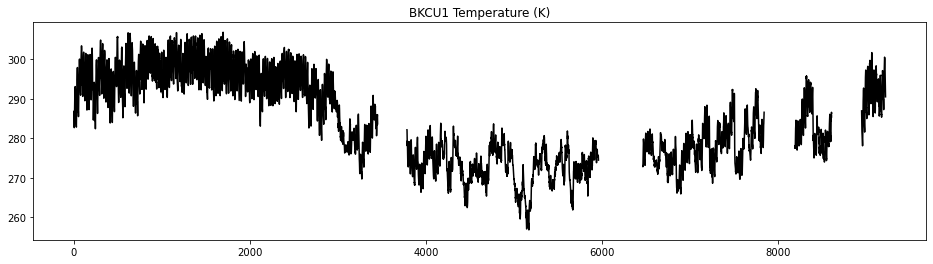

In [26]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rtma['temp'],linestyle='-',c='k',label='Temperature')
plt.title(station['STID'] + ' Temperature (K)')

Text(0.5, 1.0, 'BKCU1 Dew point (K)')

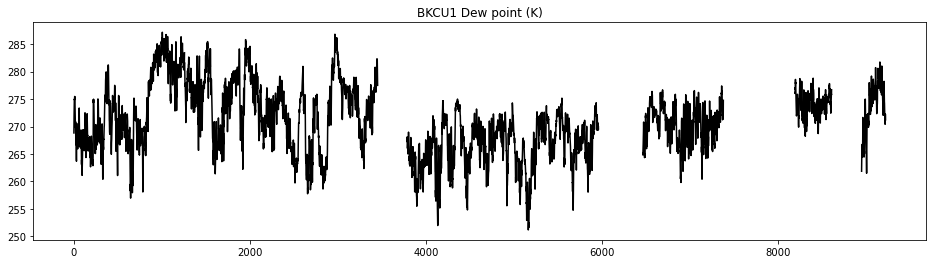

In [27]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rtma['td'],linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' Dew point (K)')

Text(0.5, 1.0, 'BKCU1 Precipitation')

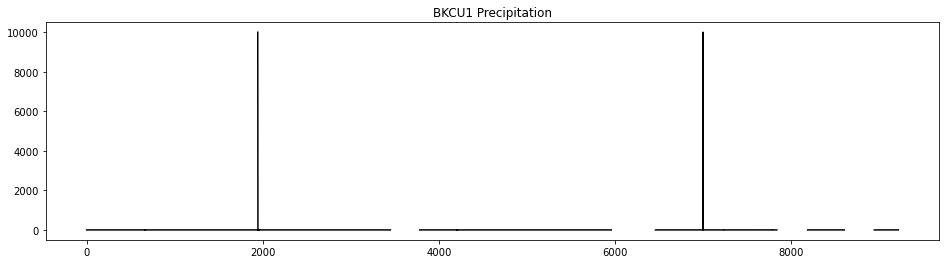

In [29]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rtma['precipa'],linestyle='-',c='k',label='Precipitation')
plt.title(station['STID'] + ' Precipitation' )

One special grib file with the terrain height is stored at the root of the stash. This file is a part of the RTMA dataset but no need to download and store every hour, the data should never change. Trying to read it and doing a sanity check. Also,checking if the grid coordinages in this file are the same as before.


In [ ]:
hf='ds.terrainh.bin'   # terrain height, same in rtma at all times
load_rtma(hf,hf)
gf = GribFile(hf)[1] 
hgt = np.array(gf.values()) # height in m
print('min height %s max %s' % (np.amin(hgt),np.amax(hgt)))
print('shape',hgt.shape)
hlats, hlons = gf.latlons()     # grid of geo coodinates (computed), should be the same for all rtma files here
hlats = np.array(hlats)         # tuple to numpy array
hlons = np.array(hlons) 
print('difference in lats %s lons %s' % (np.amax(np.absolute(lats-hlats)), np.amax(np.absolute(lons-hlons))))


## Model with augmented state
In reality, the equilibrium moisture $E$ computed from atmospheric conditions
generally does not agree with the data. We want to add a correction $\Delta
E$ to $E$ constant in time, and identify the new parameter $\Delta E$ from data. 
Because the Kalman filter identifies state, add the parameter to the state.
Define augmented state $u=\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  .$ Since $\Delta E$ is constant in time, it satisfies the
differential equation $\frac{d\Delta E}{dt}=0.$ So, we want to estimate the
state $u$ governed by the
$$
\frac{d}{dt}\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
\frac{E+\Delta E-m(t)}{T}\\
0
\end{array}
\right]  ,
$$
which we write as $\frac{du}{dt}=F(u),$ where
$$
F(u)=\left[
\begin{array}
[c]{c}
F_{1}\left(  u\right)  \\
F_{2}\left(  u\right)
\end{array}
\right]  =F\left(  \left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  \right)  =\left[
\begin{array}
[c]{c}
\left(  E+\Delta E-m(t)\right)  T_{1}\\
0
\end{array}
\right]  ,\quad T_{1}=\frac{1}{T}.
$$
The Jacobian of $F$ is
$$
\left[
\begin{array}
[c]{cc}
\frac{\partial F_{1}}{\partial u_{1}} & \frac{\partial F_{1}}{\partial u_{2}
}\\
\frac{\partial F_{2}}{\partial u_{1}} & \frac{\partial F_{2}}{\partial u_{2}}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
\frac{\partial\Delta E}{\partial m_{0}} & \frac{\partial\Delta E}
{\partial\Delta E}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
0 & 1
\end{array}
\right]
$$
Here is a function that implements the augmented model $F$. The input is
$u_{0}$. The output is $u_{1}$ and the Jacobian $du_{1}/du_{0}$.

In [ ]:
def model_augmented(u0,E,T1,tlen=1):
  # state u is the vector [m,dE] with dE correction to equilibrium
  m0 = u0[0]  # decompose u0
  dE = u0[1]
  m1, dm1_dm0, dm1_dE, dm1_dT1  = model_decay(m0,E + dE,T1,tlen=tlen)
  u1 = np.array([m1,dE])
  J = np.array([dm1_dm0, dm1_dE],
               [0.     ,     1.])
  return m0, J

In [ ]:
u = np.zeros((2,2*hours)
u[:,0]=[0.1,0.1]             # background state  
P = np.zeros(2,2,2*hours)
P[:,:,0] = np.array([[0.03, 0.],
                  [0.,    0.03]]) # background state covariance
Q = np.array([[0.03, 0.],
            [0,    0.03]]) # process noise covariance
H = np.array([[1., 0.],
             [0.,  .0]])   # first component observed
R = np.array([0.02]) # data variance

DeltaE = 0.05          # bias
for t in range(hours):
  # use lambda construction to pass additional arguments to the model 
  u[:,t+1],P[:,:,t+1] = ext_kf(m[:,t],d2(P[:,:,t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
for t in range(hours,2*hours - 1):
  u[:,t+1],P[:,:,t+1] = ext_kf(m[t],d2(P[t]),lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
    
%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day[0:hours],data[0:hours],c='b',label='10-h fuel data')
plt.plot(day,m,linestyle='-',c='r',label='filtered')




In [ ]:
DeltaE

In [ ]:
d=np.array([])
if d:
  print('yes')

In [ ]:
for d in range(24):
  print(d)

# With real data

In [ ]:
! pip install intergrid
from intergrid.intergrid import Intergrid  # docs https://pypi.org/project/intergrid/
from datetime import date
import pandas as pd
start_date = date(2018,5,19)
end_date = date(2020,6,1)
for d in pd.date_range(start_date,end_date,freq="1h"):
    path = d.strftime("%Y%m%d/%H")
    print(path)

#Experiments

In [ ]:
import numpy as np
a = np.array([1.])
b = np.array([2.])
c  = a @ b
print('a',a)
print('b',b)
print('c=a@b',c)

# Testers

In [ ]:
# a basic ext_kf test
import numpy as np
u = [1,
     2]
P = [[2 , -1],
    [-1 , 2]]
A = [ [1 ,2],
      [3 ,4]]
u = np.array(u)      
Q = np.array([[1,0],[0,1]])
A = np.array(A)
def fun(u):
  return A @ u, A
F = lambda u: fun(u)
H = [[1, 0],
     [0, 1]]
d = [2,
    3]
R = [[2, 0],
    [0, 2]]
H = np.array(H)      
d = np.array(d)
R = np.array(R)
ua,Pa = ext_kf(u,P,F,Q)
print('ua=',ua)
print('Pa=',Pa)
ua,Pa = ext_kf(u,P,F,Q,d,H,R)
print('ua=',ua)
print('Pa=',Pa)
